In [576]:
"""
FABADA is a non-parametric noise reduction technique based on Bayesian
inference that iteratively evaluates possibles moothed  models  of
the  data introduced,  obtaining  an  estimation  of the  underlying
signal that is statistically  compatible  with the  noisy  measurements.
based on P.M. Sanchez-Alarcon, Y. Ascasibar, 2022
"Fully Adaptive Bayesian Algorithm for Data Analysis. FABADA"
Copyright (C) 2007 Free Software Foundation, Inc. <https://fsf.org/>
Everyone is permitted to copy and distribute verbatim copies
of this license document, but changing it is not allowed.
"""

"""PFABADA(parametric Fabada) is a fully self-optimizing noise reduction technique based on FABADA
that uses known properties of signals and skimage's sigma estimator to converge on a best
fit approximation in the presence of unknown variance and normalization parameters,
generalizing the fabada approach for most data streams.
Copywrite 2022 Joshuah Rainstar

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in
all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT.  IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
THE SOFTWARE.
"""

import numpy
import numba
import scipy
from pywt import dwtn

@numba.jit(numba.float64[:](numba.float64[:]),cache=True,nogil=True)
def numba_fabada(data: numpy.ndarray) -> (numpy.ndarray):
    x = numpy.zeros_like(data,dtype=numpy.float64)
    x[:] = data.copy()
    x[numpy.where(numpy.isnan(data))] = 0
    iterations: int = 1
    N = x.size
    max_iterations = 1000

    bayesian_weight = numpy.zeros_like(x,dtype=numpy.float64)
    bayesian_model = numpy.zeros_like(x,dtype=numpy.float64)
    model_weight = numpy.zeros_like(x,dtype=numpy.float64)

    # pre-declaring all arrays allows their memory to be allocated in advance
    posterior_mean = numpy.zeros_like(x,dtype=numpy.float64)
    posterior_mean[:] = x.copy()

    initial_evidence = numpy.zeros_like(x,dtype=numpy.float64)
    evidence = numpy.zeros_like(x,dtype=numpy.float64)
    prior_mean = numpy.zeros_like(x,dtype=numpy.float64)
    prior_variance = numpy.zeros_like(x,dtype=numpy.float64)
    posterior_variance = numpy.zeros_like(x,dtype=numpy.float64)

    chi2_data_min = N
    data_variance = numpy.zeros_like(x,dtype=numpy.float64)
    with numba.objmode(sigma=numba.float64):  # annotate return type
        coeffs = dwtn(x, wavelet='db2')
        detail_coeffs = coeffs['d' * x.ndim]
        sigma = numpy.median(numpy.abs(detail_coeffs)) / 0.6616518484657332 #scipy.stats.gamma.ppf(0.75,0.5)
        # https://github.com/scikit-image/scikit-image/blob/main/skimage/restoration/_denoise.py#L938-L1008
        #note: 2d and higher dimension sigmas will require calling the function instead of inlining wavelets

    data_variance.fill(sigma**2)
    data_variance[numpy.where(numpy.isnan(data))] = 1e-15

    posterior_variance[:] = data_variance.copy()
    prior_variance[:] = data_variance.copy()

    prior_mean[:] = x.copy()

    # fabada figure 14
    #formula 3, but for initial assumptions

    upper = numpy.square(numpy.sqrt(data_variance)*-1)
    lower = 2 * data_variance
    first = (-upper / lower)
    second = numpy.sqrt(2 * numpy.pi) * data_variance
    evidence[:] = numpy.exp(first) / second
    initial_evidence[:] = evidence.copy()

    evidence_previous = numpy.mean(evidence)

    while 1:
        
        # GENERATES PRIORS
        for i in numba.prange(N - 1):
            prior_mean[i] = (posterior_mean[i - 1] + posterior_mean[i] + posterior_mean[i + 1]) / 3

        prior_mean[0] = (posterior_mean[0] + (posterior_mean[1] + posterior_mean[2]) / 2) / 3
        prior_mean[-1] = (posterior_mean[-1] + (posterior_mean[-2] + posterior_mean[-3]) / 2) / 3

        prior_variance = posterior_variance.copy() #if this is an array, you must use .copy() or it will
        #cause any changes made to posterior_variance to also automatically be applied to prior
        #variance, making these variables redundant.

        # APPLY BAYES' THEOREM
        # fabada figure 8?
        for i in numba.prange(N):
           # posterior_variance[i] = 1 / (1 / data_variance[i] + 1 / prior_variance[i])
            posterior_variance[i] = (data_variance[i] * prior_variance[i])/(data_variance[i] + prior_variance[i])
            #saves on instructions- replaces three divisions, 1 add with one mult, 1 div, 1 add

        # fabada figure 7
        for i in numba.prange(N):
            posterior_mean[i] = (
            ((prior_mean[i] / prior_variance[i]) + (x[i] / data_variance[i])) * posterior_variance[i])

        upper = numpy.square(prior_mean - x)
        lower = 2 * (prior_variance + data_variance)
        first =((-upper/lower))
        second = numpy.sqrt(2*numpy.pi) * prior_variance + data_variance

        evidence = numpy.exp(first) / second

        # fabada figure 6: probability distribution calculation

        evidence_derivative = numpy.mean(evidence) - evidence_previous
        evidence_previous = numpy.mean(evidence)

        # EVALUATE CHI2
        chi2_data = numpy.sum((x - posterior_mean) ** 2 / data_variance)


        if iterations == 1:
            chi2_data_min = chi2_data

        # COMBINE MODELS FOR THE ESTIMATION

        for i in numba.prange(N):
            model_weight[i] = evidence[i] * chi2_data

        for i in numba.prange(N):
            bayesian_weight[i] = bayesian_weight[i] + model_weight[i]
            bayesian_model[i] = bayesian_model[i] + (model_weight[i] * posterior_mean[i])


        if ((chi2_data > N) and (evidence_derivative < 0)) \
                or (iterations > max_iterations):  # don't overfit the data
            break
        iterations = iterations + 1
        # COMBINE ITERATION ZERO
    for i in numba.prange(N):
        model_weight[i] = initial_evidence[i] * chi2_data_min
    for i in numba.prange(N):
        bayesian_weight[i] = bayesian_weight[i]+ model_weight[i]
        bayesian_model[i] = bayesian_model[i] + (model_weight[i] * x[i])


    for i in numba.prange(N):
        x[i] = bayesian_model[i] / bayesian_weight[i]


    return x


In [496]:
"""
FABADA is a non-parametric noise reduction technique based on Bayesian
inference that iteratively evaluates possibles moothed  models  of  
the  data introduced,  obtaining  an  estimation  of the  underlying  
signal that is statistically  compatible  with the  noisy  measurements.
based on P.M. Sanchez-Alarcon, Y. Ascasibar, 2022
"Fully Adaptive Bayesian Algorithm for Data Analysis. FABADA"
Copyright (C) 2007 Free Software Foundation, Inc. <https://fsf.org/>
Everyone is permitted to copy and distribute verbatim copies
of this license document, but changing it is not allowed.
"""

from __future__ import print_function, division
import numpy as np
from typing import Union
from time import time as time
from scipy import ndimage
import scipy.stats as stats
import sys


def fabada(
    data: Union[np.array, list],
    data_variance: Union[np.array, list, float],
    max_iter: int = 3000,
    verbose: bool = False,
    **kwargs
) -> np.array:

    """
        FABADA for any kind of data (1D or 2D). Performs noise reduction in input.
        FABADA is a non-parametric noise reduction technique based on Bayesian
        inference that iteratively evaluates possibles smoothed  models  of  
        the  data introduced,  obtaining  an  estimation  of the  underlying  
        signal that is statistically  compatible  with the  noisy  measurements.
        based on Sanchez-Alarcon, P.M. & Ascasibar, Y.  2022
        "Fully Adaptive Bayesian Algorithm for Data Analysis. FABADA"
        arXiv:2201.05145
        Copyright (C) 2007 Free Software Foundation, Inc. <https://fsf.org/>
        Everyone is permitted to copy and distribute verbatim copies
        of this license document, but changing it is not allowed.
    :param data: Noisy measurements, either 1 dimension (M) or 2 dimensions (MxN)
    :param data_variance: Estimated variance of the input, either MxN array, list
                          or float assuming all point have same variance.
    :param max_iter: 3000 (default). Maximum of iterations to converge in solution.
    :param verbose: False (default) or True. Spits some informations about process.
    :param **kwargs: Future Work.
    :return bayes: denoised estimation of the data with same size as input.
    """
    

    data = np.array(data / 1.0)
    data_variance = np.array(data_variance / 1.0)

    data[np.where(np.isnan(data))] = 0


    if not kwargs:
        kwargs = {}
        kwargs["debug"] = False

    if verbose:
        if len(data.shape) == 1:
            print("FABADA 1-D initialize")
        elif len(data.shape) == 2:
            print("FABADA 2-D initialize")
        else:
            print("Warning: Size of array not supported")

    if data_variance.size != data.size:
        data_variance = data_variance * np.ones_like(data)
        data_variance[np.where(np.isnan(data))] = 1e-15

    # INITIALIZING ALGORITMH ITERATION ZERO
    t = time()
    posterior_mean = data
    posterior_variance = data_variance
    evidence = Evidence(0, np.sqrt(data_variance), 0, data_variance)
    initial_evidence = evidence
    chi2_pdf, chi2_data, iteration = 0, data.size, 0
    chi2_pdf_derivative, chi2_data_min = 0, data.size
    bayesian_weight = 0
    bayesian_model = 0
    evidence_previous = np.mean(evidence)

    converged = False

    try:
        while not converged:
            
            if verbose:
                print('\rIteration = %5d ;'%iteration +
                    '<E> = %4.2f ; '% evidence_previous +
                    'Chi^2 = %3.4e/%3.3e '%(chi2_data,data.size),end='')

            chi2_pdf_previous = chi2_pdf
            chi2_pdf_derivative_previous = chi2_pdf_derivative
            evidence_previous = np.mean(evidence)

            iteration += 1  # Check number of iterartions done

            # GENERATES PRIORS
            prior_mean = running_mean(posterior_mean)
            prior_variance = posterior_variance

            # APPLY BAYES' THEOREM
            posterior_variance = 1 / (1 / prior_variance + 1 / data_variance)
            posterior_mean = (
                prior_mean / prior_variance + data / data_variance
            ) * posterior_variance

            # EVALUATE EVIDENCE
            evidence = Evidence(prior_mean, data, prior_variance, data_variance)
            evidence_derivative = np.mean(evidence) - evidence_previous

            # EVALUATE CHI2
            chi2_data = np.sum((data - posterior_mean) ** 2 / data_variance)
            chi2_pdf = stats.chi2.pdf(chi2_data, df=data.size)
            chi2_pdf_derivative = chi2_pdf - chi2_pdf_previous
            chi2_pdf_snd_derivative = chi2_pdf_derivative - chi2_pdf_derivative_previous

            # COMBINE MODELS FOR THE ESTIMATION
            model_weight = evidence * chi2_data
            bayesian_weight += model_weight
            bayesian_model += model_weight * posterior_mean
            if iteration == 1:
                chi2_data_min = chi2_data
            # CHECK CONVERGENCE
            if (
                (chi2_data > data.size and chi2_pdf_snd_derivative >= 0)
                and (evidence_derivative < 0)
                or (iteration > max_iter)
            ):

                converged = True

                # COMBINE ITERATION ZERO
                model_weight = initial_evidence * chi2_data_min
                bayesian_weight += model_weight
                bayesian_model += model_weight * data

    except:
        print("Unexpected error:", sys.exc_info()[0])
        raise

    bayes = bayesian_model / bayesian_weight

    if verbose:
        print('\rIteration = %5d ; '%iteration +
                    '<E> = %4.2f ; '% np.mean(evidence) +
                    'Chi^2 = %3.4e/%3.3e '%(chi2_data,data.size),end='')
        print(
            "\nFinish at {} iterations".format(iteration),
            " and with an execute time of {:3.2f} seconds.".format(time() - t),
        )

    return bayes

def running_mean(dat):

    mean = np.array(dat)
    dim = len(mean.shape)

    if dim == 1:
        mean[:-1] += dat[1:]
        mean[1:] += dat[:-1]
        mean[1:-1] /= 3
        mean[0] /= 2
        mean[-1] /= 2
    elif dim == 2:
        mean[:-1, :] += dat[1:, :]
        mean[1:, :] += dat[:-1, :]
        mean[:, :-1] += dat[:, 1:]
        mean[:, 1:] += dat[:, :-1]
        mean[1:-1, 1:-1] /= 5
        mean[0, 1:-1] /= 4
        mean[-1, 1:-1] /= 4
        mean[1:-1, 0] /= 4
        mean[1:-1, -1] /= 4
        mean[0, 0] /= 3
        mean[-1, -1] /= 3
        mean[0, -1] /= 3
        mean[-1, 0] /= 3
    else:
        print("Warning: Size of array not supported")
    return mean



def Evidence(mu1, mu2, var1, var2):
    return np.exp(-((mu1 - mu2) ** 2) / (2 * (var1 + var2))) / np.sqrt(
        2 * np.pi * (var1 + var2)
    )


def PSNR(recover, signal, L=255):
    MSE = np.sum((recover - signal) ** 2) / (recover.size)
    return 10 * np.log10((L) ** 2 / MSE)


In [497]:
from matplotlib import pyplot as plt

def show_results(y, z, y_recover, save_fig=False):
    # PLOTTING RESULTS WITH MATPLOTLIB
    plt.ion()
    fig, ax = plt.subplots(1, 1, figsize=(40, 10))

    ax.plot(y, "r-", alpha=0.3, lw=1, label="Signal")

    try:
        text_noisy = "({:2.2f}/{:1.2})".format(
            PSNR(z, y, L=255), ssim(z, y, data_range=255)
        )

        text_recover = "({:2.2f}/{:1.2})".format(
            PSNR(y_recover, y, L=255), ssim(y_recover, y, data_range=255)
        )
    except:
        text_noisy = "({:2.2f})".format(PSNR(z, y, L=255))

        text_recover = "({:2.2f})".format(PSNR(y_recover, y, L=255))

    ax.plot(z, "k-", alpha=0.1, lw=1, label="Noisy " + text_noisy)
    ax.plot(y_recover, "k-", alpha=1, lw=1, label="Recover " + text_recover)
    ax.set_xlim([-1, y.size])
    ax.set_ylim([-0.01 * 255, 0.65 * 255])
    ax.set_xticks([])
    ax.set_yticks([])
    fig.legend(loc="upper center", fancybox=True, shadow=True, ncol=3)
    plt.subplots_adjust(
        top=0.97, bottom=0.0, left=0.01, right=0.99, wspace=0.0, hspace=0.00
    )

    if save_fig:
        save_path = os.path.join(os.getcwd(), "..", "src", "images")
        plt.savefig(
            os.path.join(
                save_path, "arp256_fabada_{:2.2f}dB.jpg".format(PSNR(z, y, L=lX))
            ),
            dpi=300,
        )

    plt.show()

In [573]:
import numpy
import numpy as np
import math
from matplotlib import pyplot as plt

arp256clean = [1.400699999999999689e-22, 1.821100000000000012e-22, 2.159400000000000123e-22, 2.644499999999999981e-22, 3.291099999999999715e-22, 5.027400000000000143e-22, 7.117699999999999467e-22, 9.491600000000000001e-22, 2.974000000000000146e-21, 3.920499999999999489e-21, 4.429299999999999341e-21, 4.746100000000001336e-21, 5.589099999999999770e-21, 6.446699999999999129e-21, 7.150599999999998916e-21, 9.127199999999996874e-21, 1.060100000000000063e-20, 2.090900000000000151e-20, 4.021100000000000288e-20, 4.746100000000000884e-20, 5.627800000000000640e-20, 6.657899999999999255e-20, 7.504800000000000118e-20, 8.817399999999999686e-20, 1.017000000000000178e-19, 1.133300000000000212e-19, 1.298200000000000101e-19, 1.430000000000000046e-19, 1.528800000000000100e-19, 1.731200000000000031e-19, 2.010700000000000161e-19, 2.199600000000000125e-19, 2.456599999999999990e-19, 2.743700000000000180e-19, 2.967200000000000378e-19, 3.253400000000000345e-19, 3.893500000000000217e-19, 4.279000000000000015e-19, 4.542999999999999631e-19, 4.992800000000000504e-19, 7.750700000000000289e-19, 1.337599999999999916e-18, 1.743200000000000092e-18, 1.775600000000000012e-18, 1.964899999999999845e-18, 1.735199999999999826e-18, 2.052799999999999970e-18, 2.209699999999999882e-18, 2.297899999999999921e-18, 2.378699999999999908e-18, 2.462299999999999987e-18, 2.548799999999999873e-18, 2.537100000000000159e-18, 2.681300000000000131e-18, 2.699900000000000171e-18, 2.846700000000000037e-18, 3.057299999999999902e-18, 3.194000000000000107e-18, 3.306299999999999887e-18, 3.406700000000000138e-18, 3.502199999999999746e-18, 3.608600000000000196e-18, 3.684200000000000010e-18, 3.650400000000000236e-18, 3.822399999999999783e-18, 3.902499999999999842e-18, 3.947700000000000187e-18, 3.965899999999999828e-18, 3.984199999999999954e-18, 4.048900000000000080e-18, 4.067599999999999834e-18, 4.076999999999999953e-18, 4.105300000000000026e-18, 4.143199999999999647e-18, 4.143199999999999647e-18, 4.210599999999999766e-18, 4.757100000000001442e-18, 8.420500000000000762e-18, 8.696399999999999424e-18, 9.064400000000000856e-18, 8.858100000000000652e-18, 1.138500000000000066e-17, 1.316299999999999844e-17, 1.470099999999999904e-17, 1.426699999999999966e-17, 1.715300000000000418e-17, 1.787900000000000170e-17, 2.071800000000000023e-17, 2.373199999999999975e-17, 2.572399999999999963e-17, 2.638400000000000074e-17, 2.994599999999999766e-17, 3.201400000000000237e-17, 3.414600000000000304e-17, 3.510300000000000804e-17, 3.534600000000000282e-17, 4.449799999999999850e-17, 4.328499999999999732e-17, 5.180099999999999731e-17, 5.436799999999999913e-17, 5.679899999999998874e-17, 6.417099999999999543e-17, 6.860200000000000521e-17, 7.333999999999999956e-17, 8.004599999999999454e-17, 8.676399999999999839e-17, 9.106299999999997220e-17, 9.557400000000000004e-17, 9.961899999999999971e-17, 1.094800000000000060e-16, 9.491600000000000247e-17, 1.170399999999999997e-16, 1.219900000000000111e-16, 1.313200000000000069e-16, 1.413599999999999935e-16, 1.535799999999999978e-16, 1.623099999999999938e-16, 1.649499999999999982e-16, 2.566499999999999894e-16, 1.796099999999999741e-15, 4.095800000000000014e-15, 8.228899999999999273e-15, 1.162399999999999956e-14, 1.381500000000000065e-14, 2.513900000000000085e-15, 1.307199999999999942e-14, 1.319299999999999803e-14, 1.783799999999999995e-14, 1.672399999999999960e-14, 6.766100000000000826e-15, 1.228400000000000003e-14, 2.219899999999999962e-14, 2.174399999999999992e-14, 1.792000000000000089e-14, 2.090899999999999956e-14, 1.715300000000000085e-14, 2.174399999999999992e-14, 2.048000000000000147e-14, 1.987600000000000033e-14, 1.787899999999999884e-14, 2.189500000000000099e-14, 2.001400000000000060e-14, 2.100600000000000094e-14, 2.164399999999999908e-14, 1.557199999999999981e-14, 2.124900000000000114e-14, 1.608199999999999903e-14, 1.183999999999999991e-14, 6.876099999999999852e-15, 1.490500000000000061e-14, 2.115099999999999994e-14, 2.261200000000000061e-14, 2.174400000000000307e-14, 1.955900000000000090e-14, 2.319199999999999978e-14, 2.367800000000000018e-14, 1.942400000000000008e-14, 1.969399999999999855e-14, 2.324599999999999947e-14, 2.209699999999999914e-14, 2.010699999999999955e-14, 2.271600000000000072e-14, 2.219899999999999962e-14, 2.033899999999999858e-14, 2.081300000000000116e-14, 2.100600000000000094e-14, 1.804400000000000054e-14, 1.889500000000000115e-14, 1.964900000000000039e-14, 1.978500000000000102e-14, 1.992200000000000147e-14, 2.062200000000000417e-14, 2.062200000000000101e-14, 2.015300000000000069e-14, 1.889500000000000115e-14, 1.889500000000000115e-14, 1.889500000000000115e-14, 1.898200000000000118e-14, 1.792000000000000404e-14, 1.619299999999999787e-14, 1.703500000000000011e-14, 1.699600000000000086e-14, 1.504300000000000403e-14, 1.575199999999999879e-14, 1.507800000000000086e-14, 1.560799999999999961e-14, 1.645699999999999427e-14, 1.684000000000000069e-14, 1.707399999999999937e-14, 1.680100000000000144e-14, 1.680100000000000144e-14, 1.619300000000000103e-14, 1.699600000000000086e-14, 1.703500000000000011e-14, 1.619299999999999787e-14, 1.723199999999999917e-14, 1.615600000000000141e-14, 1.727200000000000140e-14, 1.755300000000000104e-14, 1.672399999999999960e-14, 1.611899999999999864e-14, 1.535800000000000383e-14, 1.525200000000000092e-14, 1.600799999999999980e-14, 1.557199999999999981e-14, 1.626800000000000008e-14, 1.528800000000000072e-14, 1.535799999999999752e-14, 1.557199999999999981e-14, 1.619300000000000103e-14, 1.619300000000000103e-14, 1.494000000000000059e-14, 1.535800000000000067e-14, 1.483700000000000029e-14, 1.375099999999999961e-14, 1.362500000000000032e-14, 1.397500000000000167e-14, 1.490500000000000061e-14, 1.365699999999999926e-14, 1.295200000000000062e-14, 1.387800000000000029e-14, 1.322300000000000049e-14, 1.289300000000000026e-14, 1.343799999999999945e-14, 1.384599999999999977e-14, 1.286299999999999938e-14, 1.387800000000000029e-14, 1.429999999999999965e-14, 1.349999999999999770e-14, 1.316300000000000031e-14, 1.353099999999999998e-14, 1.322300000000000049e-14, 1.378300000000000013e-14, 1.292199999999999974e-14, 1.322300000000000049e-14, 1.271600000000000073e-14, 1.289300000000000184e-14, 1.356300000000000050e-14, 1.274500000000000022e-14, 1.322300000000000049e-14, 1.254099999999999927e-14, 1.280400000000000059e-14, 1.286299999999999938e-14, 1.301199999999999923e-14, 1.248400000000000012e-14, 1.236900000000000042e-14, 1.277399999999999970e-14, 1.251199999999999979e-14, 1.239799999999999991e-14, 1.217099999999999996e-14, 1.254099999999999927e-14, 1.225600000000000036e-14, 1.189399999999999960e-14, 1.154399999999999983e-14, 1.197700000000000036e-14, 1.170800000000000171e-14, 1.134100000000000186e-14, 1.153100000000000061e-14, 1.164299999999999927e-14, 1.178400000000000058e-14, 1.125599999999999989e-14, 1.131300000000000062e-14, 1.093399999999999978e-14, 9.120099999999999239e-15, 1.040399999999999945e-14, 1.021899999999999980e-14, 1.060800000000000040e-14, 1.013499999999999922e-14, 1.025499999999999960e-14, 9.820999999999999249e-15, 1.017100000000000060e-14, 9.853299999999999399e-15, 9.949400000000001888e-15, 1.020700000000000039e-14, 9.865500000000000662e-15, 1.019399999999999959e-14, 1.008199999999999935e-14, 9.971800000000000043e-15, 9.724800000000000565e-15, 9.887900000000000395e-15, 9.339499999999999609e-15, 1.000999999999999976e-14, 9.346700000000000200e-15, 9.610999999999999386e-15, 9.287100000000000572e-15, 9.291899999999997810e-15, 9.145700000000000286e-15, 9.515699999999999593e-15, 9.346900000000000479e-15, 9.633400000000000697e-15, 9.572099999999999484e-15, 9.489399999999999935e-15, 9.233200000000000229e-15, 9.153400000000000786e-15, 9.285700000000001772e-15, 9.417299999999999414e-15, 9.821100000000000177e-15, 9.894500000000000147e-15, 9.365100000000000656e-15, 9.566299999999997694e-15, 9.549499999999999472e-15, 9.227800000000000575e-15, 9.318299999999999975e-15, 9.046000000000000658e-15, 8.968000000000000574e-15, 9.203099999999999996e-15, 8.512400000000001611e-15, 8.596000000000001629e-15, 8.758199999999999413e-15, 8.967199999999999456e-15, 8.707700000000002241e-15, 7.780800000000000531e-15, 8.095999999999999026e-15, 8.818399999999999878e-15, 8.925600000000001305e-15, 8.624999999999999536e-15, 8.511600000000000494e-15, 8.339400000000001364e-15, 8.737400000000000337e-15, 8.699800000000001462e-15, 8.664800000000001485e-15, 8.647399999999999269e-15, 8.938499999999999601e-15, 8.702499999999999711e-15, 8.531600000000001608e-15, 8.556300000000000609e-15, 8.505000000000000742e-15, 8.473500000000000131e-15, 8.461699999999999427e-15, 8.391699999999999473e-15, 8.360799999999999700e-15, 8.291799999999997987e-15, 8.258699999999999875e-15, 8.134200000000000317e-15, 8.085800000000002134e-15, 8.056200000000000233e-15, 7.769700000000000015e-15, 7.885300000000000553e-15, 7.660000000000000619e-15, 7.864099999999999340e-15, 7.978600000000000708e-15, 7.894999999999999113e-15, 7.830200000000000111e-15, 7.850800000000000485e-15, 8.036300000000000048e-15, 8.020500000000000067e-15, 7.715099999999999483e-15, 7.753300000000000774e-15, 7.720199999999999507e-15, 7.722799999999999983e-15, 7.193099999999999284e-15, 7.363100000000000074e-15, 7.748300000000000101e-15, 7.822600000000000539e-15, 7.472999999999999750e-15, 7.614499999999999387e-15, 7.866600000000000466e-15, 7.725600000000000738e-15, 7.746000000000000833e-15, 7.231399999999999926e-15, 7.769100000000000755e-15, 7.236299999999999670e-15, 7.339499999999998665e-15, 7.125400000000000176e-15, 7.327600000000000187e-15, 7.279599999999999407e-15, 7.332599999999999283e-15, 7.267800000000000281e-15, 7.137599999999999861e-15, 7.140099999999999409e-15, 7.342699999999999979e-15, 7.603299999999999520e-15, 7.570999999999999370e-15, 7.384200000000000358e-15, 7.541400000000002202e-15, 6.896100000000000177e-15, 6.756999999999999948e-15, 6.575200000000000031e-15, 7.228700000000000099e-15, 6.985699999999999897e-15, 7.036599999999998417e-15, 7.219699999999998572e-15, 7.288999999999999915e-15, 7.393099999999999378e-15, 7.144600000000000172e-15, 5.871999999999999964e-15, 5.979500000000000232e-15, 7.792500000000000307e-15, 7.200900000000000712e-15, 5.637100000000000032e-15, 6.705700000000000870e-15, 5.139799999999999623e-15, 4.054499999999999915e-15, 4.691800000000000232e-15, 5.263499999999999641e-15, 7.360999999999999507e-15, 6.896800000000000366e-15, 4.843399999999999777e-15, 7.332099999999999373e-15, 7.149299999999999637e-15, 7.138599999999999680e-15, 8.117599999999999219e-15, 7.065199999999999710e-15, 7.100799999999998948e-15, 6.279900000000000143e-15, 7.757099999999999771e-15, 8.170999999999999653e-15, 6.709700000000000146e-15, 5.987799999999999992e-15, 6.537099999999999668e-15, 8.368500000000000200e-15, 1.037200000000000051e-14, 1.689600000000000003e-14, 2.643000000000000072e-14, 2.958900000000000019e-14, 2.857799999999999697e-14, 1.569300000000000000e-14, 1.018000000000000055e-14, 7.539000000000000428e-15, 5.318300000000001242e-15, 7.122700000000001926e-15, 6.686600000000000224e-15, 7.556000000000000507e-15, 5.871799999999999685e-15, 5.343400000000000802e-15, 8.796099999999999496e-15, 7.125400000000000176e-15, 7.679399999999999317e-15, 7.294000000000000588e-15, 8.688199999999999459e-15, 4.419399999999999987e-15, 6.683599999999999978e-15, 7.754800000000000503e-15, 8.982400000000000177e-15, 8.657499999999999966e-15, 7.144300000000000542e-15, 1.116400000000000234e-14, 8.148599999999999920e-15, 8.517099999999999499e-15, 8.769599999999999559e-15, 8.226600000000000004e-15, 6.962300000000000345e-15, 9.931400000000000412e-15, 8.670199999999999561e-15, 1.000600000000000048e-14, 8.640799999999999517e-15, 7.351999999999999558e-15, 6.926600000000000180e-15, 1.040900000000000013e-14, 9.593600000000000326e-15, 8.284199999999999994e-15, 7.110800000000000293e-15, 7.704899999999999435e-15, 6.698799999999999909e-15, 8.484900000000001855e-15, 4.575599999999999645e-15, 1.001400000000000061e-14, 7.793099999999999567e-15, 8.751300000000000031e-15, 6.993200000000000118e-15, 8.480400000000001091e-15, 7.869700000000000851e-15, 9.824700000000000473e-15, 9.324600000000000097e-15, 9.962800000000000094e-15, 9.341300000000000546e-15, 1.037400000000000015e-14, 8.512100000000000404e-15, 1.049600000000000174e-14, 6.481100000000000336e-15, 8.847099999999999733e-15, 8.337199999999999869e-15, 7.592099999999999654e-15, 8.606600000000000657e-15, 8.906699999999999361e-15, 7.783200000000000728e-15, 7.487000000000000372e-15, 9.325100000000001584e-15, 7.792099999999999748e-15, 9.316800000000000246e-15, 1.091699999999999970e-14, 1.063600000000000007e-14, 6.981799999999999972e-15, 9.349900000000001514e-15, 8.325599999999999444e-15, 7.211100000000000760e-15, 1.008300000000000075e-14, 9.493400000000000789e-15, 9.224799999999999540e-15, 8.786799999999999917e-15, 8.515599999999999770e-15, 9.278699999999999884e-15, 8.944500000000000093e-15, 9.479800000000000726e-15, 9.558600000000000349e-15, 9.770399999999997993e-15, 7.822400000000000260e-15, 9.383999999999999445e-15, 1.121199999999999996e-14, 9.415400000000000705e-15, 1.008300000000000075e-14, 8.161099999999999236e-15, 7.744400000000000176e-15, 6.911900000000000946e-15, 8.025600000000000091e-15, 7.946699999999999539e-15, 9.464500000000000654e-15, 8.662699999999999340e-15, 8.311199999999999841e-15, 9.239000000000000441e-15, 1.011800000000000072e-14, 9.858799999999998404e-15, 1.036699999999999984e-14, 1.042799999999999984e-14, 1.059199999999999541e-14, 8.998299999999999508e-15, 8.372999999999999386e-15, 9.690500000000000777e-15, 9.985600000000000385e-15, 1.021400000000000070e-14, 1.137700000000000008e-14, 1.153499999999999988e-14, 1.081600000000000063e-14, 9.176899999999999689e-15, 9.458700000000000442e-15, 9.973200000000000420e-15, 8.976500000000000613e-15, 9.066000000000000194e-15, 9.528700000000000396e-15, 9.853400000000000328e-15, 9.473399999999999675e-15, 9.275900000000000706e-15, 9.434499999999999772e-15, 8.843999999999999348e-15, 9.121199999999999987e-15, 9.284799999999999726e-15, 9.811699999999999670e-15, 9.704900000000000380e-15, 8.634800000000000603e-15, 9.792700000000001530e-15, 9.875399999999999502e-15, 9.424900000000000563e-15, 8.968599999999999834e-15, 9.255300000000000332e-15, 9.500199999999999243e-15, 9.527099999999998161e-15, 9.857599999999999883e-15, 9.817799999999997935e-15, 9.607200000000000390e-15, 8.621200000000000539e-15, 8.716200000000000703e-15, 8.861899999999999895e-15, 8.275400000000000324e-15, 9.101700000000000360e-15, 9.263699999999999443e-15, 9.582200000000000181e-15, 8.829800000000000024e-15, 8.271399999999999470e-15, 8.763999999999999626e-15, 9.431599999999999666e-15, 8.621500000000000170e-15, 9.585100000000000287e-15, 9.368899999999999653e-15, 9.080800000000000356e-15, 9.383199999999999905e-15, 8.739999999999999236e-15, 9.668000000000000115e-15, 9.891699999999999392e-15, 9.381499999999999897e-15, 1.015700000000000155e-14, 9.451700000000000131e-15, 9.837100000000000437e-15, 9.155900000000000334e-15, 9.372700000000000228e-15, 9.815599999999999595e-15, 8.420899999999999237e-15, 8.769200000000000578e-15, 9.267700000000000296e-15, 8.910999999999999845e-15, 9.328700000000000302e-15, 1.020800000000000021e-14, 9.295799999999999313e-15, 8.816999999999999501e-15, 9.184100000000000279e-15, 9.321699999999999991e-15, 1.030100000000000074e-14, 9.290300000000001886e-15, 9.954399999999999405e-15, 9.808700000000001790e-15, 9.145700000000000286e-15, 8.327100000000000750e-15, 9.544099999999999818e-15, 9.432500000000000134e-15, 1.085599999999999970e-14, 1.060600000000000076e-14, 9.760600000000000082e-15, 9.666300000000000108e-15, 9.563900000000000652e-15, 9.847100000000001783e-15, 7.893100000000000403e-15, 9.538499999999999885e-15, 9.818599999999999052e-15, 9.554500000000000145e-15, 8.189100000000000480e-15, 8.266700000000000005e-15, 8.558699999999999228e-15, 9.866099999999998345e-15, 9.908300000000000490e-15, 8.019700000000000528e-15, 8.774100000000000322e-15, 9.220800000000000264e-15, 9.296400000000000151e-15, 8.797400000000000523e-15, 9.032099999999999387e-15, 9.852700000000000139e-15, 8.883900000000000647e-15, 8.867499999999999828e-15, 9.277200000000000155e-15, 8.123500000000000360e-15, 9.059999999999999702e-15, 9.677399999999999045e-15, 9.384300000000000653e-15, 9.492099999999999762e-15, 8.014800000000000783e-15, 8.861199999999999706e-15, 1.034500000000000066e-14, 8.268499999999999364e-15, 9.023200000000000366e-15, 9.056599999999999686e-15, 7.601900000000000720e-15, 7.656799999999999305e-15, 9.882300000000000462e-15, 8.306500000000000376e-15, 1.045200000000000023e-14, 9.416099999999999316e-15, 9.089600000000000025e-15, 1.043899999999999785e-14, 9.081899999999999526e-15, 1.031200000000000032e-14, 8.035099999999999950e-15, 9.133000000000000691e-15, 1.045100000000000041e-14, 1.217299999999999802e-14, 1.151500000000000035e-14, 1.110700000000000003e-14, 9.752399999999999672e-15, 9.586100000000000106e-15, 7.810099999999999646e-15, 1.052200000000000019e-14, 9.936300000000000156e-15, 9.076400000000000521e-15, 8.527099999999999267e-15, 8.885900000000000285e-15, 1.031000000000000226e-14, 9.352500000000000412e-15, 9.454300000000000607e-15, 9.402300000000000551e-15, 1.029200000000000079e-14, 8.650799999999999285e-15, 8.555100000000000511e-15, 8.246599999999999541e-15, 8.316299999999999865e-15, 9.482599999999999903e-15, 9.496199999999999966e-15, 9.180999999999999893e-15, 8.234399999999999855e-15, 7.847299999999999541e-15, 9.099199999999999235e-15, 7.324799999999999432e-15, 7.436799999999999674e-15, 7.382799999999999980e-15, 1.038399999999999992e-14, 8.779499999999999976e-15, 9.079800000000000537e-15, 9.573099999999999303e-15, 9.009899999999999933e-15, 9.790900000000000594e-15, 8.930199999999999841e-15, 8.310699999999999931e-15, 1.004699999999999937e-14, 8.743200000000002127e-15, 9.577800000000000346e-15, 9.885200000000000568e-15, 9.893099999999999770e-15, 9.854699999999999777e-15, 9.625599999999999269e-15, 1.046599999999999928e-14, 9.891800000000000320e-15, 9.052999999999999391e-15, 9.366900000000000015e-15, 9.178899999999999327e-15, 9.604300000000000283e-15, 8.909900000000000675e-15, 9.785399999999998434e-15, 9.294700000000000144e-15, 9.208100000000000669e-15, 7.984399999999999343e-15, 9.269499999999999655e-15, 9.418199999999999882e-15, 9.315300000000000518e-15, 9.384600000000000283e-15, 9.956099999999999413e-15, 9.798700000000002022e-15, 8.640199999999998679e-15, 9.689800000000000588e-15, 9.802900000000000000e-15, 1.037799999999999943e-14, 9.957099999999999232e-15, 9.650099999999999568e-15, 9.215799999999999591e-15, 9.554200000000000515e-15, 9.342699999999999346e-15, 9.475299999999999962e-15, 9.479699999999999797e-15, 9.621599999999999993e-15, 8.996299999999999870e-15, 8.858400000000000528e-15, 9.460099999999999242e-15, 9.466799999999999923e-15, 9.078499999999997932e-15, 9.017499999999999505e-15, 8.490099999999999652e-15, 8.895999999999999404e-15, 9.197000000000000153e-15, 9.916800000000000530e-15, 1.021600000000000034e-14, 1.014600000000000039e-14, 9.613199999999999304e-15, 9.078100000000000529e-15, 9.274300000000001626e-15, 9.728099999999999652e-15, 9.372499999999999948e-15, 9.698399999999999978e-15, 9.751399999999999853e-15, 8.881400000000001099e-15, 9.498300000000000533e-15, 9.569000000000000676e-15, 9.860799999999999620e-15, 9.993499999999999587e-15, 9.776999999999999323e-15, 9.437999999999999139e-15, 1.002300000000000056e-14, 9.831300000000000225e-15, 9.611399999999999945e-15, 9.907400000000000022e-15, 9.910300000000000128e-15, 1.003300000000000033e-14, 9.311299999999999664e-15, 8.887499999999999364e-15, 9.299000000000000628e-15, 1.034399999999999927e-14, 1.035600000000000025e-14, 9.386899999999999551e-15, 9.290000000000002256e-15, 1.058000000000000074e-14, 1.006399999999999945e-14, 9.949999999999999570e-15, 9.428300000000000579e-15, 9.242700000000000087e-15, 9.739700000000000077e-15, 9.627799999999999186e-15, 8.464200000000000552e-15, 7.996600000000000606e-15, 8.454100000000001433e-15, 9.172099999999999295e-15, 9.476599999999999411e-15, 8.967199999999999456e-15, 9.251100000000000776e-15, 9.341600000000000176e-15, 9.255699999999999313e-15, 9.642999999999999906e-15, 1.005399999999999968e-14, 9.777399999999999882e-15, 8.744199999999998791e-15, 8.267699999999999824e-15, 9.241700000000000268e-15, 9.354000000000000141e-15, 8.438000000000000245e-15, 9.144200000000000558e-15, 9.553599999999999676e-15, 9.138100000000000715e-15, 8.848700000000000390e-15, 8.761299999999999799e-15, 8.682900000000000733e-15, 8.710499999999999841e-15, 8.900299999999998310e-15, 8.323500000000000455e-15, 7.789199999999999642e-15, 8.138399999999999873e-15, 7.986000000000000000e-15, 8.671399999999998081e-15, 8.804399999999999256e-15, 8.411000000000000398e-15, 8.474999999999999860e-15, 8.846700000000000752e-15, 9.322199999999999900e-15, 9.307800000000000297e-15, 9.030899999999997711e-15, 9.064300000000000186e-15, 9.360000000000000633e-15, 9.444299999999997683e-15, 9.006599999999999268e-15, 8.576399999999999496e-15, 8.925700000000000656e-15, 8.792300000000000500e-15, 8.992200000000001243e-15, 9.518200000000000718e-15, 8.982100000000000547e-15, 9.253899999999999954e-15, 9.556400000000000432e-15, 8.449599999999999092e-15, 8.704600000000000277e-15, 9.178000000000000436e-15, 9.094900000000000328e-15, 8.637100000000001449e-15, 8.814699999999998655e-15, 8.930300000000000770e-15, 9.740600000000002123e-15, 9.544899999999999358e-15, 8.897099999999998574e-15, 9.369599999999999842e-15, 9.702200000000000553e-15, 8.779600000000000905e-15, 9.234900000000000237e-15, 9.361500000000000361e-15, 9.242299999999999529e-15, 9.415700000000000335e-15, 8.766100000000000192e-15, 8.735000000000000140e-15, 8.409300000000000390e-15, 8.256999999999999867e-15, 8.493499999999999667e-15, 9.249200000000000489e-15, 8.480399999999999514e-15, 9.232799999999999670e-15, 9.767400000000000113e-15, 1.337000000000000071e-14, 1.738000000000000079e-14, 1.932299999999999943e-14, 1.471100000000000101e-14, 1.117300000000000071e-14, 9.315499999999999219e-15, 7.873600000000000777e-15, 8.169999999999999834e-15, 8.293699999999999852e-15, 8.341799999999999983e-15, 7.581399999999999697e-15, 7.716799999999999491e-15, 8.864099999999999812e-15, 8.276699999999999773e-15, 9.255500000000000611e-15, 8.633299999999999296e-15, 8.971099999999999382e-15, 8.988499999999998442e-15, 8.665400000000000745e-15, 9.137799999999999507e-15, 9.261199999999999895e-15, 9.288199999999999742e-15, 8.903100000000000643e-15, 8.600499999999997659e-15, 8.242499999999999336e-15, 8.343499999999999991e-15, 7.829200000000000292e-15, 8.713199999999998090e-15, 9.035299999999999123e-15, 9.707600000000000207e-15, 8.736700000000000148e-15, 8.369400000000000668e-15, 8.860000000000001185e-15, 8.972799999999999390e-15, 9.903000000000000187e-15, 8.745700000000000097e-15, 9.649599999999999659e-15, 1.081900000000000008e-14, 1.204600000000000207e-14, 1.255100000000000062e-14, 1.063500000000000025e-14, 9.215900000000000520e-15, 9.427199999999999831e-15, 8.362799999999999338e-15, 8.463000000000000454e-15, 8.297199999999999219e-15, 8.848200000000000481e-15, 9.349699999999999657e-15, 8.912600000000000502e-15, 7.992899999999999382e-15, 8.404099999999999437e-15, 7.707499999999999912e-15, 8.510799999999999377e-15, 9.416299999999999595e-15, 1.100000000000000046e-14, 1.589299999999999852e-14, 1.869699999999999912e-14, 1.790100000000000117e-14, 1.389199999999999776e-14, 1.110199999999999936e-14, 8.888100000000000202e-15, 8.858200000000000249e-15, 8.075699999999999860e-15, 8.184899999999999347e-15, 9.000400000000000075e-15, 8.559399999999999417e-15, 9.210899999999999847e-15, 9.139299999999999236e-15, 7.456600000000000509e-15, 8.185900000000000743e-15, 8.215800000000000697e-15, 9.123600000000000183e-15, 8.984600000000000094e-15, 1.005800000000000054e-14, 9.189099999999999374e-15, 8.335899999999998842e-15, 9.492200000000002268e-15, 9.132500000000000782e-15, 8.443800000000000457e-15, 8.861199999999999706e-15, 8.967699999999999366e-15, 8.293100000000000592e-15, 9.125099999999999912e-15, 8.710099999999999282e-15, 8.922999999999999251e-15, 9.772599999999999488e-15, 8.475799999999999400e-15, 8.490599999999999561e-15, 8.508900000000000667e-15, 9.240099999999999611e-15, 9.149800000000000491e-15, 8.260800000000000442e-15, 8.281399999999999238e-15, 9.613599999999999863e-15, 9.913599999999999215e-15, 8.244599999999999903e-15, 8.155899999999999861e-15, 8.579099999999999323e-15, 7.805399999999998603e-15, 8.110299999999999278e-15, 7.740500000000001828e-15, 7.595499999999998092e-15, 8.017000000000002278e-15, 7.904399999999999620e-15, 8.612500000000000221e-15, 8.594000000000000413e-15, 8.370700000000000117e-15, 8.634499999999999395e-15, 8.147699999999999452e-15, 7.919600000000000341e-15, 7.952600000000000680e-15, 8.696800000000000427e-15, 8.240100000000000717e-15, 8.257299999999999498e-15, 8.103200000000001194e-15, 7.900299999999999416e-15, 7.846999999999999910e-15, 7.608700000000000752e-15, 6.973199999999999793e-15, 7.330200000000000664e-15, 7.438999999999999592e-15, 7.537199999999999491e-15, 7.525199999999998507e-15, 8.015400000000001621e-15, 7.345199999999999527e-15, 6.626299999999999619e-15, 9.224000000000000000e-15, 8.619300000000000252e-15, 9.000499999999997848e-15, 9.944599999999999916e-15, 8.298700000000000525e-15, 8.398200000000001452e-15, 8.840999999999999891e-15, 8.414999999999999674e-15, 8.206800000000002325e-15, 8.465299999999999722e-15, 8.655000000000000418e-15, 8.291099999999997798e-15, 8.235100000000000044e-15, 7.608500000000000472e-15, 8.607899999999998529e-15, 8.052300000000000308e-15, 8.124700000000000459e-15, 8.868500000000001225e-15, 8.722600000000000176e-15, 7.959000000000000153e-15, 7.531500000000000207e-15, 8.681599999999999707e-15, 8.628300000000000201e-15, 7.960599999999999232e-15, 8.463399999999997857e-15, 7.230800000000000666e-15, 6.523500000000001183e-15, 7.454999999999999852e-15, 8.218599999999999874e-15, 8.357800000000000243e-15, 7.406399999999999811e-15, 7.535899999999998464e-15, 8.287199999999999451e-15, 8.946499999999998154e-15, 9.094100000000000789e-15, 9.103600000000000647e-15, 8.373699999999999575e-15, 8.567800000000000106e-15, 8.441999999999997943e-15, 8.395600000000000976e-15, 8.216399999999999957e-15, 8.739100000000000345e-15, 8.160900000000000534e-15, 7.786099999999999256e-15, 9.201499999999999339e-15, 8.192099999999999937e-15, 7.883999999999999526e-15, 8.414499999999999764e-15, 8.756399999999998476e-15, 8.592600000000000035e-15, 8.469499999999999277e-15, 8.320599999999998771e-15, 8.179900000000000251e-15, 9.178699999999999047e-15, 8.386299999999999819e-15, 7.573000000000000586e-15, 7.359499999999999779e-15, 7.205499999999999249e-15, 7.360299999999999319e-15, 7.865999999999999628e-15, 8.433999999999999391e-15, 9.071600000000000127e-15, 8.634500000000000972e-15, 8.523399999999999621e-15, 8.342699999999998874e-15, 7.936199999999999861e-15, 7.444500000000000174e-15, 8.671900000000001146e-15, 9.308599999999999837e-15, 8.256900000000000517e-15, 8.067799999999999081e-15, 9.104600000000000466e-15, 9.040900000000000634e-15, 7.956500000000000605e-15, 7.938199999999999499e-15, 8.541899999999999428e-15, 7.420099999999997648e-15, 7.385900000000000366e-15, 8.526099999999999448e-15, 8.605200000000000279e-15, 8.389900000000000114e-15, 7.727300000000000746e-15, 8.742500000000000361e-15, 7.743900000000000266e-15, 8.278600000000000061e-15, 7.940200000000000715e-15, 8.061399999999999608e-15, 7.878199999999999313e-15, 8.059199999999999690e-15, 7.441399999999999788e-15, 8.005299999999999347e-15, 7.422699999999999701e-15, 8.289799999999999927e-15, 8.438000000000000245e-15, 8.617000000000000984e-15, 7.480700000000000249e-15, 8.367200000000000751e-15, 8.418500000000000618e-15, 8.087499999999998987e-15, 8.587200000000001959e-15, 8.522399999999999802e-15, 8.738900000000000066e-15, 8.401400000000001188e-15, 7.390199999999999272e-15, 7.116499999999999577e-15, 7.787900000000000193e-15, 8.088000000000002052e-15, 7.844000000000000453e-15, 8.687600000000001776e-15, 8.760099999999999700e-15, 7.934099999999999294e-15, 7.609700000000000571e-15, 7.303899999999999428e-15, 8.137600000000000333e-15, 8.252300000000000402e-15, 7.838700000000000150e-15, 8.026100000000000001e-15, 8.294199999999999762e-15, 7.416800000000000138e-15, 8.062500000000000355e-15, 7.767500000000000098e-15, 7.633199999999999473e-15, 8.335099999999999302e-15, 8.556199999999999680e-15, 8.199600000000000157e-15, 7.968799999999999641e-15, 8.922800000000000549e-15, 7.816699999999999398e-15, 7.039600000000001030e-15, 7.415899999999999670e-15, 8.116799999999999680e-15, 7.915399999999999208e-15, 7.582800000000001652e-15, 8.154800000000000692e-15, 9.750100000000000404e-15, 8.331200000000000955e-15, 7.476899999999999675e-15, 7.994599999999999390e-15, 7.800599999999999788e-15, 8.016100000000000232e-15, 7.017000000000000229e-15, 7.623999999999999245e-15, 7.909299999999999365e-15, 7.826500000000000465e-15, 7.836799999999998285e-15, 8.476999999999999498e-15, 7.714700000000000502e-15, 6.914899999999999615e-15, 7.768499999999999917e-15, 8.291000000000000025e-15, 6.864099999999999657e-15, 8.060899999999999698e-15, 8.321300000000000537e-15, 8.665700000000001953e-15, 8.368599999999999551e-15, 8.295600000000000140e-15, 8.116799999999999680e-15, 7.860999999999998955e-15, 7.853000000000000402e-15, 8.075699999999999860e-15, 8.227800000000000103e-15, 8.162699999999999893e-15, 8.155800000000000511e-15, 7.973100000000000125e-15, 8.373600000000001801e-15, 7.787900000000000193e-15, 8.458299999999999411e-15, 7.646700000000000186e-15, 7.962400000000000168e-15, 8.030099999999999277e-15, 7.213499999999999379e-15, 8.563600000000002128e-15, 8.098000000000000242e-15, 6.969199999999999728e-15, 7.362800000000000444e-15, 9.568500000000000767e-15, 8.276199999999998286e-15, 7.372199999999999374e-15, 8.426600000000000099e-15, 8.030799999999999466e-15, 8.670500000000002346e-15, 7.395600000000000504e-15, 8.115399999999999302e-15, 7.195900000000001617e-15, 9.006799999999999548e-15, 9.126500000000000290e-15, 9.277999999999999695e-15, 8.090099999999997885e-15, 8.611399999999999473e-15, 7.895000000000000690e-15, 8.034000000000000780e-15, 7.443000000000000445e-15, 8.757399999999999873e-15, 7.764300000000000361e-15, 6.917900000000000650e-15, 9.279199999999999793e-15, 7.349999999999999920e-15, 9.609999999999999567e-15, 8.049499999999999552e-15, 1.124699999999999994e-14, 1.242900000000000061e-14, 1.128499999999999937e-14, 8.629599999999999650e-15, 7.603299999999999520e-15, 7.431699999999999650e-15, 5.411900000000000238e-15, 9.213599999999999674e-15, 4.911299999999999953e-15, 9.200400000000000169e-15, 8.097200000000000702e-15, 7.643300000000000170e-15, 8.243100000000000174e-15, 8.592100000000000126e-15, 7.014800000000000311e-15, 9.200600000000000449e-15, 8.802800000000001755e-15, 7.680399999999999136e-15, 8.483299999999999620e-15, 7.950500000000000113e-15, 7.120500000000000431e-15, 9.107800000000000203e-15, 7.487299999999998424e-15, 7.033400000000000258e-15, 7.080900000000000340e-15, 8.700400000000000722e-15, 7.433000000000000677e-15, 8.393300000000001707e-15, 7.427400000000000744e-15, 7.699900000000001918e-15, 7.209299999999999823e-15, 6.409199999999998517e-15, 7.970799999999999279e-15, 8.936799999999999594e-15, 7.779100000000000523e-15, 7.348500000000000192e-15, 7.721599999999999884e-15, 7.427799999999999725e-15, 8.316799999999999774e-15, 7.473299999999999380e-15, 8.329099999999998810e-15, 8.918000000000000156e-15, 8.071599999999999655e-15, 7.523400000000000726e-15, 7.946499999999999259e-15, 6.817199999999999625e-15, 8.642199999999999895e-15, 7.482699999999999888e-15, 7.997299999999999217e-15, 7.968400000000000660e-15, 7.093499999999999795e-15, 7.869699999999999273e-15, 8.477400000000000057e-15, 8.039500000000001362e-15, 8.383000000000002309e-15, 9.078999999999999419e-15, 1.009600000000000155e-14, 9.072300000000000316e-15, 7.846399999999999072e-15, 7.360699999999999877e-15, 7.065300000000000639e-15, 7.679700000000000525e-15, 7.345699999999999436e-15, 6.773199999999999698e-15, 6.585500000000000218e-15, 5.644799999999999743e-15, 6.503500000000000069e-15, 8.061599999999999887e-15, 7.712199999999999377e-15, 7.255100000000000686e-15, 7.428399999999998985e-15, 8.026300000000000280e-15, 7.707800000000001120e-15, 7.543999999999999523e-15, 7.651199999999999371e-15, 6.915600000000001381e-15, 6.582299999999999693e-15, 7.310399999999999829e-15, 7.896599999999999770e-15, 7.719600000000000246e-15, 7.713399999999999475e-15, 7.926799999999999353e-15, 7.650800000000000391e-15, 7.624199999999999524e-15, 7.737100000000000235e-15, 6.915800000000000872e-15, 7.004400000000001562e-15, 7.710199999999999739e-15, 7.861700000000000721e-15, 6.884300000000000261e-15, 7.054800000000000172e-15, 7.127800000000000372e-15, 7.444200000000000544e-15, 8.413700000000000225e-15, 7.860500000000000623e-15, 6.232699999999999692e-15, 7.688000000000000285e-15, 9.322900000000000089e-15, 8.125299999999999719e-15, 7.028100000000000744e-15, 7.366599999999999441e-15, 7.421400000000001830e-15, 8.025500000000000740e-15, 8.484999999999999628e-15, 9.025499999999999635e-15, 7.782599999999999889e-15, 7.469999999999998715e-15, 8.239200000000000249e-15, 7.128199999999999353e-15, 8.377000000000000240e-15, 8.542000000000000357e-15, 7.861099999999999883e-15, 8.294300000000000690e-15, 6.558500000000001160e-15, 6.993300000000000258e-15, 7.280200000000000246e-15, 8.744900000000000558e-15, 7.837299999999999773e-15, 7.563899999999999708e-15, 8.456000000000000143e-15, 7.111099999999999923e-15, 7.423699999999999520e-15, 6.313999999999999652e-15, 7.430900000000000111e-15, 7.451199999999999277e-15, 8.154199999999998276e-15, 8.927200000000001962e-15, 7.947100000000000097e-15, 9.140699999999999613e-15, 7.607899999999999634e-15, 9.035399999999998474e-15, 7.082400000000000069e-15, 8.686600000000001957e-15, 6.674600000000000029e-15, 9.016299999999999406e-15, 7.674400000000001800e-15, 8.412900000000000685e-15, 6.214599999999999654e-15, 7.555300000000000318e-15, 9.270199999999999844e-15, 6.138600000000000786e-15, 7.983800000000000082e-15, 7.083600000000000167e-15, 7.996999999999999587e-15, 7.884100000000000454e-15, 8.132099999999999751e-15, 5.139700000000000272e-15, 8.001199999999999142e-15, 6.616600000000000270e-15, 8.965600000000000377e-15, 1.293700000000000018e-14, 1.145799999999999962e-14, 7.809399999999999457e-15, 4.982600000000000145e-15, 4.561300000000000182e-15, 7.998100000000000334e-15, 6.829900000000000008e-15, 7.171300000000001967e-15, 7.652200000000000768e-15, 7.609599999999998064e-15, 8.141200000000000628e-15, 7.744100000000000546e-15, 6.904499999999998499e-15, 7.676800000000000419e-15, 6.684699999999999937e-15, 7.326499999999999440e-15, 7.212900000000000118e-15, 7.662399999999999238e-15, 7.526999999999999444e-15, 8.086699999999999447e-15, 7.531299999999999928e-15, 8.148699999999999271e-15, 7.609600000000001220e-15, 7.754699999999999574e-15, 7.823400000000000079e-15, 7.472700000000000119e-15, 7.071900000000000391e-15, 8.064299999999999714e-15, 7.611700000000000209e-15, 7.396899999999999953e-15, 7.982500000000000633e-15, 7.494199999999999384e-15, 7.591300000000000114e-15, 7.756699999999999212e-15, 7.744600000000000455e-15, 8.019700000000000528e-15, 7.424400000000001287e-15, 7.741000000000000160e-15, 7.787799999999999264e-15, 6.878500000000000049e-15, 6.802799999999999233e-15, 6.916700000000001340e-15, 6.843499999999998494e-15, 6.334300000000000396e-15, 7.495599999999999762e-15, 6.649699999999999171e-15, 6.621599999999998576e-15, 6.318599999999999766e-15, 6.840599999999999965e-15, 7.707700000000000191e-15, 6.749599999999999867e-15, 6.298199999999999671e-15, 6.237700000000000365e-15, 6.783700000000000165e-15, 7.582299999999998587e-15, 7.428499999999999914e-15, 6.299599999999999260e-15, 5.572499999999999732e-15, 6.165099999999999934e-15, 7.221699999999999788e-15, 7.951799999999999562e-15, 6.739899999999999729e-15, 6.653300000000000255e-15, 9.075599999999999403e-15, 1.064699999999999965e-14, 8.501299999999999518e-15, 7.815600000000000229e-15, 5.475399999999999791e-15, 6.734099999999998728e-15, 6.065900000000000216e-15, 7.641199999999998026e-15, 6.094299999999999652e-15, 9.348499999999999558e-15, 9.564999999999999822e-15, 7.871900000000000769e-15, 7.562499999999999330e-15, 7.108699999999998149e-15, 7.221699999999999788e-15, 8.437799999999999965e-15, 8.412299999999999847e-15, 7.849499999999999458e-15, 7.390200000000000850e-15, 8.041300000000000721e-15, 7.143100000000000443e-15, 8.603399999999999343e-15, 8.297500000000000427e-15, 8.609199999999999556e-15, 7.110000000000000754e-15, 8.284100000000000643e-15, 6.231500000000000382e-15, 8.068600000000000198e-15, 6.112499999999999829e-15, 7.621900000000000256e-15, 7.692499999999999471e-15, 5.733599999999999135e-15, 6.959900000000000149e-15, 7.363800000000000263e-15, 7.952999999999999661e-15, 7.581199999999997840e-15, 7.611999999999998261e-15, 7.165099999999999618e-15, 6.544500000000001327e-15, 5.862000000000000196e-15, 6.729400000000000052e-15, 6.724099999999999749e-15, 6.329700000000000282e-15, 7.393200000000000307e-15, 7.838200000000000241e-15, 7.382600000000001278e-15, 6.068200000000001062e-15, 5.649499999999999997e-15, 6.691600000000000108e-15, 7.534699999999998366e-15, 7.428000000000000004e-15, 7.148299999999999818e-15, 6.935100000000000219e-15, 6.828300000000000140e-15, 7.591700000000000673e-15, 7.056600000000001109e-15, 6.924000000000001281e-15, 7.255699999999999946e-15, 6.485600000000000311e-15, 5.986099999999999195e-15, 6.794599999999999612e-15, 6.369499999999999075e-15, 6.071500000000000149e-15, 7.164799999999999988e-15, 7.733200000000001887e-15, 6.703999999999998495e-15, 6.257400000000000271e-15, 6.475099999999999844e-15, 6.701800000000001733e-15, 6.680699999999999872e-15, 7.117100000000000415e-15, 7.069000000000000285e-15, 6.348799999999999350e-15, 6.106899999999999107e-15, 7.412799999999999284e-15, 8.489599999999999742e-15, 7.369599999999998898e-15, 7.165299999999999897e-15, 5.635199999999999745e-15, 7.433799999999998639e-15, 7.229099999999999080e-15, 6.882399999999999974e-15, 7.273200000000001512e-15, 8.523199999999999341e-15, 6.754599999999999751e-15, 8.177500000000000055e-15, 6.705300000000000311e-15, 7.680299999999999785e-15, 4.185999999999999783e-15, 7.518300000000000703e-15, 7.016099999999999760e-15, 8.037099999999999588e-15, 1.017799999999999933e-14, 1.076099999999999953e-14, 1.067900000000000017e-14, 1.050599999999999835e-14, 1.193899999999999935e-14, 1.755800000000000013e-14, 3.621899999999999945e-14, 5.017099999999999897e-14, 4.595600000000000128e-14, 2.830599999999999887e-14, 1.306999999999999978e-14, 1.034199999999999963e-14, 7.660599999999999879e-15, 1.236800000000000060e-14, 1.692800000000000055e-14, 2.086400000000000139e-14, 1.682000000000000116e-14, 1.110400000000000057e-14, 7.738499999999999035e-15, 7.313500000000000215e-15, 7.764599999999998414e-15, 7.399800000000000059e-15, 7.644899999999999249e-15, 7.505700000000000458e-15, 7.289700000000000104e-15, 6.229000000000000046e-15, 6.040500000000000237e-15, 6.971399999999999645e-15, 7.680300000000001363e-15, 7.565099999999999807e-15, 7.104899999999997574e-15, 7.002599999999999837e-15, 7.913899999999999479e-15, 6.882500000000000903e-15, 6.469499999999999911e-15, 7.296599999999999486e-15, 7.437499999999999863e-15, 8.659900000000000162e-15, 7.552999999999999472e-15, 6.807699999999999766e-15, 7.027899999999999676e-15, 6.866499999999999854e-15, 6.881000000000000385e-15, 6.816600000000000364e-15, 6.830899999999999827e-15, 6.813899999999999748e-15, 6.734500000000001653e-15, 6.874200000000000354e-15, 6.856999999999999206e-15, 6.792800000000001042e-15, 6.775799999999998597e-15, 6.790000000000001865e-15, 6.757399999999998929e-15, 6.663400000000000163e-15, 6.646699999999999714e-15, 6.449400000000000235e-15, 6.583099999999998444e-15, 6.581699999999999644e-15, 6.702699999999999835e-15, 6.701300000000000246e-15, 6.699899999999999868e-15, 6.500999999999999732e-15, 6.666399999999998831e-15, 6.619099999999999817e-15, 6.587300000000000366e-15, 6.739399999999999820e-15, 6.434700000000001791e-15, 6.583200000000000161e-15, 6.343700000000000115e-15, 6.255399999999999055e-15, 6.254000000000000255e-15, 6.310599999999999636e-15, 6.294700000000001883e-15, 6.107800000000000364e-15, 5.912699999999999225e-15, 5.993700000000000344e-15, 6.303800000000000394e-15, 6.187400000000000316e-15, 6.359399999999999956e-15, 6.184699999999999701e-15, 6.028700000000001110e-15, 6.210600000000000378e-15, 6.266699999999999850e-15, 6.440800000000000056e-15, 6.380400000000000100e-15, 6.452800000000000251e-15, 6.348300000000000229e-15, 6.259799999999999679e-15, 6.493299999999999233e-15, 6.242600000000000109e-15, 6.169800000000000188e-15, 6.385199999999999705e-15, 6.267199999999999759e-15, 6.367600000000000365e-15, 6.322400000000000341e-15, 6.408899999999999676e-15, 6.363299999999999092e-15, 6.347200000000000270e-15, 6.244300000000000117e-15, 6.044900000000000072e-15, 6.155800000000000355e-15, 6.028199999999999623e-15, 6.013000000000001269e-15, 6.011600000000000103e-15, 5.968800000000000275e-15, 5.926400000000000217e-15, 5.911399999999999776e-15, 5.937300000000001242e-15, 5.841000000000000052e-15, 5.880100000000000234e-15, 6.015600000000000168e-15, 5.783299999999999923e-15, 5.903100000000000016e-15, 5.956300000000000170e-15, 5.954799999999999653e-15, 5.871799999999999685e-15, 5.763200000000000247e-15, 5.643699999999999784e-15, 5.720800000000000189e-15, 5.772300000000000336e-15]
clean = numpy.asarray(arp256clean,dtype=numpy.float64)
clean = (clean / clean.max()) * 255 #255
numpy.random.seed(12431)
sig = 10# Standard deviation of noise
noise = np.random.normal(0, sig, clean.shape)
z = clean + noise
variance = sig ** 2

                               

In [577]:
pfabada_results =  fabada(z,data_variance=variance)
nfabada_results = numba_fabada(z)




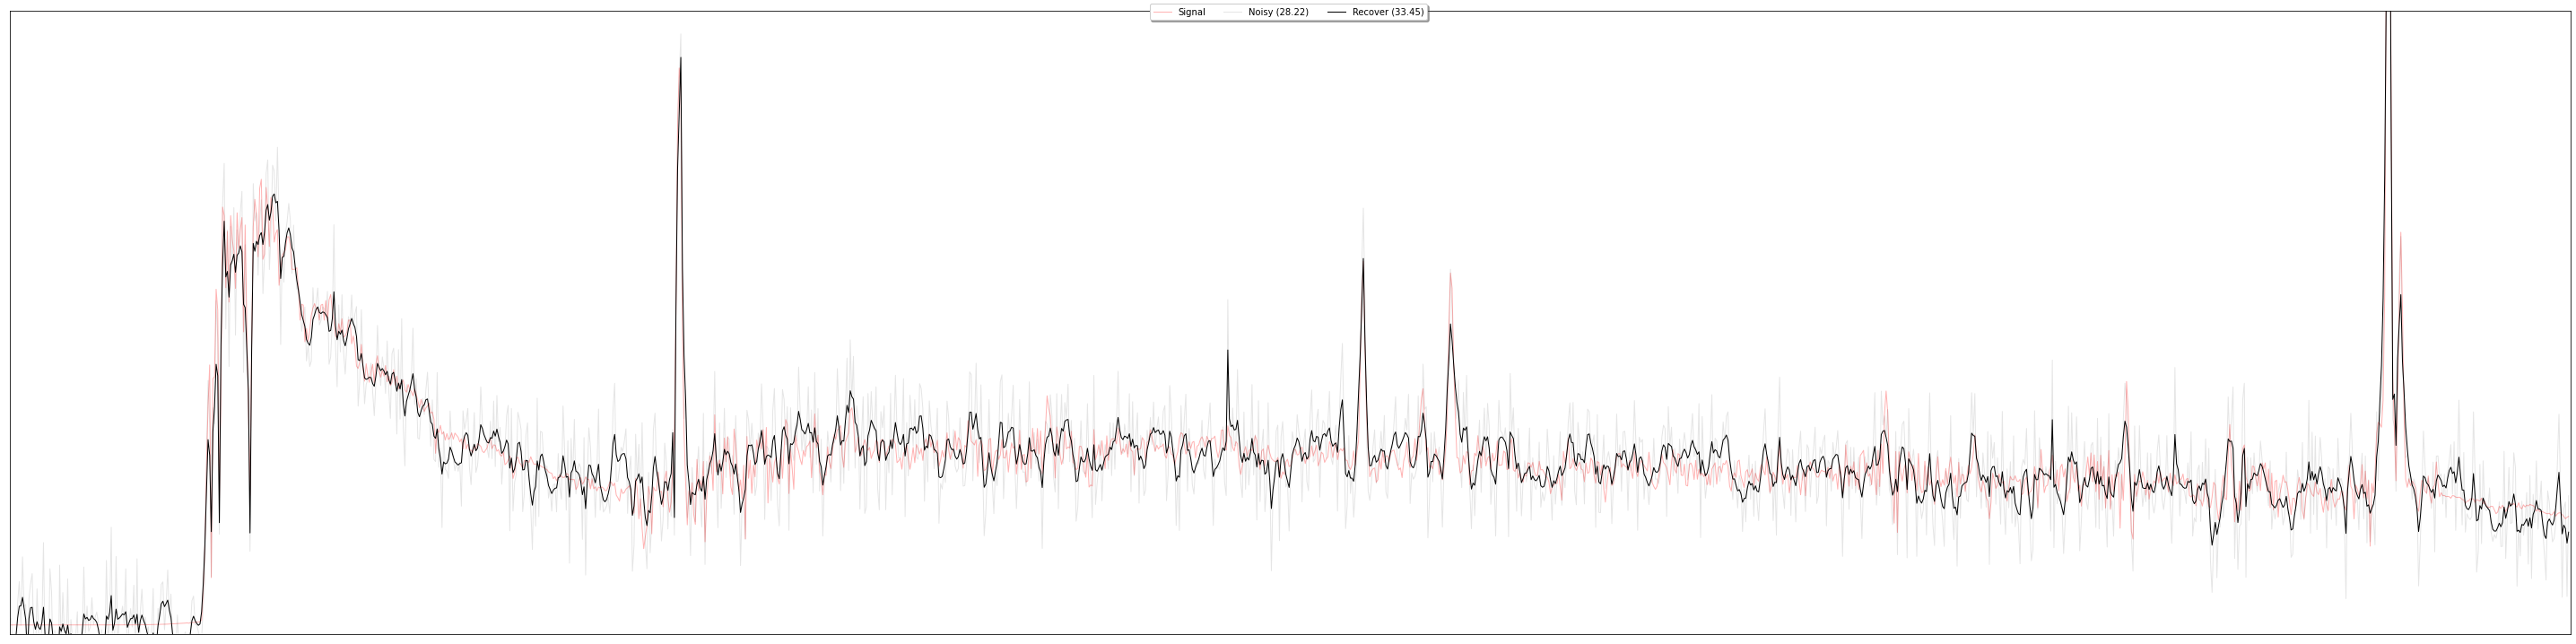

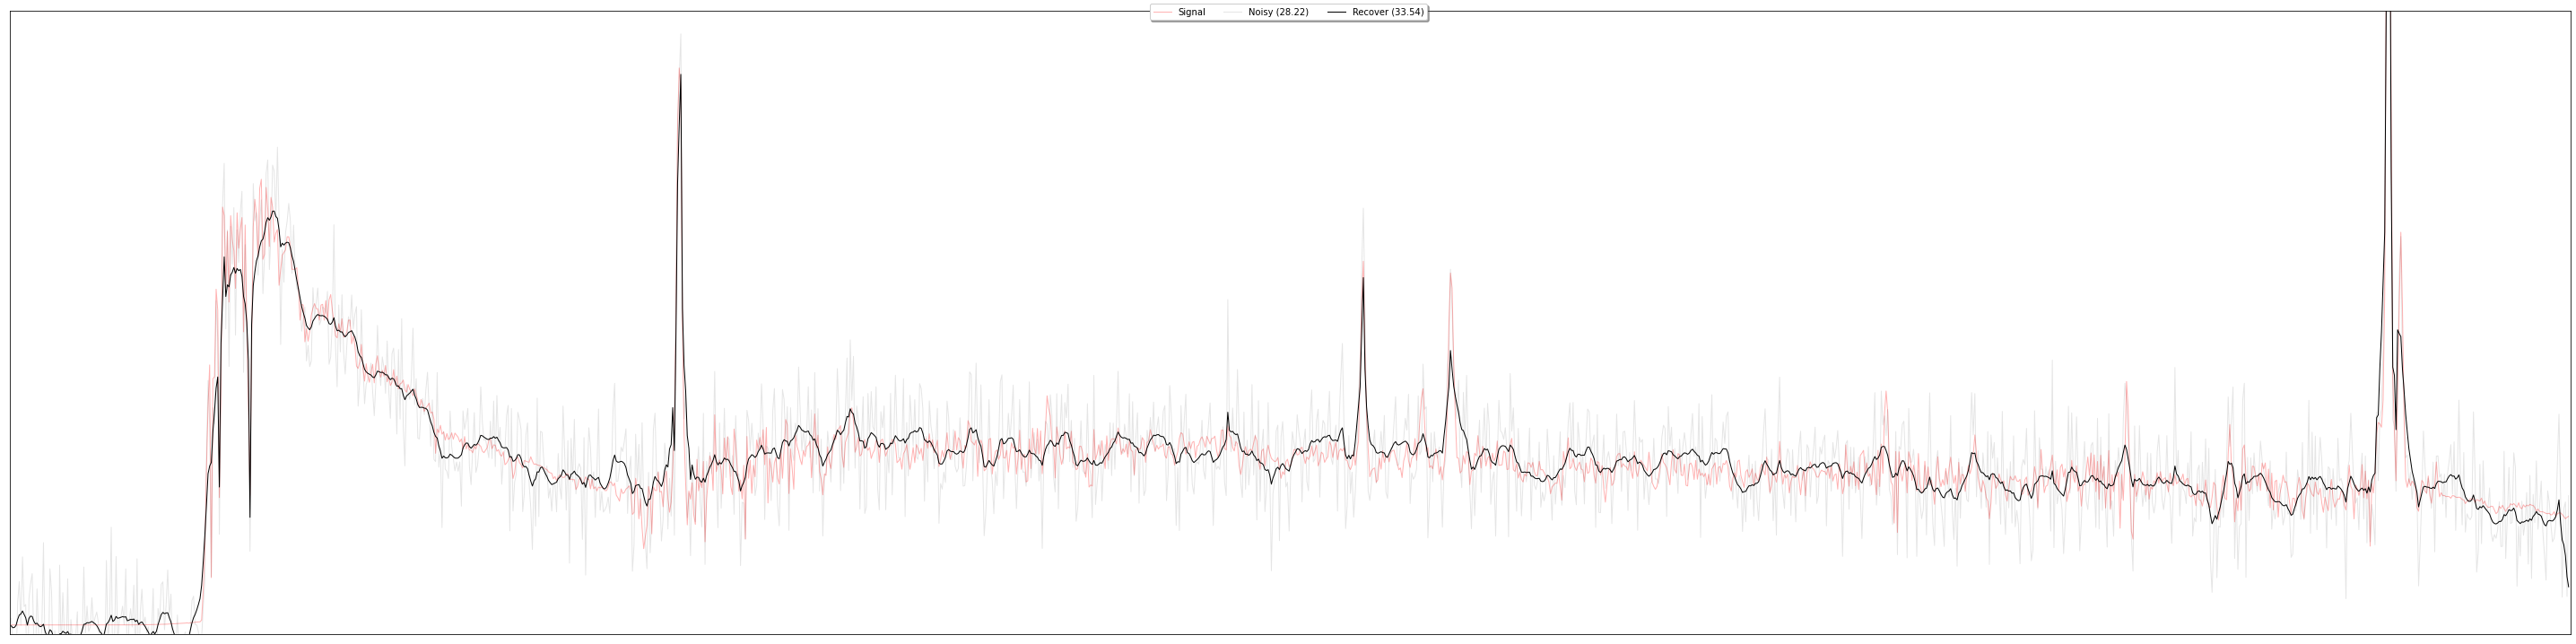

In [578]:
show_results(clean, z, pfabada_results)
show_results(clean, z, nfabada_results)


In [530]:
import base64
import numpy
from PIL import Image
from io import BytesIO
image = 'iVBORw0KGgoAAAANSUhEUgAAAgAAAAIACAAAAADRE4smAAAACXBIWXMAAC4jAAAuIwF4pT92AAAgAElEQVR42jS8y45m25GkZ2bua/8RmYfnkCxemqpmqYrFqm6gBGgsAT0TIEFPoHfTUE+gZ9BAgDTSQFJDoEZ9UbGaxcu5Zca/l5tpsIKJGOQgMyL+vS7uZvb55n9dyxrg8cHfPF5f8gZCYY9qJgOOUqx+fp/CLGQPqnE9tik85Apd1Ms1SVgQcN+a8RRtPmLs9fo74I07FRgpqYCZviuB7sKCcyHEMOaAWztVAJ+4YAbx/eRzhomeoQnItYVOGQkJgxqgPczCEAzIJ+fCoIeWtBvcC6Yp+L4RbbUZD2TpzohjwiECMbtJDEOYoVz9rBpqu1ztpYjAdhs7ECadG5xhMMxcz1SUEXdEK4nKSWUUGsQWNWTImBUYJHaFxvmjAE4bSlDxpqasAXWvcaj3J1dBqDARQgSclbgsIEQEIJGbG4ToQf0ShQyYCubC7LinlEq1SkiMqtcvfvjDj7oJ7RJU/bjudeFREnpVcPUsOusuASwaiICuQi7iazdRfVEkiqyi0+ATqV4U6mqo46UpKLsLb6k91ahpMvJd2yTAu4BKQYwI9K6YZIMMyJmelHsxZx0uOPGiGvsKgg7Jq5OttJujGCEDJqIFpEkIgkUzTNGsKNSLGXKHjVEBnLKlCAicitXbJhEMRBD7J34DKKGwWbBFuD1nSRlA8ApoCBYApgYyYTKgScIIY7gYhBo5NWKKYGAJRAVwAFkJAWAqHQOENjkg6AWQQlD1y3oryHwpPBboYdOoFNwwTEZVKv3iXz5nZ6rFAjeI9AKoh1gPQmqAPx7AXVpkR7VA5PlQOXUBukpFSlXyEKDRHlUuYdPScE3xet0zlWHvIBxMvalGMh1yEwGU6YAiN8ugQrAR9aCnEMEhVDWDqvLC5hSH0sDXZBJyoN0hFCZgzSg1KGLIIUhibUEM5K66oWius7TIDigD0C7SCDXBvsplCzIhfr9bkeiYQiCYUEpGIwJFNaZgaUepYTt1ljWhSKTNLvCWmRTvVkKmaJNMk3RFZVIMkDDLVDgpEkwzLIRIQNeIqF/kqot4XHjZXQOKKEBDCIYhUbTn0ze1PnMVuRpkV1cpCFvFj/sFS2vN3323Vw8vtsRaJLp5ycsCn3rEepAEy6OYu0Ily2ZtQQlWVZWM5c3iZMYru2GBIQP5fmTL+9qoQKi7AFl1dr1QKUbcacG1a0rMGoxsP7ITin6OhQ2hYxIhUGMIJeyaqFDugLQkACQmNAw2CpnCTbpmkNCKkiGjZ8SMIwUhKYQLyNlnZicsIpIswEUnDSZdE4mD2iKnIEHFYNDnoorOMQdJFQcMKm4CNDGURjQBVCROsVIgyyBBIigSIhSh/rJXPTrNx1B2lqEiz7eLkyfFiwS++/6+XqbhZvrqi7oUiVnsO1E1df0uEsWzZ2tXP/JX/+1vf/+ye1BVHDJr9oUtT5VVLQzKtaaEoGeIIIVRSoKbdFYDOSdqIj2nJUzTJNoyOYILJKnpBFTSsTidQlZ5wtRcbpAM9g0HXtyDwDuFAHfpTsKKeH/4wfeEEhU4jQjiuSeILfeTGsULEziwcIvgXeEAOSsAcFoOgrOJRJM0U6E1yrVT7A2UbqO5iWUUrRQAGALr5jSDBphYhSTSMDqXfxwrqbgGLM7aPI/s2fTZJxMxIOpeBDeT+hXZfmhUQzotmYWSQ0hWMkV3zNWoKeR8smsFgV1Xq9N6U5hrSWuG5YADR4v1+sN/9yaCUFakyJWNeGkEBpGItZCJSxSA3jcIQBmsKGQFIpjAIv3F442RoBTqTSRGKIMD1r0iqzydDbASqKChqXATTlDb58KeQt1SQCJpjkVQu532G4mUiFZHpyurQlkTIp3pFKZoKkACIhvhMDQZgdGoTktEkFEiwszaPQDFvUTc18imAjmMyTl1XOTCXSzJhdO/UuFUAgSpiQRsFHuAyCQSMRFFhkSq0kmjZLDYtnYBrF/nYq6KUuWoVqm1bKYYNo0WkksCr0ldq5iSrh73Wrqil/VIHjSu6NFhpJGmoPXCjW/+D314M8lAAiJt4SYDc0qiUNJQitxDcsVEQiWiQKUrIp4Unp2s73/+4Y8yKcB9/9x3QYxBERoxJmKEAAOmUjbTIYLQcGK4djBgRoiDKCFvoqwhaPGtSFjphBQQUVuMAJkGrXWrdmjAnHQySRRYhjw53UoJcBSPSJATynQJBIBzGWxCQDmFqRoUdgkA7IIrhVugaxDEzYqsOj0II6ACCKnzwaUCafSc5wC4NwmRPneCwPpVr1rF1pLDi4XWGpCNRRUag1Z2L3WqP1Rf6wEUJLx+WOkqssSlaj4CVZSxFqLoMX7Li8YGIFpQBR1DuLbkUa20paO0mj5yZaZL7KB4ry/uvV6SIICcTH/97cuozbKhZMzCFokURG4pCQViCqrIoiXCLAFEmUqYAB5g6V01bhAekCYSdCXNlN9VQgGREQkCwhCpKZ+/umkOBBjRQGbIUAHjOV1aKWSiGpZJWFRISGbHcizgzzJOExAxZSjoEQkkKoaIZAOEy5Xg/DwhIkLSosUtlHwav9aEmnJIEUL9CmAVSyvPtOIyVCVCUnnOxkfMTlRXe2o9Oqv69XpZ4geGaaOJNOvS3tpUmr7HNbtzY2iRkFbNxAnSyX6uR5UXmSk5qO0dGKC1wb4JydivVS+8d1HDnR4LKViBVbyz5lRY0lTGmg02mJwtUEoZpyErxG54xXAS0NGQmIapTHSOS47+Q8xEQuikQx3dfYR7ASFHPYrLgcYJs9UBqMZeW4giymAJYcTTCkhJwbKsRClBcugStxAhJUxRUIgwgIRUh0gaJl2wkBowQiBRQUGKFRajogVRkAGBYBEKzEL9FbJKXKv0/IG/+/FPv5ZKBSxVRxuQMqDZbIjdrTiVR73y6kCqKzbm7E+MGFd3PHY28HSh3N4s2t70rVTNvfkx4KIUuuQLxCxHYbJT3KXidCavNZ8n9MiCtblGUKUYkEoA5tzaooCS73NjpwgJEUOSY2uDDLcxJqGQiANshdygV+9A7SpMAjboCEDF5SiCl+H6TO5YEeIcVWvEvdWZYqK4IYMoEJqCQ2ZOqS9cRb/WZiEwejZlMd3eTSYEiOqZFWRxKg/PKer+s09EdsCz/TfLwCjIDlsDg3xffys8G4FILAhg/bLLVS9Xz8v/wP/z589nuqJ6NISUVzgoMsl+Fni03Z16qNG5tfm4XpbwNCi3Z5GoS40ZLedONAyckJu+41zP5s3H/sF//x/+9JG0IQZwb7SRMrxZx6lASxzquw1t2tl1o8mUNRq0KRORoYhUvAR++smPvgHL0QIH7BnWOXXOLL6NtSMlLNiFXawsmD4F/Lh0MkrYmCUkRGBTGtUgj2//8/56ee1SCIfcSs4VTgZIx0RUWWVNygXgWIeEFdrsb+5LEVXJOcKksMmw5MXk/GQqKNUTWBbZ21KJIwIRArpRGjJaCQXFBQh17rJBaU1BrlOX5Mauv2oolx7y42f/7vk6ZvECGLaYwuxqg+EET2b2y+L10qjWC557zVY/Vn/avblkUauWwJKehHwT6lG2RHsAst4e4YX74j9+96ILtth4jjyjFcTtqpjKTjX2rBufKnCE27tNQXcNAHjKdQ7LOVdT8Bi8bxBVdbcSAEDfSGhm1Y6clkeRtBWKx6ENZHqdxa6kYaeUvB/HoHcUMoh6bvUIGQGKearQQFsQCiCZtoxMcep06FV7ZOEmzMe3/TC1mVCStOXhkICrbggBM4wGsTIYgXuqeD4O6CEjwiBqsjQR0EAFMo/NGylrBzBCSznquf6e1lVV0v5f56OLKk1mUAlk0BZLHGjwtHnfrirp4hMbz3l2jYMuM9tr0S9WLBUtKkOhwBKNIBZ3DW6rx79/POK+qzimblNEOR1nAtDdxMve9JO7OmC45XJCorS5o9E4pAnBhXW9hVxvz2aWzNoqboDt5oYSuXcNVhih4BFBu5mQQ5M4HUVtMltCI6CACUtzNlQj/PrtAgCij2thgenkYhFcBgVoCjBrQCE6/WURudDzUr/5H//l//xjBEE6Ckfg2mQq8t06/RyMOr5YSDNHTk0QKILkIcq0L1phCJDcUAVRCi4ce4ZYIY+ZatavqdWlzNaPnOKVDewd7swM7aZFdDI1nupRdD0a15LJWzMvt0kJbHJdmxDIG70euOdtBPACGbEcDtH7bpLBR4y4EQQbe3uTie7AglyFx8KS+ayAk4qzORwCJDAMB5jaYixXGj3jArEYrzi8laqC1o2Z4kYZvTYE5BRmWEQKpu5oityWBVkIWEFNoeBQmAgqBBbywhhlMRDLlgnlONYRGDoVJRCAY8EdOx7yAl3A9//m3//vPwWpWVM2QQomHRENDziBGYVhgUJzuvLnxiY1MgTSLBBMqCzm+INk2qEqBSCQAUBHIEP1K9UlMpz7OQ6Ohe6M7KFB55KYIlFC8bEuVD+qSy9X5LfqXjsi1uPDSz1990LI+Wzg7Y4q7JsF1DJDFBImGaBdNSpgNnCHqp6ZuMiO0BdZuDmcs+UxQ2hzyO96pgGCwVTiwtGJKKhpS7UJo6M5toAIDZrsjlIknWaYhnYRhXFiMueugUFDSZliIp20yTVUAkZhIzVoABNGFYMkAIEWqQDF2qqwwmFw+moeDZK/+J/+t3/9pAHlyEIqNtRkBURriyHLKMqBgeyVJ95FqELr2B2FUUwlgpko0KANgq5dlkYqpqAtkVH9ai2yFWbbJqAieEQsoqsQpaFgpYvVeLnM19ZKi51en+vxgo1OrXLGgwc3mMydUjFIUqhEEgIjUmaZXxR4J/AdYxOmBhx4rEnv7cy9J9hhNiRHnF3m5Kd3f7lpZTpRAKAxIjCtQO95UcwacjqzcgJW89UetGeOt8hkCkKiypBBCAj73Nio8PxDUA4W3j1/y8yI0fvJP3dqmJCyqAB0ycW0g2mEVJlIlQ0q2X/5F08aKPKGDGUo1oYJwGqOqAIWzaHClDQAQZh9tG5cGWl46lcIxWIKUk5Q5lLdLAVgxX10Yv1ajboA1wUGKt7vl5xMVISd5iUoDxWKVXhd/epN3jdW9f05DSKFXOsTNENlptR9nLHCKPPWuu/TyksxZ10vyibt2uJtPD3OOGZx4LfWTDZnI/HWJSFkWLOJn/3+F1/+9jFhYQrtXBupY4rQqqsGQgoYVAzUjCbC1Bc14dI9pEMoKiYsV0CfKAZOrtwV3QuhBRLKWDJJQdqo0CibpMzaXmFBqRMtuzRAYHD3actEMOS9cq54BtoYyBqbx3IUHemWwEC55dSfiw/SlEy6wsKJ9hDuYpSBIu4S6bPUQckA6oQHrcQrxUABgaq/FrAmgAhdVT05afQ14HWDuqYBCgtiSyWuvtXYXRb2Xm/PdUMFDCO669N1+ZylAvVCrm3Ge4x3uWzQetBGwNoYgIYu3OfWJVIG+54EmnQKtxp8Y4ga1G///ue/2RPEgA0mCmkQC/QJT4E1EBfneCWxKiotpHtOLWZoelRO3ZqUTRSPejs3FwuA5don5gp87arI5SLUUFHcP15vLRPouzxkBiedSkSOlGBYdWNtO5HBg7DcQECWMkeQcFCoCXNs5wFSZILyri2EWZgyiGhIaRBZoPbCdMrsoAo1bHKLhAsERSaUa1Q79culkNjs1x+02R6GnfeW+NFdujYlapqpbvTqXHNdcC3atuZDPRUMzctzKfPheo+qNcXUptDjKVFzcki2RuMxQD2b4BY5o6qptCGCY7Qn0rvvJq9d2AZ4/6v9bz8GkwoUQHbBHdUJnjgl7CwkmYKLA1HZgpC1JsnxZKcwos27XAzAnAe+i3AlNcf6e68TBOGTeepEPMKnf/Hhd9dXb08NzH733UDGOZGsmJSWKZiVLaDM4B08CB0KmSKwWRSAYaE5TJrA8Z9OyGlSNmrOWoIhEO2CAslrGqhNnYNuTqkm1520Qoi3rwAB6i/Ti+3S13//b36zayxIhjcEXhSFdbEChdVQravn8dpvD+hLFuDNxlzw9dKi57k/dt+LxNbWgFDwLCgpyGSQMFos0Y7EzKC2O1M9QqVuJKDmKnUB7t4Py6q9cNfdTv+n/1AYCxhA70CIQDMAIdApatAIw4xJoUp1a4W1a9lGg7AgnnrnJIq2pAlNVnDtBURcSQ25y5AhcjNRVQl++fyp+c+zZgGZGpCUmLAR7pNwkBZC9j6ZLihTkCXynftJgJqwnqicTZ8UAMENukHUbotBnWBJ9xqtsVCpCElveYSQc2i0pDPNWQXOMk50FKZQf41P+/Jyf/XN7z6RoSomLKAQz6VyCfG0ilIBYNZFPz7s+8ZtX9wfofLjy9dP42Nmfb5E322bEGcp5tpikKkxsErWPa7ep1BStsYES46L5JQXdsGaxTeBLt6zpt8kPAsjJmjHlZTP4scFdCOKJ6yk3xZRnVyexVkPKeOFvKHAGGGiSIH0ToYoIpfik/K4B6mZclaQsBOiJB47z2PNC4BjDwnGQQohC6SCu2tXjjmUE7YHWYlIbgxW3YTKSGpjkYoYxArY8bLc5/M9l6eBNoPsvjtbp+jRYgY6DgSaZvp0pkgVoT6+EgkZ7vpVdfDQXGi+HAxSMU/16nQtVxMR3RtuoKWPw9dRfb4r+w1fLEC4H28RulP1+bvH6CMYrjEKVsx4chNxRpyLCI1qDeNoAKk4QrqwRDhS0wsTuym7qnY2Y0xn9+DdDYAV17kGqRjGyU2IAOznX87bKbI+O5yrVPC3Pga0yejPqo8mjgVMhrtQIdBGLJfB2D2NpwQQJvZhLcLd4RA0+iT07wiQRpELNLGRgs0MFmgAQ3miPgSPdzHn7GPeHf5Q4cgwE6PHHZzKZxw1cCRBIIwwRaKIjmCiUhxyRcCnjs2ZB4KkE9ff1svrduXz/cXP3sRYPSG01Vd6rfIL0qVhmwW+SAlQ5MzgGd5YF+9u5nq7w84uftof95e2cQ8di55wzkOUJLfiSzGxSRDHz4V5kQtHO+/M6r2TIqmwsLZS92yklDnMQAURcL6A065SG1NMjaBcupEBWSWGfQGPRX8fOBieQJXpgxNAHINxAawos4gtQlMGaejspgNnmQqBclQgGsVjy6ROqAhgGaLh9eY6ejKibAtUGbPw7gq4eJBQi4bcwaE+U4f8KlkyU1SAqaPzhgUALIwIErMo3QBRJ3uURkm9bIEENx3xJlC/IpJPzwreXrJhMEBxhMqFLpeBrWSmWypY9La9g8dzPkMJpceX+tSv137rR6TL29fLM0xSUW7A8MBATFBiWNkYN8LxRD3q3far7+N2wXs7dmFyBK1NRePBNqxyDDhCSNeYW4BQLDA84HUMfmdZg5DFdHhptL77rhxgRXNOqukABqddiUA5RFb8Ti6NBB1h1T95Pq/pgUKYNDXpTRxiPR2XfU4wGJxCvjANWtwgYyUNGa9z3COZMeOIrGGHQCCNUQMdDPokyfAmXGLIp3QouBCAuMUKMGhDJ6IUItfnn/1Xv+kh6txebJj1D3rudQH1dT4+nrc7sBFfkMgCRJFKZhXVGONRhI/x7l0fVN6rP7v8eH3ec4koFb7GByJcKII2c2MHdBZG7MokKd5PPjdXFIplASIMyQKBJU6gGiust4OSmpotIpT4rMyKCYidsskenwJguqqid6EJy56rqLfvvv2eGdamkuA49NbpUI/Rd01rhwgPG84AIbZigvvZR6uCceXQ1hb0Lkso7IgACOe9VzUrh1tjDa4FEvD1m9d1eJ7lcPhen0WDUIYVJYQrGoE4qYSqMAEMtxk2xUPWFH0Yt9JEHFVcCNb9pzeUxV0JQRmuv43pDz/80D9+5ei2BKAeDzdWxJSFrITNdXnCQ84uKUVX+NKzc2lbAz1jX/2ilx9+8el3LzTgx8T0nbnpshiyCTglmcl2gZQIbLyzrDZDIb7oXVTvsByUSWMKG3CGmlQZENBWOcijotBFow4MD9c8S6mkmJWXSvzpTbzP+UwUIdSwgBz60xGgjLTrRLHHuTdrCCgb1UjDOf4qo1PnYWRoaCAOYFvJgYGeUBS3BVDvjoc+/Xef/rSyIRskUCYgzVHsdfKDQrjxHgDonWspWeWqW0rsg4Q1QFlk32YxaIeomcb+jx8QyggJ3o2k/vblh/Pkqz788Ct8PwUH6otsCLQBxCuR9Oln/8X/8xL0BMpq4eZ+GXnrfu26Brjx+Un4fn1cH5Y/5fHmZl7u2alUUVNGRwozlTf3gOI+5trtucPGjBz2pBaQCKLjsMrjkbdyUO0MAc9NJZpK6JK6EFT5chAymdDldgpR5eqL+uNoovJUkDIEQCeSI3fBLcwZjeCgBh3txeisnKw6ZtURaqhhJWUAlaAXYBmhEjbsQEjqgMFnnx/8meDbP/zuDwvUrTnkoACRBbKfBE//kgYlTWN6bxkgi9Gzjuks59Q/aihAmgdHYe2j+Uj0F2ekAmVhK96qX/7Nr/+vH35bH/x2WyEWD4IxE2tXjsZSmPr022EL4AOl3rm8v/tirfX4crdJgd/v+O7Vnc+5rugrd/n5etthDG0KcyWMMxu8tafCeSnombg3CpMRBEm8DpsPTqEYp5424ZrbGiR1ZkGioSgXS7eogTAiA2PQnkWgh1F2f9hvf7xDzGElg8jvcZ1jaLSFU4h1iBsLu6IRMTQQi8yZ2vAxn1FiCCVTBd0C8V6TMTouCE8UV7EpMn3uu7n+F74EBH35VimbQBKdVB6CAJU1BQhRrh42UTAg1937VPtimA1qCsC3/1l9fQHRKCRYR33CBMcrGgL1D//8/36s19ePs+29SOg6Nug9updzs7aimMJeJiI2u+XW8uD19fVLuOvJF8zLvHyY5+PlQ+01nn19eT2/+eN6mPBGdk0V7egpc7CBhAurqqa2z2jWnt64XFf0/fqApNbtBvVsb1F3HcZ+97RxmQL3mdsogyqAFujS4XXz3oesKF2rv/3+NmQdtFtVm+/tTsQi0FtUhDnxvvbp3dfzxIKMaF4AOMCIRfR7Tu91NNxIg4EmRtNmkqimsG5EYBI6rJHmZznEuJLu+/zycY0gnUbyKFrQwCx+84uPvxcxsNoF616lhLGLOQ+AzOufPr8qCGVlqo98kRuOTG6N7vo7VuYHq/n0SNWXzDMikggcN4BsMyAr2yhtaFngi4B1PfSMF/KC7/MB1FQt8ILnuT4g9fqnH/z409tZ3tWMNKAZ0pJbb7VctRADYHmt3aJc4IdO+cJOAe3m3sndN6Jkc5SRR7vDwIvvN6U2a9iKdStsQUXgAiPtF3/PHJGFY7X7Oj7QSckHPSf5EYXvFrXX5vtUUhoJWVDZkRlQwpCh2UYDNYTJ9q4DJWKiAO+8gDlM+YhfGOByhCOyxUERrdPzFyjGEpA6USI4XN+8LdoEK8MjgMOR0p5GklIA6LJdoAsS6Zg8xpYYGaCrfg248vSbWzVqjieVbKDIDYTgGYkRNxohBl1mo3H/pF+/esHX/jSP+tgQroVWkmeX93z1uH/6hb7/wYc/MJFG7zzDnjESz3gKbwrlvm7xgak0X0lWPf+bP/xuFWfaCQUDScaDJzMcYBJRs0DV1CrKQC5xLQ3dq4pR06hiw5117b1mVhLmEKEnAI54inSlidaQnZeffnKAToSTBUVy7a++/MMqbtQOQRz4CXLHhSFhjeWyIESidAi2YGPNmd2c5hTBMNBNPcuYqQ6jYHGK51gjofCDtyiMBbQDsBEOdRrLiheCEvE+pVKSwd5gEfDxHxVrUABBK2T9rb1rv+3dAZIhIZzxY/GGXSarV4nFNKPdqFODdpr6+NXjH//ImvW6vvww18e3O0xt9nzzmB+uG1/8C66/+E+fFJhC47kdIIfhOeEF1HNdfa1C6B5WGLre/nkovPta3IDheC4Pd+sAGSpUvcNW5wxvgIKTahJTMroVglfhA7+zUydED8gD+EMJVLVJvo9/KWu+uL4dMBDhFMZoBBHhADhjlKgElZOolrNAMhmU33HEcNNeJ5g3iWMlcepwhp0DHZx8CXMiUcnAOfZN7DeNCQUC14agtHBNwqBxxAtrMF3ICZOJ9EjjA8zqTBS/u04imPo7YKmvJW+fKaplxAEz931Yw6zKqsIQN2RpxW3K2evR87uvn+aj1Lj32/f7Jq9CFzz6UT+fH7Ve/ul3T8xep+maM9U6hXAADKbZdafrPRoRXDXiv30orkyK2hAGOwhzmgfyJM64bl/VISOlkGRNpBzWvvpDTdU0u1LcM1RyyD9SoCAsnwCpjq2Yhjvoz3/SiWkAGO9TPIzyfYPRinEUwRmIP/9/GMA+TixTiRwSlkP6iA6eLfBe4IvzPrn5Xpx05DqiRKj3eXUyEFgeBnnXLTo8DHtUBKNqWxTnRIUYoHZhQlqsvHtT/fbWRv06vjqPk09Yqlw1FFgzm2E3isUSx8ImNtOFM2xS7ObXXw8Hj3m2v/k6SB6Pl+4iPqDni5evPvzxH3/3/928bwLAHcDAhiZC3fug8uhd7xhjQ92G7P1lJgFRUwlr06Cd+2BGxhmTW9sPc3l05DeIfRFkQ60COnyXXqCrDgU+R7wJPJT9Oy6vcyewnKb+PAE0EFlJ+ry+QZ0yw5jWQY86Z1gnnHO0fGb/z+QX3QARQshyAScneteehlFgzakjC+Ap7Nx/7gOVBqhMn5EAnv4uZxpM75wdT66owxTWMRjPsHBlUuclHC6Q+wdffB/VXyN4wVs26BS6eiIqGO+giuW6phVdvmlsmZdUrgZKxjPjQHb0urKp14+reUkf88XPX378gbm++/2cl1AMk5nNLe4zCwRy6rz+gjV6s0kMOpgkT2BfM61TBcF1PzMH5A8DqlQrvgbWKrPjIlIXFdAXJAgp8URpmuu6MeRjJ4FUYxC2IJ5uyWhVkheQRnQ8RMhmWUElrkgboosN15kTqmFYOQfdSGR03l/TkMc37sCio62cSIGcAknBSzAitIEOG09ZCissF0PXLoKbw5JCRZ1QPlm9FSh9Ugoy9d7wHVR4/4QAACAASURBVAcCZNAkk3gdiv6f/ssf/d8fXH9DOu51Q4tqCDNiPDO9mosRLYLNe56avPXL8iOiWcCqR5zbC/X64Sp/+aOfrfu6Lz4e9cX66hcvv//6zvjNW2MdBBgWQ8AKytYmL4z3vZ/322NdMYQbY4NLXsoTUQmfS3f2CsOUe1cOnhQzdE/dRBrIOoNtnVXtGrOHKLYKqOft/fiL37YlcLPaKvL9VQBGMwN0jpOIN6GUeU+MYaUoKagIGuW8G4SYAAIGJY7mRCTWBDShT7/y9w2avgYon1B0Meu8HWZOpHTUaR08hE5zeNRHQyMF3ZPsPs6wgqAQ2cM1DFiZLiuC3gvEHZVFROasg6KaeP2n//ilUX9TmQ1+GqgUVE/z8w3TVaxVXo0uS/60AWN3ljFAnOXwWs5z96q49zevX/14PR+IuJp+vH77h3+P/e3nT/QOzgPWDN5f5THsRIkfiDjzOeD+WGSRmf0BM3VKpCaWWHxDmVEmYbkLX/T7wBOzNuFCVFOCLmWxvHBlIhkBqvj5mbF/v0zG3Se3c5SeM/ARUwBcXCj+ZLaFuoJlAYx8mIG96ClIRioZcRClCAR77TOPhSikhPtvvv2OdBH3KUcsiA5jS6OW0SlnIPn0lIQS0iiJ1oTxpWGhglKU/5+nN9m1dNuStMxszLn29upU92REZBFZRYrsgJAQEtBCooEQL4dEgyeghQQPQIsOpEQH6CFIkVJGKqO4xTnXz3H3vdc/hxmNsTy7LpcXa/9r/nPYMPtM9mph3jqem19xJreQEyndzVNlsdU3h2VEdGVbrH/cRohS5IjlFQ9Eaflm7KJELwM0WibWjSgjp6pt3vL5tdd27g782n17rlz4jnr3zfPH//sffvjt1dcLcGGYKWdOzdTqJ3dXDrejPum1OuS+33LivjV7YaXwWmZhn1p9BOUA8UZvGbf9irZxu71WNcANsApa9gqyAG2AvE8Am/eLsJdlFNVzdfyaxwUMUUkiq3Xd/pNPf/PW/XZdFQAmF82upy5fXkDOIiLQKqxW2i5C9WSEx4qynfP0f3DDSGp8giCT8sjNYiWM2RN6S+FUyFYFhbN4Up50YqNoouRUm0SdFVXAfbDUCBdJ0OMMCZssWmmAR2mhrRMay6l/WjkDBjMkBU5jjYnydG4M2I/0oQV6raju1DkG2m/3pya6nxfqTbdxq1vTqvrh/fp41fn85bPavtS2GmdBKHbY7H3l2rVBncTSDt5cX7RynUOFvIJdz/WZlf0Y0sMRZ1Wi15MrWWdhv+HdS9xktnkjcrtEkprMCINRKMbB0dDuGmoWbVT1CIjsCh+BVe7+V788ATpfKFtGFOzg9vS55o0rBKHwuNefDKmr+9v7KUCj2IH5gZiEDWeEAfl0VbIspRoIRx5ixGo1xRq3bgWsCHrEk0liNumgAjY92e9yF/lgi4FSOMkyAOoqJeAE0OcTUeovSC0ZZMYuaxGEAdzvoVQLPQ+vikS4CneSsKkLH+pcvu57m4qF75loWV+e1b98uj/9+nPnlc6kWNTmxYRBk7e7Iz+1OAP56hsiKumIZCNYxJuqrXe4SNblXGtdG6oEaxm3IMyzUJeAQmlj6Xf7CV3Swmtuox2TJRF99SQE17bnu45hfzAE2WIBXvJ2N08QGws9bJhxbVxfdmONlVqPOcCEJVOAXf6ZQgHAI2zqhkIl/RjEKMuU85jtIaAonGIdkhhfqfg1x4P2TQABlimNYAO4gBRjEpTECQSSqSGLVYwMsoATYBzOAmDVPxpFICaaGFMMYR7YXc2q3U9Yz9fxzjATiNxoQ7q7Xz6778cyBHS9f98Xrlqvp971/e7PnRCX72aO2moXPPEoPYLdkBGkKEUwdwwGi+pxQ9a3utUr3z3XeQ1TPdS03GTmyQH2063W7XrV002h8PY/9C83wVl0SzWLvBUgnW4cQ36tidFh1A4jw3ULReGR8LkxY/2hpUjzyWLJs6bhkRqFpMDx+4EGvGLlBLPYhjOeghaC+QxG9RmldR6B2UlnUAeDeBnhFqNbjG7QwGR9QGZTsOAIMzzOBWLIIzMhjG9MZptZNKmKgq5y1z8+zHzniZWSRdkwnQB5quIbAm/u1zozca5xuVwNQzhXTpww6nXevGnldIGqp3V8785J+nzwF6Ubl3cuiopoNwlJiZViPehSxwsEbm7OKJW1+l6lJ722vJoOgb1OGGZ77eUeT8H14bml1w//0ce//P7Ai2TpPC3NLjg8Y69bPFx4xCO+CoKDJQKV0BLQi6cCdXmWcgLV29Ls9thyZbGMiRVvgKcaK0FZTgEGsh4JvrCia6Wp+ZkH28UWwGp6pcHALE6Y/Mz9jFTRBBYYzeUfDOJk/GsCGy0Px0lsIAs9fo4xR7qIaoSm0fP2UP05h9gSt3sRJdwmWGY191rot+9+4T53TuaM4pgZ7qcSp171/bkf3GKuJ17wPVzP6No3NU7Yq+/7fuL0MQLEbHQbtrcOjVNILjWClQsEClZdOyswrX25EH82bbYqWalHEr+K55DPz8TTd+fN/uW8wb/85c0h8rwoFi6xVIxRdOhaXTqPwBfHJ9fxQNtQXeuu4sOSS0A0QpgAO1weR8vc6NTVa272EXw9IQoYrIc6FKhdIZmekY5a6IhnTnlQEEPX8tkj4oamC1RURjHwQ/FOMTTGE09AWF99Mrq2shEsr0FDpcuoA0SWCeoU6ENmncWj+vuwEXU1IuYM4gdR2NCW8Prx5cXrw2eosxAsKjfhQqGPt8XnX78QysU3z1SflJVn/frh/f2l1Mf3e7/Yx+2Lg22jDsGuq3IAD+h0NVqSsKzauraqi8EGmGfSL9e1DOBEkGTJB1qKWs9b75++/ZPvf3z7mx/ypf00Ga0V4Vbn3G5i737QaIezklSQkFGF7s0BC/VDL0TvCRAT9xUINDvDmTh0qXyznQJzlDJlU6b6YTVXVqOcGeZsNVtrEkxkXWKM+UvVdW1dKjCYkG95fhu8AKb0YBu5GQlZZAoNXGt2OO4SyXCbxOI1z4paqKGGkb0sswB/2QhTP5J2ucFHdnnDtKPWOlWLx6+/5mXzj/Xyp+//UCnU0eJpG3fdQvcfu7l1+e27czsHq+r4/bs3zZd0+1zX5Q6RPmnSR73GpXiBjVUXvOPt44XXYJfs0kN+pm6V0839qus6zmvX+N9HWN15u76szfPu7Xf/8OWj1pu/+OHptWZJuq8sKyBXKq95uWlmkT7VqmvtMFyjnaWQkoEqsOhxwoAGV1gnocuE6SOtsHU0/lMy6ypyUJdpgZPD6qgrIBrBw2elU1iDL6yM2E+moMs1QbLrBqW4ZmMnqksYl8pXpRkl3tpGkbtRF+WC0gIp0uyuwURhB13uPMJWZWT3N3/2uwJZf5o4xnhhBdUpMJ5LhyqNKzj4/PNq4XwBtYgo50LIGB3g4Har4k3P+5IXq56AN9/6/vL68Z5z93VwzkmjU42xtwr3wiomJZzA8sqp66CiRe4aNo3kqPvLy1ovLyu9UHMxTkfeqBVvuf7O0+7zeqhXfvvPf/jlN+v6TnW4cP+ly4cCeovmvTJQSLgcoLrkM0xmIlnpCfLggoyjK7k0ckkWAc8LuXBu3ZhbhLo8IGP2uqSe8CUZo/L1KoGRkJxIUTMDwOtdXu2SBz9FpRRkEZCCNU5xRF1Mip3Fk4vLAnKVungRLIrAxkg6YCNDzeSZnXcgOii8vH/6qArr74wPQ9l3QtwYip1NoUts8H40rKzPL3seVwYnqVkqtOC1UBH3UwBuPt98f76d65df1pfPry+4jtWn2745gg7LTobzCMZnbTAs5WCcXMBe6lXS4VVNn5fXc936/j6nUoTttbuq8FRO5enozT5w4Wf+wzf3t7d3H755fx2FdyThbov7CXcgAe7UMXtiarhQDQssD2u77YNIBz05MGR+BAW4POFvrQ4XR4dmtnm429VCz0/jQAGiQ4eeyM0NTZQVT+SK4mLmMmAsRc3xnYyuD4IEMkaDSZwNbyUgj/uxToHKkcJtBbCp2t2rZ+nqHQlWFCxjf/yr92Fcv8kDLIFlgVUgkW4PBjaNkztNVM26uEKajrGSvVZy6s2Csnc96QQ3svj68bp//OPPvP308pqXNl9NXAiQ+TPaaEHNYtAltJCV5smk9ST3DitlmG1LZ6fX/T701MJGWMoqGqr1njsvOh/0mx/2H17R+NMvn3qgZOTTc/Hms99e7vju8/V0mXEpRIGe/a3W4yNP4ZSSQ/ZAxkCKc5kCNi2MsZTmI2HNpHhCKuFBDQH+39m6AgZlSZ1iIj3QViTYtZhT6nmxjJ388QzMkIjARUywFdnthYQPIFyroIenfIwLNwBq9bZmA5MJK4H99O4gRP04/zYSYIEs4sT0egSe+ktOZm0Xd2BuXRVdKUB12xJrr2fsp6Viqp6E8/nLxaP18+effu0+DV++CsCbClhFuDQxmzqc7dggTcEutYP9yFV7LwdA1Kz7Va4KCPtUnAnhbob19rvb89v76/N3b9799Dfnw/5yW7/+/pf7iSt+sxaeEj31/Y6+xu03vD9bzCBZsUAMl6M4qBSQeRB3HuM00xWUQY0F7+sPZ5wDTTUYlVVH1KnHAjkzsI8THAQeOUGlSNGEirw+fPsrKiwFY0ENwppdKFDEWP4HG33G11awK5lJguXU6tmH3KMJNbslDD4l0jEmaSHVD1bS0NhPyQQmxmZHiX3oGAASL5j4yqoUSZplme9+mEQahDp6ub5YWW/4+vOXq+MuPEj4VWZh5iEDro2gb4usM/orVIfqNZymrBRHKGqkXRATmi07WDmSdIP9dsPP77/92+2Pf/wYwW+f/83P9Zyi8vzmfS7ljrA7HRQaOQUnoqnUGDEKgCMHacKUBvU65hF95UaayWjHo9ERJRiMozVAsEDjNFjQJc09MQLXiLEtcLkQspA6EzXv4LZexJ3RciqCVAMVHUipxv2Z3XqwoAY8Ca+z2AtaTFOGQdF5TDYjMntOFm4rQt+c+g1isiw0MqiagBmYgAM/RmDNEn64uf0It7Wo+7mCt+8uH94WF69cWP3lOc+6nxcfJ3BFa7XGwTG5NLSaatw8WdrBxAYiFzdZQplZ3TqrE5jiHcyhZIeBb6g3681TPq3bs1y57vszfv5U93W+3H753ad7ffOO+PK0X0jWF76rbl8O0AWyWV/fsc1wkEij7y8GEi/s4lcK+cwHiKAdzlEUwUujshbNmF1qyWiQDSV7ykYwpAkyqOxhyjzUJ0jqxaTqD398V/LkDHiRqlajWliHKgPWmdQbwroe/E+oDHASgKVx3DZNeCmnl3CAylgheRXK3hdY3wszbYwASrIzAm0pnXUuZGw29qQdpPHDXfGlc7/uUAUv3K5aO7Ffb1fr+zeNnz7d0ce4HT2wHZDQxoG8X4qH6C28apPWXuVi5N5aGxVCZb+KasM8mUgIwk2gmPB5+f1Tn3f6TOHOty+3++tJvTT/+sW49PZ8JvAlS52nD9dr3+9JX0HzFHxEiHxk+vSwH3XZRXSGYVxnFsrLjDHf4gWHSXkhxXWtgbBZ3qfSFISwfOq0OVuHYdhkrLxDfl3Bws07WN4p+J99+9vn19WRrkgbpswkauzGXCNFQim0KpMxVMQ5k/d8S8XoaGBmHQhWsVOSguVikpLs+tE85Y1oz//AYarNliw3AmMO7HEVoziOwe4Q95Nsir/clF0LJ4mr76oPX15++vzqpl8rK5q0+4odQ6Huu8TCRhOxWs4E61CPDWeFvLc30ODhMaidXi7SD/gwqPdv/ki47uqNfvPl5z5PavV+m6ynK+fN09K1frq/vR2vvo5Pg3W+ZgfAh42a6zAD8pLj6lvCsw69qLJAGJZ8Vrg8sL2V97/9+JsrQE9IaN13q6ZpBs4Ox6pH7NQs6YM5BfcMZeVbs6JGim/8iWUyvZOCENVZBPKofZHZ4WR2aKB6HbGSpRoMLCuKu9DLqSTzNsPH/xi/3+aQogkxqFXfiEglKHsPOhlrPC8IkHv3GXcjA8MI0RJiuOMrTtXdb05p1/1CJwcv9a7686+vTiculwJvXYl4iFA8DS1gFegOSuSqa6h7yr72iqJuHr32gvdpkFJC1qPkBxQS7R/2eu03Puv546/f//qTca5+xdvX2qr+lHr59PbdxzurRPmTaTvdxdQaOmvN5qxnUq75qFEHMyXQ4EDmF4QM7NwKCD794cN/88/++z+DHw5vjaeN7cWcJVkPA0N1mgOnqxSy7IiM/G3uYLVUyc+fn4UUo9Ym5WSMbkIZRdz14IDTqfRUD4ypsVGzG2QqK0sHpB/cfZx3nz+CCLxAxWzGqB974szdq9ryeco8uv3YJXMuPYNA9XpkWhzh+DTJ4jGLxbz6VE439pun54PP15mTLAG1QbckXqGbD2ATPY4sgejsEee5XCIGVITuhcwF4aniVLV4xv5W0qrc9HpbwTnr/vLT53O1+/7511/Pq/9EX/Y3X3654+k59xvh8+nFzXk5Y4KlrEI7wBA2hQYxZUI8W8ZkNi2kzNiLj84XAtLBf/bb/+VHUIEeLC9Wo6pPJLmaOCbZlQUS7TIHeroQLNQ9IiCL2LuCSkLNAyYofuyqZobk42V6uI6UodsLbNYKUFgIrYAHgekVL+bInznXyUY165RVXd8P3zuBYULCeiCHKjP0sFHUaisIfLBUp+GvSANdnVsAnz2ryPKH2zu91k8HQ60Ir5qAjO1xwAZFSGRYSzGdG6lWBrGB4PHtgdnVMGDVHga4J12cWniK+Xe/1fetF2N/8/qH01Z8rFXrvm/cF57esqlcTys/vxjJg5W9TkGUQpJhBlg0RQogvrI1jkC2jEKM7Ba8+DAM9/P6b//X/+DA4YwMSHpiXiqpB/64Z7E/xp9KBayxjCFgGYern97/qkoItM6DLXFqcgfFbNfcGDs1abgASE9LW6lEFOrBrwjXBU7cPJVE7seDN3/teM6qvpuvA5oswXvNtFlAYaCrVnlVSA9D56kqRWANozeBUdrW6p0I4E15+nl/vkv7anTHuDI9KA1TzlWoVBXZEi8VtkW0jCG+l4Qi3NbO2p4GL5CN6kTscipZydO+f8O/+fD0eb3Z9ctnpjqwj939st5+uQff3HgdK/n1NTBy5rsVGvWg6TyITUDZNAoZcwfjBbJ3qEuoEM0ishJ2kcxf/MmrOCQmTbEbUAZktT7h1i7DJuqErDXbfJZrjggJqWf5VoctU9eKMErV1DxM0HQkoe4sTq1DgGjAUKSEUg94XirnUWozWGvUUDTeXuYiBWGFIOs3OY/NtGoSKwP3dAnmcA1LO15A0FxPb7n2yEZXQKXhZOXG57re5AB6A52+7gy7rwToU+3EkpRO609e4AoVcpG+yYAqp2SStfJAAT+Krt4e3djy4LiZMlYet5st3O/bH17z9s3K787s9pOGL76e2/Ptnc7L083X55s/nthGp2ryQ7GWQcA1gWu0MBl9DxYAwHLKNZ5BBmtwRkh4rQJe7qzn86gdcqFonckmy3/qO+GWiTpTxzXYc0NjlNrpQqF1P4vKDW55gTFQnLSPAFgasFdk8oHAqFaKyNZB4VEqVAVP7DGNxzziaGIf044YwLUM1PdISm1ZzQY2IrmLR0y2Qdc429fTen7K01tVpt6IJwXjiKqUV9684sajt/fm22XAl9E5DhJ4AOLgYZ7effEC4BJcVurURhOY7EJli0QTxfuqjWWuHBee2iB6DTppUUytevsnH75YSe4fE1xEp3OVkZePK353rfN68nffffm10blY1Xc9UnXQKTlCZ5kJTrVwJidAVPRV7Rsm50OG0kNUDQzUr//nn58HqngwAdLYyF///Mv9MaMVak3p1oAcYsgbBruCCzXbgvA+pIDUBXGc1EbVLM1ziKYwCvQldHnIxlWcXB/lk1HdEeYIWDBSWX4h44cQF5mpb0HwrLDARoNYqXAeVQ2yki006zxtPX/7dL9QuPg8/JRzRcuhbiw//XVVibdazyeIczrtNHVZFwRYr5T5M6YQYRjHmkRODFMoCEu1ZKon5lf40i5Mzo/Bfq2gs/uWhkv9+XZ9LvLNl0/r0d1wWV2X+uX3X379bd5/eH735/uv/5p5ra6kZ+fLQ87GnOmdrkZYkMcuU/QyOb8M0eWvN7Ph6YkDNf347/1X/9ebBhHU6gyiISC5fzo1UC2LtiJWSD062UrIGnI/lB1UdBGlaigbwGLQqtZojSj4cUxN5L++khCKJ1STOgnGNDDpjaQsqszICAqiYBEw63tHTciUy88FdHmFaYBha7FA09TlY+O8Wk03+05mYqfURlR4w3/54X2eJXzJfvncr9frdWpMD0cGk35T0X1vYoougSuqYOc+ZRkLy1XV4TZ0WXgqAoOAgBAmfjvG7UdTJHj9+syf3j+9/XhxONyArIO2deHl9ZfW86//7291zjKNyNtTtgDE6grQorGZG84I0URIBdUYjFz1ygRwBbBXvAxb+uM/+vP/7UcTm63Q7BVSLY0h4OseSNUygTtQAKoWwbLIWqC271VliD0Bt54GEd8Gk5aUid41uDoEjBywLi3EexY+w7vesprGmJmFmPA6RYF3BnOIlepbMcb+zM3oj39x+/2+oUqd0hLOFhj2nIKXkT7q5AS4TjGBa46P5w2dH57+8M3fffWbxeB66b5g4hAXitFFtxj7Mer2Leypz1ztGJIQ1gT9C4EkUALUqtX0LafYqvPw8GdBeVat4xuBP7xODS8DGHIM57DuH//23/6b1zpikjKpnlYnh6kzD0EjhdDZgcuP8J7QiRSTnltIvGKZPQ4rVr757b/4BxcWTteaxLo0wt8pOcumCsSkPV2pSEVTJgsiktWPe8MLllNSqnmx0DUV3iKAsHoUfQ5xIi5eW1matPvkAsGTnIlEKno4nApWunK7CHLb1awfOtB6+ad6EfP8u8/PK9xJimuQOFhGTaOyazzbbkR38oh+2ad3FJa04z97d/vx56fi8+W3f0wi3v1goJd1BX3Mcl2FZKenyIrtBFietZp0L62agN3txkTTENb1tq8U+kBwea/AWZaq9AYfPv0tL3eQKzy3NA/TOAzdjRAOCt7wvMvpB4uHJptY5sPgg46UPU/hERPOwkeqPIhidB7HUuspG1YWH8RugVi0l0EyVIfRcBpUo0E9aoSlu9jpm4yGe5qGkDJSury8MuFxZyYJ2Uy63lSrXIBSHXl5Dsiv9kWwz2zNypaVjlLmWJ3GxlrfQ+D+q//8/PWtlaoR56hbiSetWRNKqFhV0jlpB922yh++/3VbN27uitCvP373V59u51z88fkjDq7DBkMI1z6AMpKabIj3m85Y5dxzzNCk15e/uP28qWeSq7CFDl74rGeWX0hGphUpE+tYt9tb4u3Tv/ncbbGJnBnsPfaPxPnaBSCBlayuWAR0ptBVqRkgaveDTg1glDQTSY+x83r4vmS4LtFCZXYdgpsCLbnnjj8y6LAanUBT7iCEg+LimtOhFEPLVsVql1M12V7IGvd/6J6AkkXl2Hr8B8loKNcAYqgDOI+8dUKoH7d5YJhSYpH1g0H2b/73L9/0kAZLYhE9spAkmNNq9ai4N8C2ZRvXj3/6l29EqTeXcL9e/upvXvWKp9v93e1zn+vEQXJHrJNJvosiesAmZXDFKbPMpGRIxCtX91SU3WTCQOrWpC8ekELDYaN8nhnl6fOX/vLHczfU82M+BpvosNhmCO1o0lJmuVcjgh2MA0yA6TzobS0FqfKZt7FRBrFNjjAKmIFoc54qynO9KlJ5eL6z0PXACjzcwlX12AJ/jW8wInM2JJKWb7depgWnALgtGGaPl2BSTCOtLAgVFTiVekmLFnv2weLj3l9mhThVsbU9DeGp76p3lz9UyMPKYhU5qjJNnUa6Ahscag3gBDmb4tPLv/0uCwSxDtH3a603t9x+eL6e6uf754tJ0+nUGs5GNZQ06OZ1cpA6Ir0NIkspsG+Xl4Fgm/QloXiSZ92+vX+5qx2NRHGTUf/6LV+z3571609JNcQDsGG64CviRSkumbCyHx0rLnr0FdTDGJSCS7bmEijW7MPDBLnERaMf9bzjA6fYLDblHqJdQcIAJkC5VxSjHokwUGqqsmgJyU5ASWtJoEnIZ+wn9+FmRquouLG+ciYwldQhozMCprqCoCdyirmgR02mVEHqGnRsVETaAqD6NnXfnteeAuKJj27BUTY6OuOKOW4ksO6jLlGLvN2kbOH2sMShnz685w3v3333+tsvuXd69epVqUe18nAmnOZ5+/SywTFQw5FcLJK1brqsilFptCNfl29Pz+vl00XYpJWhGPLdf/rx19t5fX/D6xcnRFmm+dibDWAR5mJZqFJWUwQsDEWbQ4gemTSBBuBlAugBeUR7QADNkxGP++HrMam2BuR2MVsDL7BmgmDTQ7TOfEvLYx/GaqCElB7gTYSU0eXmVblB3J4qIaZg2l48zWmFsvigEstYKAONp8uKeo6tEF5hkPQUyCkeCs5Yk7q+NcdbNfwRVpXWwqO1Wiatlk6S5o7swOXFtYgN7YLXPltq6PlZ3/3w7ulpPf0Jf/5Xn+8vVxLhIMzKgkWytplj4vwD/XEb9y2kIqWiTWJXXRapwmIhgfAKIvXl409fjGavwFOXyv72v/iXP7+93+t5f/oJUyedU/yK+wC9oulXqYh7zkV1tndntt3bTE2lHJhHutqDEEfkrkwREDsombPMmk4xjs0PXp0FWQ0BTbKJrsDLBULEclEuElqmJUFFl+AVwwLstUyt9D6cEmoZbtqbfuQM592JFmBNP1ErkwWlapYP2KvN0ZeRBdC9My3bJwOZqfp+rhcCdcTJj6+AroU6A7YK03PwFNnokqLeCfG2WIW1eq9TzJu377759v1v3v29b373l7+cV1+Nc16Zg4UtehWxg2tG/o+flxvrDmbMynNF0zoUvNqF3J7qYKHh0+f1daIU0xRqQEjf/79fsz17jwAAIABJREFU9vX0ZuH97z4TcoVVA8LasJM0oUfbB9VwOJAJncmJFK8KZ68yEjw9zKCwXlnnQa9HTyHDWN9w9kZhqnk8wWFhe/Y5fjj/9iFrwOaRUB7wzEKLgopRLapBuzr7ZInXE04UgB1IXkS6QgSKa3pAGS8jQBfvk06LuZGZcXDGnDpAfNBAVCfjcTPk795/IuoHazU1nJQpdasbaPoROA3O+NA0I/vuRcDM2cKzRK+U8az1/V714end0zrr6W9/d/oOg7kO2iwkwfu+QPK+jwK4QFVj9TJZWVmt26kK6LncuFLBmgOoz1FOIwNetOkm1D/duPa+yb/veLiAJmK5haFdp3oDa8Q2NGezGcEsKqxBqE7p0CNwYilyqyMaYxUyA9UJkGxh6C0N2pJSHUO9at71KedBsxrOFVKTiQg7MrEporBscC5liJ2OmJvWvRqyXbGhcCJht2YSJi6wGPGaqYJlaeLAnlXKzKMCuKAmJ5YpNFfknAPWN49edfEM9r5uVWUzC1dNzdm1c7zG0FX3LW/CirTqtnLjHVn0022/ufmJ++PHp7/6y08vr6/3kw7IolRqlt3muj+wDDgCWVvJDs3UONtnRTqmR5G5resi3HmAP5VWU8a1Yro2ynf92bvrrxoR5ypEGv1AiR3uVAfElJbIYXRmhFpDltaDQae4Rg5AZBocxMIAVKRQ58EwQcXkpYWo1rSeIFCrMbkveZJ8Re5JZwml6immWUrFZF2aXfR1X+4NilffLnblNgsHHu4wSRyeMroirmk4JyfdH50Km4iRPhYp0IFa4wQXHt00ShbgZrl+hMaQSWauMred8QyR1lSf2OKFAhe4e1yylpklEbqFSwh6n7N3/1L9+ZfP12tncGnSehqUui+tZWRe8AXI6WA8SSVrLePEC5RwrUOQt3V/bXcET/MfDVeOwtTYXlvn/v6f/v5fL2eQr7374YNO0CoS1Jq29ojeR5pmPj7+zNBfg+A4Pb78oBlODokAzjBUNdYsCprqTsqzOiq7mHH+6WAcNAkJl80GtaywakEllEtKVs91M8uGAfZgyLk7fFAZulac1LJOQlQYj0hrZTLWwkZwpMZ6dGdF5iEVNlYK2Myccj1gnfo+GfxHoiWvW62pr6v9aDw9j2bmh/M1I271gawqtPbTeCGSfvf9j/VxnY+rz+HJEmvdqtbRuIpYBLKo24fJWrJMDAQOG+J0A9K0CQcE+uXlcuPAU/CRi7E8DLaZt2W93n/7/1QidJVnx5PZipJbhqqoA2INnQ+HNtGQ6bF0ky7RmJQ0VNdg1fyI5EKpWHLWZDmQB/IKMJbLbAXcE4AuFzmBp842bGUs4Fhs70KmyLPwOg3w4+OI7HKqS6cAypUlTWc1zAKXg+rDf/ee1oP72GdcA2UAGPu6JmYiq4dYGI6pm8RhfYeB1SF1//HtH95o6Va3PD2tUhyjaQ0fm+OMSnk9Sph0E5T3K/uzdtV5/rMfXv76QTEuiVhVFW63Dh8V6KzIWut5vayrGO3mipbLm9zOqgVw5UDoLt0v9KVTPdmcB4ulAqUfcT7E649/uAUKZUMFr8R0oQuqie+9uwoMLjThRiqT4My0LSGY2k8FyOk8+HtTwe3i2D75UNgrYQMcCG+ioDUbz6FecJqJue6qXtHzgpZTW2d8HA4D4JpSichdilez3ITO5uxCZxP6OI4zsM9AVZqtYKU8C8isDtFBTLUcWqbO1CUNTbWxYc1IKNRvvtaZOHz5sohF3bK4kPuFzhUFaeioBQYHU47O3EpVwN73q+Gn8yfPT+/eiWxyG1vVtYiqBVKls7Fgstfi/ifff7zfa1wpUIUpVy1FJZYqPMAhWeo2GzyQJ6KINIJuLqXZruDoqtU9+/M+ZITLNydj7pK16GtVr4bOcpmocOGB5wOVNTfd6XoK9IDewMPyJHookoPQEUoR1tR/kvHETfGQFgYiP8nrAgARDaryyBkYA5FxQR22CfEuY+v4iad4H7kPgy8Yjv1038Rtqq0VF50uVk/vMUpwLTJfafSZZ4PgI5hgVpqKTNa3q9ckjys5NUEI3pH7dQ4Onns+gbD1EBAGdcwbtcTU8/UJ75+yvvk2333/+olF3koXgaqgKCKC1qoV9GMF/O//83/9O509rMRVazm3tbyisrCCi2wx2Oykiw1mdVQ5D2Nk9AW7seDdvJR2QOM0tQAeyqmgSAxSYk/2ryHGFtiMU7wDD0c68sjAUdeqDscxbqE6OINnQzgsqa+UDpJwi6ZrDS5uN1KSoyyUgmKNm5paVabXg1jPItzrIgGc4DwXy88vLrK9eBYGklphr1MTs1LyXOeRGibGSUMKvYeGZCDzOwtQIetRcyUNVzmIJKl+dHXZSFK9WIWN5SDuuSS754LEHRDCjVJxr2ytBe16bXDdvL759O1vfv2VL1DjZh/cMB4uL0GLJclP3JQWf/PTv5peZHh27iafkF0tMgcHBgdxc6TVVpPXMdwRz1Bl/v7+xFOsk0Td8kBepM1gIV1l5Whlg1OduNKLWd11ZSSfTHqKywqPSJY1beTAgD8rQykMjTWpPKJ6aLdjl0+Q5Yrnm+xpojjUqIDkAxq+RStKhcbXKLcXwFP2CuMPv3/94eV1uYN1Vq4bRix2L0yGlQLojtgOl9Mkgmy0enj1YSWUgRrVaiikKkQU26zeBlw/TCooNLhA7xvEFCc7eHQNQi9Flxb3Lu5Khdpb8iIPlF4b0Df311fnvPjqNiReBcPusaC68uSnFFB1/vK+OxPvWKEEFnhLVQQvQ2hMzZSCa2x2RpDYV10JdHZ/fr/uyDpB2KKQQHVuAo2J76AwDC9loeLpsPKQoVDpQBoyU3IDvC9lYvk5DoFMId9ExPNwfmlm/VIYNKbi4yxXPyDu8TKUrtkDfrXwUOVH0d2CS+d61Kqly2edp/3H/+6//h/8fISzrTNtxM5UWO7jsmZ5ZOFEczPhTB5dTFbQwc5h0FI09K/0SnVbaMhVXfdCp75F7IIfa+6lKkB2cIF3fSUaYjoisokNVqi1taMUtbpv71hX8e88/XLuL5e7zr0PQfjMwxUhCnd1lZ7gX7suAFo4XBUwWy2gRA8Rz0OrlNZpHqDhHOFCjpqJoF/O9Q1/AVtwW75ERzWcVwXSPerKghSgDiiZqyN1qfAgoz0mygye7V6tVvkEDNjwg/U2FR5dxjpqMXDodkDibIM566iC22FllZezkvmUTHTtAs212xmLP7VO0kB/3W3cvvyX/T/uUXrDIVG01VRvnqpE8MPSVaUgbHqRAOQ7BKQmIsyLBeNB09jkKTkEFacG5VU/TD3W3IJXaXFxRlIY0yTKFA43q8AFpcBNbq1FqNbKEvPu+9f7849fPvF6wf2iLws1Dgo0RU8OoPaqwoywp9dDHltIIc8Y4tkKIMYUa9bkwD0k7+7oCh4VPy3cPn25VSw36LhR4dQ/JrilnaWzxK61ku1OdOJCghjVg1KaiGbqYEBcYGLCocY48QD4R5ieOAUy06QCp9g1pEA8VsVbQEu2eD1cNeCGCRRpbyU927fhVvqQIdR5+z/9z3+WA7X3LErJxilydVeAsjroqTDwNLHdPKFp1IYwLWhuUEUUKnzKwzpgjpkhZzGC6zsxlSIeC+PiZIMT2VL8UOjFUGuVJIVVuq21yuZtY+W+b+vN3/snX355+fh8DumrKwyfYsS3ZBFS1S4JhsdahTziTCGHbTAdHokwiAvrTvs+9fDdhSBlj7z7mNrGUKLKBW5Qs3lOvbw/V+2kaCz02PzDqpADY8PjaBr40sBZOK1gWEHEU92TVgLWoOGrMzWdj9UdBE6THCZRkaxWurLgsB81b8ESgOD/Z+ptli3btuus1lrvY661c2fm+bu60pV0ZYF+AktYMggCY0NQdfAKVAgeg2fiCagQlKhggghFGPkHLFuypIvuuT/nZObea83Re6PQVyqo5z55Ivdac47Re2vfl3J2iy3lXTOQPmch04CpM45G00x4zGN7/HYqRFEb40QQJyb0uMM2Zqb7eF5FfY4zY5wkJsmW2ZevPgGxZloQP2AP3RSMEEOQAvE4+bfU0tRkGeQgh7EEIeIi2IlAAM9vvvnq9d/9/H6+f7pd0BumNm2jjhWNWLhGkjir2JXoM1UKODzGpOwpWwIIbwtEqcOyvWDshuyGisRAwxGoLkHuKHcvgKCqA3R+Gk0pnAwjWCQGQcgaBFKRUY+5L4l4yOHtOQZwRxcSHUCyYmiKsWMqEuphxGdzRgmMsUk4BumPpsE0ZCYD6YSajgCqWcR00mpQMjOk2Q73rPXbBIstIAp3S5AblGdpHS5pPzhWc8rowoype+GReWXDleWwOAZclWOADWS8J9jpcMJ0JrTwmVhrSoKFRUUsX8gICoeTilgrqouBhWdE3m6vz+u7wI/efQcPAq/cTm6yHohjo43DEUWCjTYy7VyzlY+twVOdVE2bznH0dhWb7Oqh3ZmjgOlBX2EDjWI2ScS0NBuxGdlcdqCCplFC2a6kUdnhGWmLnKfAPGnUi3uIBNjZFjpUZPSwyrtm4OwdMuG1hSFyGCRVpgZAN1hWBCRhmZV2xx1qH70KM0sskZ1uEQnIcmyv3T5MB7cFlJbhrW5zutFmd6BWy8cQzmkh4Wr7sz9gFAWS1S2ym7VurzGNgSZ2fA2KrRoSKTOgWGqIWYwkqOVcyAUtIsGUjuJacU33eJKvvvrTvZaezvuHy++8fMjdOrm7tBqvs70WsCocaVbqZERrzRydBcmMjj65jE13l7nTJ3WWSnR/xrmaERumpROxGRUnqRkcbWpYDqKFjYl7C+o9wF+OeiqnVT+mdfoBZFPLzCLKjs16BAJIWUujf59YE9ds6NIls12HOx+NUSTCwsiI6abF3OoEW53VosePykgG5IU4mwISu9neMqxVqtUODmCAQ6iJx2YiDDRV2UcheEaYBfX4wHRKFEpR5NqQkF1gJZXNQQoUHV+CaZbEIqnUWgJhKUpqmqxLk/IBiQqQCwpQeexzL0sJMde6/fLl0+X5/qPf/9m39RqME42V9LEiM+w68sjsMukOu9frTJuXu3PF2Hk0JSZyns9vEsWNahaA7ranVilkd4PR90CHz8k9LJKFnCNcqaWAjwaLcUYQLQBQtfCQqplOOyoQBMGNYFsbUxKdUDQSnRts20GhTDCgAmsk4AEwWCoQrALRJZG+QAHISfg4+xyRGR0YiWLFdHsFq3vJUZjYFjuJ/Xer3hbvIaq6W4/eHGRaakRlAdHlYECc9dQYrqAHaCKpNiZjOYGZ+FpAIMV5/S+wl5tSNGPeApOFOajOqElsqD0OGCQXzhXNkA5U//D3/vDlT2+QDigSWciDcVm2I5/S5Z7ByWmcvI+ac2hd3ffH/nEQySEfcYkTry5TdiNg8GRl71IZPes/2MQpsLXCc48ZRaYIMB4SuLCnObdZSAR3GGVBrqjQerzZhfOBQBLQOQ1MGh0a3lMz2EYEH00bl3uIPMnVZGFydX+ncYCs8O42teW+S4go7ZjhqgUHmB0tneHpZVsz0FDwzJ60MXsTlGODZM2ZaYPWzpY/R9ngybeMs8Ztqu0ZfgUIuYMdHb+6wjOTNillROQAByd3Jwy+ahA0LbmWt2G37BN7pSz7JHbed73+4Pavf948hOLq63XfWHFcrFYciW21wi/udveeTcydLnTBp3m3dE4iVI4+Dr8WOvi4qKp1IoIt3e2NJtpudIGQ1g5z3tqeIDDagE/A4dVutcAuJZIn2bMnrwAdBlTy+VBuIGITYcYQYDHkMIz7JE7SFWQDVZBYj12BYBJwBeXSER1UUt2qOYZRms8dJO+YeopJ7GkaWY9I1ryteI4sLDkM35jkgXOsJOxZ8KbN4QBNhS3Z03SPfiynXBztDdmSqUb86grmHIKcKa1UKqigoI0ESiKk4AOMn24YMVRFhC9BVKN71W3r41/++Qd39JzW6ep1+fQep6g0BUS47hZE1Vottd3GHWQR26QTTRi3WLXwqZtnqV3gdns07hj6JYbp0kZ3OB98RncOWW5CDeBmoFttJ9ngyWkla2NUOiLmWjwRkcID250N2UASmm2swzsncalHkvghgOsskCqn3IHVAUMPEZwNh81wmUOfJx8DZKQRqmaLEXp4C9DBE3CUc9xf1UIt0vLyNoU0mlEYZ25L9Vhp+0EZgXNkWTOBAIju2RWHAFPxm43DxYYDSAkIECs7u6GY0NJA8ESqRJXESTU0Uvt4o647QFW9Frpvd9DbCfIkIH7U4nlbcVFne/dsuMK8gBmkd5uFE9k8oOw5xEYwj3P79LQQhEF71oQ2sIeFZniEr7MgIAI5yWmjTBt9iK2YOUAHukupKO+iJ7f5SAPDTcdmlKMRbXVE+6A9YDUU8DAID1k4o71mSQSRzUeqSYjR1nYq8rGILRnydQrEhg2XESfltiYwXwnZhyj//z4MVHVD2wJZZH2O9nAI9GMnCtaDRjiGRljey/3oU8NJdLJjnjEQHD+mOMsARSBSETO0KzYZH31lgClAdXQK0UHmYqqZu6J9feRFb9zhs41o7HZ3l7q9XxU/5Hms5+6jz91CSMm1seHeHX7MXc+bEvIWwCJVcdxu595utqc2BszWfod7ngqe2/RAPOk0x6GZCDTcIAJGqIU2O23bRwBV9TkRJDeEGf+RczAYIlOwlNUNNrvRSY48HKjQGAKBRy17uuKYbHFbInFhHxUFurW6mP7Tb/JxjRcUpqLCXDsTdq1uJh6RUjV2BjfdYrAiJ4eyBTEexunxAAJCLXVwphDsYC+S7Om9/Z1lMuZMMrKU+LGefoG3FqXQEcjEwaZbRVq/q++yEU6MDcFY0sLiinY02mhdpBSMVxZ6W8XKhmu+r4F+s+KSX7/79PWvnR+9mpEuu3UJo7DV3jMRAlReVRS7AZ6vVXfAPVWAx9RuZEu4L58Vat0VbU0W15/FD2e6BKXFrQE9Uazw9B+S7u02y0RsEB2QeirWeER9xhq6H5LCEvXQjc4v0EFIFvcDhOiASgHtco8xGs0dlSprb1l7/Ve3j6tE7EW5sdq0vI/uesSEByw56ZNVqItbObbpmVRNyldbnNcqKh7eWpbjpGzkIzn9wA0RFq2/Y/0K2YLjd3n/p+/+xVeKvMT1ndAXbXQ3C6bqD25/+9TCAXhwjkdExpGXgNaW1PeViIAY7bPRwS7gDrudW8tgruPNl7rkN7/x05/svnetl7NrN85JzbSqDkEJgFPD78ZO3l7rlYB1tthkW9FrfCjng+Yk1EIP4rNGqErYxH4gu+BUTCTbrUFCOxAFn+pOmwaIbLdnn4h2AWy1VYPLGkrT3Kkm7QtrpLFlRQfcC0lBO6tDkNclDffqUjRdDDNff/Q//Mt/837LwYKF2oNv1mecWzdQyE2ES+7HMik1qilPVvvxh83CKlUS2MFiJc5wB5rtLKApWx4Alwz1fG46mzDi9/jlb333s6+RlwCwc12mRGLACP3Zy7WZEYtxJBBw5yUucYTMaJlHd9DIQyu4S90N9KT3QYkBX97xcn1+jp/+9cmq5vnqasdulrqKLQ4bguqjWrltLtS97a2ThktRFaaxBZS1J+sD9cxCERPvBKiN2CRJuIQFdjS51Ztt3LObkO+TdhtfVrEJsRk5bYEBNhCz22WyGUww7K7VtrJjM7qjTRY7oRa11z3C0zuez6rwKMia6rX/6t+rwuFkVYPR7riLQMdKbJCI9UDSNlAxCpDanOyQjHkZ5SaxupHYUB/YiDBYGHVFVI7iaSIK3WGMiF2cJHwwfmv//uv//uM7QkyWQnu/PHnOEEG/iYzMOK6XFTqOlSsvyozIFUQWQtG3q5ArOyIyABbBrPCSYq2np3fZ8fQ+P/7iZ76XPWiZjug4vTdk9fQa9qLbbhoZ1q3dp8HPL/OZ4VFsBOMsYgeIavcU+QogFTXU4V5gHkaDps4QOlCxQ4j5LpycqO5wkntIxQPRi7JaA2YOg3P9ENVZMw8NdERFydAdwOqHnKc0hC/b81hhoTcRpLby9X/+YQ5mUc2HrnFHNLcXsIGQFjvsAX2CYJZq+N+InviyoXqEBueUH3tIwGFKd8+gm/0YdFA72guD9Csb6mgofi9+cb8OdZXiEuvLH/30QIALEUcuruM41iJWRGbqKddxSMEIKgCstNcqHJfciotE7ozNDNDX58vx9WUfX13vujs6FpmcsHTAQO6OFnZ2SEMwBaRl51nYhGaiigbSluLhUG7Y6R20hUeG2OTE0FAyoP14ZMLlhTK8Z4yqLWGb1Y6BPcglGigaNlRzeLSNroG/21PIJREGKt0exE2T1MNltanxPj04zpodw3x6mzb/4CxRe+txlM+CahMQN9UJ+S6Wem0TDQZMuGb5a3erHzSgMHssV6kaUTWHpi8Nl0QgR8XOqUlrbCbWjAnjt/Xy3cU+tlxgOeLN8bNDMnwgI5lrrYN1jFrlkC5aBCKICAHYWvcIgHG9qrlipWLlWlflm+frm+fw9e3l/vqsUrTVDtIbYu84EKxooSJUAWlnuFOvlSeLj+E/ULYIt9amm3aZ2KpJOdsNwNUwij36XfkYMTfZa7b3Z3h8VEnuOjumojH+x2g9lI6FxzV614OL7iECjd+vOa7BaAfI0x3B6oh6+N+kCpmTYlmbw9pTg8zC/SGoLeiObXUkZthfgtBqXhojGfKEEOlyzjt8eOHzyTo7JwjgRAHzHnST0+g3FQ2SrBz3QCkteuTkoxj7nVp5t3vk7SnH7ZdPj+V2HEu5FClmjznSkpYpgkSkotXdF3KRoC7XUkY+XY9rxpHPFy6xuxl5A291c93KxXP7cMMsZleEQlWcnm5RwTtqg1uep95udwwsdbr2BSeqe9QOk8ef2LIEqiLQh2ZqNJXrSld7AZJQZPskG5wUcLijHQY5jbKONsWeod5IRTWG0B7Ie9MBNsmytRHtYIRiviCQQ5Bd7IIs1wDiKtwcyMHOknh+jZcVhuJolDIJatNEz7FfPNnT1pZHQciYk7zGFz+3dtmY5vuMmixxPkIouzGWNTMdZTNNR/xGVaDPai3mwvXodZDwulwVGYpYSXNBMevLTDEPKnIxuC8BFxWC5NLThXZihUkdB1XHxhutyx2h+3n3LdB9K3ejOxt3CUECX3/x0mLdbS7vE9tGuXcB21mVKleEzOpoP8SXMws6zylfDoIh5NwAZytGOwU4a9PhaWEFO6pHaA8a6vmoFYhThIcWogeyFo5g6vFeNSJWlx4CB6AWig/IBOluB1vT6zJigIMucs2sR6qmbkfPMPe41dS4mJIRIe6tKeCod8Adjhi5qbrJwfxV5OwcobbJmXUi5R3ReMSfDJb0mbw+aAyKlDusjr+nKUwxqBibB/OaxyEJKxlhMaxkWk5H0EekL7laLExJzd6VqtilXCvjrOhImzjqknzD718vF/vknaiqc5NVsqFlQdFv/uaf/IP/s7Kd1Xw9C+XaobNdIIvlBlqyXXSj4Q4DuymWugGgyK1ychXNA8HSI3IVKoabajwwDFX12nLT6jXsJ8FpCl1CNqU9BHnnhAZjX6qpYKsRQs+9LLglLFI42adM72BvbcqxDQ9COLjjYSlRsJOjIgJzI1ViIW+xKgwsN11AT9qb3SnLqP5sLkFrbcnBQM0jOSn44YiSpYc/hqotMTvQLaCTuyQUZMZvAyn5ws6AlknEuhyXQMTiWskEggCpWSQTsUJWZQ7hOy6trnPTgb5307fzrFOGV4QQqupDr+fRt30769ZEV7hbDqVo8Pb2J/93tc5kaavbBnjOwb/hGnA6mjguNzVcFYPOLzWqp8UDYCCfQSy0Gtw4esqbpeJGZPVAmHp/yDw1Wu6RhjIcm+bsgugAvIZcGGkh2ImBRyvQJp39WdS6SiGmazWOe4utAQsZ2MoObqHZAtDoWW0xVbFbUwthB9tmparvQrRFx7jcEa1bNnITWOXAmexTuEerx3E5PLkH0JbUtggDsR2d1UkGBy9QItGMv6fDsZaUQMiJWJkZCb05+tDlcoak6OErgCbZRwT3Qa1rokMOAvSrCfm1+tZmd7mCoct1ndh5xad7v7x++tQxEl8YqBWsjba7P3wINFzcKMgb3vBuimGH26U+0+qqDRh1p6BN9GNPSBchGIuyWNfcKINqhnN3nhym90a6wV9c/7v8Z9+0JO2AUZVmlFqO5sZi42mved8e0lQA5l4fIxcPo6O6mQyCgWY8tZ7jlsuFPI3ok5BG6zRqd/SYpEqb6lJN2TiUEWZnwG3WAr26xz+eG+j0pTvOC6CtfEQcWWla9PKC58qBR60Tqdk4hBz1mjZ1AnTuyX5Gx+8vJhWjdBcV19QKmplMWVYmZSU6nDCAMxRcmYmM6Os1tU9lHLFf2pFe67ryOGKpdHl/uTap24dPL68/7/trGYGzgEI6AXpj3wKD8NvQSUd5R7tro9zaPntgTmphVzdcdEez3blpFtnY1PABiBYlnZ9Ftytdj5+AilFmVx0//stvn5utDmDitm3U8qdPz1MYHDscqasZC14VEh8FJnTMxGxGThXwDnr9Grouz68td0Sc1ETV2qic1iqaHMx/Gw4CZjbs2Mg0e6436GyRZs05a86rWO1HZG9wYw+wDSGgDEiFmDSaNYyzEOP84gcfp8ea4HiQosn4wyU8obV6cQc7I49DCYeSuQKhdKZ2p1QgVzSdmZmd2b2iP5knqIOrb72L7Zeb6wQzvnqr9C7u19dfnp8a+972aXQgrNXZxb1RDWrHkB+o6s2err4dVSS7w5vTYoWq5tnvCU0Lo0kRRmjSQSl6T3ugSXShBNFjrZOQe9X/dH51mgNQ9bg+S+z6+utfUoTZ88552sv5RQ2q2qiFLJtg2+DjiLBQFBb2u6++f/rBxxcYwDrnEh+Pz5nZdhepcaWlKx6KOjAExCPBuxtteB8b61QXpsqHB70KnJvoI4kq0mQB4QelzgVNa5ZwaIMvXx41kqcjAAAgAElEQVTfUxRGYMwEO4vx90OKkDKmAeLIUE4yYC01qIbXzES6JGI5Dym0XHDV5r0s7N06jq7dt9vZZ/XruS9ZZ++u3rX3WeEbjgKF7tgpu87PJZ17N3yW0adPd1e1d3cJZj0mII5WV2sD3XBBgx7B3yX30xFMck1X7h7B5rLGuD6Qjchdxnb1jwdAAMeMdxxNVZw/fPqbSwdkSuIXzzte+SZPd9vNyqngzOJih/SoLlqA4+nf/JP/8Q//118yoo3Nh2xHA5x5mCgS7Ao3uxK0oeFW5VreandpVCbZjDPch5pKsdl+YOI/X2ZygFhsRAjuyBN64MMCCKjRbh6fvp2SkjTXC7gRnU/VtC5sM2J7ZZJIGqHYrB3VOJZ9rNeJH9USEqgDr9rkztpPu13h11sctnqvuFPH5YX3n6+nJ74melv07frurItnDHxoo+4VCVfU7I7vVndlzeW9i4ebjb5H84RRgp034jadjmoktG4jXVCz10YQfWbArAtaYbNUKMO5ldrnrG0ZN0xLQdPhSG7zZOVf9nOjB9Gr9Wvf/PLfPa31YVMuhzVt6knL+0BTe8lgwsZ5XPJXP/xkgc0Bd0zjT2Y/uHDC7bARpXIAO8I8YzXSLF5OzTYFAwd9GOcWeXrRnagercn8J7vZ7qEtDHxk7TOJig1t2YwKlYlL026qnYiudUaeEX9U1WEmi730tC5LsXKkAtQbJDKXhD6OX3/e5xEp5hIXzj7VhWob7y7X9fwujpXRFVEE7YuSZ8WbjHy9eUvZl4VIqJzXS23vmbYKrLPQJ3dhk3IYaalmwso0dnWAUwHVg9pwZoPC4DREsNdwaeWmuMPlgDWzE/XRnkjkBr15T0pnRaBWu3PmNEYWJTu3gPzuj9/lN3/9Np7WCxhoK9cpqR8jwlXQ7Pb10I/+6i/+t3/Wr128CfC418oBhtB084Fx7Z3DuWMfxGRye15SHbcVIVSHhcDmA2ZNRHWY/ZA7KGBT7oDAIUeXLZgxgWewCPkRGwMcFbEfud+TiP84C5HsvNy6Yi3xer3mEQvoI2oummL5/Ob9aykYPKRE+uyz6navEoBn8c2b57WeEteNRLDdly/Wi+p4A/3w5y8LZ9LroBE6qMLorJe9266zNvouF6al3wGA3nb4DrOjAHW5dB/cqtnRPsV9i/TWZqRiRp0KIFQD3dhsYczspuk7uJuKAvaX6yU86Rl4JuwPlioc6OvLD5/+5UvkP/69v/rbN/PqJdm2ImRQHYFiQCaAFq7Ht//qF18cHyYh2NoeBhiEaqNYM4pHXU9KjLtzT+fegnaj74exJhw7h/i53HWwjLJikhaksFXi6u+e3HPu62IhqhGThxosR4ccLSIep2Bypu6If+hM35ZPp9J6s4jUIh1wafi9qZv76O/OKMeS8sly5a77fU+32h8+7Z52wvP1cmMssiJ0h+643N/pJ87+9VemLmqvS8SttyxFny42Ttg79oYruk900+fpxirEhnzCbJ0F+iRq2DyxE+w4CZW2Fg1kDpRNq+5xcEu9Tu2W0TQr1h0hnCjT+fE/6p8dGPQmhBqkNpmYL7Yuz5eX59vLD/7iXzy/upFraMAxPH0Ra4/rbtyGWOv7+kH+MvN1HtPV0o4JkRSDqGxQhBL2mhpRmg/UUrW5j4JgdMEPAJEBhziBJXQW2XO0pPz8p//0v/+//vmv3yZhEEoP7TqdEx7ohCq1kfYUnRYaq1li/PG67LJ37z4W1orLUW5QMkIHMkiyjDxf3EkegeuRtS84z5O+wV37fm8t+QakRVWfOur17eW1n251uf7kX/d6JW9c19B6twq3MMV73+gu5Ql7s7DbYqtPZu7ozrZ72/0I7GWriig1N7daePkP8+cHaQedLqCCqlRLQZZTjTKUbMoF7D1p5/Zq+voX36/iJCjQBsN2RRUpddT1u3/8w7/+xR3/z19eaKqjOjY7JhtJklsGAjvQ3Kl4DZ3dL41ujsxA5CJVcDY6dgwH6XYiUdkI7OnOAnZFwxRpmkEHWhwkwgbZSBYLdEhGB608v4w/i5yJFjBty2g6CKoXbW6ylSbEfbCsLKQJxH9ykE4UzirKuq5imQ9nKcmIPAI+ygvbKwcvofe5vS9n8dQApmYrhQCXsu+QXG+9q+P5+bKfnj6xYh2Xg2u9O/ZFpI0iDQC7vYE68w7KqAht30ZSFmhCbhhwodVdLcfWlr0+fSKa7e4IbhDbEhSIboDcBmQVwpMTF0VVVFRBtcRRMrbYnI1+kwrrjNbl5bf+4C9+Gt+/jWphqVc7TS+IU/dcA5BK3mENEzI3vC3nkrwYzrIYFVPVqOjmHsucuc3wmPPakwd3PlhFo/JRj6V5hGY3Yf5X0STrjK5v/ux/+er5Tqm7G9kktTm4xHlM9WerneA11ikNBz3+iB2XAO7a++RxkY3YcRGKuFKR0tf5uihnybiuzbj38eX1huOF7Njuxd3B9iIDkUvnxt0w3xxtvk+vS55xZFxo9f3ywyhDvfdoqdvcVbZPGpZP8KzavHuYLe7QCbp9Zw27xK5BhfG2Z7rqjAZp+HpnIl3uhwmYLXcAnYPbZN+bnox9vf/q51mka9anRiOnUZ9W1PNf/P7/+5df1K1GnYhK1Bp7gx+5cIy8USUHKholVJx13DmFA1WCAEo2wKMjtjlntc3gXhKULMf23okKbRnhTSN72jLnQ3Rf+FxFbYJ5HnF7/9v3GXE1Uj1QJ/r4jJUaorVE+8E/oeggnhjxR1yX5K0FqevylFUVxyXqjgzmsqV3eT8OE4og4xlXVr6+8Cmfyl0UzqrNxei8hI7L0bG0d6Dz0hvs+vQScW7WuW8dz9fVp3Deq1p7On+1gerBMzEGdw20uwGbJcKqwudk0LAPQfdSN6oJ9l4b2tMNVGO4KDXJrGri8Jaj4dZw72CwPwLsTjaF6uFvbFiQ1XD8258AY2DrLE2IOsTAzF1C0aVwVXg88rNZZJj94Cq1YNvcEUM26AB7EnsOMDqrcTLbEm4OlFo8HVOIREfvFeMbttJQPCYFUpw+X8h2oyL9wJET3T0oQH4WoE/3hZCY47QKxX8dod5gb3AdrDS4V+57HLmOiSMyxfnUKxr55uu6P90/fJPffbl+cWsVvHv+ma311LwQK08x0rVwd2hv4FgJovfTD96B7Ptt4KyE7aqTu1gC1NVDP8GOzw2fDne1G5sDvJjqPKawbfGx6g4DjM/wtwDqAX/aYrSdG00225VAAfb9bJqdoxkY68q8uIFiLH2L8N4jfDku0yWhUo6F0DAFtJkNLxhL5kYAmwS5GaWobg3tqzs2ghBYuTW9BGWPH0BxdhSvbXYb3Yyo+fnA1sT9CYd1p9zieRTElDcxykQPAgpDdG6MsCRIuKelNv4ZRkRc4r8JIAhmMNeRvqfSfvU1L8qVIXX2viwuJZwC/RzfX7KwEk9f8TueZ6nQFWYzGMHOo+7bVF2sQ1gvH7MiFCuMjPU+cr86m9kW7a7tEx6aEFBNb0uFEjxKdGy4xoHczQFkmCracyhp0Sgn4PlujNGqBgJhz50GD9WHHdbU1YOuuamx90DeIDBBw5n222kE5/ggzlkGTX3W07YLkmJQzv2IdBvo3WrHRvicE9VcUZWPN0dVniSJhBgIk3VanVGqjmIQGFP7w1inbj/8keCgg5YZzvl8OU+kDFTp4SmjZIabGLJwkSLjtOSMZMd/qacn2nFcuJfMOK92Vr05OtJe+76wo3295AWyD/r+sZbO9ezIr/3TdQoFQI6HZlfH26teq8zut9h9r+YHn0MiXpdrrHrx3rOKRbt9282KvAUb0T7tQLfV3ANvIbp6mB52oz0mhU3PmLUnB0ePAyo8D5ZuDUUDChytkYE14DWU7Yb6jKE3TaZAxmCxIAIBx6mkKtQdyo1idrIkyenKQQPObwhGcHcAs6Bw2AknqRZQzIbOC8qcKfayxcXHQedhlECyGVueRo4dI4KJSSbJATRuiQ6lEWd7DFEGsgW202JFnJEd45LJaJgOreaI74KodPwjJz7uRu1YRYXbq/Piu9U2huuUxsp8+6Yac/w0mvz48u7Xvv1loLOw2We3HXmvtwfvwY816oTr2ufby7POF+mu6xNj4dZfvX73mqHdBu9VntrEyRJ95hmNTbf21COwuiw3vRsMJz0YoMcfqZzaWg/xMUSPNOxh+5RaNms12koH9kPCBqpYikIbwXmsUoLYWkRKKfA+tl9k2HZCDNJp5Aik52/Uvl6+4F39aN4Q7jp0V840Tmq21I3QZsNJj4Yr2mhxS+26AlXglnpLJqs7Yq9m04RDMOLHn5q5HXOe1+Dnx4slmUK4iW3tY5ZIPGjm56TUYiCXEf/Z4Q+u3ruTRxCh+/XthxJ2ZuMSfts70b33my++WH9zqICAz+SH+4//uP/VK0NFYpNnOImOl48vOKnueNeb/eYN3wpH4iJdLjqLOC648F2cH7d3vXLjNE+09RqoYq+xaaiV5wSdbsut0lBFrBb32J5aYsdZUB2AxdwL4mjOqSBETlVQ+hQSdUYhxI1kt04TXeyahwkQs1xypinnY68eBOJIzwKu0sHlNBFDjzKz+otr4jZeBwkgHcEK76PYXVExIEeRKC9uLtLj606ztX3i2LG9uhe7l0bqGBt0BIgkBij0zc8CjKzL0wsr0Ms6I2o05wy4MabZPCPDHYOpJli6P63cY7+Of+itps92M4II8d299/3dc+npEuiXm7L7m+e37/Obn+zg8ZobwfziV57+0/V/fO+TkE3eIrX8ZjJ3vZsAjss+cCo+rOd1vDmf1vWbo/Iaz58uXz6fLx+jd1Wd+oQ6G41imeVVQI2h9vVxgZk16ObngxBOHqXJXgXQynGR2SfZQwAMdBSbzm2R4vmrlxcvrC0OAwkSHTI1L9VoDSVqoAuEVisaFcmKWtfkbhF1YSoZCC7lrHOJjDe56twLuWN8FoF2UFERgPdlo7m4WtvKM4KZlAMkzq6TIp82gt1nDvDzJFAEHeYp2OESuf3Xi0nCPHvHLlX00TuS9GM/njDSUe/WSRPZFtn2yqWn27FwSTL+C1BvXt0eWy7BPm+O6HzDS/TtNGodWz9898uvv/+ZnVMnOJb5zbt//u3Hdh9gnzycrSOJ3t3lc/ta6xv52lz98tVVTvr+9IONK3zE9fX7D++zuvbG3qiCzlZ7h6q8E467TklHe0JRbNgdJImYMjU6bTUR4YFNwTG1PbZcQS+JtbrgyO/+AX+aMOJOODHqCEZ7OoAVD1N3Aph//1ksH/Od1XFsoQ2uUGZR5gIkcNTOb798wksdftik7Og20A50z1+pZgZ8yujozmAImI9gTkanRahWbGfbom6KhgMlJ0qldmcmggF0/frHEiSHzKiRGxhUdgspM+quNAvC2JZ3HOdKXY+Q4h/9yjWuZXWGIxkZOs/QsQ7VHbn0Rj7ypvc3fv3h456T/hXd33/7/U9+/um+Q3OHTou8iB4CF7qc13cXvr1c6939l3Hi7f6k+vrpvs6+3N/zF89vPvz8rD5vm/ddKtgbMVZTRnfK0O3bd2C3OV1DouyhVfDxaguGB4Y3N8ZpA5epkGP6EA2q+/rnv1gdMBPzreuABqRF1CDVBgFqSIFS0MyjFqze+qrQ57bXyvnlYQUiTMBa+K33b/oFl3itm1zRE+KOWS1ObJmIlkpRE+UgVpECYzMd3sH9IKJXBwto7FGo2pSLIz4ZcjNpeOtFJiW3Zaq2QCrpliBV7k49FBDaLFjTVhEZiP/2y9t6efvuQznhIN16fn8cSO7jicehTmauN/Xpy8vflsooJ1GofvmZX+922+iQNs8jtVHyJvtsvVEs8RLr0/uKPt7UL1+//g/yp5f4cNyu7759U5/q+9fbfed5B3CSdZrd3EOMkZvnj/7kz0V3yGU0s6BZ1U3VFdZn9d68HvXwqysUniKHuVOyS4/x96xOB9zpAc7bKs4LfmpAoMRUI+fan/3ud+69W2quYf0DOtj5eS/1o998PXcvvX5q2VPJLiIgYU/e6GEf1wP8lOSasonPYygV0RTnVjOnWtcUMtVyu9VJBwbADgDgz6TPbmN6qAJZkWaLgUokyFPKbKSilYFIa6GpnU/7Tdd9YzUU2OE+1qpP66njgO48ULl5wfebn167NeDIjs4Tl5cT3EMS8l0n9mbs2qNRcr6qr9fr8en5Vb/yvfM8X+6/8fW/vx7fXnRNfnH+XL/5k3O/4PXk2YhTEeoB2w7V0gJjhlhlPiBgzh18LHpdVmUdQ0Njbh2T4/JxqiKw2YhaLjWFozTNn9ioH3zx570aGKg+mrXQhlcXopkdBA+ilQhe63d/8J15HluREZukM328/1DrnlHI333zs2fr0/nKQlBm8o7sU6i47AJKEhAtZ3XLS6vcqfux38QvjjKO/dCOxzgiI84E3FKJ7H0ILNFGGkb5so33hXWTz5UOFJibDIbPSHcCWTST0QgQvHDHDIdI3Ff84zuP/v5ncdEOZQhapxlXHObOdzzzGuyn/f1XX3+Hs+2gdKdrC73BQlxCSrRcyXL5dOwhJNUGr5fa61b3y7M/vv79P7n91YefHm/76Tn6/rF+8t3e9Uqe7d7eyLPGXZt1JhJ1fPzzK4oHztbkJ8Z5ZSCXS5UVzt2t1VIR7YSs2CvykX5j6nNdVJ1AlECsPiu62RPvehDgGCPis4iSY4k8EoH9K3/y/cezcMJPK/ZiRi1d8q3Tdfny/dt331xvx/npdr6EKyiWoIunM0MokOARDlpdm4xFjz7SufSy1AkwQk5jh6PFYCO5OTal+eEAmOMfz+qHVDycj0CINtYp7iERK2dmnkMaGS8Dmpe4BBxi/MHe3+8zHXGJ1OFv4rzw+u43L/drBt9lveQ7GKiv7t/VCnRB4Lk33N1dmVgLDqC2ZmYG1tGGtDsCuHXX+f3Xz9+dyt/Xv70/v3s+Ll9+eX399v2n7z/Vbbf3vc8RApsxsStduhs4U0Ce789e5cOFz4LXVVECBvKYE/5tNYMVt3H0mQ+9hxiCx/fYiBrRtu+h2FFRaLpDgCBQYaNFpLOECV1q6z///3h6tx3btuS6rvceMeZcmftS55yiqsgiKd4pmpItiRe9GfCbAcOAf8CAf0Af4C/zu54Mgy8mDMKmQEO0yCqSp6pOncveO3PNMSK6H8YqfcBObGSuNecYEb239vHb87tJDaROM+PQSL7gdvO7H/H995/uH9bLB72un9fT0oIKtq14NM7oIzfI2NA4RBkYRBxY89NTrYz9cEpbi5jSxlo/3nnIIuCB8JBVp3TI+9OFVBJQHWiOklbCG71KJ9IYOEqAjilz5NLGYyP+NXpemiBwMHLYI5bwPd3Pp6A+7ymHsuL2Qc9hr5ZfG11CmR3Kp6hAuWiMSs09KoLNej24enw6wsP34fOLN998F3qO+OwdfX1++7/Xp3lVdXGuxExbbiYU5p76aZlc57fG9opZyMnRkKammhvNGH0LxNzELMUaSO6iVmmb4poMVwOo2ERPZ3jDXqklwdg9TLSqTysVSCrgqeZt/drv6O/voSOFMWhZ1HHe+szber0F3+N1fXgT3738d9//ix/M/a0jc4M0EEKWd8kESqcS9QxKWESoqYFQs48babTPoKtAPkhT7TQjbDKoIz0oaozzDAzFiAjZ4g0M77ZuhR5taHfMw5AqOUyeIjirV/ypyxMnllCCdA5YutWL/Eb3fKuVxgHU8bmnrhcvN1/XxIUGo+P5bDvaYDpGrVJvXLNoFMF6+nrm842GnuNY5/v379+FPn686yd/8+1a8yq4yTvSXIRY4RkyevPwco77IQ72NheCbqbnWDQyohhjJdA9YKBIhZJx7EkHSKt91O7WIdBZChAIum21O9XcWCEBWbFhymJUtoFpRz//xvVXQg7287lN7Axdzz+8j9tnb99ev3b+4vmr1/HV/eXXP/3kPdVpkRnc9XOXKh78SgRH2APtlNGyJ1PF/cI4CwHyYPXm9FIwWqGjyx4RkYOIoUoNWUxBYGdFRjxEG4ztr7ZFOd4uUhEi5Nj0epdyxp8I5V6N7iDKHHnk+ZxHHp94xpt5jzdVT/324+vx+ul+zaCrLs9eCyW9HS+yOoxV0SspTgkq3pUTVH3A58ftePPu9dvnXx1xnL/2NBY/vX78yd/+7f11Xveu1YsEVqxdvq8a7k3XaKbHHn529JYUVfROOOxIKE0NGCIX0IkWBixqhh872ggjiuoH/CdWOGR5wS2HrewdhNMoitaAHQiHROs6vnr+7n+PJRHIJ9ZPfUOEjz/8nfjeZ7/xz28///wH4/UXr1/e1/G/ffUb90JM0Uul3m1xWm3lFNdG4TTGUu5ckfSwVp3M+YoyK2i2IkoCpBZbDI2ByCMJMHs7uIqAwkNA7o9vltAbIbb5UY69ShBEi00tNLqi48/BmarV1Q5lLz1Jt+boeyhveDV0tH/lh69f3+LTC6rNvha02A69j6VCI7y6wkJXOe0ttqLkNZbff/ZCJd6//3R9/sP88N3XX/50rq++vV6veUd560znWE25565z7GzAAcdD66JfUg9lbCkjQ2iEeO7w9G5eQGRYEkmTgYC1xeuwNkMMuz5de28v7HMig+0gZOMIgUAIQTPO680//nUsUnA8wfUv331zM15/+Kuv0d98fX0Yv/qD9cHz5T7mr7+fdMBhUi4tZnZHGsytdN1Nq+7IXrGX226eTTomGVD3uUwqAZeNsiFoKJiIYEqskKPJ7bTde2nvc96DZnJtYWI4u2I33WX1Jl250BfSlUfrqNfovkLBQCQjFrlizTmbK97dbt+nzvntdD8SR8WOxnPeLXw6VGArxzQ4353fMLWSsWUqfP25bjpvb886v/H4+cev16oP3/3iFy/3tRYQ7QWVmPdmi2ywWPJKru1AZYnrSEe1xyb87nYdR4OjJ49ucAG+Toe6h+gshxZWqdfAkz912FkMOwpBVpPmbnBnIwsBIr15ZJuowEZEF9fb92tJhSPRXL+f/7jG4j99Zxy/+c1Pfu8P394/+O23z8/f+tOhyWLuv5mdaLaiQiB7keuW3eXhtpQdPckg7AOFcQXo4LVtkyu3G/K0KWA4Nxtrj4vGbGlh04tVLSC8QGFrnmLPlMJkPyZlBpYepkxgpVBxtPqWpVjz2BhADRZHXhWy3oz+/pvg/Nof5f4YoNvdHQq+irMyaro8xHDreF1ML/To4yofc/Fr/NZvcg775/763cv9+iDdZ12fqlY1JkF22Z02ikCtEIGuXXJtAR1jBSoXGtHq9EJuoxOpsxqsdLye//N/+I9vuw8RcA84Wo2WvJoCrSlHYFPssqI95obLsW2xd0In5P2Ljq1bDF5hGNDS4nj6z1WE+tN3N/7od7/3Guuop6d373/043/iCYzu3HpckA+Lq4MS1va5ABhWbGHSFXAIddtLzJJFFnNJE2yIDh+rYwfBEjDoYy4xVWrlglbIvp9YiDk0mZqx0ZUdFYEugEbXftuUhQI6/mwYVMTQmecI1Zojq/M4eBxNne9uefzg++u7n3/z7YdlL9jtKjkQ75Yvz75VrbsD2fu8ugaRzBa1lXzp+fLzdQcxPv3o/uMPqvu816eXVfce04+XAKXsGy5B6I2yZJSIsBEb705wCcPFXrl9UHpwTBErBri+hKBsBoUdjMxV7MBS7CzFHgRrIcFmU22o3lVmpaOTsWdoCYUbJTMScOy2gQdxfPxxRq1mxPP6jd/7xT98md//6tunX/zs7+5NWp2cIqS9XG5uUq67KA6zTWtkqofKO8Ei2nBftKI7PdN1DOYtEG6uPAzGAfM42Ec6EGLwJkwi4KUkISpfTjmrRoewEiqbbsjmI7vZcplA/DmgHdbpwwxoFpY5X84UFvX2Hf1r77/66T9+V/S11hf66L4zrzhjrOC0b2O9BNEDm7jqjA0zF0d1IXpdX315xzd/9/rrxz/7/G//n+/u8frx+nRdrzN8qWR1BbSH+iIr0WoDWri1MfejbGNPAgI595kfY+9t6amOYuD/zaCDMjnTqDDWIDc053H8JRxYW9iJ7V/FsSp28zuFfYDIhCwfyQ3FmQEyLGbpklsoQ+PjffS3X375zd/84hd/9fefltiiuChaUDrqoXJk0w6FH9fwNNF2lcZGz2BwdchdrpXVlnWM6KIyxgofYxR4NDRIjiMpd1C/ejmmRltOgRiDjl0enUGvXLZQ2r4gLK4oO9AR/84ZIiUF0CCDeahWRwRrslaf11cfPy1cq7rW8sJyAQp5/8Mxpjto3PbMBAhqNvKAsBaw5mXC13302/f/8Jfffvdx1Xx9xf21snvmFpkDXDnmZNiLZBoWYiOeBpSI3nCzXPZKKioYeADt2XBw8Hnv3RjdilZUOyEqdlG2HJaCKAQmeDxSx+zGqgwDA2B6eENUtoSw2QXysDtrmIBdtquw3r/T689//v/9n//03cvsOxbZyQZjJtHCisYQJCfEacl0RiajwLUQlNI1xi3RqYPp5Dh13nS8OVS8BXV2RgRLlZvZWZt7yxEd13KpW5YfmHUOctibo7gCiIbz2rFEGl2Jbq/4d1QIKbrIDAOhrjjEHGs64+XTx28+khzakqc6pw9DT1KD7YizSyRrwErKsRE+v0RfNlY3jKsHf/rTn/34Zy9er+5r3edViK7arF7uAXU0mhkU0Mde5GymjQRV6iTMNjOvbRULgbQfHulYvUEW+0BSTbgSjmJ2DUBudyec6HTb1bHpSsZO5wUdHZs6nzi0i2OBQIHiI3e4oOJi+f7y3/z0P3716UXruuNCZ2z4DfqIwKhOyMncVhpHpMgTx6Eue/nIhkZ35IFM3G4afPc8nuPGWxyjdOyW2p5tdtLqR2A4V7XUhdeNpXSX1mBLxFgbp7WwEA+EWAHckgcR3qO1PxFTm6zluC4xsiM6jzyGapLyMRj9sScRAVbk4RhP5GpFdmXGlqCMsa+sQU96xAYZdBVnFrr5/Omb77789trj5k8AACAASURBVNOn67Uw18v1UrM3LHPSEPvErk6OUnmIghKu6NyiMUNsEOhB9NESk4yQSlslRtPngtRgobVjmIWQVKDDZUQDBXd2yI1h7h1isKHhwY7YA2Yx12bzYI8YMtQ9grbRa1MIX57+4efz9b569aK7yXAULYq5sVxjHMqmEx5iMLk1JIutAI8DuJ0jUZmZrUOZff328Ytj1yMBx3iARzUK2S67vG69N4f7MCQQa2CJu3ssm5UmC4I6Ojxcu+C0hILt+DcIQxgo0W/ftDM0RoJOG6VYuOv1ZeJTXeYs2IIqnunLOboplJyHeeamvVZDxTCsjFXoskMXR394WfN66b5QfdVc15q6AHYzrY7sXWi9qztiJ40aDLH3Wzi3E7U4tkbdJkLdZm247ZbplgRTjnbaZCsXwzx2j2Oz9cHxSGGqsRcvjMgIJzS2ZZdsbNgC7d4WZIO21jLa027qrz+xPKuNngbAGVYF9gK48oznEXJCicDtaQkxThseioh8GkVxHAQTQGV0oVEfOqpnLUCMpWx3PSCRTSBWTvZyVgvl7IilMJRLNh2aD08ooIrRe6POAq6JEhbD8WeSNrcA+u5f/O7fOTDacRBusBzd13f3NcnXhfJ2Z5BjoNjJJFDyOPXZ9yyigqjyxtwSVV1ld8eiueb93u7ly6hebRca5Fr6JRmVEMBYp+QhPKy9yRURO7UVgtfmfagi6lF75r5xbORrEArvHKCjISEAqfTAEsPkQ7pDWFIwbUaEUju+LhoY3/z6v/zJUphmubbzmwoasfTANay3XKtZBZRZQLcCUlgZHW/GmQwiFQM9QjJjZAsZt6EguuNgPHDZpWw7XtkfViTnaT+kMxeTIaBRuWMMaBY12wvR4Pw5Q11selecWsAC96+kWKQbSFQdwEbgxJ+FyDUIdOv6+tXcgUg+0ELtq+5Xa3ne0QvNjvauDKWUw9FOAfn+1DQIEIteamjzqNgd3cDyXFWv3SvWcnX17J7qTTKK6EA5Wu1SAw+RUKYpyLEqXEXSa49r1OwOBnY4StEqk9qY1AdShw0zN4HLD5wVVLHrA0J1cDFEUEJIIxFaNXb5G8I3BDiLqlC0TYQzWLGvlCvqxZspy6AX2HtJd1REHLeRWzRIlriiiKIzeMRtkDyywBAHOZNuhYvdEK5TsR5jgIxGg92FPlZDo7XkXo6cDj4QFL85l9rqII/lUcqqhF1BjgtqoqQLoBleTTn+zS64oVgrPnwX1YwIAc2IiMzuSQdrYrnLVZ4JjsP3DAzHCMXKGNend+8+XDunM6bM4fZoAF4Bo9u9NT/mcj8YUGDFlmGhCQfZGlZFtA3ZrdZMYV/XzSgaTAhOKOjRBzZkVAEFsELcgP9A0glLtCMXOZqCj+uA0uVo7OHCtqmayPNW2REUt3vm40/OXN0K9wD3OmkY5GyosDo2sK692YuwBGk/289zMGoNtTp3fWEiHWdyZI42qxuVIo05qliNhVC1cesEVlYj3Bt76waQgtYMk7XG8qTKCwhe+Wf/9M3N4jCz5aWjJqYkGlrOAsmeKtntTqkV/7aJ6Cz2YuuoouNcna18QjiGnMgc7ImJXr07UuPG6p2dDH/xvXXmwMeP92BMddqGQlLJW1aiNlcvrEkXOkLuWnQXjK4xxe1sICY2g/WWripbES55DvYjIsyGksPs7EQ7B0lmoajN3RKXERocGR4MtViDdUW4weFdlNxJaw0ZOoyOkcmjgumMna8et5gIHgwMtuOXZMOVK6YAdzua2bSiI7JTVARIPY2jGhBwMEoAqEMY4xRF361Or45wr1YecNcAId5DYMyI3MOLGcl6mB0RR4W7k1YNt9Alt4j+++vAWgA+5srtBzK69jGYxUboUkQzjGzaiD+lHSqoja5qudOfvb2UQ2Dm9sZTOhpmT+OYmDGqiEnlAU++/Z35iTd9EnBp0zbRYHGwhrzAdqsbXI2FptWokt0d7EaBWGQ21JEskVGmN/w4pnqYMVGhmHykINzRis7sPXrhNWzERisqURshpU5TdqA8IFH0QKEJsLff0xEtM48UPSIRiHCRpRKJUSlVmitCJsNtttCFfmCKDdIqJYaEkPN0VBUtsdAQs48cOY5ojOCV3V2QRwHMZJvFsaDsWM0V6Q7WAfiIaOJy7Dqcgku4D5YhriBRPYdfA8X31fn7H+eM6ga2UoQBrCjrKjJae7zMEuO/hsg/vH8MB3tWEYjXX/niw1GXnpKpkcQtH7XEllENcAOkTOQbYa0/Ov5Thkc5orxEllndy3vrCCxzRaMAR6ft6GmwZ8TFrozHA6CVJMUqNNF5GQAxhZBd2ZvHNbTp7eLrSA/EjrNucHyoAmDjIN1ddCNA+zCi1dRjORLbL0ohILYyNRS5LReNFTaQMulgO+2WkB61+zlbYEmuJLFvDsMkByPMo/DLCmNXDisj8ogEOUAjX8qxrCrBzGBPBFYQV68I2A61RHboaLvNRPVo9FqtRVdvd3Ir3JoUVsRaK/VSgbHUYBdhFK7YYiW6TagvTskd/zpO1bd3lNHFiW75/PT120S9Sgm2I5USI1lhW9zLDbDclBl4+tHTz65KeOISG9zSETfXMgphdrkLsHthAXKhslYUaBmkYrS5pbaY2gFaoveot8XerXzkvojBDK78/NPWkmytXGysIuFsR8c01Y7eyd2HBWATkgB1bMxeBOxmjkMYSTLMAYw2JSAHQjgMqIMaJIJRlgracB+EYJHNg0pG0N3uTf0jxhnxNE4fRxUX07Uraae9KnkYwQsdVz2tFjVpczCch9PIg6p07HuLi15JuLpsYXhG1S5Km8aa6A8NRFGey4dL3Mz7LevYo5G0son48zwWF4Hduy33SkR2EppBRl/Xmqt7lcaxBTzUkY+3H9zlkd/jV10X0KsNB6yabndjWRaMbqxd7NxKEIPuR069YjnVjMUsEp4h26asiH3lCceEFWAgaBAC8tM/+4Mfx2Gxd4NWEKOcm+a8swHSJdGMjcxHpB2B5QflwWqDUIyQpJug/wKhgsjMiNiQyRYTeOyEAtj07ZIayNE1QjPTsTt6+/h/KnRoKMdwsmIpOEd3E6vMaOo10mKeS7K3TjrmiPDaTiSF92VV6iwaGPWARnL/v6pjLQHdKjsrzUKxTW7YDF3deEiDSi4wlm3Gnx3liPYq+WrMZpAIMLtiTHNVv74W5uVyaORghActX1vP+wS/uX5YX+JlqkxMsmXQWLMaLZBeBcBlEBXlsCV7K14fNnATUXAYU6Pl2H1fdRf9ID3I3p2T/aXu8/XvFKS1LQl0hTdAy8EKqXtvPSlCVEjUllXqv7DXqWkicoMQUswdqIU6VkQ8yCEwH9M2wybanYUW2VIEaaXxFk1279FxSDpzdwCgQuUoHBvsTpArWFxklvgoCJOM7i0SjftJIEaJS5rNopq5+d0mGAa6u0EVu+uhDtb+qC9WF45qoIxmuAJyB2agiS3W+FNw7zXYheqGN6YCfT+++Iqe3dW92l710M6lx0OixfX8w+9y/gr8x//pqyqsciPa3d1wL3Cr61WEV5lZcJVYHX2n1+BrgWaiQijKa3RnKN0kezzeD4sPQg7EMpcM7qFfyAgaaHYXvGF7pKBIE6p2Q5A11ubzMbrYkXtyTLlo8kjFEJ+5ziKAwd12uv3semf2VvImUttA2bbQSWYztbXBUVjvvpMXyTD2kqdk0CNQruMfv/wia0QSRU1tY7BGpcq4bxwKrsJCbIB8MLYNS3azqxGxqVRjQSZmR4u13Mseq4jeihqVWdlosWrtLhVL+zVuIGaowfgTrEc3Vt3cKPWOVGvZL93R7v3dlQ2vRS16LxABsO73+fT+d7/6+7nESsA7e9vuwnIvtFTNaWC+ef8BbYTBXvve0dASewPb0yMWxC7v6xmhMrIj3Cyj0NvDI1vo7WzMHkZzIhkqOJ1IW6x0oxyb3qJFJH2gAXaICDTlckU6pUBk7sHLQIQK0vn8D//Lv/iL969Bj8Bw0p0SvcuYEXQggiIIKvL1TYiRQB2RdJgdBztRAb78t//2J30Lc3QR41WMgfCKXmSx1dx6rERG+364SS6auNoxQ5DoJktrJEJhC7sdgD3dL7KMarisKQAlbtvEQqMR3UnTgicd/4pXhxU2zbbcPs4egTU+3PdSFIApXwnS1YLlTLaMqNfT+XXc//LT1d77YReE7iDvrtVWq9XoavdHoUod9Ib99kwtxdzhNjbS1VbFBMKsE4vBhle0MyB3LhXX1uIOlzobxY75g7ykzt6dbrshQCQ3c1WMIphkQ1BDS9hoZoGJNCMjOg/6ODiqWziuWf/8038+mCMHjzgYKcSIsCRnN8TMCjJmj8TrH//3f3HCaoQGyL18LkYHx/jp//Rf/R/rZqe5TcIZXnNMBmrFRkJXy0V3BTYksgEteK3FbrhJjClBYjcSLBW51TYBSD1WudvluR1N5i/ZOvtchZUm0Q5E/HEtFdnu6YuqDjmiaa3B3Ogk4tg1RNrtGXhfQKcDEWdz6uufdF1tEz1zn1VZBl2El6HalQ4vuUE0aymnOLmpp+pArOpcc0g1eq3RgNxtG6tZ2eFCY+bKJpGce/oP7kOuXyXQlGnvfQ/ZCHg3AIVw0mU5jCZjdUPwiRE6REa+1fv/8auVOy6jjnkc+X/9+Fdub48x4jiSioyMYR23yB0Z5oj3ZQwN+4j1k9dqGBoHHAtKn8bhUKvf/vSvXjYe/l5a7SC60Es7ocog9szUlF/HdmEZvOTiVHdvHlPRzeUtHCBXl4tgs1q0LuxKSAtRXhgFNrjjoOpy1AieS1Erfr893eXeUY6FLh7Ibo3eH59i0LCZy3XM7skFBxZ5FraMaOzvG5hszH5YjIKslMCyWeUuXESzdReBrFWiUC0TWEk0A8XqdeSVdI82u4rqfRBoIor7feEgPNBCFgRdoLzpo2jmtY3Mj5ASqYhrH08daAu9WiEgB4eGENK7N2+fP3ycl9xrrxLGUZ+/OcbeITZrnE4PkacdyqQlV+s4MAYzbh9/eqA3m2s2pY4BKaK7ofGzr26HK3vWLJWUq7zE8rWMaq0oqhBtgBjyIXdXz/aKArlYTl8GVi03IGOFINXWKjcMwgUX93Uk0Whkw5ub16JVz7/4h3fn3Y4/7slGod267wx9Y2wblW24vecyahO6R9ViCQE3ga5VmstCKtMKqdrIxln0oYIGJtxooJvqyoV5axBY4NpD9NLuBATQlkwtgWQnHYlWcqM7qK0FR1qwU0js3qPrgfxlmO7IbnUI5sMMqc5fDoygfQEgGNESj6ZGHOftpo8T7U2FTIyup4h7uYzw6CSSqUA0tQJ2yjqa5jaK2E9rXxFBkUKG0+FQqwIjU40e01g8Yjo6YgRcjFVpwbGYdEU1XENeLvRkcCtuq7XI6nLf7s0KLrLWgRKi3LJdYnO7b6x2P6DSJhpiJ423f/Pv/9d/+A///JPS7qXe6Kvvfy3EqAvrAGMF6XtKKyGU8npcUjlZYx9alKwou2gTEsjFc1W1fFz0ePOKIqhVj1vz9rJONkF0F1gc3aSP1aymoDuxHL5u9tz3HO59z1YDlGzOZGN0DXfcg4tSlo82YrnISzY5D6gRNJdI2VoMtYm181P0lqMPkwef3i1nL8gVGJqjjug1l9gRPEtAcNkT4ebAUaCf7755XsPI0uT2zq84ZxC5ACCyYldSCXdWcsQ5W/dkM4+rwMPoDIuKBdTiXBjQpTZwN9wLJbahrLVrsK+DHS7yjnOuwMVNOLhkuDqrGQtdWdzEsS1WY5ei67MfBmKd/B/ApQzmeX//R3/17bsYfb8RRwyMZkAU8yZPRV2Nqi4uOY6TV0quqrVqthQZCG9hfA+CV83IWWuubgbudsGPmHZqhmvTdAtoVe5Q0rK8iWJlRKAXJ5q989oPzEV3xa2ghz9ZsAzH5ouXZe7G944HOze5lWRuHJx6x4rlFhiRaOfxdHv/9JrrPq+hGcmLEu/zUOjC6AbzHtn31lrFvJ92YDUaZK+qULubnOhGSGiEBRyHMxv2nkTM0McZhSqi+4x5716mX0d0dKsxW11mhIrRUy5FVwuV3dyySDUHiXXcV5n06lrOXqG11bIoCEAULN539xHNh2jWb7560vGBjD/yKnaRrfvf+lysPhQzTuXt/QfInRkA3WR0VbvvCfUKFgiVl8Xt2DZngZauO1XFdd05uiC4ZvQmOzUcJU/MVqkrStePPvvyQGzKH7WaGoXHCngPnJvNIL2ShUbpQKP3bZAES04siTE3JH/B3dh/cLQV+1puEk3aRy01RRwE2Uccz09n0F6MGk9D2UN88vit97fPP4+8pfjE5yHgQA3YT3lStbT2hJ1c5JYJuhosJxFIGD0GEoeGmGHEdlzHGqgjD7T25q0oFQEvZs/RHW57TcrTa0th7Ku9qv06aFf3BrwVejl0Qe4ldIu9cmUXtmgPhrqw51nLEfXmqdFE/EFti41h5/6IjIGzx5GR37+vEVI60WheKKP7gICuCGPRi6tN9FzMXpFbd9UzsMy2Mroiq8WOMp1E5TKsMq4OLvmZvziFlgGNuyOynXRsEWqDjn3lb1arPaVC9wiDBJeCzQ51+CXRzQasZpCMrtGSH96FPRFEeJ/rGKUcEcfz09s3G0ehiuDhl8I4ur/47SfjZTV7PImUFe2EzpEqVEWno8HtrGt6xq6kJ3F0pIQjY1g3mVQQYX+aqKxMKF10mmMVhngSszsy2tgn6GXFNQEZXeOaFUXbZKGbyzsbxj0Hjm5adAU4CZk2O1IdQZeEtpvcRt2e0R1/0NjD4r0lGEmtfh+R8fz2B9//mc/gnmQW7jF3T01tpWVXNbo5u1Tp2U3l1fS99+jAUbW3jhoN9c73ttoko0MeXCQ+fH0jC51ZAqt5QXYvldyQSraNZe5ANonHj2M/6r+50xq3d5+qoouCYzMDMTZsMIQlDUQGHG6zVsU43pzH8/Pnn78Zq+oMMwqJevEcQ7fjBfRrRWQ+DSZbh3IfUSy1yIEMmuQDaz4KGY5UnjM1IgaPOA/I4YxCOl4WnGUbSwWgl8rH5LBPtkjEcZYiH9JYw90XPFd0kRfRXtFW7bR38Bq0dnKKISKKwdyzf9uM7b71LgNVYEUvAI34A0lduzT4EJ2WRZ63/MEX//hyAwWX0TYmqxvYz5VgRHiGJ4iuqEYViKv7pZZcQKiIxYK7YSm5dW+6S8aiDa9pt29eZQGeWJWHBVQil3ahX6vlJLklaDC8G8lAI43scijw5qf/6nf+Wux2eBJMSZRpkAOqIyAx2eHG0PHm3Zvb+Xx89vkP39EvQ+cJ016RE6UaDa1roDliBHldbdqrmi5ci1Rs/tAw/CACrSggR4yjnzKCQlc2JfkIUeb9OgrN2dWuho7LZmlosGzFcFZFdLbOqTu4T5LF2qVoLJCjm2JvpjZpNOWVbsPNIoLVIMtietGcwzEh7G98OJYWOn4bBiRVWOYgTqRmS9cXb9VgsF1od7sNFBptV3ch2e5d3Tay7zPy8lrLvjgb3dZZS/TKunMIY2z+ewckcIosJ6AogB7sS+UTF2n5ktpmQatZzihnUfsJJiRLMgMsCuEA4hrf/hjLJHciXKRW8gpRJeQKhqNNjafn83b7/Onp+fPvffb8xp+Wb0eQSa7Jc3k+xw3Oi1zKCGrwKsy6V0fTwAvXWuoFA1nyMLqzlQozNRJJnFGKzhAEJTaa0Vh9Lag2KRz3k3efWse4Xx22b3TOVtzWGo0pLy9g//3htpbMm9pFTha6cJbdWSCOnqBpc6MBOwQM7XDmjupalUuLK9TxO+bGrHRRAVFv3918Xl/83jdP33tbLzfbxHSXXbNR3TkDdcdWoLJsX5BbaHgZ7uI+lsvCkjYHgZvEWmKw9tyoqWh1yE1lLzlXZ9ugCkMu2OJiLhlFbkGk2Hpur8SD6pq9YjP4sGbsjgsUxO6DkMJOAwwHgnm7Pb95vp3PX3zv7edffPY0dH+9S89nj/PUtXRG4+p2KGLND/10MvxS8mvPRU4vNOJ2NlcbphiOSjQryHBgOGQtSkEhhfOJyaHXhas5RQcUBshe+boYcvmePNu4J2jHQUfT0FV5l9YaBd0rCaMiLpZlyuwoLoB1JdDyYzmoFoRNBiY6tWjZjuXQCuqSjPhdhK0dPwGEjDA0nn6Er478wh/dYFfdi6jltssTG9uKLg84toAZB4hqr6z95MdRKOVcrLmxu9FQeASVRrWRrkauwKliu2P5geprFmyj2wX0qC10ynYFwZ4i1w5nbfpPAHSFshuPsLCjNyB7Z8lZqYbPt+/evjnyPM7bGUem6GuB0NPtzKexaI9dViqxjpNr5LrfXy/X6uoud/dCe8GXRB77yrleEVZWyTgnGjDU6OWIESJQNibQ8+pCgtlD06vt1dOdbrOctzHPuI9zQBOBjJoGUOy299cmSUdhFLEPs24Y63BDq6KjnGl0d4tBU8tzo3CtpZ3jnhlNxm+53NX24ysqzetyfHZ9ePf8BJ+9MOdrc6GwHperctf+dMkdqmZQHtUBTlsOmnN1RFd5N/BjqHrwJlKZQp1WzDbt9PAmXxUy3cCx09zTBEpFZQtBqwPhcpSoAZKxpQPCVgX03pUFKSBDD4gr02ELPY7P379/olYHhUKI5XXN2Xh6F+A0sFCv95K9Vhwrb+9Hol+cvdw1zUlOY3rdF28gqhvLngSLJmbYXqxluLodGVzV65o1r5q1PhXLRLz2dLC0KkCnyqrM8PR1tTmPY89LGR/JjpYNBazeBLE99BomL2S3Uei21O3xqEF37IU4eiejJ9mkQLjUUDh+Gyu69nvc+4kaZObbX/vseP9l4+3zh1q0vXqT+0x0o02jXCXXhQVwRHRRy1v80VgLhWtSC/JgEFxGX1HdjbDyDiS6i6uwNXzSVDTNaglq2qh0FAg8Xl9i+MDD8kcByQBj0wV3S3DKiNg8SUHBoMONp88/f3sKtkWczmME16yajvNNsufL6vv1urxdQ9czX6evepnxRLnuc0mTvJqMtsRl9J0pN0S53ctchhr0jsJSy93s+718vdzrump1v75Uc3YRyj5Qg7PGS+dATfenda3FrhJFL6K1jnPhiOlQb9qNKzDDEK6cDPcei/SiYbS7jhUKbnuUWVJpe3K5lcW0HL+L9ZdfHJcQBIDhZMbtvI31cnzIdz/HbxzfVPXV7hklV7hUyxIKYcklEBxmDY81q+8iZ1u51jYCObYaWQo3Jqpa5XAfw3QpXY8gSre8ZLcMGaqiiehsgCEooLWVITkrY+ORkBosdKdhkQiAjE1UJLbIvf3m+++f39T2iyVGjWhxtVmLR+RpGpf93U4zAfcbPmXMq9ztvve0wRraxDEQ7iY6uOb/z9PbLFmWZUlaqrr2PveambvHT2Zk/dNd3RQwQEAEYQbDmiG8AsKMd4OXgDmDRgShpYpuqQbp7KzKjMj4S3e3e85eqgy2JbPwSYib+b3n7L2W6vdFKardxuqyO1gL8d4+2fB5Kuu6zoWzweux+qy4MA+Ko3t1f0SN19NYqn4c13IWJ6XWba358bfvxglXIeoNNvYbz3CzTff7IMUV1M4sh8g+CoRccmofJLuulJNC1998/JP/4ft/+PIaSaRBZuiJpak6z2es/Av++rXPNKBXddit7TsQCLGpa/LaasanPJJVDfgBkKNAka5KbEMFk6NJeuw0HkFM7dbt1feoKyPDRC6F8ZuWg2JG1ABQDka/j2cgsMpIUBkg3n5wFbEbQmA00Ti++uW7p7lwHFNzYs4x6ohXJl/r0Bgjp1D5uP2qYSeZxBUBfv18Xtne0cqQag0kOpjhzvBCsMZieq/B43UoiIuqHgvrUfa62pex0O3OZ9xOdFDdGsvZqStflE7qkvauF++666ynL/kY5tBSF1qx0lxVrTTsbp57C7grsvFchRQIZ6Rb2JdFvwlEt42i/uXjq2/+n+/uMlNzTAJ1hCz1qPHuT755ef79b/zgZeTSo9ZKL8sAsptZ1/56VZ/RzKMnqaV8lYAapIQR7CMtPFaEo4bNal09AhXaPbhJjop1MbLWJnlg2zwHOi23mKYwqv7ui2GLKMj64/StPKqPzfSvNyBzBNcX3/ziWQjmUWFNjnEfIjG1rnEbx5hgXpETZ7dgdG7joFfPchpXh1kL2q0WDJwaWs2t6rPZ3bB7W11KqkVa2p2qda3Tr8vDF2Nc6U64covLE1lAGoXhTzfrMweC26hNRS/N+//+P/2P//OQ52qQ7arFFVkxXWftwzPNLFIL7JqbNJ8Cgm61Xavgyttuu4xW/eXTz/9rfXEqxVHxFAsc1dCqp6dfzZ//ab1+4qV010LHJ81VDlocCsflh4Bsi6YRlAD/JX68YRQ7EIYwrbGKy4MdNavGMEahoFWjuR0wsgNZVQ+XyS5CZlzextX/X+mD/+77zzU4BOCWggra5pzqUAylgA2i+fTNF++e+Og5ihrHPOZgjsmawPKoOYvVHudqo9VKaz4d7DVu9BUsc8y+iGBE1cF+5UdY3b36WlndfXVoW6uPXhFKXst6nNfVDzYfS17G60IHs9mlV9XZOU8cKcLvvPgA1OTzlN0ohMcH/f5fC2qNC42LFy2LHKOZnZkC/GZHldeRZNNNllH7lE8TkV5HLQRlGqi/Il4CXYzkoqxqEeJx//qlD8+f+pevP2QFjbQNLPpN7FTRJeMsq5BRw7zAds/U969bXzRG1djbbNSapOZQUoRxaYYjKwHY6avgeakDLEuD6JonMSDtQicrWj0Ul/7L33x8dgo8xjYFCEDC9AZvbmo+ij2/+sW7eSNYx7gdtzkOAUN6KfgymDELnUvOlVxl0lfdb3hwlhq6Whj0tpxVRQlPePT1H/3yW149zva6ziur3a2rm+pH8cpeOsDnZ61+va712tfr5xO1dB0Tq7lmHjt427eMuh/wWkBwTvuRQDXGnU9/97/8C60tUC/L6MHa3N5uR5d8JoA397hUuwAAIABJREFUMal2s3LwTIAsoPcE7C3LP7zDhVX/ze8o2NtYkAGllJHBvr1Af/HT7f1P8/oPYzFjuVaMBMuDe00vL0w0uuoqNnwFIpjhwr6bMyVqgDVuPdgZoJ12yNNxUGi+pdrgut5Y3ObeN6q6wM0SBOhKWxr4V6lrSCq93Q8YZK96aO//YQDw5ZtfvH8+gJeBmkNMfGYR11qfHxG9ORRXKJtXUmrd5jM+cVagvHa98Nq6OKioSlJdUy/Hpz/g1GVf8YNrxYv7yvW4skg/Fs51ru6Huz/35XOZyOVe5RTjM/ajg5EqE6i5POU+mOYnHXJljDz9RQabYyEBhWFbGquBTQD0QG+dExIzELCy3WmhCpfkt+BmpYxmseuXrmW4gJkJilXaZUG9nvf3P3z67T/9h99vVF22iau0V0K1zRTnVRaIkpSG2wVUWKGIcVjDZJKCgV5hx1hJOxtURBfkyFGANWsNFzjVJPf8Ml477JQgteP5N0EeJqXyNiWKzva9bHYQK7p/+OWHl/uAcPpWTF9rL1Hdj9fSGNgE7mzdeLf2dPEJf6gXxvBFjZWCAA6Ou54GiMzbrJf1LV43LCiNyAvFsM8u7E6YlfT21V8AYztwr16pdWGmB3ytEAevEabqFc9kGjEWnTrkmj4lvCU+zCpfgvYe3GwzsVA2BgzZf8x//LFDkwZrX+NpuFUeXBn1zdBb7xSxaha3ElUjNn/37U/f/vywL9qeTojcNz3P1SZk8HIhVdT0q2tVCTp6UEPMhOkGJLZW7NFBmI01VLJ2kMsJUzaVVjEpbG6alp2dZZzpzqakvllCBgZMvNmbmaaSQWdsU2bGyzcfjpf7spCqCW8whTttRJrFdd1uV40cw2tjNs1xuj/rtn+Rx3ZUqFTzNu/HmC+qp6djjA/317piJ+1W+ljEWsNZCmOOVZM0oCQNZvfb3dpW1LX2CO/MViN7zkJbp8+xLixC57hzw0vYbY5rJ+jax8XjmknqAnAJJrAIY9MJQQTadrxdaopRrkAhKTRNqf56qUCYW3KdVFAHt2Lv8/frs70eK48AnZFEi9yi+0H2ucWEyxWj0I8Ay0COaxuzMShtCpSZKXeIRsWCuYBNBk2ENfvALvgQYnqsRhpxmUwBtQsX4BCIcVTAQXBBVLjiTYglt16Jx4dfvj/eHb0pw8NjXMtcZxBnOyAdTCKCzBXAxKEV3V6muiWWqdI4amCMWfN4fh73cXs35/1PP/3QfGUrF9TWOhNXV4t9ckK1IAdYdpbTongK3acxco15mY9cJj6MhYMZwuHPCzoh8xWgbqWCtMHhuYmxsgjvVjTWreNyl70zkQBihJ004WrQxWQwGDTC7RZhyNSfE2FBmLXddtZilYnRbLBfc70u5EpbgUxHi1hkBphiyRkxUqV+xJiX6QLmJa0lgVpOX1wM2yZjqBoEUdUwDcDHqgjIoSaInqfKWNl9kBSz5Z1ElyRhQCPowQMr0lWsytv9T6g1jq+/er6NSkoaigpXvPceTeo2NAd4m9ENGu00gBpV835/PoY1Rs2rxNwGVJJ1e9a7p9v9XsfIN5//6d39hyIBjjM4CZykXh1lYEhu3dbIw2s57a1FekCxuPooDzaAcyFpYZorto/X2zxXL52ZUxy0ysv3NY6CrgrQGEzQ4JtRaZoNCAzLS1BzBEYwrjBw6qzsBk61qmtb7/4Zt6azpKoaSZgjywzHRkL02asNGJ0wUFy9iub2uxwAPSasW1/dtZl/rUqKSZ9zy+BysdPglcaGYw4M6GJlr/g3yRtHp89hzB6tDqMFscokrkJ0YVTNgG90V42EnKlV49pnOgh9vnz4xbt3Lzyqq8ZRhdHoZIEzQ7xNzDnhMQdHeRTbxcu3211PKpr3u47RmhoFrAwwGrrVUajq81fr362Xl4/5gxK3KF7dXGm6ULVNp3XJfV1Ylx0grsVVSAWZxWvobLr6ehDQqD4n+uf/on/iSiSG5GNNlD16dmppItsgAdChg+1u7xEiqXgNqamdkTF4xRYfwwLUGFclzDCt+hcvD1tFQqpt3OOeyss93j2aq/vE0N6zVJNdl0dhPyuCZLQY1vM8T4OIFyAthlFeiZAuNlLYBjDzMpeM/dIG12YXQojsqwcwzKzLIE0bXAozO1KKVDBMmCTVILqHS7tVWYEzvvjw/vnDu1RZ91vxCK5GezUPKccxQk95cGgUxubwYj7N0gjjur+/bxthbGs387r++dO857r7+69/8Zuf1+dv79+fUZqO4WwCgpBLkIDR8HWGj7grMGphicZG+HqkQ/OCMdYFEQe4/OXHjzLWY1DKdUnZa16GtHqTunmFBcN5xsUtK13Y3fNqhPHY6dBhySlvQLRalMRUlPqbpUREqRRLJFEZaEVVrwbs5umRNpA0ws6trgqk5qyowNWct3xqJXA6VU062CiIYaUrQcFdzR1yYRNpzCTJrO63GlyAmbN77daWk67yDlzycOgiik1tvZ+5gz9IUdYmCr989YuXpy/viaQxpymfpO19imzA8oSEMTciIqTmURA4OuN2f1fo/njicWEtKBlj3J/ePx/z/v727euvbt//+Pt8en2dxEo2bixsbg2VJlLl6YVrtczYEWx02Eup5lX0ArrdbgxoDK8Cju9dweXJubXo3avZFyQKa6SBkOVdOuu/ux9xtbjXp1QbrMawo3JYZhJo0Nj5Ncb7OvEvQ/o60ofEOSBmhGjSFhdHg8wyJgwZyrDoVRD5djFpqDmO9XPB1R42trp8JaapqF2wybHcaZncno49WyFqwRpNNMJd/8UWQdvyRNc2XypwbWt7dnN4X1r4RvnyWCjV8fLNF8d4efK4azOGWoF9LQw9Ogs+Gz2nmLqTuiEFo2UnA0ND0w+ff3gYLK8alcLg7d2Hp3fH8fTb73/xgR9/59ecBT2WvW8MZRQ0jYNo0I7T7j34JW42bXMPEk27u68spcI5Sr05LMMMNqaszFzIjCVGxGDKSUywLeXj/b/X3/9qMUjKrg0lBqE0hd6DmSh/9KNuaSUkLdd/jBSwdCCbkGwRta8G9OC5cxkdMOiCxT15yO6ByEjsqrrV47EH+qB08xnCbLpwZUcbU/5jLmn1doFCcDIUuraK3Vn7D24aG7xVTkHB6EAoo2iKKuzI+CgAZUrBMY+nL7885u3dS+tpgB6NTjvnMjiuUVROjnFoQnoaPO5QwQYIjhIbn1evc72etNPtlAKH8368O46n3/32yy+vx0+/fm0s1ufT0cLmKMY8SGvsJ5y71wm8Km26GSVgwMsepoOg31L7bJeQz5NGXyscBIpnjcvoKbCujBpnqlblrN6sjPH8w1XQUqFrNpQ1A+hy3r6iadAFtAoNyWR1DxL1zwVxP04L+yWTKcx0weTC6GaMRW5+pbrs2gX6NgrtRBk3rMZkkkQjEUG3tpOVZpLqJTFJ+tr0ihWztMrpJV8WLXcpNhvVrq6OenvYIawhYWo4Ext/UdsZEMKjzfuR2xdfPM3j6eth3ohhZVZ5vZ5WrV0fHI37s+ppgk83zcGks2xAAzsY0Hzt9Xi9sq6GPQiNHlPHV3y5/dTvnn7Kd7+dXrfx+VPo8IJt7qnSyBMWaDSuy7k80F2JjfbSCJpL5MmBtb9iMmAOrN7BUwUpz6ppjRoMi7F05DE8scuchgeq/+/reQliurKgZbUyMkCNt3bw2FrkqAVdYkzZQP21hgvbuy2XKIzqAZk9ZdfbHWOlZ9HNVCsjy9Wg3KCv+ZzhcQ0PqKIIlXCeIqrLyKJvi8a+eBPdRLAu7JR71t5jCjsxzlWujQPz7t5XYykgG6ADFldRhGCr0ghpjneT7756d8z7/cPFOVXqPpX0eX3qKlfPaiMZyDjQdb8Ho1dnBbVyzAttDzEnriw7HoWa44AmeHv68psv9DF8P/L44T/98foC60djJStJoIUixJsa0tWdkw+msQzH2d9FA0Ws8m7+MWKwGB9jxcp1IZ0+zsFspJmUwS39Q6rIerVk10xfen/4TfwMEHtgQIwmuCdsENXhtDdRdwdWqun66zSXswMYAGGJxO5fWHw7+M/ejltzNruuKNAaF0antAXqB7II0aNg+9ZogXHZI9VjC7thMm2cbaCVK+QlXoCTKA6dSWhvBWZDEdAuFKyB6VGNEDMUhYhbnSrO94WvP1Q9H/NIvRwNndeJ9XhcNqFSdalWDxqjgJo3jnJQdNy8yUnSykkuNhMWOSaHJubQ7d2fvrzHebvd6N+9++rvPz//8FPa4dKFsqOKxzHegETW4qNe98a4uAueKV6yR10x4n25gRUp+HTd2wtZXa5bJepzCuoRToUI5rVb/Kv5Zq1WQqsxQCyVgQFqbRhLZuTpLulipYI13phsdVb9FZAdm6idptn9hmoHYRnJ4FX70yVWFlCuwgjHovk2mh8YKi6kStAgRpjRcaXpUbxdytstxjATlre+CKhrDXdaRIeVuXm0qB332+KFLXoSKtGEwIhSvKlrYZ7fveD46nnM2bdZ4zZX+XECVGNdqDFqEghUABEeR/F+S6PJXnDk2kbx6dONhWvUIqqiTFSVbi9/9u7zraB6/Ifv/+zXf+ffP2phaQXZOTtG4REEbi9g8Uq78DpC2Gtzsrjq509HJzM79t8psNw4et2tXLBdnp2UNvS7DHWuW2XxIqHdjtk6Ygi1TYtosCM69AS8A1bMErHHLbWn7+I1qv7aaYHVYAqwgINEj/lZ2T7ibq1yzz46kl3iAElvCrUHNszm6DVGjWJtMt+lViHCAKJ2hewNqci1qBXtZmgcmsQ+IIzdZQmaNumwy3xzXe1JNqD0rt+4ooaF+nA79PLFFAZv9zlvMOE2Lw+vBqUlSKtw70UWOUbPSS+kvXpdEQfprjJzxo6a0qoj0pg5eJvv/xJ9y4p+/+tj/N0f0Ox2XFllG49eNSkiq9HLLYH7iRqRbGFwFY3HXz79OK+iyE0yaMfzos6jX7Ocq4Ve7AQzNqYhTtXVtx3yGmN7dEm/NR+vNxpCpJwFpLyboglJaal2cxIUlAZZf2lk1wicfaXjXieeRI/9PSR14UrtSsnwqFXmWOzhlVV8y+08LGbfJtSQDbRIuSxvMUtS1qP3XhIrxtI5g8pmMHHsFu1OkGXveeACR5wSxZRB+0jI8m6egbcvVM/PxyFKz0/SfL6Idel6LS/A6l7VJ4FVPBVeOSu8HwGW16vTh0qaPTduZ7MRJGqoBuqO4Dbmu6+frhL84z/m+d//Y9q+kj3mBNaiAnOEaV/d6BVrn/xhX5FLkeH7v/uvnv7+nfZyb/stuWk/BXRfbtB76nLppJpMWlU3x2zdtovIu9cnlxNawjKpioc3/NRkheztX0roN4uwrcj156gY7N6fISrk5jk49Ja2qDeBRqgKwVW15ymiZAqjM4LykpaLGH01xkrZ2mlUa6N7DPBSFio2aLV6f8r2X9JWIdJFnZNKRO/Rmlow96+PIbHFQKYl1oe7nt4PVaXm8xi3m/zOj668ostRFpy1Eop3wli8Jp9epir9OEOumuM47KoDUyscMTCVMWZVib76eD+nn0ZU169/vP34G/XnhxP4otmnN9yyyCOP9tm92mccruyKKxTTsrQ+fPv9vcHydhZv8AldwzVSbXV3Y8lL7KzQDy6sRszyWLJ9Y7LJ3pMeiVKwLCbMFr3btWUcetv/bE4MAI+MsP5KZgBNvx1Rjh2uFsAiqJgA1C/PP2QOXmGAWMkxILqHlcXiGL3lRGNZaKS2knl6AwAjg3j7EDpqdMFFBxb66Df2m1JwmuW6ShQ9xOxTQW0zTAtAQdiFIdzeH08f3im3m46qcRuDaT4d4/q5Fy7rcrfPFOYxbsVeRm6aT0/zOvn5sTSa46ZDcEySy9yN/sWJPEmxqzQqqwt1+/jtbX33h/MP16thNlccpLIgYoDxal62Ebwhgy2xPZaAVQv12SNAC0KyaNf2WR3Ewuigl1a5kZ7Jkey+uN1IgYM5gMEthMAYI7unsVlz9n4+FAiQGShtboCQZBtGllB/lVAN7jSGUii/qQmRaolbnDGvj5hqyWBl84ygJhQ0higkWHDVktMAe22ajzEW3dXazq5EWmRQiwpmNt8M0u49c99Hmtbyqs34OVZUxSBYNMjpEWLI5IfbuH91XBp3HeBxEPDy40//9uVftdHI6qSX5rxp3vhALlE16ukp/brWRmoKNG231nLWwDjGCTEztyekkDGQmrea8/j84/nrH9fvf756uU7vKz6X0+HI6IVzOYtoQoyGzRztuZK8e/fTgdQwGKHFLkBRBUcwfRHL2Ghd7+sV4NfBciDeV/vsPiYADS1uGE0QPT4+rcQwfSyXt7g8YsorCTBohqRasND1ZxF6iftsZsXFRY+0R1LAm4LdgiuEi0GJSHWDHMPYR4tiUkuEMs42TjDGYE++4Wnu47UYMJcHgyy+DYKbQyRWLF6lhgMn16CLZna3c5dAoOlKOOjUTFBfPh3PX+Qa83kKmHcCeX3k+OLPf/q3iZW+vDq+lTzxuFpCzUE8PdX1ml4qhBG3kaC7aRZqZN7ILL3U9ChIF+/HyzHu8/H5u1//+tOPnxdcJeram1eaqgNM53Wlu7Vk7y45WCtaLiif38BuacFfumXCYkeFObgfst1oMAOaHCdWGsLm6JrlMzM9NkQ7mnEy/uFv/9v/7QlkRt8uDGsCpsNaSRFjLBAtjKB6mGH9ee9fqwe8w3zpnXqszuyjIoEioXiS4qgY6wxAaODUKm99sfRqVV24zsqKzkpinawiE9ATLu/2/irsZR4LquEEKCXHIr0XDAmsDsYalqvW3Nt8OmPjOkU8v5vvPtzgccwSjnkbVTgvqL77P/798Ypc3hSTeS+Gj4tztBShXu55be1naEgMeQFZ5tWZJwZvd1pbJKWBGuP2PG7vj/zbv79991OfrGZ13ki+zbEH9kCvHq8rsxmGWSWTQscD5GoqdBwiuHUYYIoui8OsBfp6g+QkDBuprU22bSXALesUASJg4zY6evJPP7zdzi7WlQr6DcCIN/8qLDLnJi0Arj8B9Ub24xJBUj32WAAqOymAPG97vKQgXlqlqwoo5/1XZw4QfegRgV3G2G4pM+YPx603gXJJ8NZkS+pmA5tbxkKOMM253/JyVe+zXtc1e39WIjnERoeXIfaH90PHEWgWXRzHsWcVq+rjeVKfgFWuccxb6uBjHVWvYxRWHbc+X1lLO1NaM5HaANlnQ0vh05D69qyqwWDO+zyeX/Tb//dXP/3m0Z7pvnDdHuqLq9IRMLJfJJfZJFoa7VpkcgNSYQv7NSea+hkSd/MtR2sC7mJr8Qi1LGBx26NzVWsrEO4nx+hRtarK0hjuvv3j//knaVK4VMhw3qoJ3PQ3yYCj3PoNCIH604pri6BcK5VCsHn8hYVUv9WtLiIJKug1r4I7R0xct29+fGjKpVwmaywD1S2uAuG//erfj8j11m6HqUhCL8phXxGoQtsR+ypnr6vkw0HVlgdrI5MVpLQEYoh4+cD7bRKzJA5IA7LPNPnazM/hFUWjas5hNO67S95TfMa6PN17wSQ5Qrsh2bgc5loYA+TThITTU8ecX/7i/De//eqfHgNPzXGyJ9GIIa2ihFy84ldGQDbHuoxFD0cetJoc7ghtcUpBC1tHJW/GpjzewCjkY8LWSqyE5lrVNVffXgqgVVtSiuTpS3FhIPJl6uSgdtFWCjCa8BiLPTdUcKp+tce/BIMeDLF9uugSd7y0BVSjltsIBTwkB+OVIOf146oaiIbXXl+e5TDGWK3on/3227k5tEW8gWfJBAkbEEFVG07CoJZhZVXvoIIw0kd7KPAiE9kFKujj9gXm8w26EdS0NObd/nxeIft8LK2gyPkmcwFvMObhEVDB8u5N0Zra9Ml1JrgepdfQWXVj9ARZd/TKKIyv7vXxl1/9m/N51ef79fn2OsZqG+QlhpDb3dZZQGITjbZlEDYd9FujG2SAmr2f8xnBuBa4jC14FZFBTwt7RL9j0oPXtaaUQzPnPPOkTY7OA7lOabn3ca+2LMTaq0kme2NNYQk93PWrQJnd1QEJ34hSAzfI8KVwj2JU1gp382Jklc7MKkmTwzNRHfO1i4xrK0k20K3+r98/OTv2lT7l8lIgdVZLGJYTketR2guvrWUcMaeNeHD5yK4Zrqj2fw7Xy5eqL2qxGOWw6rgf7U+fUlAeS6AzE7VuLJE1lJqF29hT+D9CqMzCmJGDq5fSXrBVxZrzvDR7WCZb81a/uP30zbtff/qRj+8+16eKnvuhqPXmKDuNq+NViBuiYaW3cr1JI5kO2axsx8FoWEq1vEsJ5qUZzy3OpioCN5tXloyz2Tym2Jrg9Ly3CTq5QMTUXQ2BCQwFA96DfpJcSQci06hv5C06+SPAPoIGe5cNmm/lTiCV5eypZbRHNFMYVfNa4iTneZoaQVmgQtFA3w+Ly2xndVKLMkAlJke6FjXMDhErq/Y8gI4QCCg2J73VkG9I61DR++eBd1ypEfLQmDxufZ2fWxTXJbvqoMULVTINpQpdoy8pw9zShzNjigou2O5V7oCWZpg+T91R0z74NJ+extdP3+n6d68/vs5PvPT504d1RnTLoZl0reyZOt6INmrvZ54BBinMQlMLsLCgZEN6Uk1Mr4GdFh8TbZJDJqiAKWHFRi/lJhPTYNYYbtgLwB8ZOSlTHkhG9gMEaZnuARfToDnql1TUQIphkZYO+E3SKoaLLIQOohUsck1v29KfX5+PUdeS1ux11GMhN/stW/AWkFG2AjRLG0GQt5wXk3R0csippcrb9jKBlRwBO9DY4ciE4SpXBgBV14enwWe+9pNYGBy4bl/lur5vNzsZMm9TXUMjOmgKNSZY4zKoyzWagk4BuoH8RARpk6v6IslZbmXwyKXbU40/PS4S+vHbj/90Xl+efh7fD3xs9B+jLReDOGnFYa1dbUhqEVEJQOCSYlW2KZMQa+HLE6qCUkk7RYMdcJU7hEvBPscHYzDtdR258KRTeBXXqgvseKTFa2dFau/9N5xcLRUsBdknerl+iS2YToEQCyyyywBHg+4yjQVwNTaqhGt49fGhT2E+vV4sUC722Xe5IldvQAIXmdmHe1eFmpQDGsVVvAgUWAuTTOut7LbX1bgw1mBCD3aTQTB7X3IynOeXe97lnLdxAJA69TXPxw8XDwiobj7dRjzIoQoGUDjoOmCqcq0bc4Fuzy++kvD5b/781xqn00J8WfO6LGJg1i24P339VH369dvzh++h32h8+uzzaVyniavN2F1c6mXuS7uGURdZ8GhC6Nr4dakrTqTeHLvNTdhht/AySpfuSyZiIplqBxjeQgjhiK519a1yO9ZyMMYKe+c+m7Xb4AiqwhKAisCWlczsf3CgvtHSmu2ygo08MmonuEbHssaIQHgTgTVI9P3b/+S//occejovVySk8jmDqBTUQHWaXClUVvCIw6jFBvaAOV1b5dRjxuBS9dijSo0tQNoc+LomaNc0rN6dc+jlw533XsfYYg+h/CfHx/MPr4OYxxTC40mp54ynkXGbpFBgQaEn3ffhpJxJPo/R13n/+IrFx+IO8/Woh4dCahzvMD98xR+s13/67tvvfjz06dJPpx9+tBpIjwWuZGsQTBjVXuSq3cDwHpdC6aLXyls4E3XRJvSRN8ZQb461gaVNmAsrniGaVZsShwqhx2oxud3WFul1Z8UyFWushNiuCGwmAHAND6wRR70DVV8bmK1hIC1I1TMxjIxLW9IZEE17OIQJYqznH36jW88/+W4Ne91deZCnnAo3j/3aQYPawPfFwGga0UjMEMXyY59WN2LxeC2G1W/kNY6LrlrJWCqeGkilBAJP7286gCke1SpK/HI81uMzQh3uah7vNe43PB2s+zjqqAxBY1hVqIuHbBF06XPnscZ3f6i4sVrsi1ic46ybZ95NvpvPf/HTda75u1//5NzmT98rr821LgfURuujnTg2HTam4R5IAiqFrrco47JUgdADXGMLiJ64ADVmG6IzUFz73jc8GM6aR+HAuVlzg2eQMxm4eMOZ4tV0OTEPYc8TAwcbK7NTEEDEHq0irkL9ckck0pkMNtGEYBKVYyZHTxCBmdTC3GF0sMS8nmvOtW7gXIvrrbdVznh63XtOAZDbCMIlk9KVCkb2Uh/GYF0DtvqIe7dK1bVvPi2iUkITO/0zDd4+PM2pi1Ma4JFJ3z5c1zrdmLdqej6/zziOOuYcx+3lIG9HpaRRo8LlYxq1e4ldsdk3Ie22aoxg5fX2JJT7ftzn7fnrfPct+vzNP2r86pvH68/lk4u2V9xJKDfSWptovtmb1ikToitVkQK8/UjaxPTto5Pxn1+/v3GNsjJpqWuNcgqTnDowOKa7uJZoP44CUG1MPnQMBkSd5qIzELBXmVS07Zjrja+g0L3XsiBUX+8iCCiyuZ8KNUCw+taHBj3sCJ0DYjOlCCtPlct+3GTcDvCxrhPslDAnfLt/VoccHSD77bNhFVEAT3jI6VST2VR1gp3HfNTbr4zKiMqkM70kZqSHwH76MO+zFiEU+tDofnkXX4+HWbeK6unl/RVF1BDn093GmLN0qHIs5bVmE1uk1wzP2jSnOPDBVRrno28Eo2Me7+eH+el3/zhev3v9g7/4on7zh9cxr88BHPZ10Y2rvcDQDVlx6YHachgEtU0me0K64J27EERtR8P50YVKijuCwSqzqAJD1EZeHP1w7x87KnslMFK3i8cFZwmJgAl60imzjGDGu46yCbpoiREq9XUCjeAtzB8GBUKDTeMGjigdQFy6MBxQb9W0deVI6hjx1Ws3kodBVJ+fJilRCAp7nM3evhjUTkEvhRsAtFwpdAqdwz0XKhQp87CZjL3jVDYFQPf3T5Qv3EYXbwM4j3djnY/lmrebdH85+HA0NRRvvOkYPeYsrDGu8+y99DZMcGgQ2yBWSIoDXOSDXcLIfDr45cvP3/5u2Z8+PfKOP//4m77pcVWu4wlE2eCYAAAgAElEQVQX5AUs7Oi4d8PKgxbAHV2V0isEWO6oDL/RVpmOWvktbjAGVG95Z840icuZ82ol7fu9X62GMYhkNKbP3NWYx+q1VMDiNCctXR7ZadG4EjJaghJU4kIDrC8lwFF7U/YpZeyLXAa6woLMhmJTSFS2NCpYvH0Zz+UspMm31unk0i6PkxiE1EvpYCDG7jCBRXq1AfYMY1NBWICaA1uLCP5QYKELu7aUYWg8vdfUhTlH13HckEtfzlyv6zqorw4eT6PPHMdNI2cgQRrk/aiKCqMb4zChwAMoxaqOhMGRjKoi19FDBozx7un+JT/+Y/FTffyIuvHj7/PleD3r6fM8eC7vAL4i76sSttZqcxOyUzYdsgS1xbFhqsUaaK8Bwe8EKj3KE137pcuAJZpCc3ogWJ3eTf+yhiLkcfD1GFimGOveLG9xF8KdUm7UVgZZMeTCoEdY9SVkvGVtqALLIjgZzyBS9SUQUpzR1liUWAWRub9/8FrB5mpdYqeKINSGYA1dcZNnRheUro0yBQCLSwstDKwLYYveFZYtdOzh4z/72ASHFyMpoYjb+/lcxLjfXLe6gad+8dS5fLKefnEHZwW3+7gp17naNfi4qONJ60qOPK7SYXJF8OrNX3ZHbUrc+UwGUzVrpo6n+vDyc/iLl8eVlw/n+P94epcm25YsO2uMMd3X2jsizjvvzUdV1kMqJJUhQ6JPhz+gHh34BzTowJ+CFl2Mjsxkhhl0MJnEQwhJpUdVZlXezLz3nBOx91rucw4aHpc/cOxExN5ruc85xve1l7zqdrygsPGHNBgqbjPKqFwTX6jSMu2Wa7IBEIXqjraoVormLIRDQszuqggzZnFPFlhFRa0i90o1jxhzBTzYwjRGBI7R+qwdpFsxEiv8i+AZFJi14IsQKwNmTcuWOxwfgCW+ZqyrhAxvFjMcZXVPN3BZFgG0LDsUoSCC/OFArSqsV+uPauEZqvXRPzBsuLjmQOHiDKxULnKBH41EtShN0omJgqPsDm//8C9m84qmJQNE5f6wPTaktg3sj+8SU0974jyCT2/f9LM1oPcee92mH2K4xTzo6JasXpmB3krikkeVq3I6KDjSctmvyhRcOq5ve1zf9Zd71nZ+V9OX++VlYDDznsxjzIQbtqyLBqqihiqW3AQkmWG4Yb5OX1BNcrDCwUnLZCLFKYa8LC1Zr56lRT+lgd7DZMMMxzokVfdQNgnnth/cRbCx176TjGmlVtdnPU8ELMvKqm2bMYX4RmkCIKNoKSj3CDoqakE4uex7CCYaAxUAGDlR81QlozPsU4CKbBsciQoUcCTmino02zIrCqaTGQsSEbUi/m0mI6Z7PRXXvXm65j/d9JqnS9GRzOt1e79x9IcQo5GReNoKh/d+uXTWzok3bXadI1MzrpfAfr+d5TNVX79/+f3p/bJgpezSVDX7EnkBaw1sYyDaxtCg+vX62K/v4t//67/69bb9xfiJ7vv1++qROTjyPJFO9rbD15kuVCTWBD4XZ8NKBM+EF0O7Hx8+/X6VBPC6iFyBI1aT1mp2NBPHXojqwgoctDnRjJhFkS5edApsCPPY3s1sbpK08U1vILOETDYAZv66XwfCorl2iEvTGO/DCkBsE24Ft+zkDI420LFqxCXPTqiBXuzDtbdHzqqt3ogHgcneKhoRzExlac6qtVyUCklHpqpRrBQrYXhWVzqZiqkCEu+fiwscEvJlgZ/CNKMY0FN71zDjsQvqLdqd7zZvP/zHH49uYUNVvO0TESfK99uc4HH6ed6NMzN/93mF3gdKyZDLAbS9rlThEGGMqJ6xVbT79vDY3jxdPj7/s19/7N9/c3zYv79ffrhvOsQ88pzTgNLWRI1SpqtPIJY0br14V0RBLFaxV+RnIVHNIiowVcGpmBIUBl2vw9mSZGCSDTXdUL2qubKDW9QAnYHqice3PPSgTXEN5BY1I2tdKQzrrv/86f96n4twSg6AwqZSfHARryoTihEJk3saK+nCkouOp3tV9+SaFfLKQhAlSpuuO29IUWewNhiFqjIrjQV2KsvKOPOV5deqTSKAQoXhqkiSmhH+LlpStqyzOegJLIG4XHhqT+8u1k73FlvpwLvwZejb+OzEtcJ8BNp+5Yao29f7+TLG0T9PQjnmiblTW3lCeXaMia7UpsulJrNIwqrQpmhtu4zcn9r2cX45tnd1f7Pph1+Px+N+GXfkPY8xMSqpiswaxQminQoORUHF/z/03UgxkB3oVW0Z3NYx0aZLqN2NcZKREXTRDtvIoQlo9k0PnPQphhuLnCihFdze/MRzuL/Z9wutc0aMOV/BagCU+Pv1Lz8a9JAhdCXaLDPeS4soBogBGWB79af3VKdngwMa1bNNr/f3Fq60qpfZ4Hr3h9/l4jpXU8eoSKtOAu7t4MK2JaoWwxXkkmIu4i4KaC6pOmBtKrey6LGjUAVTUeA2wev14cPljPagpt5M11PnNrePP3yv2S8SE7W97dHlPs5+3a7FOduRHecouWLAlzGCmc2sycZ881gPVSq/JxhZu7amULtuDxh8vPK2Pd7/xdun7y6/+tULNjFfjGPUqKV0djiTHtNsSU5ihblERgGRRmJhCcjKigRAy17JNzeUBLoqYEfOkosTg8X24xmqkzFdAEqVq0dTF2VsevsmnzvetOvbdzjNVNVBVs8qwvAW/+Tf/fHdMURAhiAVq1W8Z7Zmi2KGF0HcjlXMX6P5ZCfHyhBpZGtWCfYCFCuPUc/Hww8s1VweZdMpW2lVSy/4bhGVamZBZXsxaspSL6e4YOSrvVQKmGC2mpRsFakZ7g/9zbXcrs26lCvqemmx7dcRqtC2R6F//FhVw3k7Dsdl22Mb2p+XBJMiJjvLZsZ0JDdsH961gXLL7eEAiNZiA9oWrT3sjw/xN373ML/ed9z+zcsfPHx/fQqdxysW0mDCSi7BdQWInRDZVpQWvcDsJVsGi+Z8ZdrlWhgD8IIf+bV/P0BVqaIhzCK9rmLFs5hmFFocw0tu37b3/RkP13hsIY7B6Zl2LSC+EDB+8nAXqqEXnZrlKqkYP1mDV9JuAlMhDQXTsbO7nIxQuYmNzt3uja5XFlWVcmTj+O6OuQDfi2KF0sKxYdSqPy90v7g+4qJnrA0xo8KAkA4pGaa0uDLWIAmtKoOpul4fH4Paxdo7oqI9BbbH7TBJXXex3vzB+/MYNT7//vdfnj9/PcjWa1krK7VF5rhqiCMRmOOP/k579+21rpc8J9qYQD1e0dgVvcXW+/aLn/7F5bne6u3wh3/5u+2X5+U9Zp7zPKvg8szVo7FVSpdEAJAcYXMl88DGkoBwdhZjlbmXy1kT64ZT4NByB1cZAKnkNMsEq1eK8+4IMTYnIqhAj+sH3mLr19cF8qjKVGXVesvSVi6BZyRoN1RDKxPxniS1QoNr9qYKVeNsbUypVWiaajY8O2eDwlaQbmv9UfTcMZGUrEUEL79i6VuUs1YgJX9kqMjhagCxwqk+23BBhOB4PXssuXu1lSKNAuK4PFw+dKt316WdHdQD28MbvGzde78Ea777tn//9bg///A3n29fj3veX1J95nQ5a8vNCTWvEswJ42kfbzf85Xz3cG+S1GhgU4/Yt/19a3G5/qS222/i8ubnl//3r44/6Of+8tmsfObNQCXgVFV5ybKNRNdJOGggTJVbFBwabX28CxQNWwwa6BZQHWYpwMUUn465cGY9fTF69AJ0O0ssqQrRyFDxen0aY9em8x5EzHOcY1o1yYwEk7KIqIossvpx7NFMpeNTBVC0ZqhURCtNMBit0tpLKPcCcGvIGG7khGRE0oVKRMHMxBQi1b1sufDkyreLPFNLSVXBVR0wTER5GSiUYkqWc7MgEQXKUCsVJle3cXsTH58m+qaI3TL6tV8ennzbeuwszeDlW32+3z4fzz/U6U5adeS9AuMssF+qs95ebuTqb0e8/CXun8371y3Yo5qyYqvYw7pe20PfG+uS3934g373f//r28PPos4jkTnr3nLOhDkAVPgVc3lEbTiLmrBJ7hUCgBRYWNd+UUAZTGSn0eQWC36eKAAm2rITs1sIcGNvRhyTgltsNDP5qAS3K1JX8sAAL4X5XJXlYyqZIjrMWmTBJnk7n94/Cwm5xYdIkgXvK52tVQTfLVuXQMmMWcbYSm2CFt2qyMJUoaDk0aqMnXHSbaEKUtVMMSPopQSN5GxpRYVXaTDlBrAwlzT9gWjVHFNa6DGpiZImu4t+3969xbyGam+Ihri267vrS25bRRzOzP1Njjxufv7smiQafXHNsY3nwaagY4tHHDFn2aP2cJwpe4v7SxBB4eF67Eg1iZe4vnvbJ79+zS1//X/+25fLz9/xTo+ZHFb2c6Iq5Tloi3bx6Li22wSmxHMzGDItrKfvCuM2bTz6srmWQDVgvRuKJsxgMtDIIpoBu5VjOGYSjNAWOLat04G5bSEVZ9W17RgDvJ0cKZcyaKCiIipq3QmSjSOy2eH4CURNcrODAbZVzY6WEOUkUukKQlR2rRmQ5VGsVGJmTEC1ThAZiEUlrXJLozxrLnV1xtiWePKVtk5ZKFaGWRWbRkWpei5XjGOBJ5LoBLIerw/v9/ul7d735ox5fXr71L605rnhNIAePb/cDmEe5ausM+OoTVmeitYbfbG2OZKYqowLW1XELd/qFjOygnE9hwJhUK1He/jwtOfTrv6XX5/+4OePpfklYw4A8NE0yvYMUOhVpzIYnSvEaTbrOnrRZmZPdUaZc9/EUWmxFgUyEQSi7A2rqE/JsbY+GRkKlOeGlxCLdN/m2bsXzXxrTzrTs13m3aKHzlvZUmHRUCO7JxlTKCZijma7t4PxzSoNR7FlHwHVAjdSXFDoilxMEjg7T4ChvWDMhuZJNcodK+5qAVzofsz+fkyg4L7CxDE06R+zBXC1nsIamyUFOUy1ONfgUarSjw19ZQOvj2+fpnu0UGfttb9/3OImObbKovnLd+dDnbD9dV42FqslZth8CcVDx6h9Lx/T50mtylYCTfcP776zAq2xug/vjEvP+XAN1az2+Wj3mNc33/70Yd4qmaF6Safrvncb1YquZWZwU3GbXtV26f6nP/1nH5MJRDUC1aa3LW27pRdBxapiLLBkLmneUiAtXUI4xPKYmnbGYHTvj/fs4UucJW0XzWZAWScotTorc2bTCMNczpxArpStERwO+GwRPzGLEILYZjMdhdErWtHDbUVTxAFhwhZbGn2EEKnRWlLIlhEnZTaU2KJsZccxWSY0iOoeAprNiVjjliJjwNhq2lDMUsv0wkz1ObfmH9PldGQ+vn/zyLNdmthUW/Gb9w++Y8/onDMcV8XD9vXul5fDAyxHk72xjOiXvcUh90vncZarhQn2SMCzv6uvLbYIzK4a8IZW4/L4trHv16/f//Dd2Qpvd54vtxtRh6CvZ1Mx2XoiSQBhcApU1WuXKW28/NBrEpkW25Rmx2ZqpfDKAXUjglVsNN54LKeOQqPBrg42FFCLnZCqHrgaF5/bNNC6uGEwWx7oN3W4chzpWfQEC+UoLGT7ygsUAqsGHR8WRY7r+h4mNaO6VilFGRSk6UB1FlmQtmkWJHe4itZ0rRYM0JrMRQSuySTxiqedXHqVAsWiRi9MwOKZcNJYL7uwWI5ELwdBFVeaYnv7+LSh9ojSXs3nL75p95Nbs4MAL6Ghq5+Pr7e838LcK4/0PO8Zao974KbT+wMm55Crw4iHzqLr4U+y9h2RpyNGzTHMqsuD2tb26/n+enn/9s2V4/jhdq6L1qYaScI11RMxqLArg6gZG3IwkwJwP7akq2jUFE3QcFoogot5IgDqXo6bBAA3qqAKBgFN/9iqKgZzNlQxR6vR3bqeMBelymfV7tILcVQUwkVmizJkzaa0xa5zC9Asxsdeizu1Yggg8pUrWFGqJWxCCWZiz0K2GAmUAzHr9f/vkVEoN6Oiw2bSi1gDVvsxG7Z8olrjEEBwW/NKe4Xo12K1tgqiYxEFbcYsxOVNv0RtaGgbw/kHP+Ph2JCiqyIS/elyfvlyPwsvOdwDOeZxZDbGw7XOaSX2J42ExOlCbVGTRnv62eMxIqbZ+VI8i71ZPbb9svfjVvtjjvvL73/710fOGiVkOAMoi3uM2UQFmBPJmH3D5lu4pEy26yCB4lKCkwyQudFF9KU0KjBEAr1lEqDZPBftlaJ4hlYnxsEoE6p5H51s8rZdBJ5U+ryZcYd5vsDOpFDW+vpHuVVcjwcR8ymLkqn4piBqLX3aKiutKOeJ6l6DJMfrNpAAmzyzSwhmBRSofMVRtFeCKUaEWQZe5x5GFotqhxCCXDSNlFLZclgV3LkmjGV5s+Vmx6q4N0Db++vDlYiQ1DT9R39QN7blCZjn8My27X75ISvHAVl9nNPjGJMXXuN2HhC8XR7zjlwoomytFcHY0T/O+2hol+LHSin2LaDQ9b3nUX9zjy9f5+fby5kTwAT689TcdDinI6KRQcQiV8AYEGdFAKvWg1X96aGlx5g1x5wK6aRok9y2jLrkmnqvUVmBYSIX/r33GAK12SGbFhpiu/TYmM7qZxlVqZcyca+qKrgha1fu7hWRyof35zeXLz/nDVYAjE94rd3enh8AhrOrCoseOSOg9Zii2ezKNzU0owmS0AGpAqzZW8rNJrTUKrOtKk+uJQAQrJR+ZDxA2WhyyCtX3VlkBPpi2L2KDRGWw0TsH7aHls19Q2sz/uybcbjJNwIDINrm2O+fx/Q5qlE+Cs+eCe3a5n1mt7TX9WHMUQJyM7lQ7C32h493efZNI/7uy0tvG6K36/RHnM9fyTN48DyGMieB0T1nCoduDTm2x/2YmKRmWgd85lFURpQ2OIbYOrEkdtEqhssqx/JNEgRbIxlWa3UutyeRseJhWLVxzR0z3On9FQV7x74l2zWqKccwJydmhUbpqAIs2jif9vgw4uEA4vkXP/93t793fC96iKn4GAAjOP7kz//528kcsRrcJNweKjIBriHS7HTlEnG5FZQwK1xa+R00A9WFTjgNlRnClpktV/h4lUrTtNlyYYPFcysCpSqUluceYUNFEyk3iJ+27YKCutGO+NsfcoyLamBmJQIR5pXP9zGfp4BA1khXlR+3HUVpSvsdb/b7gkqquqvlQGf0/nCdMxjITb+eHmlf3cT+/l3M7/TmsW55qzFeKs9RdU+5JmZdRNq9hjVoz6lglKcqawa5uKpSCqc4UUu0ukIe2V7xXqXonUhbEc0rt5msjSpDW6sdcsyi3PbUfEUGFNtl4nrxURuO0xwuzyr6TPns81YnG6n64+9//fDph7L89ssf/bf/2f/6mz0rFSMYPwWarAiPc+NcRwHZUdZiDAVLbRZ1Gl7+4c0L0TzR5ggdipy1FVlqdXE2Ju1JVsFGgUXDdKH6NiMNu3dbS2V1qnP02YRor1yqnihvg2uNHvPh7b7vOfYubffL333LeYuOc55FR6toWbx/vY+uhzdNZpNy4sOb799srwirbWsT7T0GyXlaCCFx7q21vj9c77ozZuy3+7zPaV0vnPsl3z2O/cPb+eV2H3ecHJUyfTp6HGnU6clWQ7mVJ4k6V0sgsruVsXrbUdOYLcVa+CY3KwQxZgt66yg6ksXBZivZECUH90ARLUTqQtbZBx10ukmb0YPhrd9PDMTgGTiUzZgjc1EXE/1v/ov/hv/40yj6/fN/+l//4n/637+9FftsbcanaCg14/mHB4PhyKIq6Aj0QjAWj2yz1pGvt8hgrqoj1rFWskLODrRJcNCufSpGUUfgTKiEkINFrtraNCuqRo3dSYAlVxHUCGdBGGaS44mnP773QwzFtm3H45+9qZdza55Ih2M/732nzx++zHeXzpans3Bix/m5twcecHpvcODyZJM5r5d7IBCuKe1te7NPiM7HLxPjsOvhzQxfeqqUE7evL89z3msYmZnhFwT79FkagWnOkIEBVwdmCQyThWmCppNM+1UftHAd5Kp7ZuNWOEkxslas0st67M7W2yiEqBpZnmH3VKKphVtq04LS3bN4ItjmTJX3TOYEBu2IffxX/+iv/4c//WyiPm0v//Zf/tUF2Qw2xU/W0R/ZN5QRpVYKAQ21zeYKu0c6UGAyCcmvZgFAIYFCg4KkIFa3BzUZM6ZbuDRQQxUTjdlzKR6EnFVgVpSm93IxwhEL/7VIVMt+1DLZvon9Ic942Nt8/NNHHNWaajITO3NSwufP2d6+efnt599Vcc4z25in4hEnTvSdl87mhye7RsIDPzLVgWB7eszZWuMYZXJsl/40fMGt4Xj+buzHDy+3eXwtTnjGUcLNYlQDCuC0OVL0wKsHoWFyqWaF1KIzRYllwoY2b2Y5AKJ21IRBYCqgqqlEUg75EkyHd55nuoguFtgXYU3dUouzATPnukZlRlpwokYxXQzj/a/+9T/77qjsZ3v/H/77/+Vnn/4DY26FcnwLS4CECqhin2YYLVxbFMxoCpRaGAWs9iJIhgQ2uhwBcaJ1r7uC9Yp3pJTWxBBgUkUAbSXjGQ4LprKhLiGVtPBTAKgGQlotazmfPuXj5R6XbR9vf7nhvG8Rns6KsIY6v/ymXvzu6bffFZ2Yc2aeSenNY1Y1tlXMa+/2OquQ6eZam8xMR/RrekbM2yHbj99e2G/aPGPQRz3fDtQL5y2BzMmc2u8pYcpEn54amE2ukjhSYJGiSsuz41UMX9WMSVQscl9nAV2zLGZWtTBczAQVVDAC6ExqjhUtAoIOcGNGqcS2zwm9HJaJ5NA0s2yXZ2Yx1TK2/+N//u6Xt1vU/ni7/9Hbv3rDLzTJxvgJl0WAxDIUqF7VrMzOjEgpy1VVbQiSGqsiyFoWaJBlGmseo2UrZiwaRRHOStYrh8vNTSxUKYVEkKdcGzgKgMi1B6NMZB90NRPCN2/qfc12veDtT7c85rYRYzhBpQvj+P299nZ5+evOEqpgTze29/sdqWWRbjGvb3v8oEwiCq2ZM2uktth2Y0bNmdwS315u+5fn9u7rwcihW8V5v91vYCHtI9dKxYgKmAcUpxEY06lFQ7WhlWxZS2GY4chF7cNSpLeluhAl6yxxtm6pnLajRbGzO3p1egCBsmSjWqzGaC9tXWK1OIOMoNPQufscLZZ+nERu7ev7P+XnlvQ2Xvp9jt9sVZEAFR8dr9N5TpJeojcmjKCItCCdVDGtCIFCBsIsNL7W/W2umFN1VqkVy4IGhBOWHSXNJi/wspYproA+17AvaSJdAPwaYnaY9Wov2n8a+yO4be36cUfO2MnzbjiDw/ny3XPso3d/efyQd5UJ09jx8HCfMzajWm2997fX5y9GaRiBkCtQZ7G//XSPTS3mtkW/vH366vqdc7tSiRuPx/pynHlWm1UY6awYqkSGqta0g0DVIYBVvRhsyMYFhFhkvor1SXTEgNbBeEDUwfKsWE7kApQGqYjetcue55ZKRosyJV4EaTIAdrBZTVkZs7HMlmbyuBRb4VyDHQ3fv/p+a1aWqiby8w4IguOTIBMRtAiG0YSiBeyvEmYkFrIdKa0RUXVL64coJCo0XJ49rUUrorOQayVrqUqTIkphcQJZqKgAmI4qSxmLFlxioSWHuNxyBOv9p3q/nw9be3r3yJzxmMe4FaftrPn8+WVgZn38xUsdX2ZNHOmzNV0uN2I+TLHXFr3FhfcKLz4+F3q3WX3/O49Hbo+VrFl9f68v5/N5jqP3GKmDl9/e78O3PfM8shrsESLHFIGM8mysisFqnqVCiJW9ArUiLvJCjtgUwqLsOZdGw8wJG0ZjGguwQVDrypDJcEa0FtVnSA2rj2+5R1IB4uY+95huMWJef/qrK2YkCibdfI8Ep1EB8LRcwIh1ho8PMBqaxYAYk1a4pt22XDQhtGJLpebupihrlgiVmILOCIellesi2CfsJLjy7Dh+fBhGiM1UAdsc0wZgtJkEO9Lya/StG2azzlzI+NJPL49P3oF37x94HO3xdq/jTOLM+6z77TY3YLz/2fH9D79PlxrLFTseMrchG5H9ab8+9CdBpSNDUGVNbr13Pfzkm95e9KAJ2mjBl++lE2WOi2Ffn+/Tt8o86KxZTEw2RSEba6BxkKytNmNWhpWAVj1bKwdW4OZcuS4wsKb+cs3E2GcYnbVi+5pEqrU8076TBXPbeuMYEs3E5lYOPPZK9EwWnTukgKeD4447s8KUDZ+tAhOgR/cq+GQQEaAZn4TGJikqSjZCTomMWDZnNSPQpszRiGKHckMrceG8m85Y5lHDkZsXi3CyWMufBhNU7+MSULDPGHZjZRgSR+urutgWLHKbJttsSRnNFN5+ujxc2M/Hn+0YR78+jzwG+ryPW2P9ttDC4+kP/W+efY241mBIatHN8Ez3iKeH/nDdexk4SiSTdczJKHRtn+L+JHZ3l64NvqVbnFvTcD9O8pZ5ZhbOgU3zyAtmken0nCKnki4PISqhgRH1unVjpIQU1IaiUL0KPVMOIxdUbD8pZiNF0ZpAC2n9+XaegdkUNbhaxtlbyhl7L6b6IRW1I1pOJBowv45SUWB3qaYglaMvSlRFTC9zlN0Qn7IxZBOrzkKYmuiLeVwCjAYtvTiV3ugReR1ikg70dIt7nwBHRL2SZehWSE55qlnZGpu7p6JiKqs0Va8Tu45Z5MoX+ZUjpKqkY7VF8eHN/rD1u/7oynFrT/esMXu7jzF7xDgoD+efv/9Xv9M3l3vDmGB05HYplQfbdnloBc8j83SyK21W9kRmzXR++f55uxSbMepCHEcLMcoJDN8+3F88qgdqopUWRu5Iw6wDDtkFkzpqPV+5e5GRsNx5hClr0kvoVxVY1kCgaZtkaAHh2XiWMKs1L0HYjCZzY3JwGsHdIrZovRxkBaRaqyjAZhMwkiLywmQ2QGabrWitaJgGIwHJYHyzVu6EymxOd6LEYMUyLMywo8JLMgGRp9UTYRICsJnzrYo8u6y16iFhg/WjiqyZcqSxp6ZMDLRqVURgWgxUCqIbHD/SkyzTO6raTzrMWjkAACAASURBVN9en/zZf/yujuf2/riNvDvmPBJ71ziU0PzDn+hXb/7Wb9TO806D1xnb1s5y9BZ7b3MJ/ZwZzQkPNm/Iuy/36vd7fT7Nh1w0vDmidcZDnlC3wzcDRk13Z+0qjx5HOiKb5/Ky0qx2VkY5OhPSCMt87WUSdNBLc7bqeIVqBRYqlgQuasEB6WCDA0izmqPUZ7GlRQfEa5OiFWM3pIUQknPAVczBHI1VLS9IZ5J2Y606gFUs4HxcAjDGx4WpSng1+2AuOifo9ejA6oZTk9HclS5VhYxWYO3XG/E+j80hBmxwhkblVKIltnIkBDdD3VnkwIRyoQfmopElpGCi3Bum+lxtVYQBPfzi45v4Mv/wU417vdPz7RxiznRFbPUsctSnP/ntX8cPv6+v2/waYFXZyzcf8bi1pyhoFgk0uLiZQutK7pc5GCd7pd5F4zG+5oldTa3vMKM94UBJ9EkmVjVyljQSVmnFWWayPBxzQDEVcAW40Fbl8AzbUzUZqFcwN5SM34SqqDJlSp3ZCt4iChDEABTR43X7ApWgbXYMSB5qU1IzqibMynEWRzVbbfY4WCNoQ3dFym4lg9BfXDY4hPgYAaGWGsB4VZ8ujiBEOYwA0q6AQHUOQI2EwT513jpwh5eL0F5vHJqFbnImgV4lu6lkJBW1OBQTUEd2NwCNLiHVc6nCcxVgBNcv/uRNe8mff1vjNj5tf/3DLGieWKnPl6Hz1ucv3/67/41ff0s/b0QhGtXSIaq267af3NqBNV1eEORJGmrX4wdSaiLdWn/g19/fpxlNRuuhoN72szYDRSVrLTjycK97GkyXT1As29N9rb2KISyqIqvkdfCPcqxbAWp1SeC/HS+9CEgrIwWVI2QKFRnMYJs5kV6B0KpscUZkqpC5IVp2YPq8B5R1t4+CjRZOmQbZThEBSjXRC1T+fd8aIcSnBRIlCaWX1MKRKTlor6c3BggkorvTJzNIkJK4MJSfc2eu5A9cQGVv9ybCfVEHEG5cWLAlrCoYqwtdSyJBTKrcvCrqKdJRLOX2D7/Jwz/5tjiOd5ff/nbT0cZdGJX1xOf09WdHvOW/aqkLoKLj0npnxQVTfW5bb+N8annQmsnkUXm651m5HffOJjEi2vFyfei//52a0VklMHZp29l2BXtvdEI8c1bhBvWDM1tCWZiFatUCOYQ1+hh0LrBmJCMTVq1vmUFmQLnhh/+E//7R6/djBqdEqSZZUmk2DAI1bI2qOdnWLGW4V1mrY1xRPOZI5zjzBUkMS+7uKMiuVsGEaqk1ZY7/8rf//NuzxPi06NxcD8iEaXPGRlarIOw2Y2CVqoLBqHy1NwcVLJfm059fvgBGrhDqFFBDc9GHUsUwQo5i2mbaharFMYZTFhRoMhokgZjEBiDQcP8Hf5aDn96S5/P+9PyrvSbnrGJp7jrP4HZ9fnh4/pzUFtoevG9nkZfrDBK87roWMRGn+xUjfDoGtjyNdvjS1NoW2/7Qn7Z2mV8vO8GupMLeN1w0sxh7FYOePlSeJX/t2xh0CUfkqG7lJM2mRTXPMJsX4s92ITVBCkxOYa7C2/aXnzuR+BHNh9pf+R4NqkYPMpAVxNgmOHPv2fv6/jFgCy3q1e8+h+doLiQamI0Ya/2QbBkEZBFoM77+ukMw4yfVyApxKpXgcky0XujVSMXCzhBF94V8OSnBGdnAs03Euf13j//jt7m4fq7xI1UeBZUByC6gvZIOHLDtwmxgmeFGWEhCaDTsJJvJUuD8+T94/NrevCXmVz2N398TnGcVn+V4mCOh2++jS/fx8e0D0A09bedV+tDptuujoqF0nxGXKI4mRsgFb9S+b/1xV7s84d1/1J7jqls8Qi2mtwQw9PFyO28JHcf54gEfkaiTebnea+dROdmP8JRywopiAkZJKzLI5lFANoJUMRKq7qRXGP5kL5QaF1HUJY1WRbWZG2OuHpUr2L3+0bmpyKTbOLs5ihoFZOZIZLVceGCjlaMmOSCwzwH69ezO+qdbX+joD+tvG8DEDDc6SsIU1MkqooicxYZANAp5wO4Mt3VyTLG1f/F9LxDgDJQhLwOJg3AniYgFKA1qWR6xyDla3/gItHhFXK2fUxJpov+9P56jf4o57vNt+/rlGByF8tfsim3eEa5L5Nvx8qnO854zwv50/uB5xNbi8qbvzS9MbLHn2bKq2FVH8WmDksNFnmzvfv7h65cZ725qD1LknEJ3PeyuM2PkvL3cj2nbVVVD8Khu3op1tiiUDslnpnkmaokNa3mkauXFX0uCZanQWJERvkbJgqBy51TQkZgRZHnNQflv9kvVenRHt3ZEgNQ01y94etJn2bxVTcP5egB2n0KZ6YbiqwgSrvAvasU04wNZnTDK1amlmabdDFEBcdXeiGJTE5HOIFir4GEZyn/815+mLU9IwzNicepCq74KRWNyNvphOKxCLtZlLZBFyILrp3VQLFVra0Ml1B/+nQ9f+ek6hs/r9Xj+OhKVOTK1x2Ue7DwU4+3L/OXf/KDPgT1y3sa7vPVbYjw9dbTr7b7HnAAgtIgrx2R83L76mJk15znPn/3tx2PcULWFZwTBc5Lb9ePLUedtPH89x+eXMWxnNbaBmJ6AfWiCh7Sfaa0uDNGyOTBmRUOcCxlFltJAKVVLLtcXO2rt0tmUEDpTIsG5YrVZ/NU/2n/dunrogLlvRnG6V1MsJDdnZDp5S1VR1qukN6WeBRQ1NyYcJrKEGUewkkB8DAqsYFmkWCiboddencRa4yQ6IgRPnwUguoEp2o3Ot49lTiylW766ooIMcA0CKJBh8E55sVJydQCj3BSAq/PLKa2MMsSwxfHuT/7sPD680d0eb317OScrK6faFt0j5hh5ffb13S//n9/E/RHomtl8e7+5+Y52MiNGz1kdUZfph/3pejuBt/41IxhSUJf6W3/4/LlmRr80VGsnAlPb2+sZx3kfX8/b7ZjjZYAFVCid1EhTdr+n5xIlCqvIarGmVop74TGQmGGwqlM5QjLaui0R6B6djFByLlANR9SexeiN+fPPv9spbq7cHa/jOTWit0KSNeABjE/nEZjNZ8NK9PuqcqVaCjDQiiZbLVE0HIxvF6IRhhEdtULgDioSElZ6HATpHmFHzTKFLKYBzOAKHi1DGo5qsNbZk4sJR5pgRNErbAhzCalSBFQLJV3lxY4qQWQzAH3752++vn3sz2e795i3l5eTOWs0b/I86zgSG575y2///a+fzg3Rm4tsdfuEg7ikqvX7HlBrUa14Ybue7L7qd5dYmyqivfn52415L1HR9Syj7trZH5m3Oaf48PCFl5cjK/H/8fRuXXIl15Gm2d7uJyIzARSAurFI8SpK3S31rJmH/hvzc+dXzDz1mofp1motUiKLZF1QKCAzI85x32bz4FF6LhSuJ+K47232fVYVjAEFjtf3z62igoRqizFCM0mKZSEotKNAWZGwi5EumoDyNAkzGMEZ4cSgM/LGdgrIrbqjxd1/P+5H8dynGmIao7LctjzH9E1XUpQChwPWRHRFDES2VbNlhKk1XFOuJYxptMjPgEwAIWZM1mKDOMIQNsJRZdg0s7HbkiK9EgSTQqI6Ed4XClNWpBarvMxGOhaAOiCjSEEMiGlY2axY7MDkCJGgM9yDlBnn3/1y5st+XJv3e1/3xwO+HFXdMilBEaF5+sX+7cOsokNsQMu+3R/Xh+653TVH08nmgM4nd8OjXx7P1gHAAlu++UUrRM+GxusQKhlbj1N+vI7Rx/6zf8L243tX1ShjlAfZPePpubu0zUJELFsyyVwiz1jfdI6iYTIZaz+83EwVauAyxolRa3WMMC1ERlCY24i+vVx3xEC5CkpW2pVb4wGDmJZRMZ9n1+TM1yUY1Yxuz4KZQx2KG2Vh9cMAWPkp1wpKJBS3sfayC3RQ0SKAgpEjOsOg5pr1RkzzFO6eLVEQKzSLJBcvAYnoLEJssExIUbLWgrmCbha9Lg2BGVyQlEBzoqyon/32Ll/gGM17O83r5fnqMVwWc+MxOBmYUZ+/GM/v5ZFyaIsh31e9ucZGtddmq6JP/TG2O9x3jAv2H7JG2SKdLYM40ErXdoKuRTozoNP58jifrqe3OPXHv34/VCUvZmeQBEcUgMFQIS3LDnZ4Wo4FtSqmCxTIWh7hbIokwmyrUSangtCNqBoIUcFoMdESHRlmsr/MsRwTBFvmwwmewgxVlF0Lvy41vywwjk3m1kcQSdNpxoTB5d+GSSPz86agmhaiwgsYvITGaxVTZNHBaslGWeM/FGihOt/P50XnVyBGlsWkIRKxbg1Spmopp+A1JlrP/GqRIBLp5LFZWMWhxbFx6Pz7L89nPdHSOMc+L5fyjhCjnVCB7JWkX9z7+v2OlbGxZvB0KPV3l7jjFphbH8fDBvfT+ZRd7+/Hd6c+ShUqZDBPeiz3uERgh/vkaa9ynq8/jFGTv8b77z/8dRexKkwGUaFYya7KozK8XrMyxRll8CZBDlesGyAV0dbtR7GUeQikudxIZBPVUOHsWE2hrB49W05hns96NiVtihQfeve8KGLOkKWYGmFDwg9ffPI+WZy9c9lxECZUxcVHdywpQzA/ZzqyAlzhhWVzaVgcx0xXKztFZmRGyQaVEQo2AAtWJDpjZtTKl6HWGhlBpDtjLiRa5ITXaYSBBZximHQqqMaUV3Uq0owcv/27l/d4gkcq0q6nIUUSzZk6DcHgh2OLGtJoqeZpxOSpQucXT7+pPfse9wE6mS/P9+fAps9++NeWU54gpNj6trXzy7toebiup7t58nNcdcfHd8/Hs1q9f/fx46l/j7iBHWKuUmQimWprko/SdIgRiWItJVopVmRqOX3Bhf4EmMwFPwOZxbDtCiVJc1VXK5CsF7jf5rMRLccwrJZC94sWpwOzjDYDAoaMLqGYTaPIWiNuZFRGuUMQuaZOYa5GUH7mZTFABIUbtoMgqykaBtPMGGRGp7elo28Gu1KIsTOAbdLTiRDWOEcOYaZPshxRvK0la0NOkzCb6bZIWctXrXX1AVcViIBPv3v7Oh4Pj4de2TZ9vM4h7DudL841bc3r5bLF1b08F6sFEBNsaJ98yL97P+5ZL9vez9fr/fYif7xs4y0+Tl5LhWZs/Y49wNaLd01z770zx6N5375+P+riax3H8xyXTy8/xGGHMmqrMohBA0GOgBg4RHS4LIm+zWlVrPVVt9zJcatLpRHRoCBj3tr14QBaQF0MkfPEiO3kqCNevexXahpNis7YulqMckvlDtkjuitiuovjulWkGmJTh224O6SFCcV6MTmMyM+WHoh0RbMREKIakSCdXAnHTGRDJF1BpWFnqLuCgbBAqRerWAJj0bA2J8SEzXCCtKMkhECy+kjAgSYIoBIBRXKBZiMq9l/85ovtMgZx7/1+8/7xo8rYd/v+7Ty2Y+7XS90Xoh8u1eECZ3LAbXv7ME7P7ZffxXkQwXbRJ609P/d2f/3+/OlDPE/03PppaxvN8jP6+21Tv9cmzEvdvfjX0tWquu6RExd/9oMOKWp5XoFwTgdqKVJQFYXhHJZq4iYkDTqMWID+WGgcR1vOz80Z1C1Ka4YzCGOmVsY3bHRuOVin7H3sxjA7M9iQmVXydBwxrUlYNgME+gJERm4IVq6MsiQ1VWMqiXVWH/k51vQ9Y91XWQzSgWRLhdxcFVr532BljEJD2kv1lUUK2TyX25ryVoQQQi49UiMnGaDlQnmqySIbDSVNliIiAHGmjYdCQkH815/f+TJC290RG+vx8eKjRgn9VVyeL9frk5Gp+/vS4VMNBNQ8Iirin3755xEf7n/xzZ3Uz655d3+K5/52e4q7xw/iywu3zirgmOzh9KCvD3U+j+vzwOOnT1+HS8zCfpjH+PgJPsTwjDGn5UwR4VqT06K8j3DDXPpukVM26TzSRKXXQ54Qk6xKpEjU2vpwMiojgkaKAQeZVLfUzybO57MuE0EqIyvOmSipIqaiFmqixTK6kHTcYv6ujVVhCDQKsRgQa85o5ufppQkQURHGOsStgkdAuU4ybvBqOQWFCASj4G1GIoIIrAs/6jYpMRDg2ouovzwAoESoT5K5CgBkJLRikFJzTCDcogLo8fSPv3vFeQHrIfYWeJpjuFmJaHF6vD5fbWbwbivF5HU7HahzS6OxvXx4cX306Tt+9ufQxijenduIB//w/hSXy9OP/dM7P18EwW6YYLp98Sr2GLNPFPMP6TlGdTzvQ9Y+8/zXTTOYY2jhflbmxRUBU+IE1z157eiMCnnaWo6cDCUruAbl7AQEFNkoIkUrg1zCTAujE2nvV25bprazNExstjOFqTaGKqaOstZJTYuyhIhKOSIikVCZRaokgmaZdFAw8wtkIt2s5eqjMwQic2Qt1aAtZS4FKtdZViBydc4JsMhV27SNBG/DKsoIzmgaUWhyW74QQmhCrnvp+qqwSWqhNfcOFPXyP33Vdd2nzycf2ca+Xwzaqrx/MY7H0Z1nx/YitrZje3EehyKVRu9ts2Lf99MPPL0PbDzObU69jm+e74/TMPb2ub87ssFAQort7u6Tt2246rPTU+D4/rnt10P7MS6Hau4jr2ddqhhGlghDZZESfWSbYFW4UGAVoPIEbv4AKgjAkV5bdCJEBMKrO0apDIRpl0BVkV6M1OBV91lAnL3PiOXqdhqsYRTSZsGRJQacvuU1kkRmLvQ2oLKXCnDpmw005JfxcM/T/Vz0aMbChKWZCwvQRpiOpBhKADlvzMcM5ghADEYeP55tzUV7TFJlR0QYSXhdczc1TDslskUikjblZU5NAyYtknL4+PvfPSAvT8yGayimPlzjKpZO51cBPUbwjOz3J5xfSlv/ME6HR6GR+CTOvd6PYn6Tn37sW9ebfH95c/0e/fr0mA18nY/vqyVtcijV7tvr13iWTp+++06PTxfgonEMu6rljiE+3WmUKRecpNE4azKmDmVMEUuFSEqYUQShCthOhpNOO9Rykli605tKMprUwCDSmLEAc7GQHONZrPI8tYNZR2h9uYKQ5u4QJ6rACrB5ZdJRGaJTyUg1TxREHgZvjTiAQdP5i6jI7f65GBVOrlDn2tTdejpCwuv/o3IOtjXTcnL0ATq7593P9+VchBgEZCYbY/nURYRaUMv8y4AizCxQWLwAADOtBRA0sl7+/mctLk/7KSflPC41Jw9R9+f7TRt2nFrG6Y7o92P08TFzqJxxTn5y0tu3Hx6tqf7tl7/80F9hw3evzn+or+Z+/dAemtv4cCmu2ha31om3X+pSfGoPlyP+ojkuwTkvKNrFUboe1Ub1ojAhgqIahoSSUS7MgGYAGEaJdnmBIyOgTPfRyVSkGE5i0jAAZ3rQuTYHTYJDEbPHtAaAUeZMHKk0Z7BMTllzsEJY4hvXVkEw1aAAYqK5ZaG1WbIpjTRAOiAmglb+Q3/GQzsetTDemE2hBlKLUucbwADhn84suSKEkTMwU+hQHJ/+058Pm4pMb5NCUB0stCPZc19ToANrHsQMgJRDaCh+si9PthMwOLvNL3/+muN4bucR5Gx1xOy5q/rduR29vz9OJLbeL5H4OMPAXpktzg3nnDv47XMfNrbv//Hn9XDKp8/f/MEv27vHa+XY8rrX9ZqxSVmt937+/Fd+xt3lWr7rzz9cr1VOX+coaFJX5ZzC6bp3sbhEWzUK7SikNSVNTUSbhelaAVQs/CVDCCKrgRVNyx9Pe9XYMl3wej3m5AwbtColl6LnkTGZSJgtZgZIS224DnFgxGLt5TQNZzuUMsWNzK3QFTUErCP2qvSAS3WbP7+4tvze61ObNLiAghQFbZhkMxXT6k4ZrFyfnAjPUAW7q82/Da0CdOX6IpwJDoZ7AZUIb2OGaDPYEOmVAkmWGBqJtv4rnVBo+/mvX415HOcQpJ5z7syxQ6fT4w/ox4dz7zhtfbjHxxnHcS5MJYHckpd2+fh4sM328nQ+/u5+R929+ctTO2//9tF6MZ7z2nzsoRnMjFNvb37//H5r/IDL8+Px/tP9myiOy+GBnVLUsQMHUVfL611biZRIcZqHYE1qPdrTg/bASrY6i0EAIbmjEMUKV+p2FqNMKs2AA1F0LMXSQO9RI7dx8G7b6TyFI4uFpHJvJDVo0nBbiaS0gRlNYDYmW6URB5HCwjg3CzeRlfPNXjGvZYShRXVz0CTNZqKcUsCGW63tBlGIqo4MVDTTcupp03poA6bVK9nczCRTAqpJZhNpdDBmI0iiRPYL0h1qcoRSZOjlb77iMcf1lYyQ5pg5vD/3M/drHtNIOOoU4Ba9B1m2U0zeb+3qGI+ztdDp7f39dry5a5/cv3++/K19/ifl030/pMvcK4uNJrm9/tmLvft6nTHqx2/G5dtRV12tqbnNxJWirtZw7CyEshbfz5wQj8nDU+mFNIBm2DPXu4LNNAM2aEhJkElTWFWkVHl1MZFR6fRyRspNCOxdo5xs0Tb4oCNqcsJKkiWZ0/QCj6lxbR1E84TIpoqEdsWkigIabRdJy84viZhjyUETZrR15luCuZvcJ7GAPfjJgxYi2EHU2nkH2l253ErhiHBbQCwbqFwGah9E2unM2YBk3VpTkYiiVzJy2Ymz9IvfPfgS18hyU+5KDs/ddNXVI1x4uKuMlqeTZyeOp4lIo91l24e917zLoz7lB2/3+bN/iD/9EN/Py7cnD6rNNh+3y2jInDIy4u4NsXteH+d5v3789vnYS35CjbGn5zzSmGiX0dpc0Q4hTatEKqgYS7NcalNISA1SBid+Gr0LEN1guKloOSE2gKhMGOFIHLFM3SZT1ESOVSu5PLRzMSu0weWlnxZKQt5WzpNQLElsFjLMRlQydIXAWQbIG57CZER+Zdaisd9a4jOX1NO+zfUj6CaHvSkC00vlDTROTqx/Q5vbIkS54S6jTCiikmzRBxgaXFkwtfU+tJgMFssGnbVO1pYYNbe//5J5aLoBgcMtZ8xj9lLbIWfOvu3BivveKXoMTacD0XmMsssDvfqLQt2/uf/0Tv92bGP/Pb851Tj2T+8/9u16jX32PT2p/fwVTy+vH56qvn98etr3eYicF6KOw/IYFjlKNqekIAqcHeDqd0UgwOM2HZAhKQPmOq+HUU2CQYe76uaTA1YOFxFhR+ZMVqAcya15drohUlsrne9eIE8l+awREcWuNXBUClkk3KIAWCty2KK1Ajf6UqlVUQPtFd8G4PyZKGU1keBacPzH534ZkG1HQAZTkJfJKk0u98fSItmB6baWG70nEEILwK21JbtawI9luoyKdHq1qmNNY8Bl6VPS/fr5P50316HqQXn009WWzP00d+O4B9pja8romq5DmuWw1e9boNhGFZXbPQ7h4fTyqA8fxdK8Dr15+uHvXx+Xfv/4saaq04jT/d3DF+P9N+/e19O7sT+NXSWjHQenVAJQEkb44D6NaUqS5ypWVQFutkuOGZQtRKgRXvY+2FkOpqnAratjM4oAzNumngEzuoKxdZ82GIVUkJnVdHf34rjOLp4Py53sAgmkQkpjTRuzvJjTEUEkhcKQ1KRFSjBuDgYzP5UMN8WCfxG3r/6+THEwCSG9jgZzXVHY1hsLESosMSGqpPZtD3tcL32a2WC3aCwzljYuwuH/yAknqIhqYay7abOck1Qd//yrJMfjtvUDeaizinVJ904fM7eWo6GfTlmq/Vp7aOtg285dWeVjilT/It/vFfx8fvPd86fx4fHDtz6++P237/r8pD22d48yoon9dPfJ6zdfXr72nB9mO7TXGLanOIaNolXUmCpi4KgyAY4jPCPycGiWRTkdE1BzYU3I1NYjvj4rSBCZURGexGrQhUC2Nf4HBMf+6SffnhmnERrqD29PpzY96+58fhuH9oOxzQEC1hSLXlgiem3DiAytZDIZqIaJkp1t0Oszm2AIDOenWBMjBqBGkw1EdAcqQmuEEboBjajEzSKhUIY4c8K5/ijG8X8+/3Wj7rfH3EQ6ssOAe4wK83YJWMPA1gciSpwz4ESmnEWFRz8+/y8vMzFGhhFzd07NWZOX9HOb17tIs6Uzgw0D2LgFjXa6y+HjmA6U8Pndtx9b5n/Od1tvl08vf3jxhuO7fXv32dvHF6fjw+Xe2eD09uLFw4tXXZfng4+0jmHXDFwxqzo855gjLGpWYKpKwHRWYw1rEJbnxFixuCgYt5M0vNZgYSNkeFkgw72WTh4zwLSCIgBA1eqK1DZPq0QzRw3Xtb3FL19/99frtg/ldlHUzNrsxQoosjLc0BIwjUA62633pSpXi2F5PWuBlfTLt6414bNzxYWYjqDdt5yotuLd8GbP22YxCsBCPztiLXSMmIX5X7/+sZ8+/m/bu6YGMrcmodaVUs1UIEQgma0SHfRKo7pJbc2bGur091+9wIH95OZalmFc9cj46Jlz99aDdG8aXDXsU5sZvUWc5MMZAc9+f973Vv49/tT0It9//Sra/ad3+/7J0+GnT19+/7dTELltYsR93H2yVT1esu/By0BR2oZdJdiekJCKap6oaVxHF1lRNdmG0uUarYBYe5+li2UaUUAWf/JGOibXKHj1Br2iN7HUXTbVcGiLjB55NUqPF4yj1ctX+Pnzv33/oTcTG65EU+syQCqWGoCMSFjW7VoRDQBPT5jVmmsmVt9rjXDlfIuoVuQMKoIm0nQj27jrjxEBGwimqtGEFu+HUQ3rQWGs3Q8YbP+XH8Ttuw8Bwtl6TpeZ0wjHapQVGbnUUat06A1K1kLNA3SMr756fX/FQMwOc7qYg/vUaI9TI+8QadFnH8vEG8FTLIrGPIKIabdzuw7G/O34H68+ivv1u7/+ln+8+4JbVvvsy8v87sc2Kvt973d3D3ev37645Ld/ujJ4nfvEVdirEYc85clSSZKFw9MrA4/pGZVljgnX8m2wcVOZrDCXNMWrKr52NDHX9JMrsyHDCnHZAQgqnRFdbRs+RDFSL4jr+BXutv/1Z/gIbhl31xnoVXeyo4zbCyQoOQNBtdXei5x3bxkg9AAAIABJREFUGhozvdVAxkKjcQ148y1BBCPW0Be5RJ1BxtzJ8MKcRdGgDKz8SJBaxJcKNzc64Yj6eSoQO7uRtW1hlLM5RMeiJWUuS14wbgdR54pNLbqeAW8/f/PaFvqBO7lqusXz3NXn8ZHCXbaYR/TuI2MUFb1xAhPOmnQWKhCnyxXD/4D/+cl+fXl+rPrz029OF/2o+G3/8lLf/OXVPniOzugP968f2ht//e3j8XHfLpf9qDg0r2pjVBSmwYPrObB3lKvCmPBQzTwMqwXW31YuXlJEJWOp5KnAUnMt/y6cLlNJp29jd5K2aKBTdte4STd9HGjIt6/ifPl64Bia86H1NhHs8u2gRiNrLfrIheAOMFonmk/H3EObJuCUWlKTMCvys8BNE+PlLnOordiKqWWUkgkiRquUchklc+23whF2VkMlSjER5t5pyltCEzN9I8ctFRigFT4kFEY4YoSTRMBATHK8/MXnmznc9y2uwJTy2A9E6areW7TuIlubzLG7bX2rgxSvEYjYxMpwuPqT/8v4YXven796+fED8zv9g//wLf/3/i//69/z6ccTjq2l15fiVV9c/vZQ4+SDz2MwPRQCrnJJnpIp3xDoU/IQCnIR1yY7lDhus+wUlhB4STTM258Z682LiaYV0QwIiEhAQchZjJUJrsKskxTFn332NrcHQufL04AJ7NhmU1UsAAVWzrJOWcEip+AIJbq3Pt0ij0dGuh1kSEHYWaTD+fl6h6B4K4RnmKGw21ag47YSItcV0QqIIpJcSUdw4QMUxIrl5hITZiM1EeQiCyKc26y24giMmyH+JiaeTUqWib5/9sW9E5e7dj3ViNin8lqk7AIyEqDYziPjen14eLFxP7QZ0xaiAcwNeZqJ/G/vvv7ke/juTf5Yx/XHv7z67K/13/z//PHD5XzH0Z6AzGTSAz7w7bvv3ju4+VnXu/t9b91z1ITm4DAH1qLK9iFMKCTD4tJeu7myxbRhL0bwT1s30DQbdDtpLWI+SBsRmUo4WChAHKsDQkTawP72jNNxns++8PhwNDku1YM1x/qFysnF+IedWatByCDalhvVZI7dcfOxrW1QLhw1m+aqsN4IdoQcdpqkFKvda0BBci3/hZ+2/TkzAMZKwKXoWPjLmeGCi5JyBIKc6MGWp3yuWytBa1C42PEQNWM0CJr395vHecwuL8bg9GrItwkF2zl3nwbzTjVfnl1tF/R8+9KTc+Q272PPEf/Hn/7nLwf23sfl+fTxh0/0l/n7p+f/9y/txeucr/HvlQfMmLN4HX95vL6/CC9et5FxukRERbQYbYYPW8LewmnmEHh4MjOU7lTBZoyk3XZJZptgcqy+9OL1u1Y6khGJGev2TEWxAsx289mNxcgDZhZMJ31954cXv7784Yc6dEE8/tbfniP2sLKqrfcMzV6C1ez1M9IjG6ZrJnbaVLNCIitQIsbpzff5OsIJBslUrBXBOqOS0G1zLK04w0+avxUigtOkuCY064f8h2w8kCmUUi0LYdg8WZzln/gYlT8NrRyU1WNRMub2qy8r+p7nOZsHzWvgqqqYO6fbnUz6FLXx8tmr43KtpytSpcJpi/KE5+mcuvof/+WPr9q+XaXP8Ij3d3l+9++f/Ob7f/36d//01flyd/yJdsSQ5378+PTDDz9++PAVj79+/Pg4oy774tAPQ1LRDgmYFCkesqc0UxtLs7GSrIx2pOQxC5K1qrjTtqkQTGAF7l0ihgHOwDCba301O1IZdutyqU3W6Nf3D/n6JT5ch6D09/9p++Ys8/ipFdQMOL3CRmRRQbkr77yH6fCYIbcQtJK/MlyJOvIt53o7d4w+I9RC6ZQdwQP2TXO+CM+1Fk8AAkyCqIbmjGmqMR+W/ImGmXRxTaTAgDOhupTBk0pt3v32Wy42FQL2+uEgC69/90LR6nS3h8cEp8gns4/FZkTzXhlpqb02tM9Tj6h0BRuGgmTUPvs///HPPY7raT8++Wyrj1/ru/nDx3cvfvV8edl//O9zXD6Oint5HpfxfH388PT8PH58cf+3of2yTxWleVxiqIZtZ3mqqJJjqKbNIac9nOFZTZ2BNtE4VSitBlDU7XazWtPVTEJlCqWQ07YVjSXYBGqR9yOnLCrn42R7c3x4N+NQFeLF//ft67WPBcHRaKRvUCbA1TJKEWRvI7uroMNWKkqGvCRhleFr5NvKSARZkWorCGSaGba1insYCY5mqBXDAXMhI9MIBqaccHJ88vNvQoHpcOVWuJlFVZTaKSVTYlS5A56TNqcXPcA1zsHZZu5f/d392Ar3c07p2GpMjjnvPRIH0LmxWkU7ya9Oej6OpM9HTSB7xEAWcpbyF3/9pmubW8ivHu76u6/LLx+u//j0cb/7+lk/fHP+z+Obc0tdr1d6Xuf7S425/+lP2+Za1Z45x7WKMedhBw/2KpfsSl/HyozOg/B0i5xkKjpGmYVZ8LyZRGM9CzNMGG20HqB73kIWPB1cEiNCclazgphwLFxW5pxPR2l6Agi8eqFWYZUc6GpVYMzI5Z6OiCKTjHAmywwdmKEz5wKzIMzlM3G+NeE2SVpEMrTBiEBgoiIXcgWs02Sw3OfKLAKVfSQx1h1CSLf9r42SbbPZqdiV4G1XlRiu+ulyIfqRIShv01AoLlTMQH71xXbl8XDeqZrk3MPzufehcBJtS6iH5kOynz58lE5z1qijZcNgK56Arnj4t29ybnma5xd3v757n89/5dG+1K8/+78vn3wd77Lev3n5HJZIZjwf1712lTcwsJes+yqOw1A5MeAJN0Mzii4bs+xS2JkYbbEUbbgKKxiMAS7DNkmhuhdkeLvJ8UQUut1ykCSgUiVJ5qYQQM2bkRQDMga0LJMRbslxczuFBShRroSdqHA4U1zHUE9zd5LtWKWEAB1lspyvEIyZa/OXIDuahUjNlVhaAT1HZUBIOzmcjAigASQ7LeqGh05IyTRGOo1i0C0YZC/jZlEfSVY0FjJoF5QCr5/hsKJe/fJ1DvJhiAeUfg7Fdd9aS2TO7Ozetq0lXuSHcR2yc1NcR94KDsEeR969u0T1DJ22N/xN/KXn/v7+ux8+879e/XB5d3mq/Y/9xY8b0Vi1c99xQDhGxVBoqrehsc9cp5yEUTpCs8qFQnmxc8NFd06T6Ezs8KxaJ/rei6F1a4YCxsqE89D0DQdbjLmHHVlOrZjQbDgymCU4qpIj0qoBTM8Wyk4rAsMMcTpX31QISk3rcqVQbMVMYlZVm+g4AjMSt50bisrPw6uimsVEkk3V2JbJfdWJAxyRS/oOEMUgHJGpLaD03qyEM1uPNVRiINOOBKSs3LYNXLdjJbCJyoq+tqTchKn08z8ez8Hyl58/BI6OkZqa2/XaY39WO51hRCYykSfywdr08bzV3FqOayFz3bbdvZ9P76trKuvSOK7b/HaLD29+9dnzm0/+hb9596F9X7NVPPyonMehOechyh62RbkcJ3o8qeSIPsOQB0K1QHilstc8vFaLB9qrbSEOc1i3LKB123yxliiCDKSmbRWg7pScdJCJ8hrdZk0KnMkinAWvfwnI0T0NuybaYIku6gbxX41ftdsuN1tKkUmVbFZr3kOkyBvEJ4z8opqX4Xrh/NMp2C6EQSWjGdmMRfooxFgyN05GuDs8W9kVK+nfuGYdAlIBIxO53T9g5lyt6W6IAsM3Cz21/ED5w5Ui6lefb1PzbBFjRnua29j34obZ5uDLB20BnLrKR5s+Q+V9F/opOkbTZFzuX3wvmpOXo4svnnk+tvGvr768//T1j3X+w8fH9tk3PY5PT1cdPvZRrjp+3DgSlkMqnU7CR1WEB5BTy/FNLkRsDBpihMyII2ORgYP2IIDlCaBpGEZgAmkvG/RKCoNATAgIBcOd8m1kFO7rtjVg06tJBZLFW8KcyeDpppeaiNu0GSuuX41CZnbHyczjYHm01lWrvBprcwlp5icWVz27qUVsMHKsdd2KqNGmnQ7Cd3d7qAHJRYJunEwsFUwgEG6y3ZfyFohpBFuLYg41i4lzhdiSQJpZRvckgQofWeI8//rT8DHvTdZeLd4znqrU7hpi7PP+we3OiFZz1mw6EG3sYbXzIlsOPH7y5o8TxzzQssN82D76zsf82dOHdvkf+Pbrl/O7v/+7P2B7pcP7teao0pX//HFsYwYzu8Z91nw/aUxzeknXHTElkMYM3bAmcjjKuZBoMFWY8FrsGQis6x0Io81Io9a4fY1lysUQeI5RYEKxFgdVoQqwAFWmIM1hs6ZxQkWyAxawjjFBAyCFwNFWwNNRHWi+ZLmI1ucBGImf6gM08wtJKXKB68DeIJeh9TiBCwNuBLp0bet1H8HmbmaPypBbpLIpc6yGV/RJhDDD7m7O6GUo1lcjwiqGgl6ydBKsyVbStr/51V3WRz5M6zBiPjbvmG73PY2Rsd09tGaXh8VGzzI9lOe0Mw0c96/+bSbq4YR9VAq/xTspx/NzjV9897/6e0b5z//w+m/3/f7HH4dDxxxV/bPvJwbKoNr9ueYYnjBlrXC3AasAZFURNomYigWDIo2WM5QqjjAVsShPCTYFl1uNCLMaRNMCtE4Cy9kgGas+zBErpLVUAjEUKz7UlbZPDDs0F46QWY1Ygr+gjVzQ5cyiE8c4aLAzZ605TrNigcQi3+g21InmVRGsZdJJM4PwivlEIhxKQWJjNQQdLZDpYBsp0pq33QEgsSm8OvD5StvcMXtZAagFnU0OSmhqkx7U7byBr77s8OPrrJijKI9eH2D6dJqpkeeHfu51jLk3TNEcZI2ItHu72/aw2/vCLM+PjwDmtd1//+P+rrA/H9mf/lbtdGVe3r/I93jx/IHl0mG5/ihmHkYx7k5PexolFDQBQKZpdUMojCymuJ5dB+gEZzv3PZSYxHRmIeHAbckZxfVKoJ2GCQSjGKJJYUCEGL6Rxbw48fKSdaVQt7hABmenGsuKAuyjraqIuSzcXEHOBrkntNNgunMU53oQreSaNr+6rS7QqGDr5SY6+dPDRAa9RDCYzZTQJpIAqwfJ9T4vLaPJ5iELMyJrW39BWedPx8WTFMBAgohWM6M70MJuVyXXyaVp++1XrIteAfJoY+J62nckttNMjnl+mc7nfXhoMDt89Llbk9vJVV9u3xl1FOY46uPRHLLHX57wNC9Pf3luj39zez6V9mz699ez+uOTawogajQpUtp6dH74WKfGSwy4zFmLS9vjED3lXtVSWJEoM0yXem7d46R+VRBSqEsogzGjSdGK6ZjGLVWXnAF4JeVoVGDxOUQnjeby+ssH2GvxDEZbfCVmOZ0swEGuMG6RQcChSLADTOCSEyGzu3YyKpa9J5QF5JsQHWjraNhZnBFmhRftoiEUosVwgJZ6ZYgtSEdolcMBymmokKKZ2Udz2mhZJ79Td3A1E5dQpEAi+94lcm4HMRuSk7j/9Wsd++llXjE49jbnaT+624tkZsUnjfG4X2cVvdRGI8GKu+45+ocfAOw9Cp4jYY5DmNYmjif++CMv28PjpU/h7jjr2Hy96KiqVGg3cj9kaT5/ONz3VkN2FSdQEYqJw6rwCnabXB7AVW0MOE5sTYe3y0yCkwstDNmm08sKnRWutQ4r0ozmQkzlxFoXwn3NTmUD57WCasYEgkUg0qmN5QkEzU1cvylEua1uCJeggydO1oTDSQyvY6wWA2QGmG9yBZWJlhl0VkxCywAbnaGKymUOLrdV5XCze8DsTmP9vtEU3WzhItjmqUlWsCG4QSKaci78N2na9JEmJmIuRPkAxZe/eTX28eJ01BGaygPxKLq/cvQ8P2zgRYPHdFuALbMYPXGEelWedARFTcSFqpl+JOXaa+zdxqXfz6NdeWfFxzz/eGDKdB0S5lEfHz2vw6A/eDRNV3EgiBCVh+nSAuCY63CeS6dDBQKnU5Hzopmg2kpqLTHd+oQTwESCJNPuFL2a/I6VtoazWoFzBkqIaa7vTh+rTr8QzyuxV4GZCdiRTQgfZyoSmQZ7Q7gRHqvkW4k9wtbi9RUUpvONHGEiqBNZjFYht1t0k7QCBNgsQEqomumM5f9ZShEiCaLNYPMRi/Qsdap1t85YvwaPptFQDpYTI7PWmbAWdojsUW9/2cd1vO3HnCwPxJzF1AOP7cRXp9yf5u7uPkU2NLuERCg+fhhxfnVcGjUleWR6iFe02McYIi7JOj7efR4v9e55a48Pb+4+PGOWbY0hWZfPf/WX9X3qT0ujCvAEOOAZGAHLXIE4G0rSxdlWr66NvkaGY6aVhSZkyAWqhafDiSJDFIWMRUtrkoIEKykTlUw5YCRMRLVboKiChrsbOoDWmLTBYoGiwovQU/H/E/U2PZclWZbWWmubnfu6e0RGRmZkZWVWN9D0oEUzAAQSI8QAiRET/gKzHvIH+EWIGUPEAHqKGoGgEQ30lxDVlV2VWZHu/t5jttdiYDdg6nKXu/y99xyzvdd6nilMyvg4Mfvm3lAcXNgWQsjQT0/j+pVAowhdCARu8OV9kyJnRKcQbp722iSEKhCqU5Z2sJqcx4EkZOKArx2JRrVqutQFzAhlmPAAD2KkhdTBmSo//Pb68vnbT3y+a+MJ3fcgiY9EaZZ4fzk6YzN8LLOF1f7jj/2zX/7mT/L1r8p98J9BNrln+cleZl0bw86P82N99+ufXx8+fP/1z7/bX9SUY3ws7DX1IxlKP/4n1/8x7SSvW3swHLvcOUGGUOJGHw0oUM0xis7busnyWDn83xxWH/giK0aonGVM6DEOKRWmXmBGRGYR1MQrRLM5BBQldoqdeuRJHu0anAod8SwGQfSg5psSNqRtVKryHE00XstcIEn9yjog6YkCWWEQKxLjeh1YawMzMUghFgZYgsBKoeewMb1XGR6gBFapaEfcZVqV7KFMCxl7FMCzbhJjH2QAnT3/xm/7c372WHvTfZO75Xc/HtBAvTl/nQrG3cVRt7TF5f3l23/9b/+dXzP/zx/Rd+5sf/xaK+l52Gd99znsmew/7K+fx/X88cvv/uXz/tn9zgSd/K/rzx8fvvzlqAW09Fd/+XRoL7x4CrGDRm8GVRtsomLozGFFsiZbSX0h+uAw3OeEh10y06BfAGXPBtCYL5EJw5OME8OKmtW19snK/XTfSBHaA4yMnR7cOl1LFFnoCfGN4HlEdNY+BHgC1O4Xh6OAuJIwgxrtRzJS2gjnPnOmrnIFcNRjCfMET45X4nCkENIzSKDhbYz2SA77s+aunYlm9UVmG8erGczFNZj92icXGBchp+T6+ViYV7x3ZTNfc2kPPLxnm4s3HLPrRil51B0U+du/+fjxn37hj39UemUX+h2b0Yfm47azHO5iFgPq94/8Rbx2z/njYjeng0//+c/Gf/UXD6Dh1O1/+HjrA/4+kRe04sLCy6W4lOQ5wERdJd/i/WChmt88N3lPQ9U9v56oaxQ/9iaztR9mkmqnz/FgdIBVxcNyHrsFInvMRM7cAHW6hG9pVnMM4+bMbmFdCdIapEfmeJ/YF1KWK0jD6EoD6RGqhyMLgeoXc9eZVgw2RGRkc9pgjvuUWqmT5W759MAGEzXlsnvKKyM1uhoPwJJm8UVIPpCCJBl7aBlXc/RZK2Mzpnyw8rva+dm/9v368s1ovy9iG3kb77vqg0H19cn3XoWOCTQfwody5tv88off/Zg/fnluPFc2nBXMc9hZnU4biHrHnB43x+npAe9P7JmV58//0x/vP/6Ta6WdYvdHVWKae0+focnZ/9Q6eEsIlAuu0KNbu/rDtcfV8cLRqEbJIoGUg61dAYrQhhrZJGp25tJPDRyTZLAzd8ZGyabVFKTqwkXwoNSSBlj2mdQ0KofNratGcVTUi0ibe2CnCHIrKTCJRxvo+gHwOHo7EsXJdRJs8jR31YvkKm6GQiEnRT4tdlkSsYN5fJ1p8c2p6wQVkWHqskjGldfjaPDVYgpqIDyCJBnRb/7Vt8/6dmev9c1768t/8O//z8/an8qF1Pi0nu9ItrIr14cA4Nf0/fnr5+fY9/NevrlOhq1ZXBt2kA6b8VhbaOx0OTDQjb2vvVnT//3/8g/z+T7sJJBroLdOxNNJlDBw1LN90HYk5Xmo+S1Uj/5wVdibduMEiXazh5MQ7OqgmsNAK4fePaJG04oq57CgNvchOkaEduk8mIJcIK5AapAeXh5bYjj2lOHHSOCMQWY54BMYTpfQyQsYHWX0ec7/eqcsVAaG6FolG7XJavpUjc9copphLVUqmuJIWOc0yeFcSS3E+rA5grH9lgYJDKrZHATySLi1UUlBmyqFGyh3cRLzz36je6aFd1Uv+OP6p0F9UKffPD5kv9M44dF67E0u5L5H3129vgTNnhvEsg729o7TZ3urHsjJjxtpuNBO5Wpw2Pf+Cw47BSAoCQdY3BeQMrkRwOC8BYZVwkEdVHks7SrUXLVMaMdjHwCQ9Zm0z5IschGuMx1ehCMnaIKJBEGvL4NHE+ePee4CB0gQu/ZxEIzTtNsjIIeBUfHb7H4MBcq9NHjbNbvP86xLYwMKsVlNqL4rIFBXpmFFcPXLXkGIovV2Fo08xH2+ROggSakHe/YYkNopIMWxx3lNIxocRypgA/M5q3neLy9WIR1U9Vk5+tOffPd4f6O778H31fqn/+zTZz0eYPMhf9D97LhBn/Vlo+73u7e13n3vdguZ7FflDuV2+Q702Ow6YgJXbWBLGoTTeFtsJktpEqcco4MvU1xbDriDNkzvG6gIlZ9yDToK2LJF9hzv07mPfAU09i+vFaqPRhhpcsMk9qDV5q7TF+26pXMZEvt8A7EJMGKl3OTDP+0d1bVYCCLUJDk8rAujpAWJjobdZY8+TzGofP63iQZbXT8MKNUgqp4XD6U8LbPO/KLO/hbUQA5bhGu0bMwDyiw8LxhpNj2kUTV2zftkyjIZGLVestHX0bJy5liV0P9fv7C/+/mvrqV0CK0ncT8+Nv0hwNLDmnSbh18+ze3G9lpP+HbkTpdaewNJhpb71s6+xylo83Dptuy6QzjTY8T5sFB9E4unvRYmjWY3zC26uof92mH63ISTA0LjrFuGR+h8TENr8Z6GxR2P/P7f/PCPf3V3RVGisFMQDRlposdJ3z2nZzwaEHCjC0S5egIptizl4i0Aw3uShkYOfYAgOe4a126luSf2k1fW/fpxc5zbSodWiLDCzPpVM8XKWVvEgc8xnkEI0iNwESNwIAL96ZvP0ziak6o+N/tx9LHmNZIH6SWaYp36ctfMoOc9ypsebBKpwFG5aBQTfv/9Lx5rdGJzf2G3dgFvhS6phNqfs91kp9SN6qexCC4asbEWsBIs1loNkHIXWDGb7tCtJ5G1O96xQa5Ry+5QEF4BaCcdtmVaaVaAXafOrbN70xDEek3vD16FHHe0VtJJHSbA/Ks/5sISDIPpqvjSfsk4Hb3S+tVqKDhpI8rcClB30eWqBKKHjqMZZEVJBrtwhquj6myFM9gLD3phc3SqhU29jLcVnyOdUD+cJLH4kkPASLEeXRB5sBDjVV7S4cjh0qKKQCJX2gPVKtxNcTyO5ogLKIhlDgcobIkbFchUHLQNbR6CaFWQx7e//B6tBdyr1nPcmeWv41u9m5xTe+9ntwA5D9tuoO/RDS+t5u6GbzSas2+ccDKL7hrppNKwN9DL3nuze/de9a5aexwoBo5gM+Y5LRu0///eHICDQSixDA0r5rgPpbj3hw2St4Edepc6eu75xSPBlhuSASd9SCC9q7aEE8FhmRYKjXlE08DPuGcueDioeaRsKotbkcBMqDhJ0BlzP+mCsj9MLwHDu2xhE04YIUafyo/ruyMwaBV5bK0lBurqUxxXK+wTfVkMgYE1cHQYYkFBSk3i9tEDqXRabRIbZheI3ddPQPsTNpJHoM3RR1qOFh4/+/77Xr0AQ1+FLc+F+UkdlqrYwN3nCtZgZcjrPcbOXtxc7NVC1eS6Ibor009ESFvKsfZUnLs34Ww8N8NVxWS8IHVB1hnxh4BQnvVKxAdq6mz5c/jY2jP7RPrvb2YX3UmWFLw8klVNwUztb7/78RDGbCVsmSOxsEWTzC6gyR7cTDBG69PeM4iotLChsKFdyMgkYJV6AB04I8spb9SwnlCxY3mi3UlGmLTsUtUG6k+0z1OcULqcCioyTNWAg/NRiQCgjEpJ9CHMAw34CprokCjX5LCG2wUQL6Y+cwVyimy5YhGFRJSTHs0tFa7vv/smz9Env76bmBW9jSVq0JjtxCdVbldpxe01cgfSXNxdq4ZqPu/5sYIBul+jEEKjTxc3J4Q/sriD7mJGg5CQ5stoeYarrNBXzIvD5xUhlgTb9tl7wNiRkffv8eOYWZ2kQTZGW7RR6LIV7lV+3cUNGcKuYnqQAWxwgJvmBoetTf7Yl8MA3RxnASQ1gxEFA8VKwX7JOBLGrv6AZ3ujlhmye1CrzjSUOoy6Zv3Q32TNSIRUSZ2Q2rRYrg4xjsdQygjrTDZZKVDgEYDPTVa3EBf01ggipeRiXbQ087vrscb6DX6s6HQ3lqHhEMxiFRF8+OabH+7WAjq6Y+8ixhzIVhXJfQaHg3Bd3Nu33/Lcm3eF3fKM4Zo3xlWn5mz2Fm+dAG1DzD6HiG3GBuARGH2ZuiBdOHCVbMQBWbtnpU62Q0RZYNzAVi8I6GCDe/74foGFZA02HfekQSk9eqTnvo8mIHBFPWSXEYBGKphh0xUaW+cmC5UUuzoYiTAvm64zQgGLyTGsVEHccA3jGi2+78rNm+qjaznihC1GfJmKfot/sb/dKKdeDHthJmN64NouGqQs2mQ9QUSQuplGWblWCrAjsezocZ+kTgLUcAGQ9rf/Ln4cGX9oOomnkbFOzNTQAGXW+tnPfvHd+4FdXc+9zayqt+vSswYQpjctvA3eGujW5rWe/RQqGwK8AXruniPVB2601UYy99jDqr02vbCb1Ue/DqBV/YbxcWZObaiZPrym0KM1nAIpsohqOXskcZED711CRDuzwptMx69bO2EfZRyibCUoAAAgAElEQVS3xsYMrGNLgpnkvJFUWxWyibgcDJDegxQ12z1qqeQwUIEshJfyVqhE3hkY6Kxws9CiWveyks9CYkSvOQYEYcuCovrl/O23XwrKOFMPBmVNmEGCw3A7v572A6iTd6SSQdyDRTzKBKmlYll3X4tzDUBbhT26nj/7e7/7H78x0jSj7JEj1iUcw4QynW+++eV3fw2nlrXW9s3ryvVRaykwlxp6ehZ2xi2szbf7ufYTlHM9uiMitVXUMKs6hSJr83RsyPPq53Is7GN6JUeNyhu7hsHtJKJJF9jlF+X/cBNyMOevQ4UrX//t/Xu2j4vB4yS+WZ2Uy8LGrJadilmbfR1y1EEHHd586SY3YlU5SLHBYQhgxunWw0qImgw4bmEAwl7osVHkOLmSYMpjTY28L7G/ksxBM8UisDBuaZdHV2pcf2/+13/razg2yydONtCDUQGvtqJghJXD9jVcOskiDAfQTplJi1B+sjYUKtwXgMUM//P/raw7L0VEmaiYbAgkZi3I/vnHX378XCEtrefa0ai3IXIbHAuRboC1cu09n+/3eNJ7Oww4FncKd2V6sFu7nx7bWH/ym39yYRUfkVejN5d5zXZJSspnEPMU9oa308IOdsCjVwoYnR/Ilnd12jyFJjS++8MXQZ3qpmy5wiykAA+n5EbUyMyWjjk6ankELzQQzRon3nKW5IlJYXG8FDt0BAglES6jZ0+4lzzvTRFPVZtbA7V71Kf3XXe0DcrFNBswh3W89Ustun47+h9/nqfb91OjhBgShIJSEGwWCFws9snwMvGggjEwSKt9UclLOxhGQSGDOudm/wNdtV92BbjD7FY8wtFJEQb07adfznc9JdJfVodz8O0xd1aT2Dsa3XnMRT3pe6N5+UejuMiNtbOCTZyj5UY3tY3791BIhcsY2N3bnHCk9N5NkB3H6rRQdZ6Zcfwa4TaUcgWpY1AIIO7Q5vgnuxppIbCrPRLQQzpWBABx0tQhgTERfBxThMSCiaG0X7KVlI/cS0h0DoxnTHOY7hh+ITUMUd0aWhxHxErNIPXhx7/78Z/PWs+WUiPPoSMGY48D4jlK11/lv/nDb97J097FUGBxnKVPnZJo0eqcRkEBqkZFzCDDcklFFzJeWzP4yph11j58cfF+dXLy8kjn0FSYw89FV6i4/P2n7647RJv+/OwUdM1Ret57AfFIv8W1d/baT7co9hfE+ybCrH1Opo6wGzwiRfsezNBIb7rj2IPcTW+wL2DwBapDnOH2C52rY0xECCoiEbF53LxhhCb/z/9M/9N36RxzhDONE7GBSpHhjhM4J1qsHG9UTDoMYY0NRu3zT08DKgSUiqVNuVOLR6lKKoCGiKgMNxGkeD5PDDDH9fyzL38+2hGWqhpoxwoO5lUvJEv9gL/19qxYA0kVMswqyNaqswwjwyZPnK9RWQ+mZndoMVLMVBk5ASBhADUtDO4RqcFkb3oXX+ZKAcDkictgONyjgO++/fbxBTCzxpdbqFUPjCo/d/dtFow5vu4n2uZKpOfyHndGOtvYfdbYnaSyMLOTpatP83YGbqy9h6o78gj5re7hgo+sOXQbTRRs11lb43Q+AhC7sBAQ3EhS+fT5d1Is+IMWyILLA9E4cJW4Dx80rHVIKcKZupF1BuYvRNK5WZMcs7QlRWIFDRyj1C7RHKsxQ22jkF5Fn7VRBUMH4MaP/9fvPqyYO9LIrYQh6R71wos6lfoBX3sk1RwUsuZPKhDhcZ70ZJ9FlYuDClsYGF160QEny+CeSHD2v0Ax1RWxueRhqIuvyw5DHKQJwVIT8Dwdx++//TiePoWpr0tN81Eq+EvUq/P4WJnu1b08VtrzqTy7VQGBDZS3EpIZWLBydr/cSgh5o/ZKSpV7IgL1vuTHT54jnq0ZUNEETnieBQ8CSZJwn5lQx0BM/EO+mUZ9/bmeQBkTTK3HPBP1183ZiDZnjg8QUWToLJ6FyHShRKpOXmr0kbfIYaOI+5j2UnGTzI6v3jbOurkpFNWlekPtKj+J3QXw0R0Fg5DLCahXxbN+PcxmqQYk1mwlFveg/NI9xAQbrToHHJAnLnSKH7JArutIwNrT5VmZCk34HgZwgBMHjLlZR/DmUKfSPhrU5v7u5+qzzIu/3tbKrI+quZ6Jir/4+f1xyOr3vmPsRL20+skBwxz7aNCPNQnVftouMfZQB2gIy5OTO04LtOKXWdeoohXoqHgzHCJqZciGtg1jswvwpnVQvT8MI9K6vtx8QRvHhazBy0LXQgFdFZeo89D/CdiZoBhU/CZmDBYgZowAI8RYyMYAmh4oRHxw2410wN1nfyW0Zyms5lhXuXDnK+LUIh94qTFcfXQzystuX786z8xTY/e3qwusYr3Mh9gYPCAxM6UeRlVVzPisQDFPRGSuzKSkUGM9FPVs+moSDdaY+xBBCHUiT9q5QtZ8hiR7/dm34LqMuev9GYxQnyRlb8zH+NlHWOPL5+y+qayVC9vvdR/UDEJsYFGsy2jzGa47exydD48wD8keybZ2AUSlcGw9itHocRtsMrgFoyh4m8ZGkJhIZzNRumKSG4iPsixlaTLDTF89gVqjNix64LR8tngOBiLCnFj+xY1CDWlxXAawOHdG1Bp3wtQ+IK/mjlAIRu/UKghqP2Tc08L+ZvLdw9t5Ru09r+yubdXw+TGeynKXWH96rjgFDHV9ptI86kWc7Wc3TLosBWKgHUJoRqOLvGKT1Q0rVu1Hqv8VfC6TaTSN2ue/hDARFJQBA9jHlhlEgDt/9lHoN0+tWu9Kdz8+So98XcaINwvsz5vP+2wFuPd2d8vkNjsNaIWPPKkvpvYul8IRXMTAe2nfPaMYVT0hNs9yqhOzQOfIU+iMOxzmPqlg0wVGjUawGUc+K94gIklDaQ5wmG5iZlDpLUxTW2imkINJqrNNMbrUF8RiudQVLLB1KWQjCj//Hf3LslCmpRvpLNXIBjl2qbUn6zLrbfe46ibrEFbbzsVnoYExDlGYBco9Zqvqh1MUokdTmpBOAQ2jXyNg1mZVnyYyhS3Kk13s/lCbgAeAaASjcXCZj5XwoBCfhMU1CJ+3QiUNo5wMs/VoE2ra888+oVF54Fn36gC8vsE09/bWx+nn5M3eSXwjW3XfUO82TT82gj06U0nXsku702GmzkBz3+5nSG0FMvf5acSwHTJbSXrEOdqT5saBw8M4OjjLAVJC6iV9AiQiFhhpNAayD2uPWbW8i0kr4MlCDxxW01nL6yWStQAs+BzTczRfgcB5f1WVTxYXMMCq0fuMm5gT/UX8BqGKG+hGEninHh5wRQAbLlAWyjHo+rUYERmt1tUZJ8yvCllrT6RdxwbVrzQ5I6+wA9VLgdewkOqMGqNJ/UHHFK/dI4TMBzeOGuDwQdEYiDWMc+wK8PaLt51xZfbK56cFWt9WBtbXZxKQe2qt/vL1lbjrhNFelg2Nze5QnEo8a43N86VLJGOMbrdxTLXgMbkcmPP5SNIMctx4ANw8Z7BjgoRpQEjlUFYchhQwwBwNeHiZlfC8wBBe7QyeNDHPig+nP4FDjw5QxRz1OJL0eKkgCpUMg/qy5ZzmrXSo/8U+cFB0GgXS9cqqYjO9ueO7gSIRw+eizxZQ55XFQv3pBo9KChzuiVQkIy/ENcmzAHc0oiOOPeq5wxd94QUTqPZJxlf40X1GXCEPJXd24tksn9sjfXSrYgkMs6n5i1GuK6Wn+msirLdvpNHv76n7iypo5vl0A3HQ3fCqHUkNhd5KXQR3rT/VezzoEV8lhbhq4UXuXX6RO6vGGYnUWce0Xnp79KJV8LllI0KAFPxi/CNxQgLj1aRnjgxNosGx15UQMTYRiChgLAaKWcHQKp4C9Rjd420KfXCZcRdAPFFhsAZffE8SW2QlNqC2cN6qrPNbPDEIcgPsbqqvNqMnD77tSMAGfb6K9Rv2VDODe3ANurrsbBWIVkdCjjWQILPniI6VRogkOVGYQK5L6TFcxSUd9aBZHerCDWJPg4JBbKGJuHl1qwHX+va7D1ofxbzPqc/rivPNp2Ts1aEvltV7xqOy9pyrAzWrU9y56EpSj2S0wb/+Wit1nk4qtrTbTtzU7gO9GCET68zeEYs7Ehl2jrso9guuTBdonMftQbvTDMxKVEf6ZuDYHU4VROm1k/djGAletI0CfYknpluqWR7Xp8dFEZeKFZ+GUBECtg7/pWSfQYLTQk/gVSsOfGLap62D6YXdaciTGkxTA26oGJVwuGJm/aBKny2xMphSiOljn0UnidF41ZZOTQkCW8jFpEjT81kPnyVwzU2rC4emxqk9BlPvzEFa+vhqwAM7eZRdVqMWv3v7FHy4nn/2/dfqr4F6f3wjlS89/Da1kaiR+32PQXY772F7J/uBAA9ydC2DC10O1G1Wn9fuXsqzdSICmFatVwgHtI04jAjGVu0lclMZUIwUdLZ1PK99nr26XvCc/fVgU3WWuwClOqMHM+tQZTPOMi70/AamqS5m1uZ4JNns4E4fOWdRr7eOpD07iDiKaPvMA+A+nY0M3QXBfJxW33Zir9GSJHXnWIux1Slqn8qL69dcTGPAOgRnFNCZCLVPKop7MEmCvD4XcKXgVUtwwg83K8Uepy+WmoFa1K7KBkPd4xSi7XJLtV4tZQmu5VR5ffjw8VP5o57/xg//3Lnfrc43H2pk7V39qWJx68u9/+XXvp+H4PuNs49sRjTPHAAughOLNDzBaRfSHt5uQSuYjE/NLSDgY245gYrBYKPaRswTjtQx3bz0HzqYh8jVErTH+vCnX9d8IVHHtCkxlaNx3tlBqCa5YYCPD1mjhzCbFwXuvfvG++6n7OyoCl37JCYDv5k1lFlho0mI8gk8gBzNKwMs7QdrwLtbgVphcZ9VBS13RRWdFmqG6leZeQoGMxSBEqnRIdAgDyMAxoAgp0eTp2UkZVqjEGPsQZeAQvnwUJXhGZ+Vv8js4t2iW2Y8Pj5VQTdrhY5R4+3tbeqh+vJ/Pz5/5o3u+n6Mau+ZkZ2uZD+fv99r7ZuOPv/st3+50ZW9J8Yya7SQ7rLSV+tUUbC73B3wfSkQwiY6WcOsDXqzk1dBr+wz/48C2JWROAU4sA6X/QCwlsQI0dgfv/vrY1WUOGskRMPg5pnV5lDF9i4P9ngTuV6bvxdjPO4NeGKXSiA9mcuBX+iP/OFS8w6XkOpJcqt5ztDVYGhOcg/u3oto98JDuR7vRbIRDIIurRmHCutPijDOlhuUMotmDm1WRwTbyonBS2dAgRkm4gwP6HkCgtg1UTKvJlt1S6mwz9QhjAfosIfR2HxBI9IUjeD6dn6quvZEeneWa+n7qdK6Bxtj3TWzuzviY0eukX+R/QzsC0SOfHezs5vuf+uv1pnpb3lnm/feJo4zDUaiLm51Bz6jfuHQ0dvch+ryQqMevnEOEQXHrAWPM3cMezz/4joJt9P9Ug5OW9WIz/aIYp9qdD5cpecNljxImltw9tVdzmG00ykUF6BmWNjj777/9dWoVIpUfEIdJ+PdZzWEUUV5r64H9jO/qAVgbKN8Ivpy2AqhDUR1bMMiD+Wc69nk9gjAVIvtEauw/Lg3C7jCFFhGh8ztwsuMOWv3WfCRlV2dPL7DkIjIwThiOTkZ3aj9hMpHkMpRsDc0rvq6+6FotqaqLAjPxvtdeVd6uQLXW4xh7B7aK3v3Rox3xxnZqxf/h/dSVLOkau+79I/qMuD73idy0zCL7rhP5R9gULC0eE4rCgAbpzbjsM+Fro+dw4HbCfhpk4BnidjLCjVcubEcq86Wqbi5serDrEdpemFaA26H7tybfaBNm8Bjq1dRPk2wZ31TT+xeOe7HyIl9yowKhTqHlTZ3Yw5q8tOVP7/3HwWarX0LO7Dg14utfo3srjqpcJIoDTZY5p6V45drq15qmFNqPZjZdKFZUp3j6kmXm03ZCMEqdKORpGn0lgN3pPQpHmUTWpNEcn2c14frqrkH690G9uO7B4mv+NoIxuMK6/lj39hdHaA7G5gdIIs96O4x3Awgn+5G8ppTzt//R//F/fe/316LwNpw0oI2gA4PkIl6yVzJ40Q49/XjxgOO4f5UfLTpCApZ6PpVvrw5I6d/wh0BpU4TbCrZOvNGBddjqHf1y8R15FLTBC3Ekz2AiZFsAU2B7Kv/gT9uAWdci5/G6mNPdgRGhDSAtXlPIbv1x/f5H98/XlvkeqnhzUMABWSo3aUKslDkbm2J43oAnjkHnYFR2Q40IpZsdlPnCfJWA9tTakQQudL2scKOR3x/EWogB8JJ94iqz9YNjEVJDze1xNiMCzUujKCrPs6LxKVPI2atLjyNvQH08nomy2GRc7Ruyl+j/PilKPYOk+1im712J/72z/z5dH7dPFyOznO7D8s3ptuCqS65z6mQPDHYs0wdlBpHf/0iAyLZpv/i6+POKTiEaaq94rgxWFoAsHlmPRp3uofEoO0+U5fwyDr18nqnEyl9q5K90fhbbwlVWQ3ujCIbOz2zh6Sz6xQ25HUpQXh9ulRHKAOJYDtgHZu8XKpfmZnclgs5AZ7mRJpVdB0NaWr0CYILpxJUCeQrJ9gh3l8+9MVO+RSQ2DqY4ZQZnsTHiV3AVMpLIyajHq4MI/r4wM8+Tg3tmu7n5fDTz2cMbN2GRxH3/RXvCDtxNhYfW3uGkZtvDscf/+b4PGEZo9NIzqvqzvr4v/+X/+gXnyfazFEN7xRxqA3xMcJDZ55gnNlGCA+laFQ6YkRSbB9nJHjq31nyC/+SCY/etUmcQSMRKw0XSWFf14e11DHgYawIo1veQUowyNNf3SDn5pE8ZTHlQ3BwVXT4/SDqKBfZVZy+R+5ZA3dGdcZ/hw87kM+1OxmAgUMqVP0QaaPCK/Z1DvAgKQ0mZc0V67hCR1wAPFoiG3MXAVdp//KHv3wLRrWjQqULS+w6HpM9jhXUiCyfKV7xpR04PlGIc37Q2+Acuz/e62nB333TIj/vz13z4bcA68uT4U0zdwNDfDd1K4u1i87+0/WZu1NQlIy7PdCsNZ/vf5RyB3T7MJjNDYb2js5sDUfxFOfws80zm4eVFyjtTHNpHD7WwSieatsgeV/KQGcfEw9mUotBXpiIFpS9d6cjVFBFoK/a8oBkcfGgCbvgMhnOk/ph5HpVdS/sl7jpdLZEElT1HV8IfGfumvgbbUT2CzwostWIHHLVD7VR71epU7qrCGW4ohH0FZwnAwIfvbxkvfbHdOoUirR/9emffWsVBcC4FrCLRZhOvQCLdcx5SUMuDQpyThuTUHR9rE9zzsl8ubJ0535+94maX3m/j/HYJL4+39d2hTaWsNmNv72bl8NC9lXPx58/5W5F4Q3ukWHUvevJ+vT+jDvpQA1i02HnjPzCoDLQrsNrczhSh8Fo1vms8yfL0eubQh3UO8FTIzxOtd65vASrF2mewWHj7BqM91MnQWUjM/B4HISTQJ4PE8DhIyCL7JlipfroO3J9tHDz9PcoC2CbdXxxBbCTOezrPlsIK1eeKg0Am8Vz5/31i4LLPq2OKJWis+GCS4VdDOBag5RaswHuqa2BzWkL8w+/+2glXCijdlOHigqLbKpx5mgymsS2DyPrpI53WAHfHuNtjDmFW/xS3e6ff9zZn9P3mJzws/9w8wkmuLqbca69VjK+Ti64Xm42n6S5HXAPFVrZdn9htmF0FNmWVaF9qN4+vc+t0E42VAfciImJUMphu+JAE4tFvvZzCUNlhjqT1q6zmHETaYOrDn755CzMMnoYbopcGU9mn1xtLG9WBsTOQNy11ewxOj0Ps+7D/JpNGaKcc49rjhqUEWUNk4WhU31HS9zUGGFyWoDDUP2ylDqqKalpsjBxgHTNQwx3ZHuXazPkJiie5xkJjHkQoK7hy3HYkWW2MXSEkMdMBZcsVDO5rCGEBQlqkONRj+sxrofydb2tNRr+2ej283aJhYV6fkGg3iq2Ae5hfnH29mrw7cv9xt500lJyXvag0E2DnVtMnGYnOWhW4DhcARQzApF96MtVr2ehmXMNPGI9SDhgKFDxeQAYwwg8ys3kKB4UosEjTyX6JXota8AG2qhwb2ZNmAD0VkfImgrgsU8DN6DZnVQ1mcw+xHJGh1WSoCqaxcWBle65h0UfqefxloE5E/s+Oey8bD1oFXoFrerISCPPPb2pnYU0WbRQAlKLlZHWqZOXngIP9SUfsuycXTc11QJuprLsdXQDxg1d9QzKRSFwWNs8DAUTUHujV+ESu59rd+lxwcxW2lDG3hkbybZrr9gCrue/9+/83pvObvi+l7GyWvt5e311+URt23e2eyU344IHvY8mJezgrAZP4no4Xt3u9gsZxZN0OxYYhxLxQrqeDfzztB4iNhyuyL3ZB89HuCG3utE4uTTSDeH95Epkd2RJaHWlwIycVFVMDaDhqrk3D/s/2/B5R7HhPGa/J2N4LHGriJ0hFoFYJWGQZCwS9esaMUeqw8XBqDFypzYuSxUU+yxRy0ERXEMmR23751GCCssuDefLcUOfUqUxwAzwTA1cPlBAcpM6y+3mwzwijTHH422UPqK/7HJ6Z36bBbo5yfF5jf783HfN0u7ufVQDa98Ouf3I1//ww3/7q020A5JewN3X7Cd2r7a208hGg0l5s+WyI8Y/yRErL653HMInI4mfIhw8EeHwOOpInt2PWpLBkBU7gE1tlE42gDrF8zMXNVTacg+j6U7q/PUyYXv8v0S93aptWZad11rrfcy19zkRGZkZWZGZVVlVlmSVQQILBDYY3/jCxhfGID+G8aP5AYTBVwILbCEhUxZFYWQb1Y/K5czKn8gTe685R+/NF30e6TZIdmTsvdacY/Te2vchtgUhunpcjxMcS7BtOshK3Cjn+0g2/dk4QuX9Momm8c7UmOm5YwC36Oo7lIv43QYJ6j0ghaT62fOMmqTGBCQqYm7TbGBChY3W9NMsUU2xyfv0ivCsZ8KQzLA75A5gVt0kgES6AliQzQgj8jX0EvGB+/wu7b769SG43ri0ouF+1tXegTih9pYg9JM+DxSDr//kT3/vvb03K12y964KoXdvdldhc/LT7i4R3MTc98gmoKQwpTUZgFt1274mRSmYOpq4KWukRw1vsjztUdvbRaOclLonyge2OeFscG5UXSawFwiHBW0K2mywplNCsHHd4IKZU3cSSbqn6GUEG/PtUiu04vn+2MluB7sV2xEoBXpNuY017QI0GN+gjYRXYUdJcszqsO6gF0pV3nSQRiXuSTKzUgWxIrmuDpC8AkBgonOHES1O74eoaLJRIjYdfhhJimWZHVr7Nf14YX8Jffcs0Pv64pUX3iteoKimn1c11pAKqhop1P4sutpxfvz4bBVsJn3d97Wjruqu5i6Xyx5nm882pTLpQuMGIY3gKcLdoXnsE47eMjAjOE+gaHwnaFPtweEiUDGED8KLkNzbZdr3PDm3gPBS35+9kcgBk0RF4y6lorJrYh6cwEUJRB9ltQuVk7mZd3wmgnDo4O6kWc8Ib3PtKe8GKy96JD1tSW4ZIoPd9uuBLPfe8dfPCDMYhYCuOcdEG2gWatDin7tyIHg9iaTD3suz1CK9dfbq6I4LLRPZUdbFYh9gGROiABoyXG/7Aur6cDx1Cfssl8m9z+6WU11Z13Ykcb2v3ICPJKszkrgKD2Z/V2y7kVXvKEDo5aZ9Ezu6wzWtfqHQXZ9xQO36d9/lg119dldiCJbqWLB3e9oBdO+Cuu4toSi7GSqgJgJlZfPWsbtO0m5n09mtC3MQj/n7OTO64cYExNqSel083JV0z5o2vBosFwxaFXMEE1fEjJwOBp9FElevq4Gooh5dvbp8hUiixG63t+GIb5qmwKoKM3r1A3R3wVurprRruR2djUVudhR1E55nYt5urXUaJjZF9piDBxAnNN3ERStKDrxcPJofQHi4yd7f+6rylS/52Pmx3zcdfONHZO+rDr6ErOv53L1PFRvVtR9xdaObBtrrsi20O8riW1Zc7A4vD/K3L7mxNWle9qKJaVTMO3KCld624NI96HGQnGREgLREGbKz4BSaRTRa6hHLbo6EebYEm08LATB23OD4ed9reNwmuJd7mIFE1zFCBjzKSe+O9vw72Qt3MqVEIIjwnqnVXuSxcdi1wy4ah81usgq0eigfYaoYHkHAFT9KNci4SHSWkHuecReK2q2o3C5EgC3HFH+IoIgOqqnBFuTuuKySIFpqluSkNjBgbRCuZCOLyUWseQih9+O7n/7tv8RH9he4jtfruYOxvtVroq4NPtZ+L1xXgVUZlbjKOEDW2aSrEXZXshvYFoBfP+RmnOlEt6cSSK4eIwpamFj/CJLESeljUD2V8HT+JbtsXIXZGgMUO1gW0DMpZKucW+1AjEJkpAgb27sYLlWcIAix09iPGz/HM/g5zFX0pdWINs1msDoDDnqNHta9wpCQRG9yUrESoxiSljkWgtoJ1F3CIK0qoqiGanS9gD/8RXyD4cdrOIjSPJFJosNpNq6yUC0IOccZEBqYkXZ3BeWg3QW109FOulZjiigwo8Nee8aKqFBpFkuObSn7w998qd9+cWB90cdH1/smxeuDiLoiDtYuPJvXs7UGMD347qsFGFLfzMXLagTMP3w+RTY6H6iL7pq01gx73fI0PNGobMcs1yb8t4z2tEwRBurx8TvM+NMt8LtffVWooaJgEnOgkVtrkrAxD5bULpYEGsUyAijaFY6MuoDsfQTcaQV7KOEdnBMaw6XJvDbxJBqhoQtl7wh2Dg+RABGZgIxTOdHRrS5kzWd0rO+j+zIDTTauj/ETd4RugzPpmKl3OybIXsJl7hxA2FSKmky3OmarEKXr8M7dm7hTqmzmDjlb7BKdLFYbYQ4mi8zgHUsRs9avvjtew68fdn4891mttZkJ17kirzK9u6xHkJn7CefC07i6IX+eZtyoAMd5/Ue//E5PsBjagHtbloTxQHMe2GCDG5uYALMbENJlE+2QITSlmeeOCRNvf+fv/csvr+nTNzHB2cQAACAASURBVBS8DeC3O8PERjvK7Msb4M2Mm+gw0Qj463hTo0rVDWjNfd8ZnrlOgsEi24CvsA9R6Zzgae9V6kYGSZpyIFWRfGM46mrSHdUEjKSIHV50NnSp+gEjWvHTMXwIxrhvRHJvKWYEfrRxzzgQguaFIXMAyWaAcflUnFP2ZCMczahAq3pECErfUUnXCkMBcO2BCbMlmhc/pNdH9xfrus6OuOo16Tr5gnp2XOXLsbVcduH40M8nfUk71AwheYEF2GH7X5neuJw6m6f5LvM6Bpgbpofk+RmaMkqL5ryeyTanDT4Vyb7YCD6jyxT1PFU9J1krGgGCM1AUiGLYVBv0aB05u+OWWQaN48PzdEfAaJL2Gpj6MJQbcoszgglYpTThGhZLGBQ3YwY6ITQjHzZW9wPCPiFZLn3OZTdcmt32JrObbKvj6zn3Dj+slAxv0+2UANQA1jZU4R6TsPLzVlfdPf0HKbuIiYBO5Kq+irfwqlrTkSYHgAhPNZ2xOxhVogcvwKV6PKiPcb11U4WX0FWuFxbOPt+73p673sFd2496fwf1tIJ9JZdsuOHO3Tr3hytqWw2Ce89sPoz6LHJtqMLz+BxzLwF61moe3CbvBLh74v2xpUqsX/3849wQJ/Oo5rDvQ0RpFB5zqG9zDg12+f6eWWU+Xq93h1gFhZuqyLrXTkPxZFSpNFnqNVYiHdpgdCXA4wKH/EwJsSBTO7R17Zln99xzjab21DvG1cyAgW7Fj+8+CXL+MHUDTsOUJrGx+/yDr/7qxRwN2gMNZpE7e3hFXcqugF09lZlP/4E+HW97jdYnGeP2MVoCNM/9exMsSbYOol8/NL6KzpfrWSey8yW5Nz58PN+3d1/7ffN8s9onUJ82t9wKR6t0VLe4u9NGFU9WPbghgbgKMSpTo9X2RCiFBgvanKYJDTDA7rC76SmvC0aHUEpaFZ0vruJ4guagrRbnbBxENtQsg2VPCLBH1bI8HcPcHz+8nYi6fxNUB7G4DZCbhsJq8k72DqpFHbsXiCKj+KOrHjCg4DuXFt/6UbE7T0Mb0aikQTDGFQqRqrauHP0rFD+xl4kc+nFWx3wdI7zTDR07jdWfaJojOVXYUdbGwmwbFuDcBlhRDS68ITt3TMYSG4ZMt3Y4mwt0qOXo+WVTIM6vvzj9xYuPRJ1XRPIVPCuz9nNXWbWvxvs+w+/dp7tzUFVsSHa7iwS8ezfRsV9xqdYU5VotQN7hPVVBq8Ceq3qILHbHOABRAubW3zYnfzcG0Cag7akIQoIhANoCRca8SYFKbrPRTdIAp/8KoYXoF72pEbT2BCXD7K3myMSiGV2CNj2n6TQds1CnwML6DlNsQPWHqIP7D7/389dnuBFTWC4CjA3ZlyCH+3OHhxS2wvGN6ay1Rai17UlcirsGQ7kzzJ//5sP2XYGqVRFuM2/lLC2UfSEQpEKR69vK/rCbDm0M9fAKQNCOHUyT2fcmC+GYS+N1lL5Qr1j13dbL5Tj8zMh99umn8qy+LlQtz1jX7Y4Y+kAWZlodfrKKJq58vhNi9u6Onk+J3MzLgymJAhCXev2K4ahWsRZosI3ifXGYo6GuMCcRtcVudVTIhcW+V/45Hb0EGtyfV0dzE5oWQkd3tihXN1c0TmkGhwMQglqkh3t35rzEYa+OlDqjJ/kBPdsjq8CO/3B/+7LrG/7iiwLRu4sCGBbPNGCwK7GPaLehSqIgMH5sBNUpsYrd0BRTqXU+cDdD+pGXA2nRoV47rCghiyK2e9bf3mBYaVXEGe5VSxXVKNlqeDsCcR22jn03q7R2ziyl4sOqI70W6zzztRwPVS1pv/XTUuOsvtgEys1Ea6ldljxTyRaurV3aJvm8p/BwF6LCCbv3KghQWg5YZ3TUT9cTe6SHROs2uqgkjGazBBmFpGWrpQYCPZR4udd0NRi56Bnyh6mtAKydxXmWiwj5PHA1xJrvdQ6TVhtD21zlYelDSsNePmbOXKqxLImQy53bjPOMna8//+XrufppFxVt8cq8RJV2dKe5XGMbOu4EhDSKIgA9M/r0VrHaWVEd5br25W7CLHjvbdYR2c1r2YpJ5ThNUNrVbrW7H25dS64CTSpaUKAQxg5ic6sC28LqS8JLHPXETebKBfjxElXr9UUes9I7wTYu+LuelU4QjEZ0edDVdO10iey+028uU+E+YZxWMK+Aqe4oVOuS+Pirv/97fxWa1ySa5abcMns3SIIJtTtZcmGmRW6TExAvRrXmjCOYcjUTLAfMDpthNMdzAPZLwJJsepm0qGF9VukwOuZGEKneZKrjYk1wSd0eP/smGQbW/mWvhc4P5IXYpy4XRGTvFrwKpzkdP5aLgQAjcjF+gmWSQfaQAIMnXRlFNLx6OoHz7mcpBFGYcUST9T6deIAahm40UGLFNIvY0QTSCTftbUbYGms6umbN09G244Hj4bWwfdUiFkFG9bn3ZmPjOq+rEShJ22kyuo2Go9mOxqbeObwTFwTEdWibDW6paDavNa/O8Dw5XN/7s19+YcGUUJ8BiVlzReLcX5sk0Vy22MUxtbCjD2MqxgjF0da1b+wZZBVU/75OSu+gM2uX+XLkRSckcUUz1RJ2sBltBTsawrbuU+quMOnOhuyIahDAegAhnRFXx2bsGC3hmlvuLg1yRmazldFsN2zGT1wrj27xBmU3CEibcozAGlGIAqbvQmcARjhI1+yxYfagCZqINlfB98KDZHU2C/AlZmF0HjkrAkk40m3CyJeOR8WLpdrBWiqn6tpv2N0b2EB1BKrUPUfSesKJqIkgnep3D+TUDRVx/qPf/DLabeMKXjEtYA9+WWG4QZ6cGAE8aF+iHXMZomHSbDAKCoOetCBM99Hzg27r0oJcfY9jJ2Q14jEalk2u9cXLDEjWl3mpK6DwS28KNe1cJN5BlQUKBSFgZ08qhYZRUemay2cmlx2X1nnpbJQCDuCostGwUGASnkSuvn2d1QA7foyYoJtaQrGBqJ7z3UL7QoQ7DKlYREDqThWD3TnlqeHnsnDn8cgKwewM2hYid3OomAJpK0gruCVIRkVUUPW6lGTGUdOGlhzZ1/Pa1bavvrpberqCReccamLOzpuoLnrbzWp2ooDjL38dl220dHk4fKiOGXa7Kyz5oMFpyAbmg9D3Nx/qHKobGjGdE2puUUYUgqEWVpgrxU3WdGgd6FuUC8mBdvDl4/Fln2zSr8fzMo9CRlYX7ZQpBrCRgC0wUc0ggLqjyjVhbLqEGoCTHasVrt7NTdmW5RppJdQIouZ/iTj/br/f+gqdZdQmueXugyGiAu0utFhLbIdjBdgsNmBwX6TNeKaocGNZZKoQxRo4prqF8+qeP0z70tw9y0d2a6iDpFzsIAcBr+ta9AlUEBaNuKqv/bz6rXZtt5RwiRWVlFRI5Vwk2TI2osWTCZ+m4J8/t7dg1rxzrprlmmdcIwZG6NQSCPRQACfXmkl+Bv7BRFexSnfgvyVKMBhKtQ+h27W7UffxfxaeTXe2Iuvl68Tz/dq7+6uPDZgXw3LtBNLj7WiHqnYuGRcU6GdNmoBMf55W2HYKivAyUEiW46glGUEmTLtXoQ1X8W7t8vp4XNVc2o4fLRPxeWTUhapm7YU+RoOT12Zq+r1YDcmivDZdDvXYywdww7gIDfoZnSHHMXZtcnad0P7sjYsKIpQqwlYZhc6P55F8eO130Y4lhJ7XWdWbJ4Ht5w4XcjsTfvg8IwhMfgldjWqCRFWhAmTeVmZommL2wmfazuzsZ+JiVEJGNGd+N2xTRtOBnbfaJfpOgmeruayAiBSpY4plSbuL0TESDyDm86Po+EZv52WaeHx1fqfdlUJ51IloyxEmK1ypO70cAncBFQ7Mj8cEOaOLSoGxdiT2HsiXEHSwmt68eZ73/4sikf8nY+L5im/Yam0yT65nB9juChKbOxqPphhCoGIDaRA9vPwiHrf0eUqDPBpbcOywCSwjbnTy1BYM9nBKqNaqceYG2WK/lAF9KH+hh7neMzZ0iHnt89q9w30FWFnERuxktIBdjwaW7YvXLszhtdHd6mNsDlgX5tEFE4ahgCDDtJ09US5Q41VkjF1GhKJ1x81l2qEKyaSz4Qji4K1r8cMHkWByZwQm2m91VtNCcF9f/AjfnXKD6K+/PL7qK9juuCLa0Y6aWW3jzvl27fzsY+sFNwPTRmoFzHoNqlZRzdjPO7omwY5uk9joaE8TD5zU6w+7aSPI+PGOHZdgKDfd6m75Ea0YKgBqzU1Wexqk6ZyVMRDnDY6mu6n1yS+OyY0BEc2ccYugGVqzrVUCk6HOweUyHLDfDyOuj4sHIhSfGN4fLNHPuk7tdoum+0yIZrWhgDtj597o3q3zQl3NmrrnITcCaKoM9mF4UtZwQBcFSyxiHO5oIMeeAmqkSXAxfN9lEFCAm/OCCDCPK5nmWhk8nExuXnXkoSPVyXmwwM3mxy+/4a+GEh/ZX3x8XLUpsfmQdtZqin2lHQgnhuTibJM2jpa9+iYLhnZNDICr+dJUvG304cZgMrt3t6EtxCwimiprzx5nG8GOH2hajxKMDbI3N0m4lUFUslYPafy+DGUHwIZujTYpmc31m7/1xS/XpZmJhaRqgppxgdtZHSLM0LKone1IqKXeXLXYfbzi4NJj8UzsYylYZ53XxeoOPFGlTnkTDiTa9+at2u1dLrT3Ta7q8M7ZfNOJDA4SbO5sWxDsR5kDE6OnH6A7uTvcIDNJo4YEdSu5ghLBXKqHVx9YEVomIzsuulgZX33vgw4WXhSHMn189UP/xl0i18vFa+//75PIyAepil4XQDt0hRuhmlJlqHtVBc5p9y+HaWvbyh3DnR0PLiAFmogJ5Nxrl7ZJhQ3QmxnsvnNN8aOR4EywZLzhhBbmIyEHpEuFTRQ9h5Sja8kjDQ1Rd5CGynp/P2ZuQoAtISbUjPHvcIxcOMIEugU7EALEKqCMj3JUZO5Nd65esfe5t3dp9dlWbEcRoDoEo2o76LpafQ1Nw9Pfc3rjLvF2VKjPm+wEIiC4/r3RjGCFJhWI4Qo3ATkFM4Mdnugwo5MUkivDDywfHWIuhSKB5plx2ZHfz3d/ePUT+fLIev2w9qd9YYviA/DjfONAazC5lhaNRINHTcI2C0o5LszqBLskQXYHDu15lVVEwn3uesR9kZtrcdgNhIs1GFxeyMXgFXIzqPhG4Q07vnzHrmLBme1oWRQCm2XE0PNlUpIN4OqAa5rHEbBc8f6WP/nU44hJz5EFpsN2CSGE+t+9fhtREIbyiaar1f4yqAWJ545ajwz2dfq7q7jdfWesOfLQoNnvMFr7hPeuzZ4x7G25MWEE7erxoKI0TMtWV/o2KNET+RshNAOEQjOswpSX5oQuQHfCj1hecYDKeDEXmZqTTl2IbvdS4tTxs9///e/hfa+V9XaxKhidUTauTdp9ukafJ9wdwq553JQCCIQ/G9uLSkqXGKnutSiTikxcV097FQ4ICW9726FugMENauPx57/5emNEXkDHN9xJ0XG57VWnl8lZnlIHzlVJ9w5cyAJF0ZxhINLKCfV42iXOn/1ivkYRrYTjyj1GjLQAAofTsUCYa+dC1GrtCmIDBX94dETEQV9yHoro5/vzchequ7bVBx11qJPZfbW3whe5fe2otjEHZnSEO2azB6F6AZsg5xa4Y089KuY7H76lAAyY0yKCtK2b/p+MJYmiNeYGhZyhDOo4EDSKPs82bSFeX4793cdvvvf6/R/Vr+FqVPH2LZyFuhSw6Li++PJNiabBAuvOVAKDKWerwdqEM5tqQbFJpxot5vL2vioFyi2QQk0iMNiWgGRDNP/tf/v3/9n36oacseLr+THL2V2zCZJ1rTCOFLA7jCo0wl6gAycTQKwtmS5kH92kHJf8/xwTcKSXdqijxGhuaNxTIiZo5Y2xVYaOE5T6GaT8WC3Exy9/HVXHegmiv3vfl/u61lUJYsk4U5YX2eVxVTyJrtnvtxuaFocjL8fUnXQ0GoidKizvrFtcsDWhASIAYJXnYx0D+XCQ2ezQJF/CsZQLkSTbGZYRmY8WifezRgcAfVrfvdvx1t9+yh9+8c3vvj5+9bTlXdXEaS/EERcWsc/scZI36eHpsmMh5gbXTZtyNDhLXtlaZnQw82pfT2BED9FUZKN2sGiUIGSHwBa+/W9+8L98Uw2PrTd+RIADQdoVdoDx2BlQIpN7D/FhEEddkRVUaNVmA3IvzCtQACy+AhWlyQjM2lnmNEopeZEc71QIKMGMS11gRaeJ/pjI1/crsZG5XtTnub+t6xJQNvpIshBaFeJ27ovYqjrb0e32IHw1BRjeelOvOPqka7JgjQHYwnQFYM+dcDKT2AoAawD4CtCpKYIHA8FQUhnMikOO3ZZ5ief1fEPn6EeM6+V58dPb8/zu248//pinPCyCDvMpk/7wYR2le0LBbhhuhjaK0Uz2BqnLWUJEdkyvm0B3UgWHyCGIBIXJWYfY3Qqj0wq1ggW721//T//0736nK3KvTTi+uWWhOqNaKKhkHFMRcnWnvZMdQUhi3OoiAyrJuUhV9rkoNy+hw4mO7C0xrh/gfdCKgfsJkDShhGtuUhcq6ArTsPTIUGix4wo+kvbb+7NgscvLhLWvdejoWN3EcKmeFYVz+pUbm7hyB4p9JTsc5ZdNkFvsVce3f/7j3RwnrCrRAC0TsLbacFSUtHPOtHAM3VLSydA6xKQeMaBp4Npv53lepxZS7u5VJQyd8+rSp1/+/N/+9reH8ThyZQexIcXqtydBBwtVSvgM22D7pSMvlRaxSaxquCIgwRHRt2A27ZTPzVYGNPOn6AttzKDF2o0ttgHg+uk33yoCBYfZ8eOLDNcsBKihjqyO5YB3yLXojeToZmQoiqPWixjrR60NGkghy9iOthi5KRPP2yeGiTCiTTbY3mTQztl03TIltF5RayGc7fWawvP9/TnMve/Gjpt07GinHfCuLTHPiie6B1AsdWyiGNP2Ya0D2TWsV+ov/6v/4h//9MpZiGE4faYXxXAWKXtZrdgLtF6SWrGvDziIXCFy2+w6u0b50l2utq4GUCrs5SrqRLS2r/fnb/yOT7GO4/Ul4XebhJ517gLVkQAC5QATKidq2WLalOGyj5mmWEuBOro7MsCj4rlpLyGswjHiOoeAYsu7YdrbYgP7ykZ3WChE/MAKDTs9eAToQyIigsRLlAl0jjtOIpytWdJQqnErjY8yjN7pRNIshK70tt5lIgarQC1GSl3Z6qiO8GpVhcLb6qhurUUscWfYr4dPfHp/Pu306doH+tVJ5NrRkVvb58pWtXrEolUw5xIzrjUC0jFExysi4Hz7WfyrH1yzbUBARQQps8V0mGJFlqx0MoOxsH75D//on//OLEFqv+3rOuu5q+ukbTZ7YWittWzZlPlaW1VxgRtvPvdV3d7FIlFcm2AovNcQYcckMNNn0BVi9YZQIzbvdMBcdIGpAB3Hxd5oZ+a97+nsSXrfaVRHI93jN29FuwnHJIK+JkWzi4ILB6RABJqKcJdXo3TrwxsMma0YXhrkmaZDZwJ3d4pRIWFnw3FpYpD3FWxZSTsXGWeACjbFYjWPigvw+XhhrZD7qP646L4+PYHI3aCxdq5chjChst5l4b3C5UZMxU+GnYXoobgAx0tqHg8i8OW//l//qFjwIA4ZUN7SkHJbgQ53g2Y4b9E21/Mtqrt8XZvVhVHH4enT5u49ZF8Tno1J4IFy20o3rh3Brn1e+0QXe2bKYXbEPtVsWOrkpjq42tlA4wQq578KaS8WgwkkxVjGs6oFiroksKI3YMPdgXarEC6FVJrri25DpCp+JA48rM+OXbZj5AfAgb6sGtxLWHBAUaUhyGqo6M+HFNgBIWX1+MnSbKMT3QHCy4qkpIGu8wSKFIOthgOuBxrbaD8e69IL5TjwGuT289lc1AkV+5GKdWFR4F7pq/tqg1Eoo9rRAtUgojnRTceR797mrPcf/Orra0CYn4v5oYMK3VDPYT+hukvxPDraBH79/375Jrdd1W2qd/sEKcZlZLi7trenYtFi106K6Ho4AG5OiWq3yclIGBuQBtwBkYruYC+WrA4BTu2wkYZaDOdqRxAQjoX9xpa90LlHdQ1gpCbdt9Zk8PYFdEs+4mKwhAbim2GYtUcn0FQAygHjs5qSHMNAOLpbnJCcIYSqvvr+tyQttgObhESF7mcgCYoJJYGQZB1Ccf3AG00GImvWRAF2V9Ku72fv1xVwKhL72c/LqOzTrOvhXDxWB0Aho3Rtwzpq78J2lsdNAgvD1qAU6/2SuZccHUm6CsGejT8lcE2tu3eDA/1pUNpfvP7Z97OP+NVXh095j6XAHqNkd89A3O5g010VY9hIYVdu7c4mfUE2F3tduyFpFwcfX7SdZGhKCCBYzloWEFQukozpFbmTAowUQljXuUE7PbY4sBYDF8Rhcdp207d0UrAf/+bTD817WhC/k5QZJkO1EMCSklCC564wzKii1HR00FQ4ZugEolyKuq+oQAcEfbZiRZrTTAEFhxYd0uPT9//Rb/7k6zOTXEJR3lPgJkp9vXzRby8vAPxCyX2998Zrua4THRXM6AavKjv7unZLdONZ99/tysLAFgE71OsVZ8gi8rV3nxhYTk3Tb/D32oN2hnDbFIQm9et/8Ad/+XuPl7/4e/nnbFehUUb0qFEnJlUW4Jo8DPmUecXwmb54Pq+O472wu3c9rl1XyoQ7gmKrhUKUrA2GO6qlFtTRrV4vjWNl3iJuMld3Bi0G4/07EBeHY6cdb0Ge3REFREmuAWCMoYxW8i/+h2/+ty87BoERP9oI2tsgs7JJJOHI2hNrAu1ujiovAXiVGooYilId9pDoB7Ok0Ngm1aFL7ujkXx+PH+wOtBaqnc8//cXHE1FFPmfHhIp6n8/O+fr9qn45kldmbPV77ULxecb7hYIWjr5UsYvB6wmcWLX6ZF2ztplud4BEG3gkrvqAJ7uB2tXzwGGxQS4MGK3YVbDZvBM1gFwRv/4v/87b0f/w47+IdqMaXTnsRPkWt48OPhvl7NzYrvhQuBqPl35TZ9EeOIY4ZFLtiILl8micrD0HPZLaCd90EWvpWKKwoFBOeekoOw5f7xOvBOlajvzdqxgggdoexr14M79tCo5v/5Nv//RLoQR3x49kye4+hArOLnRrlEKjQRrpkqdLCbJZCXAssMFRrrE6e2jLrbQUO1lpRa/3/O9/+L9//emAUs1kw79uNcORZodQDZm6hLwa+nDsc63lHS/BjX6v0nqqiamQcfFyXA1FvFfvbaHLtdmWuUEScwMMP147MKW3Ll89L9fd4RpbmYoKgN29YTqGg4o0d/L48Pr2D773+KOXf/5MujYxIc822WoEOoYkzOTV6oAK2I8H1Oi4TjUzxlko8oAmAjHykal2MnzL5oR2GlEdUZalgKnM3cgo5QoBClt84PyOB+ByBhA+kL/7/qvs2EaHoXCXWFPIFcly8uv/+U//9g70nIK+hqtxO4DshaXoVHe5o7JbFbXcMbbTQQ6GhwR9MYpE3+duGVJcax49BMVV9PLrf/6L/0OrCA5Y0pUygsJkgSrOZdtsuXv39z6cxlpH7fXKq/DeXS+HdqsvVrwc4eaQ39SfeDpce5cLY3+bt5M7gcoXG87Hqbrc0EKT6Mq2FTReGQGRrg523wQUWcZ8LL98++a/+69/+Y8f+4IpVHSL3cFruhxoA5TbzZ7ls7wW1nf7WnwmQZ4+rJjIWVS4qGCBqyc0bkyYriuDBXXnYRXZAOl1VguJWCsAJ4Ne+dxXrTE6xKaCfez/6wttd9tyAGdsYghDAXVFsPX+s6/eVFuKhuLrCoxcHgwmpgQF1rguCOQJYs6cgkPgojsya6Soj67DgKmLyVK0IZpTiOoAF//Hf/NTW15paodr9Dl525iIyr4F2aed9XjFifXCdD3W1bVJdLz8gnrXCHxhoJ5E+N3VKlzkxSfQ9tY0bjugXqsui7hQ2xVkhtGbcrcns/awH+W6X3PBaFoe+hNBvP7kD/6zH//Lf/aD346eku4AgWg1ZdGwJ72NSjN7cC6BcgrVdXtNKXXGseCdljrhRd1tJtKFgORo1mooxtpx4VphQKeaziJd2TbZxadGiREGACT2B52FolvZ2sJwQdyi5i4TzPeeCwdAxw9y/FlNHqTgYLQLRs6sCnBYht2CZakZVBLB3JyjxYDZE+v+YdHTc1UHFDy//9IcQZj7UW6ZwuOSBSjA6vEW7eEtxkPYKw+Ja9GSuMvbb3lFX6iGnTrFTL+Xd6s7r27YCKumiy2oGWofdOPiBtt9tXmpa9JIC5tzY9Ywoi6oNYYOwoFQ6oc/+b//5G9+/Zfxqap1z1PMAkDOlnbUe+gRtK/uI1sHTl/lStWowAORkUd5I7c92EKhlUUaHQs+UPd5GlAjKUcfu1mR8E5qHSgkgAvnSrKItMEKZUFvhTaImBXO7ZOA7w4kdVSYcTebET/0VNfIyGyaCljZoKPn2xx3ji4H7ofg1GUVoz8uYG3CquybSA9xILu0WRFDwF1CYDeJC2L0gnUtdVdl3N9BFCpzRW6sl4MVR61H9H5e+zzVdfIKh3HuhsEq1hvi7LXnL6PuuaIhxtVWigHAWTTVaHr+ul1KENvYhaKqe/xcRN1SEIPx2/Wf/uKf/tn+o9/+8evc5JpdMZBZTVTIhNykrIydYeDleHo9ivP7DNMGmDQRu6ITsCRmM7ET5RiYZEtSp9pla1imcVQFUX1sJZSgF4rdd07LBvuI5NYwchDLPNpG30Fg3VHCjg4M8MiKZvwYiXt7GTAd5THAejSvkDjRtklLzT8IBxbbMd+GaFdkC42KyZeBQOdgl4OgHGK64BsRHB01uMF0qXvIs4W4cHQeiOfxcrTygXMf11s//Y4Pz34/BYiNawBPXcdu+cQutIuswrZ0YMDLk/YLVhTRwUZ04TYfi1pD/iwVLXd+TgOPKoJg7//413/84x/89dvv/+pv1mUPpiEwv9BBYQEwFwAAIABJREFUPuAmLQfjLlby8Ro//tl7gldU2Zv79gEoXKP7fUTSxwc0FaQYecO0xdVYEDK3aEKKntCi1qQZZLtNFYqxZyyjtYNnRUf1rDNqYCyY9v/kWBrD8XTTNuMHMAq4XaHIEZmXXZwXeEIVFlgqyaYK3B36XJd2OlocsfL8OsyRA9LMM+ZAMKmELgWaLlhGk1E07M7acnYbXDwf0rHr5REhtc5nvj/9/knwp246E1HuQG2rJIZPag9itd3frxLsRFm3/C9wyZvlIBE1PafI7mG8zRjOxRjx0KAcIInX7/z6T47n+f7Hv/zqV26Bl29dLDgJLkJpC57NPZIBbf3hN3/xr/H+lKJ4uekInU6690CpxsHOB6k6fOP8K02DxwkObgbIHqJhsBUdATAjarsXZYeRzcU4VpfviQ+drgKvOW0pq4M3po5K90k6cjt+ByQZQMyeQVjQpi7DUPcqNyM6m4z2kjXdNLrmM9l12KOKYARUFD0XLDcqbQYMLXp9VnGhwyPkE1qnxmhlXxyObDyEuF6P40UO9/7/eXq3HVuzLTurtdb7+GdErLUyd+5jlY1PyBIHyRIShwu4QAIBQki8Ao/Bc/AUiBssXsE3CIR8A8bChsKnKleZqtq79s5cEXOO0Xvjos+sB8iljIh//nOM3lv7Pj1+OIjvtVryzc5V4xsAVMGNPntEemU5Dj1HEAAxT+n06n2Bh6frzO4xdBqRXcZ4q4b1OTCbIEC/fP3tl8Ov3+v/+83bg6YBmKLbN82sLWyxGfO+KyRkf3//4z9+3Se8drQaZpagbD+OHXSfbnY8pOuIjHnsotDLmu8r6/kCcGeSBVkPyMEVVQXgHKCzycXMqc/Zdt+QZLcaYKLGdqDZczJt08xf//lnxnccSH1kU70gdjSqkPvHmhodPGeB3X+JUNGoT07IF2s9FCcgE2L0j70bdxTbWq0QriBiyLHq4q1Xl01FrYJg0b0KMhS4qNj58vL5UsbH3jyPflANYzvNXn1brasMPLb2VnMTKgRxBxkAFYWrCFoJu0BeUtT4gDsUGHVhejBxazpKFCAgku516maR9866Z7uLTaGIfvvn338qumWhacpn0U87Q+fv3q+9DUYcQgJONha1v9LDl5abur33JxbM0BSVEOeqhijG2mKRR2vcTcGGkGr3OeVuyszmWlwX67C8EW2R4xprYGby0XACAwJTA4of/trf/t2Jn9vBmKCzryNWMxBQU4OuHdZlFjqwSGWrntQnLjsa3PTsYthsYWvk6YNYchRBKMUFWzOpY68qNSjbZThqPvw4BjIjwPMp40sXcffD3C19rW3uXrjy1cI6LqN9zIr7oPx9OtyzqXSRGlqewbDjZWMYu4lbqw2368pH6zkdp+YbMSTBygG/PC0hhz7winDu8/qH//FP/+h1ZKIDGw4dFqM5foYoQAecL2FPlQL7zo0yD3GMOFs8y61jldqyOziBTQhdBsOIS4hNdKwmsfr9ASAKlDrswOrHcT9nthSx18Otsjh0wBnUmWTYwPnun/+X//nf/xfxE6it6c3cEGRdwYWuXnR0aXKyNCELke3o5YlGLuN4PX1amlQ9gRygblvN6FuHV6duPVgM2fLcEjtEHdCNrimywXSIIa+03+LTtQP9wborKOzTqhfnFaDbz5A1amsqKAdP9InnY85lV1J0U+rYH8YjpxmmgjusnM7UNH/4DFwJEY419VsFqt2aUX2+UJH99pv/LP/Bq3TWrMFb0+k+07D7UQWv0GB8OhDgPs2ocvE4VEW6qkAlHhEjYhmdSyOBOExHIKX+kGAhuJC7ak5zQbKU1+o61HFTBumq1c2ms59JmzzPaZ+6WI1z9j/5oyt+2VQ24dXRRJRZeOlTN6KJgKKJyU/Oj5lh4Nkm5xjUsxYGQGSvGoEBHfNctCPacVXgQCyGf5xLhGVPJ7q6wk7PQcKxImBct3h12fX1gcp6XO//+ts/TcTp0E3I3enSbR+1EiR2Hli7c8hZPcCWWWNIV/Z1ttAtCH1K5XzqLMTmE8ANgJV29u5GhMNGm0bhtvvzp8AVeH/5B//iSwnuUCFlh9o88Vwni64MYwUodotXy/eivVgzaCSmtFemkE11dIHDJCbGiS51MHyqdcjLzC/3ry23DpWbDimFnTo8E1NFM9o8MWR2xSggB0nOluGob/7RP/mU8QtOSmoFSgM1CJ0u8zgwvx5KaAJnGU73VSkPVcyMVp+cqUD0mIUJaG0/balX3agERYdgV6MVSB/BC+ihEGpPP76Pw0KkrBct2Tj7sfdjo7vx66/i6vS3po8e05ducS33OWF1tG4iIsoOPY+CV0Uwn8/s9P9PXeVjTFvpiGbIQ3VX2sS927BQzdFE1clLiriF/fLy/bgQBHrRNTwJVQdimay2EoxVdtPMcNepZplYQ+SFwY7DziYntscQd07pq0d238moY4KZ1fHy8f12KcxTmxb6DbB8+iAgthaHmAeNUaAhPCFvdGpwlfXdrzbj5xjVVfiEENMF73fTrep0EDEvZ5EkW0GlOdUoUtExblWurg6bdNk6B+lKBsWDFalnpNmp8S2eeIIPDD8dDUdoEymnQ4xbx+tVRn3s/ahoxp/+ObzGgL5J4GJVJ5zCmUcuhJWnl9sGQ2z5yzfNi4qMs8JWcaC9Ks3FCD1zsWjClMOILnhaz00aQAM8L5/cmeL6vL6Jw+4gkLEhjFZAI2eJikrtXPkAPCWpxEcbgem9g1FUzc8/NhrEoW1Honmhwk6kgFBHNpZhrsfX7ft5AQ4G6ZpB9eHBHrBh+M4+QMxVzgWkn+lvSuNFatWHFL/ogCQAqVDYgxrpIZWRhdUgSzMgX6DC4MAMW46eyhmRrCb+smuLMZqJMkJCDFD3mMs7K+ZoQbM4A6qKPELLSmBHduiRi9fNDb7XQR/yYb37IgpnaTCNVkKv/ECycHi98VYHjD5OkFAI162/iRF13XrTQap3TFxRzh/3WSW4SdismbC11KCKRrETelnbzGA1IybSBLqThq0WAU4nqcTIiLZRJLmy7iYSOlCJz9nB0MqHI1IVs2YEkgADQaYjIqrJLFvU++ZmMPaco6ik2mFvPc/4H3Eqmk431D1vPhpSh6LZ0QBccvxK0zfunLsbAq652hjpEozojibUdEMoWukBI0IM5+9/1bTDTlNQK2z2gNXpktcKOt2rH4kGzwxHnRghley0iu6wjshGdKpXRMQNd5738OPRm3UqCbXfnKiHuJlx2jrevBpBc7tn0k2ZQHTWW9zvRatcD1tQuxUh1NdLkotspkFt1V9+5qdcFFQFuyVVfqd7nVir73E1t6ksqWFPhwAnJnsDA7y9mIVodjKvK3cZ6jH8Bm25lebJXjN4Lbbj5LAXgs3Fmv5y8/k+u7D5QKCYPCbBfLsM9mnSptQfgZKa7AoO04e0yE5YiK2BYCw7fqmNlDpkrZGSlPYZhbiREAJyW9qX9YQhLx+pIU3t8uFBmEBq+ayhF6VrcUFYoQCXS9hBlg6ipHEiNjp4gj1OMRpRgvdlZemt8LJY3ffu3tX3HYci1gixTjFEVwVWoXmtsLZGysJqdmMZWV9eHtRDfeieJBZFuM93f/OPL4lBOqyKjia60u50nAxw3ul23OL2KXaZda6lV61N1FGgx9vDA0DHarEZBjvi9LwgdQpg9ziBpqUzumc5Wnagw5iib6XOWia8J2+wsBhOmrd4HBy5llwHJm63la1z2jyUiDvclNXsBSAbFuynbUg8avSlk7bi53z1/7VeBp0QBUZ3W01iD3SFgGjxrA5KZMxhAPmUpaGnhqXq1bcwjMAO2jFBW4XscKVO1cjoC4oCQo0TxTxG8NiqqFTNguHi48vby+M12z6PNpsf5asMXN2HpB5hQUb75FbjFje2+0Tx+ROxDMVb5Kdjb9mH1Z5TknB/efnNLXLUmDxBGFjP9anuOSo5WmUwX9h8vBPoypfkB0bH3LOWkZ+nK3maOGRdr1U4rsYml2vtWc5WtPvGAsjngMdiGUCtnltJRh2vZnGOCCVa2qcJFfLqnjDP7UW6zn1WzmEcqahyzBCIVimRg9VCzr+XDToZ8S2/6f/69R//dDYnE40CMBGzpoAmapW+u/f1l1MwSwM+KnnNHajjQJs9JgGr4ECnbAbZWkHVmWTZiDXy2UnH4kkXO7rbdHfIpctxvV/frPf1efu0H6cadVajFpSnFrqjZfSpWGXthVj3H3b3GUo6QMoIfuHXfdv3c1UfBM+cjbMqv/7zn/D23AExSjS8E2o8BXHknOw6OrOwtrcykOHzEPy+USU3rOdiXjmNfVRwAfKhCWjx/HAIdhRCjsAh1VZbA6NFQiydiHpKIynzxNFhoeHu26l+SD1BxLw58vPl2+v5WiCa839emKVmj76zUmazFieXzZilbVYgfvr6J/Xv/e7/+A6y3r/5ve87eDQA9VnhIBK6tR9QFwfIGZOZUhePStmjIu9ONnoIwUV2zK815bzCqMZRUjY0tnMJ7Ow2m3bXA3RDXVYxCut++1idq2KfeuBOFHODM+64zIsUu3nsqtXYa93V0UVDLDcasZbjQr1vg09nPHnZoLC+rVf0DN0XpHYjTxDg6w2Kl5eF20T5MvwQ+u4M46bibfP7akPbq3WmHAz00yH2JAhfD7eDKz7u7GbpyEk7G4RzYGQdgCbcBxu+dSepCokdzRR25xHqlNGIeu1K5OKn5ZX99dFGUbezz+EQITXcQ5kWAqUxNToNyh42Uvxsv+p/+rO/uQ0V48FCD/hj8slqA/I9OK3kZCqoKF/zgJi8TLRYs0BDG4hBUvCYyQhKUVbZ9Jy+M0rRgZ4cr1gN80idZXYbfdhWv3468jpQ3d8PkWjFV2evfG+hcAsPg5nQKCV5x5mgO0krMqJr4dyPqThGtyWRc0zS0pMhMOORnroDXj6/OiPCzhXe7pgp6MOLBjK4YvVpwtutsGwLikJbNlsyjjoIS4z7A+oGAx17pEAzmEVbagjkMNubi6QQyx5yIKKaw6TfharG+enpTKzszuvxdXe5saLte+4Y3C8YfBqr5xYg3EyP4fBZmomf0/791/uyI+gfQmU+K0RC0maw2nBK1QKjGfMrg4jkRAXhM40Es2mNM3s2PBFghMjDbgWP8SOo1ig0x/hhdHVLhwUm0I1oK64gMyq0PwzgXFEPRTkrvLtQfBy4iXoIUX03yo02eVRaIAvhHXADsOdrWlBQUmrx+YmYaijAysiXm97v53T3LiOuzrdRQZyVBfPkBYI6DTfdy9UM9lOJjsNhMkU1DdHt8uDpTzto9OWdcEx6eSIrPScEsYFUJvcWosBmwVzYdXzY7nxYIJOZfOyuLvoFx979mF9vqOChhcfzNkQEtBgeTgZhxs9ksqUUaN7QBfcwr0U9VckIr5oEnILLYhMnybGIINw9YFz2nA4gt1oDQhZ5RR9X+wLg+DF2X7LRU8IxY6NjrtDHBSi6I6+rpNzR/fFBd6EeNLwO0ZWQ4tiHylOOvd28PeZSDVe4y4jCabKL8nkGkJmEMr1yA0Nikt0y2W/5clv1bp9TWOhAfOEMhOyxCIXWC9u3x/0IxrSRxpM0jcQnVVAAjlsuFWg668xsTSymwaCzDYcUPRm5CkCxeMPGQgF2+pwIuU8fIolohPsKiI9m7w4sHvh+RPRU9kzDcSYSUy31oha4OV2WshG/RPVBAmwhjtqcaDzELLWUimn4iI10J4LVnA2KjrJ6kJatIgGsAmyocuDCQoZ9TJ7l/lHWeWGIl3WE6esfIg/jRLDcMrBa4AuAVd35/WPDOOfQnlqiiMUH+0R1CthHtU+FOb3PhtiSb/z2ywojAq3XJKOZI/GZEVxgassyyTdey3tXsWr4+jyPmG8ZHfCwgnyBcOEv7jzqE2BP+MA/XgHDNjqeLrqnnMzDX5cnAc6WLdVkq+jxatSFkptX+nQLtXyhEF7N2g2oA7VCqSvVXX0vuF5k9D4uaPig6tJoqCHRl03xMgrFkbpHdnxjMNSIzicZy6Wn4mDe7nyqaqJPkF7dFFnJqYuhD0mejtjCYasHDkqVMJGi0JhW05Hlksxoz+S2ST1MTIMl2Dyzu+lD4dxe1ueWV7Xyt9zPmC3rUq1UEBuPIRVlFuv0cXdGlQqgW6/WMn/yivsrzJ//4lcvfxE47KEyAYEEpAjqCFLmLfs8Dss7iuzjiN6Aj7jxYOYRtnnFtR8HD7ABsIGSjobzc/Jk9GqpC7Nwhfs8o5kVUCGWQXpVnmQnoTVIoiOpz+2K9y2QUuajoQ7pPDR3uxCCr1rpd/RpeMWhzyAosaOlCgkIy3J0Opy4FVtaW8yWcBi/GtE3Inoc1caYDZ2cLApguZIe7TxTKEdAQ7mfA7kr0NpQ6tDJUEwOCrnwrIRGc/HYSQosg+ipKCYPyiBxhx5h7GlX77jpegmoL7tvHx/ZOAhtHSVRjgLvUEiF9nmIBYufOGwCcutfe/yQ1tfHV5m6/a3r+pPvLxeB4ukt45qVfiUDi3r79nPfW49DaKfZEWKluNOl3YlHnErH7U0fj/0VIKo93p3jdk+bjj5qoB1QGw3sfVmQyNECDHMsjirSUevP1nIMigVIxttp0Wa0KuYzeY7IXpDVa32O5fdNb+QDt26Uu8hoZU+7FUlQOAA7irzKrWMH4iDQ6fgJerKTWSZtNxulaME3FCUvtGN/uR7NaMbUbxXubORMyo0AcrK2CGxSbkWYsYLEVRDB28DmYtqm5IxF2ayCCvZDFl2VmhOTnWKsGoO2fs1LY3BZO7XPOhXe7s0uanf1yQo4v395PW6F3vzrvirJh2Tx/vO8/7PXsy+5cYjDiJ15yjQuLvDlyke5+02NRhMKVguAyCiGC9ZUO7+e/b7VB7TcnEZA61mV6dhq081mOF2Vd4G+Qy0xmgGS0VMxvf2rf+f1Ty/2GEyhx/XSj44GLZgHpolHsYfW9/KSoHAHzgdrvXjrwfs82WFHzbFfTZQyHjghs6aq2dlhtBHx83ElC1JWzgLRg2JbG7Q4hGztUQ8+jelCmMSZ6zppdlTwL4U03lAHKKWMq0sVHdARauFh0YzHDLBVEHCPQZvTw9gBiUKsW7zIhJSo+0lrV1HQOTyklw+RfuCFrnCWoP7+YGEHFbkudmZT0ncv53d/pf7el9M2HOfiY4ntYyhXZBdvL3HO94/D3/4N/5YyUMFJsSl6rMG0QJm+135vDsD+6UrEgJFtEcB6BBiAYxCJPS1rHcoNIdraD0wC7eXP/938ly/bGTRdJ4t9jkWsNtojRH3gmbZcb8JClbA/wrz48MmNJ41R7FgmZVgVaqcFC4sBO1g8YziOX1iWKoEY1Z+H2hhTTEBPQBHiaYWZBRErosnuZco67KxpS0xc0EI3Vjupl8rb4F8md0vDahV4rsmVOnRGT82HCbbdATeR9hV9u9xRRPN89eWvvVsRB578YUs+wNl9hA7hHMmnw1huOUGwo9c3Ovj4zcuH3QYqCsJkU2SpT75+ufnuc8yjP/9Yas/Ik4gIwCjVtbaUCAt9Do97FiTjLvWE52fV8mMXw0uVLhVMIDVaQHZSAV6Y+cnjm7//658OUs8mWV7RdCqPxNHDcFcgiA69BOfhPcfgCx5t4gxLrABKzaeOnJNx1Qo0s8GyGXvmgfEz9PO1pZJAuiuK2QhzgB9woXC99PZ4V4f3FQDAsDE7ndk3iHsI2SLIjpSTMhXFqSn4qGFZPOR4RvXESFdr0su7QB+DRwl/WudJ0vihlu9HgsiZU4CoQikK3WK7eh+b/dhWmcBaBvpa3vf95f5DugfJxQZFn27H26fy9eltf/2oFrq7wD4wGBQqg8S8N3778dZU2mjXNbQV5jMM2SDROaHM5lPZRjnYq4qN52LeSWRorT/623/n1799PRAD39wOZ65C2LXWyvtipZMN4jhre0W5M2+h0DmGtxcCu1CaaCJKE2qbv91T89aKHz2AJsNnFNCOn22FKkZiLQ4HHAjMZ1kw2pbz/odfrnGORWVEy2fssBbg42gScjthW1kJhCNSOWx7MTrEOi/HWY4Byw2ov9ymVfLqbVoQmG5i3/Lj20/7IeW+f/bveNU7DlBX9sIBTFZzUIC8C7WP6FarBaKuUSavq/YdL497iyS2ohZA+1Xr5YJfP73gfv+B1WHvAxurB3fB2zVpEID45vUDmBQ77JYm78U1h2U2sqBFHVjjIAQ14g/PiEMTL1KSHfr4DdiAejF7NAVY2T4vC6iLEYk2ue85iXRoXVcw9TiBcJWVdUxqV6DEmSxFkQ8lGIiDDmU8EFbnEJBDgs6JXw7QISvhHmJdgk/DLw3Yljo/vvs7v+6xPTYixq05mOAZPWMwe+MNnS8NZzhwldS0MB3IzscNh1mFljvgwQaK3SZrjpjD8fMB1lXxExdrfX7ownu+vW/5kbqE3ahbq++LqElUAthWu1NXC8gnV+8wOlTX17IClx6VfRXW23o9PLitNzgfKsi8mwSc841tXUUjDMbLP/pv/6P//ttr5uolP7QSBx2IUVGC1LHFkSzN6U0Jr2FYD3TCQTALxfyLf/qmmQySXSPRDNnFxauVCuYAKVptO+jbgiLWqVCWy/0md1dwL9/TfK4UAmA4TG5yKXlSpXP72dcTRdba0Z3xU9DEQhLjAa0oBgBJcm6ibfrlX/6b/8k//IuXIUYscTJVdE2xtCirfR0a8gBmmlngumo1l3v0L+U4l63cwYbjOtYwvdoI+hHsE3MEUjvhYO6f6OvWdav3mz8+rpf3DZ+zuq0JYpRQY9zEmQ6bELtCBJqMpeGJ3l47H2os3D7jsOJ26ZbX7cvPr6/7JNcp2pPRAqusZz/LZTZfT6z3//svbt1AN3aeUYeVeqxQFICO4PO02CBj1YrXRFdNWK/DnbNejPL6hsA0C8lvCqCDPryduBTWzXls61FstW46uvVF3dhrhfej16vvjQq9Z50EmZCYbYoZNEJUAZ4cp78a0VUxNKX4BZhWRxxSzYsu5mmGyOqTD5TF9fjym/+FF9mPb1/2DUxWWOWrVWQhOtFxaFbo8Jrkd1Ymr+bqzsLqoDC8mraDrnyMaagaKrUrSLMfi0Qf0Qn5pfLT/fTqOm73Y+VXi/EQDnFyP3gs87hcii3RBWyTTAqSktxxdt/IRAW0kW9f3r775m1dn18+f3O9f308WPH+bmDD3REHdCs62XMvjnDUl3/8f/5qgADRvK9b4HHAZ7gTbijso4Vj5hGbrAR1693LtJFuhJ8PvLIPZ7Oq1n49JhNbVPXqIfVsnvvqOig2XPGKyBWtjtgbtS7iDkBbBlni8XQB7HUCEkY51NAjxGp09w6Dp1fFdyHJ18CJHH1ElJqij4Ajw3ka46rpjEdHB9z9PM00syspV47KvpQ4sNIJ6BIJsY3o6OgqudBWVjtIA9HGZfM03I0qTwhH3XCQrXiN93Ne1wNANeLT171I29sRezvItut60EX1DFAGAUWmcV6HW7LyJVtMfcIOfIn3U4/vcft4fxj7nnw/7NKGORTZAJKSm9k2K3T/9E1hGGzCy6ebUMUKBBozBGzEuL3XQ+LYUtfiqe5o5XnG4i3RqHluoFkfTAAFqFUV60WCDkwBvotu6SGd+kRVHeV9Ywt17lGP5YLNoTqs8V9ksy3tUK9odb2U7e7TLXXloiN+n+1QyXqOAGdP1CMAsNjkWaLVoIPN4GBKp0NP9/Cx+mkpmVVzYoa/S7IvzJstBB62URJkVtbklqymszc4EHfTRvfcJFhZr+v05oseabbrE343C4n2lXvo88A6s9Vt2KjSXLATROMmGa5b1oduQLr8vr//+oDqoB7uUy/5eGhQPpPXBOEU0x4bK3mkU+sUbJaumz9QzwmNBIVYT3piS/X7b7+7zICwXnqU7ApInvKZnyay0YVDQSzBPNahfS0tHmeH3PgYdhCY97/1t/7gMxTMPt49WoxWVdss0dHXHKquMyTXq0esjCcC4QQAyGzT8TPl+Csd9jjBQDz3xw1ssS9TIz0WIBmtH9ddODPo9vy+4ACHzQDa6liAss0U7GGL1mrSBnAkjH69pdM4HZg3IvwsIPYVjX65uc5+iXvDUaS+0kLHtXN1gxXdF7RXPNA9/dMfxV9iLdW04Ls+7l5Rj61OmaxOlB+1X69SNxMb42J8HulTR89okLq7rIPuQeTsH+7QtoSYdNPz+luQebv+4M9+dYcT9KvssmGcaUnHYdBTQhbUwZ4VThZkxulYcakiCODU3agyyiv7l5//5Fsbue8+B89rOY7jDJEhpj7e7Cnms7MRDgIxpW/Jy14w7PilIUPHDFjP56Sf7ZjuyRUpbZWkliIgdfCZqkLHxOFncTylofE2Uc7I8IW5FNQA2GQWRmkFez4wB3A12W53Ldl43ktBejnesB73vm67muvUio/HRE1W+BBefcBqeyQvcUZTQaElSV0lJvbzpQsC4W5TWuqzX34q5j654KqRhhkIBMGmzWqo0RSq2TS7zu54loktT5o7VaQSjIr/8K//Py/NIeM0ToOsNophOGeaMpRkuZgm5xVeEWDFS3O1jEadek4al/Lzn//x76kqHuccQqu0WI8+ekINPARmBismZwDoISvGzekWUMiY2mH8Fc84jqjECTRbzQq0isBJnKBHRLGaWTGMICHl1gCFDNRTzWY1RbogsSKZ7jwRhpVAVyNLgtXD8LQxTHn5jnIU4cLwFoQWIbJWrl33uuFY6q1vl6m4uG5d5VeeHb0pteHSo+elI2EkAt4+DkWjCw3FOjrn8MA2E8kOnmJV12ETw0dMAX/p8ajUKBfazSj1ZveCNFJYQirSDkOO1z/8vf/ub/wPf/MuUVwHPogDhPgW5SXATgCNAFVIVbR6MbGl4PV27oxVau3T50hh8tK6Xr4wT/NhCE2dXP7eDAz8zjKPKBNcOBItT3vDFW6qlSWrOigrfrpxaw8d1jRawaGSGoZ5nl1/I0ZriSmEwGlYbQv0w9V6AAAgAElEQVRttoDchPS4us0iTlj9lo4ciMLQExh26tFxRA5Mg8OXdbEyyypnI7IDh2zysoRP4N0f+Kx9Uvt9//zNysgV1IrDssaF5EBL+1Aqt3no3XSZO86xH9EOHLwYD55uN+P2sh+V7/WptsSNoWM5ImYyp1bpJNzDnGm0ux2dAfceY1M3AXcDq1of1st3//B//bQd3SRddIno2F/8SEJzDngSHjliNyL0B/isxu2VH/nSpLir95QO47ZuwcrG+GHqOKzFjxO0WbIE4oJByjm7oJddJiajVkEHW50bbLccvwx5vtoH6FwhqCvZLtpgqV1zZlGnIylb2UH3SMMaaHazroei1Yz1UHM9ZWRUzDT+RB9hS9zZzU3kCCW65SrbAU/wOElgC49LKyqWseKh6q+3N9557cdjL/mms+Mdk+erbhVOXETj0I+adWNPR6OpR2zrkrt6n65774Nu3RIhVA25Ok8JQjQZix2vBo0jz7UD0W2W0IKjxS4AB0+XIytCR/z6q9fL/+P/9m99NUeeUPYz3x33h/iEpxNGSXHW0PqpB/79T3/2wnVVF7jyqO/GTuHc4pWKh1+MjzpnzCEIab9P9ofWFKHn+zOJzo31B2vN7snBbE493mKxrIhfOlAhdz9N2WpF31y0YJ85jjUQoyfgkyMCzsyaG2h3ywcVQKgSB74a0ZlkhNTujmZRBwYfbBI+o/xdOnw8w2eFZnQDRUt2MH+oN52rdNv38OO8vGLjhn6v6q4Hoj6W2XtDLnamTNep/VfyN1ooqCnYQcjaoyYo7vNogyXc8lqK0D3vYfOEaWi+PwaAH+4okuYJOOndNrpEUUVGr6xome4ItzseP9Gf3f7qT394wvVk9IFjKGI8poEcGSEn4MEw2dcffvff5N/7aw/pfOCKYDW2vrIbWjfzwnXjfWcdwnXIcPB3wMCt6QCp5rNYbEL1u//q7f/9UgEJwZLZnZ41AkTEzyKghouky3TaUvWYCdqt6CnBVtRiMDgXkxYNFv2szsoRsvTcSJ/FDcaVWOgc+k2bnpNJokTuRDO70fTsxY9oqOcyItLe/8E3/+wzg1hdBTz0+vaxc72jH8DH3u5q10MqOY1R2dou7HOxyDmcFPuWVUD6PHDcCOOynBfy88/OQLN8WmplIgbSQLjmbp0QzrSra3pv0YloEx2//fMv53lW6HCzX3779TrH6tZEZcvzK4uKc5YpyDWZ3QST1jEQ51P+7//suw8qYF63hK/3+ngoyi8pxy3Xbt+qjK5SLx1vICzQrBUzgxhZAuSS69/4/l9+LqYcIJ5y7HbTI/v9+RyYQR0R7LDFE0bLPAjPv23FPKfTNkEJjs5+itqnJNoDfoLF4C4xUuYgKfRYIxMUQZ4aA7FnE2ui78/CPAD31dSUxs+v7r/9TJxerxCwd9xevsda3R/dXOuxzl1zGA3YfYiwmvihrufVjFanjYZC8AlzJy1h4eX3ouOvxm/48O21Czdb5H5qlkEgfby6Wz78EfbBsWRwpMn83V/7t/9Ewyi33KtGpemT6UZWoNBHHEkLFRR4npNCzS+9g0gysxcZVxD5urri8bt6GI6XFX29rQv1YDyOe9tEvPZxqRNGMoYUbw4mOxSn+fY/f/+do03t+UN31KGtHoT7L06iimDJRw1G64T1zXtN3zFOMKb55ORzwUV1h3lso9FP/XJTNJ7PBEgmVyKpu9CN7AkYNBudo3REAnNUY7XpLncsnjBmr7T+8V9862gYr699N84HXvAO3z8aaF+6qxhNFJitCjxZ9cEzqLAe2kLUq1o4bgYYHbfFjl+9feT1sc8dIzzd7gO+9iPczagWbLE6RiPauwVuOMiloo397b/6T/+Lv/uzxs5ahFXzHe9wXwta2m3Xs6Y1CM0jGQh0MGG1OHACB28UweuVK1GoH3QYzlxpfmFKPgvccEnq2/XRbnEiKqDYoSbV7ASPFPzpqvFdUJ2G3D7h7kWAiF8QHQm1O7s1+o9gVaNtiIB+FEYGxJiDq8CFGrhSZcGstLnsiMYR1QDy1kzScvv58cCcVzVZKUvokkNdmhv6CRxE/cjA1rcvCHP1dVuPDvbHXnEXHtsLx8X+PplgtOUVnI5PCeqxWhUm7W+u6sImRwjjDlf83p/+Nu8/5Dlit+VNtHHO03HTk/n2j4n/cXvCHdKTDkqftz/9B3ezrlmzDvd+Is83LZHhHnSu0MgZ/zztW+z56hAiaFzNpeDpb958q9jEqUaGLq+XReP0D7F2j6Wgle92UxALoab5VF4u/phOzwcbz9HaKga2m9PJrRDj51hQzuzMAZGE6hHbLsukA0O1IweqTTZ85hF/FodN99QgXLZsROOybo6JFjRLvdAy1jNH73iyZxsl1+GuRuGR9Ma8Yp4Vgkyb3ilhb/uH+02Vheqg77wVtS6x1DvMbgbuAfiwJCqB+QSsRy18NE0g19oWdequDdX38+bUUuch/e1mcH5YUGRNVs01eaUhqRBBq6L4p3/03fg2OHF2C+TZiepeiXwKAUUwmlcrRl9jVvppo1NIQYZCqPwMpXfyvQ829cr17a2QdzzOOrWrJDcklKf2UQudpaZO2mO5nfOcrIGDAQ7zBDu6DoQgHb8Q4ZkNFxEhKI5wUFMRpmUECQYYsxYZlyHMNo87TpQEB7sxXemrEWVRT6bcODkA1HXch7bPjE0NKvqgccakTvraOjTd8r4kRrRhLGPvg8cPWL2DviPZJzte3l6yyqnSKN4y4DNGBcIVsEGvCDwCgoTYwZDx3tL9Y9iCjbqkKHlxtzRkxAiAbaaBNuthtNBpMg0fts6Xn91Hik1Ezy18sh0NMbPo40lV04QT7oCinTEoUw4IIoH16qO+vXGB+7Y/3L5eLsXby+Z6P7eHw+de8NDMXM9xSWIeMVI75Q7gwFAQgcSzo0LM6Ks7QUGq+OtHrZDQzXQIZGWxPbnMBs3cq0oVaV5sU9VgUZSLNX/yp6LEoBk6qUoio1M9W6rBoKjgRfOcfChRNNnGED/LAu2oQcakYSMi0zFJJvhh+GMHrbx85IiKj97XTWfusVkNIlylwbA/9cBFRiZcgQW6IHS3UTst5eIqMYAT7az71KKjwZxhB2aK1ogubUBmsnuxddIfEzz4MTk/35lgR8RldxPF1mDoyY4nT2IBZDaE4ErL0Iv6rCuvXNZ1f6cRL5H1+uVwVemDwfdmhdF2dnUepi3tH3su+JFmGXPmpmc+Oek7HltLQCgXmfETkj3/qaFKwNnoshI9TUKUJqpSkTi4DKlKkxwdZGzHEyMQz7xZy6bWciJEDb8uEIdUuQj5qsRpDqxD1SwQXVS7welq4qTXOuODXVLd/3+i3qbXtjTLzhpjzPmufc65NzIiMiM/KgtQ2WVbiA8h2UJGMjQRDUQPejSAX8J/cRfRgg4NcJMOCFHC2AZTZSh/ZFVWZkbUveecvdY756Ax94VWKiNDEXnP2Xut951zjOepbbzXkTvWod1yrNrXJ6C6SfaWtnkJt90DRVpkGhEPvHt2g8jL4W1JUck8omsdieXtujoj0J2rB2n/+Hyb7jYYHTAw5aqBI7BXe/Lbj8+0HNEAksuX4TpeNtJh06uhNMO0OhpmSgF3gioQ+MoHjtvrZ8fFA3o+bgv9/mm5oOtqZ7sluXco3KI7G73cdHeEc/I4X/Y7RGc5J98c8+loNaH4aWxByUn/Hj236HkCJ1uz4A1yRyANMxsNKEpW01vDtwfIqbmLJi8l1tqMBD2tqmx7dEtEl3ptanYyMf9LbFk8o1sAS7RvfszN6Wa4LxfQZzKYPg5dosikWFQRxkVV5sk+RkDBlNEp40Zl48woau7AhhDJQ8HOdSCnP54MopWY1oonqGl30YBnWyyZw6fv2BKAB/OnpU4A6CgwdDWzqPQ849MJ2JIRMdUrhcVWiaqA8vOPMiLX+XrVvujnZx/afV1vDZp3zuqttNsIGMERdqcplnKolqDGUWKOt3NCImim28qscCh+7ihCaL1LWTKp6tnIcn5xcGJ7+VEXsHteg8H2405sPkKTQXBTjDCIlFrURra8ikBNSA1XqGsVgV0fXj7JRhWzvfbEzjBaJsWcM42eUNxpw32/lY7sl+iH9ZvpBh2a7k27ZTUhBSucg37GUYlLKlVLjQQVK2JlxdPaCQfQCYa7yb5dE1tlk47daoN1jBpr2qKNJhDo0TKhKPDL7HSYdJ3dSJy0hYYgKx4fIi0iZMHRBPeS4lo3ZOR+fbXL8Szeqg/d35aAdTeu3HbL3aFm9BzICAoP+W1gNaKktpuWzfDc5Uv0sPxRUsd3gpQNbWUzkFBNYRs0FBScXQgyoGATQT2Q1PXYQMIzZYQ7q+foCUcikPSUjIvzPja9VSAq0cWWed54stKQ2VyPHBCjFbsZLrJtdpDne+wdeoOveM79BCA7t7yG3C4F9u2oi4bZ4Z1VXURT7bMU6UJDcMdszy4GIN0Q3G5fulJJps7b15/NQKPlcqO73PVQU1vDfx3a7Qyw3slWPzBjmN92Nxvr2rQsQqWgimDAYhRCHKT1oiMb5k3OjOutvO+RgciWrrtUvc6BzsFb3kKnjSi0ZETzS8CWW9gP8EQLMXwYj97CJQTNAhm/LDGPPe+5GI75Fnu6/wGM8I3ggzPZgc2WET0hYD9+XzWIsXkKtEgxVo6gcnBtPolyNVvheTP0pn26dwUd7WjCS7gPlIzYNHJvCdqKKpTdwvmEd77sOojgpdYVVdgpISKi926NqT5Z7c0mynlNrIIn4TjFXrluJM5N9Q11kW42wMigP1GoLzC/2vBu0jUUSVUUHw9JNqnWj/cjhzRUzA7SgSbQXtwMGwnLUQ2YkpEIeYU7OK445o1L6b+s8342M4+n5r5O8vSt32I3u1EDOOF6eEt60j9QaTXHfBlVS///965J1kMBG5pjoeI74eUf/+NfYtOz+0ReKIJNPqIxUJB0AzGASJpfvAqG2cI1Y3wWt9TMjmbnGjzyuLEgI9DmJXbNholsuT7fVECjLeFKGmExe5tOpubhBcWWK3Y3xK58P/u5tCy2N+yGqDU0BZ/bnHIaXe4IW33d1XCM86gajSjdnrN3+Wi7udGFtJKZRgPeUR67RDsezBHGXPMusU2xRW6i9dNP06jy44SBY8rlTTxlAVaAR1zqgmLUG+xCMFuIIg+vFZE3vu9rX+XgkxJ97ma84fC7jasZhSTczbQxw+TZgzAMt2q2a6u/sO9psBId0xOSZaTp+Gl8+N/+i//4f/nLJ0M+hGaVShhpJalAXGHKuHEnKStgQDWLrACKdHRU7GyYZKWBbIUBrkc+wTBrio/W7FC3iDN/9r5hyCS6DdTkErUcLHpFz0HZ1xArC0ZdNE+8dNOil4SxZoTLlIbcoQrS1WRBO+K5QFqK6rMLspUTAxcv1T4hbzCfV5uuebJLdrMq5+eKNh1DxZ0ZM1i22KjfzXe/jzZoMki35et5CWxkK1fNJDARDebQbKkG9qJ5Q0becl+b+9odL0OgX+Irbv5Ls64p9bkBKjiqC4Q998xHXp/EajJnEO5p7jVgA1SgY3IiWtxgqoW8+n0CLxanpiG0S0zIbaLzEquvC18MIBKqcYB1rZJVBrqd3VLzXkJok13u6gbmRFK5C7t5qtHWX+cGdrNdwOpT2igwoAdktwfpd6LbeG/U+7Y+475/+C2qI49QeszLruNwFG8fb5u72z6rxSZ6lf4GQ2W0bre1giUGeb5eDBh1XtfuLbIuf+AdTd6W0I/Q53Z20IwhmDzg4hCMmLxVJCUYPrnUEWq3Ixovf/x/2rgtCMlCqqSrt4J3AZHiHoMl2IgPN52vOu67kU+43Fvh83d4Pj+Lu7a6uh/rUjYVWcYFOs6hOZgIgjtmEI4qpkKYiBib7hRD4qr4mfGz//m/+frW8DK1q8G6NcmOgsWwTD+q3DmDixxgUT3eiKcbk8VVkHBWZzW8ElxD3mVHoGWz+1hbDapvDSPOP79mAawrG9vy5VXI2pLD0j76UXM9RZ6wAQTew7zjeRtPxhPu1pYg8XLlsXoHLhR5FulVV5o/tBGN9hFaochn1EY7rV7tbb1VE9rxF7i9Uq3smOtOj5IyhuYWJVeAjOFvwHqEkGciiJL2IICLxu/+nX/lVy+qdqouT+8p3EdE7geqnsILzvXi4/lex/vW59fv+XSsyn09Zb99vuGt5fa21JiQ4MBtaMrZiArPXzSdj6Q54F5TKcODGBCoo6FryYj4Bb2ffoRwDBszgOYjxRCGWEHW6o4hmQVqnOtwi9hYvGjILVSywiPukXoVF50CWhDK02xyX1R7DnjauN6ySFRabdBSJQNV7OyWj7yGPCygxgUruy9voq6nLO2nraeL9ygiq+Hu3cfT5zr6df+7/Y++6mM7EHjjFqLd5SxE5IjGspAd7OpyuRLX/tv9L1ZF762Qmps2rdBJUJiVkpsDu4sNyp1NiGZYFdiLPQt/ff2r/+wP/ttvcQ9UXwV5EkoByI0QgrDW6g/Lt6c68zzjuvv3wai8zo9xP7Fwd3fV5XFA9cPMxI6ewSscE9/ssVmZudFURavIua+rvOAjGpx/RPxYHRV9oTRhHJdDKB8TGkw1pXFFZ+YmCoH9YOu0eu5/aO0m2yBD85eQYd3aaF4ypnTVZa8uev6rt3lsotwgWaTnS2Gn5J4pd2Mk2z0gn727U41auF9PWfZROt70ftsltM626tLdrRW/+s1x4lHbi2lX9Mw900UjO1RHkyft7W3Z2L/44fvlSS9kxV62toMlwPOlwxcvESeMgeGCgOxhQW5BIha7vvoHf/+rIeLFbbODICp6xXYghEAcXHyKiOzzWLtObP7yfMub9vF0Q2d/hr33JsWS2rOrQkWxY0sbYYYf5ZB5bs90wOEJ+5NqyiWOasYg4vcuXbTcS2CQ3fLAPWV5LEJTGxArYDJYJGfkAWrQnxAIgmoKlywXkpGRzMkQ23TRIrqc4xKY+P71ADQNt6xa14ze2iRAKlxR8IgAo1UNXWX2Xn2lzo51Yzd4WiW1rmj7hCzobUc/hPAgorURLFphftE/TfiqUUr1Lif/QT83yIQnyVC2miNKJ4TtGLYYnXSzgpjzgTExMKpyiWgE4145Vlrj0uoixUo0lqJL4czyAQvZeH699m72ryCydKSK75/Gb/klnjN2MNnZVoFQjrRdqoAhFbvZE4hhgaowEZgZFns05Yxf7FbYQxOfyXerIW8/omZBJJAc+09UeuNRMhmeIHdn12MAJtsUmKKCPCpUGNdqDXKjENz0Ndq5TXdMZZa+snawJRlosbrlW2M20+hqtGp/6WrneUW8HtFcubjOqoELlXZXi/B2N8xJQc6d3UHJcF9MLXQVEUOMYdl7N/3+L398jepLcrtWVRkNFbKdoFDzgnTYluuohysXaIgyGKCeaSFCYKwHodQnBUDNhwte7shcbUU8gavx1H/Z71Tz5iPdOo59v95U8D4BYZMEpEfrnMBMgmd0R4OB3IkWTBWi0fMnXNOTIKIj2UY242eEKp0EWkPrKQhRgRGxBlvEOIuDwiBPNuiOZs9YYCcnHaYATA9kH+tAWp613J5vPNDYugDCMz2PtqIV3eEkdtAItqjmAnk0WIO+RQXazIsyd6/rOo7PlXtFr7x1fHStBoQr5ApWzQxofuRpg85oZIjNZkfAJfPCtnfvazZSt/c7gWCN2g/zrx8bB1hztcpS1JSP4CHL26LQLYqM0EPEJvZ1GbGnxTNS6nTLoZ0feYB9xLNWGOt69f3KpGu9nAHT9/up6qh+cu/KYehwSKsdBkmOZbAGV8YmwHbFjH8Etjjh7jiP46LKsk3Ej9k7w4bpRjqqBdmLDK5G2E04NlZMWqh7Pei2BjVTUqEdrqeZkhKwtfrmyAS7yG6r0XB5uw9vSNymQ2VH0e7ora4xi7JlbkXJzclPcioOLrqDu8Wy9l3hspdaOJYPVD7kIyY6ZJzyRM9Z0W7qihZDWagyOfAnNLovTlUlf3PGng16gL3R88yZiMicVyo8CVSFyhg362MIO8fl0TeBErEn+yAQTcecG5CZPr7Cunav2zN6Ccd+ve5nP3WYt60NVJ12be6tr68z5uAHWSPbA6Im3GV7fvZkgN1yclShBFj0AIyYow+aC2x856R6aFASLmsbc/+3HCIjqrFles1bLDcQha2pOZecuCg6e5JdUx9hOhFjFgmwil62dzYKITYqVCwgt+CKy7kbBz06ZoPRM2ePgu3g7kQ3WtVhtDbTb8pcb/Fyx3FDH/rkI0cC2lZngGlNxjOgmJzDnAl6riZx7KbxCLiS7DyioQMRq737/u4CBLUWw6jBhoa1UxwQTZgsJA0hR5SyhIYckNh4SLc54CxEIDvh45Z+xVqLyYUL9d73M16ephkb5h3Y9D225ddizMFrLn2t6EcnUKB20oKiY9MjwStTmx0YWEy3GNc7w8baEh2/LLkm6A3YJznGl0Rl2RLKSnFyw+gItbqazH0AqZ3mzH149bwkrzDJzZWKABqsTrO4u2FqR0/2ZxLzBOYyhIojm7P9yxbKQN3mZUQ9Vo9xLnI3d+7YFD5H1u0dH6riCbjle9gFR4nlTYWEUgaMANuGLsClhI0uozJc9pcbVK9qiYEjDlxOEfckqVphNUpggd5S8Ci0OPtQZiFGGMabSBjMgLbsMh5FOCEow4efJNz8XsfHl5f++OEV+xv+ru9n87Y6zsql/cog38ttu7zcYoikXF4tjquBnv8ENtjaYc/XuqA5mLtteXBT0UJgL1cgfmpr6lhkzN9PiBDT3kpw+sxtDXDaiktsxl70KCAhw+E+jA6UiYNoiXwmwgR7sMAGxSoDjULsjnYx3oMNsaQyys3qlBF4SIenmwcWuyLvrCZo7tm36DyN6AiVSMufs31FB4pNuh1o60ahDpJcxXLEuCFZQFhC9w4DQ2J1I0Ww4ePYiWyPYNmEsaWQQi6sPbjHoXIhH9Sj4NDJFiYKNSSuZnfGQxIVdXt+uQN8un14Rq19X0B8vuoq8UW3ay+pr2x698nqElhCB+czhweqz9EjrwywEQ2Tttqj6exocWs0T2A0EapJdduIb/tWajCgRgDiKKPFaip2J/7Wr39YCCJpYm7vQbVh2+FmXM5d5BnT+AzM0UOHTG57C4o7oG6znN2WetYXra0RLJyKFol4Xzbh0GPTiBKuA+9cgGow48aDOdYH37l3nkxct5uvcAVobafKKQDtl7c//q4x2/tNcDvVhMCYiMwI3zhjdrYYGV32qvuk1ZPRGHjArFOioSHbE0QbD6/QJBKSnm1zFDofyaLpzSYEZMSH9z/6yUe8fPO0kHnesRw/vF17B7/9gNeSsvpq8cyeq3LQo+xytAffUBSbM1Aa+ryl2BqbHasZxcIypZ6DdGeMUA4QFH/w89+R1KqBAkw5n4npR9XLKv12T+J8pgtpw82GHjUOaABpjQFLTZaDxSUqUZOr7cvuE9HsGVX04Az84MIDSwWUOWs9GF6jXjnELXW3Sjgz2iVvFdD858dRHY3YGSe14+Xp9DojLHWB5t7M5q//zf/w/3g/Cowuh62lNKad0oJnEdtzX+2hWA/6Wpu9C/H+Tb4SmlQYH8U5zQo2WA+igQjn2MRVixA7nJvwyOIWvBxeyPXy27/2X/72n/3iaR+JXdeHDxvn+/lu8PkJd1xOg4WwWK0eFcvjPvvlMjETAVDuWdfIMy6d0S/vH//qX3QK6On+tkJAozEtKlX8zX/vf3zeGrSAo0fh+7hdmte3+aY9NwYlCQ0dZdAWIQEtTjaKBnEFKmUYS44UgxKv2+0sMtGzivDuec6Wq2Z/EZSbZwc9V20HyUdh0eouBy8K7OXGGDH9u/9Uf/8rjtKRWbsqb8fGreapJ8vd7Yy3f+nn/xA5WMIEQreMcifXn73/9DJRwYOV3HZAX9Dejr4a1a+/+9rve0xnU2iGiaLcc9mebt7E07hEh31YyeuxjydqU46mOgKpxeu73/9jvLRQ9zMP1Xm93+9JPCcu7VPVXQpb/a5N0GxoT3AX6Ln9RQVGF/0oqk9Jp8OMuj4ef14MaNPNx45vtOozoEWE/ug5KgSnKblAhEUm6KPi8/0obUVxdrkoCBINRQcQZr5+9wf/XCg2WGEC0s4N+SCZRJP3K9S9GaXe6IqXu9pdtKKdahVRRdhpyc0rEj37rqndJwsiqtPl6T+Z+PYvfngC2Re1oa7LWMfVa6JnULnCYHz9T//eV1m02kHGygh7u/j57/yrv8mN3d3f+D7N71A7GmQRbRW//5t/64+eOB1GGgK6GQXhymGyrVZATMtHIiLphxYMHiHNRlDcS5Bu6JvqW/+9jx+Fen/jLeO67/P1ZDrztq/rzEawChJPzsKqJqLffChOgnsiGRj/TuyHIEAtoA3z5YcHAbIDCnnnjFNkuIty/FSqY8iZihqLlZAxsMhecV99lKPErPnaj06gnNWj97p+wFQGvYVanj98RgaPmRTPmD+7XFTH9fL82ZgVGjDHSMeVrHSbO6tFNJGbHSY0MPHW4xJIslvg0/9w/2Y77LT2/cmX9N6RUxjf9sxC6D4//HScfVAIEbHuXdHs/+ff/8nf/auXDfL1vHn3NVe68Ys2eNn8/m98/b8+TZ6ra7nQY/aBV/OYTACCgV57TbmGVlSggtGiXDF6VaTiaP0obj96+fiz3ro+cSl5ntf73Qh2fLzvvLL7JtrcuS9UGQ+1AL+oursJhveEN0MP8XE0jTnOtfZvInaorTDN5nEfXxhRjzb+vxGV3WxHdKs3shIzGvHYI3AULkmjHR/r97CAVZyHesU1U6gRdZFE+ymPWOKSr4np65tftUHsjjvWRhi60KvkLOxboVFgMXcjMGk8RyNY6itHMCMUtxGnOryPswIWAR25fpq4PUW88P7a13n6wrWBa8vZO4v7fsO+teJUb69T6OOf7r/27gZLsZPXp4xdMcF9kEpv6/Yn3/9bdwPdDdQ2n8AAACAASURBVHq8T3tOjV61bDHHUQfuWFeyC6GtWWc88kc71VIcjePpiKdbX/B7pxH3rb5/Pq6ijSe1eLVQ3At2nlV32ZOYy2KCdlY9oLLoITire/C8009zsllkD4+PmIJ+s0nEJqAdcPz+pQZLOgWdDUg9PijEYCAXyiFFVkAqagSrEZKlQcZsoukKzJHYBrJSMa+SnB+D3y7TNoYZahOFzo2Gdid9rY7i1NigKkjFndqMNqrZOKb+Bl9p2LxXdJGyLdWVqWls0IwjpRIqfTX3IAKCIM7NqxnFXctf/aTCspNej/zJWDr1ALNSju9++a5Od4v94P8HY8TKUxOeufhYc7rbWOyjgwODAlGZVkRyPa/vPtx+FAX4eMlr5dv9KN9BhBux7LjjUMGJpq6N85jodYtk9Kr5GgtGiWiAUM2tyRz2rkw7UJkl5DVeHlZaTg+3IgnET8IhEhXQ5FYtENhHXx6L0bUC1KhoJ8w4O0MYtcUWmg3IjLGgT91NvAUUQpVgaLvZ9oBy4Xai5OUGx+CLntWlzMsR4gybC5SDJVYOS8tNZAtkx/wcWrmfP7z6jANrx0ZYx+2ZF47qVNXVRbsCjn2Hd8vtfrAZHmaUB7oN0ekYrRaEQODObaWjA8IOrkszcoihWB2kLQ2Su/fBWbhwdSybvbRDCUaCWPrm4+1W9nXEgdMb149yX2jubsUTjKogVJCvYxeuHPqAj0KR3NGdV2gYdAzGmKU3H509tTQt1kjb4Yetks4ygWZgUr2In++MTVQvbJGIHsRIzSnCDKWjFHP1HXx0za8xuxP1SECzOgyUjFmGSl5CCtr0o5PMkdhBVmRBvr7W58NCxwUE0/vYNVutbrI7O8sI7odbV7HBGB+WPRcOddi535B9+Rb9dqv3Y7VD6L75XrwaG11dcHlXu909I7sAQogEynKtQmi3YmjFRIf1oWlP7m/DRAQP9qMrSRwbIXak8lAF6JpJUREiV+wtRVgJx4++/urlWbMEffKrtuvm799384J1+8l58f3rY4fuu4k8sStZpRiYUFKFLU1mc4L61mRrYsYYpZaFJlpu7Ykp17ywo0kFmWSRcPyecw/nzcFH3oiaYkAA44uqET26xv2Cym7x6AHGFXFZTfRwgsVrmgBCTtJrQ43YpDdK2GzQ3UDgfh/oELKtenn5nbCqB2dhUBuko9A7Wo0g0E3iChbZKAgmNuQenON63udtf8+X+11hn9p1Yc1DS1cP0sBVgen39IDhc5MlIZrS5CgYM/PpH3++L2kWMM7KPYyHWXnMhrT7wMOmoRNSilvRYcStrshQLnX+6Juvv/nwjM4VSfENJ7XPT1fbm8xFn6D3yX4PgNFXjQdbdINoGNg/+vBWMVgOWBWDmRmnHwfC6QeVvmI4F54k76zUOmCyqO34PYPGBY5aYEYJUjGMjoiB2olqY0vD4KDBuWdV2Ms9X8fA9mI0Zu4haEWtxlBG2Vqlbqg3oWqqTbMzrwAMbL29HjVNZBCyfQ0GGu4gNxQN51xihIc9AxSIo8xG1Fl5vNVR39eLrkbe30M1dw2v7opmzGZPhP04VLPY1bYcAJkjjyyMafw3i5uZZXUTEYD2RrbmSMAUvdxhuAJcC4dygADKtSvzWGDeXj5++/Hj03NceWPs7XO/ua+3u7jrWYY6mrii0dYF8Tzh7oeY2whDdh91PSrowER1GJwju0QIEwbE42MB0OpJ+WArG7MLpx0RP4kozAa4+dgfmYHqL6NStehl2DFGCA9yYXLPUyLDVESN2Mb4MByQVgBhX/1YSPBy93RhYNFt7jjP8acSvdgmye5AR7gIsLUBTgJdljsGiuLBrhbCBq8f+/4187Oe7vXxvb/K374+J9VPtW+JzUCqKBkaPlcJe9KTphvvj9kXMpp8ZOd7xGarOuIB4hgN7+Ys3gVP9wAga1BSyI4Qpr+vG5y327PX1x8/fvjq5cOPDl/nKezX+/v9zt3v5sHzmXtHKqppC4Fm1oa3FS42pocnpKmKPYU/WY0wgp14zHdhGqsoIyfVSqvESWvOe9ixx2rD+FnCcPYe+ZPkFlR+aAf8IFrQKAYNXuLmVH0GKtvgjochZYzigopmULG8GBgItqGtMxdnFQGUHoKkC7PnyMvZdrvo1hTIFCpOOLuiS16NBktAB4rWGG7d//rT7cfvL7/83WfcP/zi7emrT592dR6ygVvDpqJcKAnJXmzko1IRl2mRkczcEUCsno5yJYQQIwFA0UyNQJI/OtEiEjGrMoNIYjEOrEme3I7zuiGFp+e8raen52O/fu9Kn5+vd1rV25s33576OsK8zEak4Ge8F+7Q9C9Jz7S9S9FRSJLE9djVNZHD4xfQqe55M8rS2WoG4MRcHIf1AVZHd/xc+5j2/KMMFLlJlkwXpTRqMcodQ4XmBiFfiNbUUbSFxnyg5pSBK9ySIoPBzcaBDnaJpi43yxIl29lz65vpmy0P84mowHQ4yUYLcIl0f9Ultgl2ZZGkWz6+/+bvxA9/5a/8i18ffe/fe78/f1vn/b3vx7puR/Ml7mtdLNQKClx5FSV1w7iACvOItZJHMYOKIOAVOBCMoe8SEJfhzDLzbgBjByftZqRIHDfeiCUrk4j1vFpJx7GI99ff7ndd19tZ0fvt9e1+RVzreKunqBnZsrkd/fmKS/NBdzxMwDDR5u7VjnE1RBuOua+B1alVUIGZlgMVKM0LdQxWnaWOdEUVO36P3GhNlrmXtHsBrYIQAsIOEib3DAAclh2DUqwhPKLnUdykJ+KNFtmLSnbu1ubagLF3XjlvphKvTtWsMolsd6oQZVU/djQZZp9eLdkS0bn+d3x1dfJ6SE2GKxD91evP/oP/6OV/+o3Ok9ef3vS6vspbv1663RjuykSoo1Zp4+q2Qr6AvVhiJ8LFRSylS2lltgQFsueiC26ossey9HS8DhsjFO5AIeNAKj48rWRk8rglOl9yGRm8reN6v+6faNS+76s/3z997jgOMV9wuc8GAeJqFPuzsYMTuwyKPZ5LA8Mr9D6KkqeNTzRzE05z23WQskB2H1MDBicgyOx4bG25veIXptrcDs6uY7RBnRIQIIbXJs4eJ1qbmrsQBW0PyIf0hBEIxv5ytSKEzKk2FdHXcluNKFuctmR3Gulx7bnBPS35ShnLRlEskQVLjq2//fGfPRkt2JQ2YbkZ+PlP/pN/7df/9Y8/3XH54/tt/eCnPNC7FhBaPLrisBSXBmlmmeTTiGG6R1OggelTnYAIp3v+7kflvmwhWvABZikRVLIP5sEM3Z4u2zt1O2iuQw6ttRS7ru7NHGgg36+uD0+RPI7Y933dNbumBiC/yaihcIeqATTd0yrf8VBLSZNGNY0dFwzBtnqZWaAY0OU1f1AaOTw4gFulCjl+fu3pmLADbnCcb6wvgzOHc4I7HYDh5MVoxTAh3TG06C5mGJYq3EJfGQSYodpikVVZ3aELl+ohUJ70n032MWd1XNPHm/9PhZHBuK2dYcT7+Z9//V/99XebldjuUCs6aK0/zP0nf/rb3lRdec+n377/8Pyh29dmiuRCXOpwTNUB6j7ECFLac4wG51+cdrqJEcbw5q00DYECS4wp8vI41kLEiswj8iVuz/lIHhPXHK6TITpOomvfcKGv6Pf7Ntdx2Mt3n953loqtSlfGVa7iOe07A5pt8yx6yWaLO65f3wS6CVide8LcfWdUm5iehVSJnY8tjoU0PehesOMnUilrOq7mdBYqGVaH6WAFqPCDgEPWrGLhptrgpnrHxcfp+mG9mQjxkhS0D2syjJiHzxV00aiOxiadl7zaKJtpdpPF+Y0kuhZFk7B73f70T28Xwk13PLxclvov/zD/u//+9Wf/5FMYUX3cfXu7++UobJLMQB6AR/AnhaLwNLwyiFyiQN6rLxt7btICoJAcuQpkKLnnTskMJbUEIjIWcilwy6Xd7AizLhSsF4ewfRa6tbpqv/d537s6q7x9vdpX7+r9BUKa0ae9gVtf6UlUAkBnVUOVHZvV6/XHf/jpEswe6/ma84i/5Tnj0ochUUBusEHnxFpVj+sb49vTVMukNvLhb4+26ZjN0+K5Yj8uRfuhOVCDZdkoAWrux68kB55pEWpm0MoWu9jwBBiMYhSgDobb2UDdWD1uRY6AEpSxJg8AMwprhCD6J9+/XOGiKICe4yDw3cs/jA9/dv/mVydw9qWn945EK3GdrHOPVKD2TmNKtHFQ3IirRVORs0Yp99nubo83pVOP1TtIu+YK+QWcOuVOIOg8QrWvdyw7tw1yPd0yMtwA2pH36vt77yqjlmWQPPDqs90ZPIy+Qr5XkYV2FsBWCx5TBxuiPfDy48OnKxpgW9Vq1gLj1//2+dtbBaLF/YgDW9MNnVQhbZlVsuIXO2AoPf+QbLqjm8M4ikcgo9wPq9mDnQeLW7COBmHspU7aZIlWSVsI0UFNfqzYZA9kgzXzk141Jtay0vcdQjyo5S6IR6OIbtDIKZgLeM4OtAd2ABtQG4f+dPN6+7/8/M5m+76f4t7yPv0cuaM/+e0WeFY1HdVmpaubOKMuuFdozsuL27DFnvtnmJU0HGK3m5uEvLsMbDFLDiFFbGr7eOYRFdTL8XTcJnqwpoD8ts/39+Y+73V6Vya2f/LVn11qKBa0XVjE2RoY4wQh6CULVn15UxO3wl5vv5Yq1LNSbzUB48OffFpyaTCfTGOqHkTjolpduI3clIrv6Pkp2ggR8/UHtBUWIwlMCJVNgzvVWSSyRIHn3PsHTuAwctwZE+ZMabWywAtWG244XEmrUrxbUJXCUY0DvekrwbaUgtVROyyS6sqODQ6ctlETOPbA8OX35P3tHX/e62yzfb0953671LufYvUZ574rBy7fNozzwcxDgjtajpjBaaZNtY/LvHCihctVsAliTxZTAWAxZDQ2sukt8Pa0uq6mVmRirb4+f+5d56br9X7d7bomq6zFuur64f9OUYFFXmgo3Gj3dYWakloPm+JcEd0yARZWx1Gjt5JroK7VYuFn8fnmGRwWAFirqAGUVfaWekTkQvy8Wcs3OBhWbx9VNLKi00Gi9WhINAx3oHWlzCtSdUUxjEDBTvBRxhgoKrTAMJcGp9Wxp/1NF6O0ge6ynRUwMKDJ1R2z8h3++aSN5wQRFW23yDPMxz/WQoDuKLDQvC41G9r1G76g3mvF285JHV37sie05GaEEpYGrN1wu6VsVg8IfgevmLZqRXcPZZHqFdY43UvRYKe6G7ky7N4FBKgGr9dP79v77X7d398+1d57V/fiIlC613kJgSPBJDeQEeU6jSLsBdOs+Zj3xCyWLoKuSQxNiDXQE7/uKBW5r3nJti3ZswZpp6eTpCh3TK8sfhwVMmY2d2osLRGdXh2zPoDNYBuspslW18x1TP7sPBVudWah0SCrHGikkwGlK335gF0TymIFihy6hlhHsSzhwV1i7h3q2YBoOqVN0SHTgdWTgHI0Rrg5QOexVNFEqUfNdL8zWJcPvG4eGbXRuBKVC1yp4cqM0yHC7A27wjln4ozl6WIPXnDwu2iuFrsNjcJ4mQ525nE0u7wNerd6+923wzhR1x21z/OCi6w+3853vNVVcOdTqxjntUvl8zrN3W4+KH9MQVFX9PglO8jOqDX640GWB+NO9APfc/rWj/OLkfzCCb1yZggo/X/l2/juFP2ADBcbsymOMXmEBtwFm2h0mKMhQAVAwI57aZ73BqIecmJTJWuJGRNgL/I+eVCxndsxAEYIza7EBEUUtkSnTSSmVZY1YyrbaTYNaA+dqHvGyfT8ZGdiDhuXCOzXu9L3O3ltN1PT8XIVu/a8vYjY+RS5pqoJrtDNDsbj1CGphWoPGxKoqT8W1VSDd202j1DAu4QrFak4GOYzrwtFdPSJC65u21d3qbp0CLGKuEWfbe+indjf6vOqScaHEMXGzdG+GK2eOdrUhPmAcuHKJsKmTWWPA2Z5MtyEBGR3WDnYOJu0ET8lmT0faUhd6XF7GmTMcX6eIFQUkKDNGERNhz8r0Ixq8NE7MfG4aBJJ7ow5ulwmylS78yQfipKxJjUXrJJjtwx5Kzs8zE2Y6opJWRADJ3PYzFk+hNHk4M1KjSa40wYb51tNCyy76VxXVW1JW8lGphkJcuVzLNZax9PSEqSFAamECF9xIowyG+YTrPbT2Keq7YphKtTb7st+Ws7mjXLxPHe7vOt8m9UueyTCKYSoQ8ta6v4c+1xqGjqf/9Fvf/4WCKASzjYUyGJPZLMAdVKzD0ZTpRYD9oNhSnUfbZ0zSpeMTTUQUsNOAtspM37aoY4a3dvkGfHYPBPI7iRsR6PRV8DomKsFC2qCbgyVXUK3Gt1qp5OHjJwMmVrV1GjW3H6IKAJTPmOT0fKwxoRwO0qe5/vjAzHHgo68AyUh6BZLEW0THgQNwAYjL6pJhu/3gts3bkSFPMQjm1qd7rnGteMJOTlElJO5Vh5aw3Lu+ZiiVZp5WDnuMW8ADuvM7d69C+//L1Hv8mvrliV3RcSY39rn3HdmVmY9KLBkVEjGmAZCiCaShczLLSQkuvxr9Ogjd+iCLECAhJDKmKLKVeW0K53P+zpnr2+OCBpj7kt28nUz79l7rfWtOceI+P02dt+wX5/fPX3fa7/2ft1PhEXWJrxeCHohq+pdwNX9fbxf5on4fPz5f/OH/8vv32piQdoVKnsrBySrGhq1AAZTZ5pgyGmBVjDP9YGIABEXLK6ZACtEVyHl+vFkQAYexJgob609u8JkOFNEx7RuT3oqm3XSfWGEPfMVW0EiS+NZC8HuJR5OARXgSmpooJYSuLgCQY0SNjV4/9KSe2FA/To9Ub8RCBpoKxF1YzFhD+OA08E6DwtA7mfDX++rgTu40lR3QL1MqD8uZN2F2n+8n+7tDrd0XQOKpa5CsKyo+LIMFvxVDOQmJ2NwbjjVP333PSO/vr7e2dv88Oxt9NYbT6GqGHGjdF0V6l3fO/LD7XjvrN/+/Q//108+imKk6fem5u8gm8U3QxwmQjCpf2D4peUZHs5oLwDmbMWKXYhTdbPYNFmfZ8mVs1EgoZm995rHM9ti1CS49Sl7Ng+Xtms4NUZCLyZqHiR6xe53xLl1sR5wc3hM5iwrd616bWVTaB/XYO2aJgEK5habRq0eTCEh0PdjD/paAqA2uQ8Pb0QlNSu+cGozhtq9n8+XIj70DQjXg9ubhrRqlwE8vZu/vjncpc6NdHiHS3SRslBMqQc8yxsaRMA6LZIQgP/W4+ef3P06gyTvp+XsnM8jzAVkO76UFyzfN/N67z21NaI7/Xv/6E//6BswKMHFJAIy/4RW0hA06ZN5sQuucgRnTVhqlsGBC8lgWoSs9Jwb4gDVqJ/QCNKp+bal1f8af/U41Qgacui04fiLj09Z1UIaUWxtDSa6xaxOghWY0conYKGXVUjQs4MxO2oyF7AveRimC8bVk85JzSmiNmgG1dNNw1CNevU15TdhIw3Ca+Zlhqw+n4LKAHugfPKxd7Rze8r8oHBZ754bfgVoibtiFaL70np5rHWKy2t/hLwN6WihejIg+8ICHyF7zuKCiuvxi1+/bE/CO507eKI9+QmywNpkVbTyLmvvcH/3HJkDzO79qPt+93kPm1flPcRKeQzVE++YK7CmJQmCPd6QqBrCItWsukXByzpQD6GLUeC3Cn59aclZwl1rDtJZv/32hRrVV1rZCGya1jd5BOlmU6TPsNDXrr4KyRXXtUtKkeyFFEse0UwY1asob84kBkwsXl7PPGbb0CGi+yLQq4wF3AV5lkw1j6JbJHTHXB2AaytxONdAwgqI6sMzzRO6Ovezv/2GfFR3r2v5869+RzWfOQBgYrUKtYaMcL1o6fGyXi7+4p3mdh9mk/OCvIgFLhDy0LG0qohL3Q2hKaeNO5spKMWCEVQErbUQvBq62wYQZxtPV3mQI5SKbirQ5Y1pKzO1wkEQj3YRI18adLeEivqauBTGy9UyhGbGgktEo79VVJ9ddXMhu5JEAmndoRVwAyXhPGyZFHbk1blu8l7BIgX0YqnB2qOng8tkaRVRBFZ4W69yTZ7AzcFN31zySmUp1XuZSll39WDNoh3RV8Rb1egg4CYJtoieDtDYzunKFYBYzRae1y2i2VD1zy8ywf18va/Prut+4sq3a7HwMvfa3lTYbXvH/thsUSaz3v07z1RRXmBVKiBrcCEGoUoCaokp7vs+uuFs23ZcIWvX3twA5YV318rdHRmv7c1Gsu10S7kV8y3WVU3Gjuix9A76ZkQ8Gj3BmLqJlCx49TBeLHp6IJROezHrWESNcf3Wl+D4D8cnxT0Qw0jD0Hrzo7lJbVDq1atzIGQTFc5YwybaqUIjqN/93t/77rcP9HW/g6HeVyAZcdqVpuOrU7KaRzeO2S9T65aZi3vRwOtBEYPwZasn8Ahmh5TginGqBUg1R3PqGRDCqR8XnGcneP16P+rx+FAvVe+h99fLvnw3Kq8bjohCbeHZr2O2+c3P/v6ffvd5Vr1rLa2rHouPEKvplcTWGkQ1V8U7w8a8uSdiIIvd3th7FaUFeH9/R1UJfGeNLNlErnIeHZC5LJbpCB1peYDLlpOFZgleBhFZczjPxBnK1RPw3fIi4CKdxdlWQCM1EULXz3LXigRaAtkFdZ/9L6DRG2ADSTGC1TIIYo9+oGKu9MCzHmL0nAPZevmui9xXkJUyADHPWvMdnQplNR3NuimTxBgKg+DLzLnvUNyQu9jRnihiI1ArjFeCJAsOsOYvCX4IeD9+/kf/1Tf/+x80jPsufPj2dn35eFx9Xy+g6vm8goQN34iNbDXdvZ3u6+P/8T0Mh7VY8VLc8tAQF0M0yIf4wvSzs+zOHjHeflMlmlSVbqWxn/tGtHm3ny70HF8raoE2aUrtErTp4CqkI4D3MX2kaLgmpJgatzjpMe4AIyHwykqqLyczQTOiMpCKmHjV57mQoc4ARAjMloceusXA51zYB33cC/cA4UPy8d7MItb1MGzF1VQhfuy/ui5Z0IwJ1RBM3iHscStRIC94LOebcVaiHtFbzi83jJgVo5jUfK9r0UKEmVSCJJurwWZZY2UrpFXIS/jX9/UsQPWL3/9bv/32+dq8Xt5f8DYKukEYlznYDV4BSg/Zu/3hV6tuI7u8tdldFxdmKdxeSs3NvB1nI9y2yxCpmRebdHn2+W0vYam5Y8cbcAbvJVh3RXM/LhdRpt4mMNOxneG3lHUuB4RwKi5AikU9HzVhd8Qjvj3mI5SmMjAfYKW+AtfcG8eAQx/KujE6arOvghqr53+ZISpVcjHvfvd//1QMUN/92Y/Hkj3vJmmvL6kEa7hGUOMKdg/woK1QTCJm0E2Dc4sBVIJcjgyZHdExEBrjB/FyGtW2hpbg6ZBonro4R6cG2Ager//r/mzC1b7y8fsOvvv+277fL12sWu/fPYhyJFapUlTpQtIpS593p3fRG24iieHHA4EY6bpmstTqm/BucqYzWdOwyeoT9RZ2QaOXi7kZFtJwVENRH9xfSIiEbRbvInP1UVdVxIBXwIShkCY2ZOTcFB4+/M7ZXWXNJ6oUaMhoA/ZI6sfiXqviNB9wULNjAJE1mDP03KtVDVT2QhTKvPzyZ//hf/mn372/65O//nv/8M+/ewSSZoO41Gtk1ClPGYB6OKnCfsQDWBfBLQTmpzux2El1cJ0zDwHqVjCO2QjIRhh+LAA97MfgjdmAKHeVw3BjPitbzB9p17jQr/3LS87t53evH3Ye17u1rnr59GWjKJRKK9ah+cW6r3tMyi2J74wrRX96f/isFrmEbEuq4NmAvQgvWL6ww4XZblYxiMKiOpUbGfdPPMEr0WgO0D9lcNece3K/E/QDTHlCYSwTZiDBKFhrbtB7DA3orFhFp2oeHEfedqipEIywvuIqRYDtyl4UV+DFPcoOJbhuTQWThZucAkHIp/j600//MgWgP338zebmSvUsf3ma8qmup7BC3+rUzdYO2DXE2VWNgHiKm+sGcNe9GnVUPDX728b8tHC0G/N6esiXyuAY0jUZ+q6gDPIkBsIPdZA2Ut6fkF3ujx8/friz3r188tjvvnj3btWyLtolnxPpwcgU381qJHnPi/XyzZ/83Z9v9BP+iI0Usl/L6DM3mXNZRQoiSYE9J2Zgbu/mTmE83czCcO3DFdZUTZEy00seDfmEeygasiVIEExVikz1RZfkwqVdXUxYrfF/6FjrqwUBhUZfrC97U+qmQ/blCogbm0ivATwj1VwTmQDZxa2C2HX1p//qH39eJPjut7/NJAv3qEDIST24wEkRbWRLdyBWPyYLNAqVrtjAxnUnK7rnuc4Qqk7BZuoMJMYHaSbqlAZCquHgXLMEBQaJN19oUzUgoOm4sBWb6YD38/W7D998CPPQ45NP3r17vEObAvLQ5dDrUvuiLqWvS6fyrsf9hz/782ZDKaxOP/fWveKH+gpE1ei6N68q7MygcIKGmwbcLmJrYthhFl0onkvaYriXc57VHcARkivD8apEEdWmaK2bkJ2avfoOaBadR0PWYCSLHagvnpJwUj+OpC0AXB/LFSu7MLs2KuxqkKg7Xs2msrVmW6ib0I8GD8/rNUS0XFmNZ018S7ko3ZpdrwpAk958JjVjQ+mmEm716pqGm4tA5vX0m8EmjFGuQR9GKtKFG2uSPUA1YlIBzRWou0JYFjNXajWGN8iutQnf8uv3v/v66/vD/bofevn0/afvryvhutZLkVVLLwRQ+1Es+bH0TuD7X/yfD7tAks8HG5BW6hP43fP1nWr55ZoZKb27pk83J/Fbe+1sDUhy8u61xzstiJYqcUW1/D7GJ7lFVBeMK1ZzULDjo1kE2X0JEK6EvKbBQ2L6VwAdyLVJSkCyAiBL9WNhBhg9lU2CrMgyF6qtgi6kPGE9svHgHirpSZvPGW8T5hULae1HgwuLXPP9HV9BDG/m0NW0HwwsL6CBrlTPRDOkVih1F9AY5JEzrQaIxrxFrWzObQDMBMspm5XAx9nHxQAAIABJREFUra7UAczOL4MEZOZ6v6NE3uG24t1ff/zw3bev334XrfX+8fKobNR90QtYuJjoQAtL27v3y2d3PUoryCdrPbjW46qX9vtf/lt/8nMA9ex775vs/Z7fyZWbbtHNzc7s2rwcAVu+dMuP+189HhbUwmqx6Z/XZ6/v8BTRErlapLgXQ1lUcBDlifDD7Z5MavywhDZN6h5+R54rB/MBoj4julrFm37LgEJZFiCsWUAf1ijdo8AeVflMGYeXoQC2WklqZ2rKD5J59AU2IW1rPseKzdVrXp3VmB0/uOx4DZl3GoSc7y0cIAE3ow7UHEq6a9ZIFXH1YB6hdBFeHoQZNRiiCUwsi88X3FRlSMGdtNHdxof9/PjNb7/78DqYJL++7ti5i9CigAfl++6QyE3qrldG96vTT7/u7N317c8e/6yzn+BjUZVdfYtzvy+64QDssjfVZl/D+o5efvXH/8mv//orZ5jagfvdv//89btvenmBSB82VqQT6moqnKwuhEWgkNVluGorqFmkcvVABQ0RDptNBuvqvNyFXe8+ctjI81dXkF6sHeFGOaWe+ukE1fWs8vziXQwSoPbawp219zUjqq7qFd6P3bG6q7bdSQe3+vLWvnJ4g1HMy/e2stpezuMeuvIKuTECFDw1qopNKwpN7WAoZqzdxPhOqyJ2DLGaBdYwcwA8ns8LvcZ/OYLkj14prXvtBz9+1G/0MrxxdpCOCf/su1dL/RxQsDrOrTZ2zrGBjaV8/dk//t2/SeABpnurJjXRvrq7q2WUk8LWlHZpA2IXGIZXnFSrDNWvfvLvfftnX7XGQGmsBNxa3VSzQh/uNMDastSue6uDBUtNy1Ggp7hMy1xukhXVDurzDsBgIrY1Q+YckHvog9MeQyHYnuCZIcVqruOsAYIaj4xmbaECVeoFM7gMybnqHsCV54s+nhQTDE/ISJuz5hVWdkU7UjOYH2WIUGFlUEJeFXHXPgttzB4qXYY8gJnR+sISknCZvELnTEYPiDZyet/3fTcA4PXjh3sDfZnyA6jn07I9Eba2PvYNuw0sPgqqKhHM65c/awUbr3tPKDOIwbmbL0RsHqqgSC1z6Lzur377P/PTrryln7qe//IX74wK/IZnGY8ZZ1KXiUpaghgV+hHrHP/mu5NziwIWpgTHRmairJV6P3z3JhAtWVIIz8dyRahUJ6NjRccVKGNphQG6p0R+fJGVS7dy/FpQHtkX8kC4V03SyLcHra7uBXj+nKAAYi/OtShuHNB9Osz67HmrZ5QhTUc5gpF1y5rvQYJIZT6QA1QABm3WHBa0LNJIaSb/NP2GvJASdz9v797sYJu7WW5OO6cg7l64g4/uZE8IPiHQTAx3vbo7QXMiGpBkSqxASis92OhzkZ0hx+jf1ledhchIl1Pcf3ldE8jrZdEqtly7hgYla85rPcTjLQsFEFFOZocoak9GT4CaMsh2OaifjL0eRCsWPEVUnkkiFN/lIQOx0AscbVCaEEr+QVTFCeC0q6Fro7iYdT8KW6BeBSQ9GKEi78UYaUeVIY3mJNMSP7wBAQporMClDVaqs9jHgDZQyY4fmZI5zWCeE5xrE5Oi2VkzSiCCRCDjAWprMF5hH1I6g+3n6313vPfe+9U9oDu3obv+0i9PqUtcnIJ+GCteMeTH0Qci/mH0MhSJLW84lFKmFRK8yXluhvQubFWjNMG19SPZMsrruYAoUtSVGUO6KO3IiitGaRxGYIp9RUWiWqFIeKCRQ2JLMWB9QfNyFx0gectjt5XrUFwGpsI1Ui/22pGZBaDYLJLYQu2Seo0SQZvrYlJgwgVnA91XYCRsdh734RBWz5jawgHb9Uokr2B9+Pbz53IC+rUIx3788YcPqxFxF/Jgr+Z42SOEqLvSimNhMrHSnmLRaOlZ5cJASca8S8SBB8UyUaKMo619x7133/RHuH2/6nf/+Rd//sVrX8ll+nzKQNTaUFEdnvSxTgbIkG/nXkClBqopAlcHqDtUTD/cymDllru8l4LtuZsNvGZturBXjpiDngte1wih1q5mNYuA65efxiGFfihCD8MI2KP9RVfXp8YLI2LNYSFIhZZauZZ+oI4si9rCQMbSFUXG4EwKxNovnaFQjMNs/M+ZhU0TZa8AN6vBXAn3grB4YEdesFY8eIH1JLP0z//T//i//dtPUnC52QWLv7mXxdn+VUZGVADmbVxBWB1y0bQk27NhF3Zhk3RVxOoV0hOcs4bwn+EdwJ4LKxRY7qtfH89ub7//y394/49/0GTn6IM1S5IJN/UNmMM8kLvM3Mw9fwFDAhsFeGludqnx9dTHhWmoc1KP68mBMy0WG8Rlk8B9DTB4vmLoKSlau9QX8WgOhin/4G++f2/QWDtDj8swl7y4q7Ga9YUyPKTh8UiWLjosa2hwWJtiOTOTHXgzKy3kWtTyimoQ4bPcabpq8yKQxXB7Z/MejXQzW0ifDDluYLPWfD6TvsJiuWuBwPVRn//N+2YKLo7RoSG6jKqQbqL2YkOuaizuLm7W+N2yPIegGrxhueTLGBMghu/HPQ/+yfUctq1r6MoZS5862jLg+vh7/90//dvfIx4HjgPPuaiTQSpJyCQcwAY2gAN5m2jfgvpl3cRYBfpiGNQCNWJtAeiLQF+NqBwdDKRSvpBpOSeUOLpOq5cjsHZ52hZ4fg9gmWQKzTw8CDFQe0kIVJ+x2DhUqR9wRGS5GhU46AUhp/zBePXqebrPdvwxbNoGTGUgvl1r5HSXhVb1JI+LENqR4KS4a1Pxw1h7lqdk5vBRo7365Qt/9dINoHfBbHExvaiVXmOvdNmctcxlsByvkNyRh+JmgajGsmbFOJEI7tknixgqdU1rkOjIk6rKvI5UCLu6kftf//wDgV0eJH1PejCNEjxm5JwmLOYpScSSnB53WcuhhTQzMV6uOFTggDKBUQEhNUSwBptyjV1vvvKyGNdN/gA9VE1zPy/fZ/3FC0deOnRpdakh7dEviSnU576Mcgp5YEZqqBRutk5XdEisTAbHVebNwesLWkYyKi29HXzt8SuqBv2zAO4XjJMYyUIlU1LbYLMYDxvTRAZmPwFB6OWfff35PfLySf230OAoZyCkknpyrIjRbU3kfso7szhtyWVQ6vHqCdGsGsPz6kI9uvec34IzYZRE0BxHmTQT6KOtds1KxqBKE91xziULGZ84LajACfGMl6ZAl48Bd8+uCYdy8OtHlUOM4fGwEplVqWg++AYTlBMoJU7N4xjeMF5a+eWv/oMf/cVPCaQE4sjc5gjMxbE6kKj3qlREhfUDmxngMiNyi7marZhrMH+TyZh/JYyX/jKEYX+zx9jBef/O6bchejrPnStKIEgbx2s10+KTsQmSVAGoDr6o+13PoMtUDpAq5oHahg2xhvLvrCatM6oUnQk662TINFL5OQ+eORD4Ji8Pt8oChkkaDIt25KgWd5F5YU/+VoOtN8rmLJAbCHo2+iexOd8ERt21Q1pCzPEsVqfEKEXm8mX9ne/vglCWv1tXkySK3VTKPhIdUAlrxA6eORMHkzIEMEL4/g9evx2uAY1hfxNj7qsYIZ9CUJ8aRK+02EQFRNaw8CF1GVCBzFo9KLSADTKVC0wvDGvHiJfCzQyBEaykEAZS9DqloyFazcwrK+jUxlLX5jKIuk0ia0O2Cdz3urEZJuzS3DQLtIDKGzgUJnd1Vs+6elCG05jp1YXQ54ueIWSMumTKZq4pT0ykEOc3itExMllZXUKLSblDY6aBk2uyaXsgZtqSqa28iRE5VH/DLPAM8Obgd3JV/RbPaHz23T0GUOLH2CzOXRwaRGMlxbNSDCYYe97eNQqJ+fME/vz/+fqd5lodecZ6sy0YoUAYKKqfDF9Gk3ltYCx9aNoMqaweD4zQta5NpCjossJdAlg7uuXpBYzKAYugsFghi3DthZiW4AXVGq5aEOfSLZc7Qs1ZcHJPqV1B3YWr0yu52ErUjyYPTTahKHe51XUEiHuZnCkugtkCOjh5itObELEGDl4//A3HyzSPrxxk2wBR5CFcKz2RCqAwzBPP6T7ELQbumjlYJqWKPVLNU7oDGaaKAEG1+nhSwyj/nAtk4/r+3d/pv/psiMxzyJ491mrsqr2CZc9ibz71NquQKUnDwBeXDDXmW3sOOhZb7Gu/4ZxZXwC4AkmCgaR6MYyNE73O7E/ZVW5UcVI9XUFWrGUAM8trhXtev7KkM3Iie+Pa8Vra1nrq8q43DWplk3lEVagbIpvdC0b8EqivfdiGHHUI9FzFVPOMiEDM2buNShZlM+gVTbBwfJYwI3OmAThKaozcYb4PCpHL82SvNVFrlNU1olsQ4UCRieg+7DA01POxT+bicHwTuNHT9a9Y4ZxHafW5c9RZZa572anHKFOB1b/89qGqaQiAZeF0d5YIzG9iYtgkTJJSA4NYh2o3Cg3VpH8KFOT96FxNMGivpD511jxiFLpAi4VelUfY6qh9OUZbDuOASI+Pld3r+KpRgSqZGe/Md0vI2DJzdZgLKyHhNZdoSAbhRw97pLlJOZfnIqd6wrue13wuGQ7ZxSPFxkZUljgMpXRxHoCdyxgq8PlcCykLSJ1rNhnNqcGVYoiV3ASFccxW7GvUQSsIik0oSPdSksKkNzPoLdesaBnvY4o7lqaxuBVZ+3FnheFe4355S8Kjy9fAkMb2hDab6rFBoFKiZzVbRxIDVoPF8QNxNee54gvQeFImTBXNVn+azdzzPr5pEUJ9sh43a+KGKcxTZReTFPiioKsG2tEL9IhEpWAp0ZyEAK8emBvYtGUPZ3L0EatS1HCTsKmBA8jz6ggV2fVEA9rFRroq8jx2ipXayn2FZ7+htDP8zBBABXDt6fVVm32l9jWP69ByDoOUDlDx6c2dNZhm3T771MNTXV+vAUvPrjUjqukRmfDqmqL00G7T7OH8jhR93h8sry0AF5GyURr1GqIDKjEo5JoYJpkC2Vh+cJjFEPaLURua+GglRPOio2Eyu1qMONST49VTrMhZDCnjU7wugLyPHK5CSER9Ul1XuIxk5VxONFH2um+sSf4UH7QCSTGlUa0NbFs9R2th8gBmuUQswf0SlwoAr2xA2tfb/qVzF4r0nEprqB+19/nDN/2uOixv3qQfNwdmxh+CH1h7pH/IFuf3KvJ++aNvPlS1EtVNVKgJc7w132WEpzx6LlgKDWUPFL70m/+If/U56OtocCaPXLPHQiruoTYRmVxXnavGjBZVoxTMMBNk1/CYZrNKhyUZ18T68dZvham95ruLkzeva8+XVKqNQYdajAVXNBmRA3tiwjl5IcfB1UTd/aYyXfG5BsNkfTFXHmfE2IjUa0I+ikqpu+Zjas6FmcU9esGBdU7JROPTij3hRakEg6IfGLnJtJPQsCtbnXpshtEtcCnnv6zac1iW+pGGWwRV+W4V2LsXOE8WhcHGIIsXN8jdC6gkr8C09row9mQUEvYcz3HaCoxEMefOLmTsmSL6j7/++sUcHPdMCEeadH36Kice2to8M9kVc/jdw7sPoiAmLA/JJ4rS4xYbGKYDEc14PX/3iTBVL9JhrZ6PqBeSCXLP/u0QZUMLfVS/wiZEAUJrIsZjhI40C8cxVyJnAz8gTtZXoBfHNFwxtYAqnoCDRwq0HG6saaN6APsMIaZKbKkgkrEHzzNiK3E6x0uHNa9iM261CZFBy0dD2Gp1z6cVwrXfv3ys1z26UivP+nI/FeBq1jzUJ34fdNE4zbCg9u8+yzeUdboWhQxFO8scZQIxDYNgOL+ACycOBYEA/O5/e/18Ki3zs869UvuTP/+bnxos6m1DMwIxAWkcVgnJeD6OmJlHY9Y1hHEm09OgDXZ4/faP/u4vn5LECbJZ2Gv+pC3hZiEckBL8dp890kAWhPFqV3hylXPhokYtqVlMU6YXPC0SQqpPkpqvQS+Epr3+/4SIj75tsttBLKayet5o8DrRABbFgRViiC3MAnHudZy+zRyl681NkWaNCQgi0DPBuF2mkHR7vcU1unr97MPr2l49LzbPiVIYv4/4rB2C/dnvfbsudJktN4uDLgVlzmkcUvpqZWm/asSV4AgVodbYDX7GKOKcIWfXA/ndP/kv/uv/4XMXjXkXOJlDsDJPyMEg+3BGiaF1SBVZ8+/5lrDDNNijj1998pte84iiF8fvM3LoMEBxUzaqRVXlrhgrA7iFXPKKnCeZCe7T4Ifffr4rqBDycPxq5tZhMYDeF8Ntr758I0rWTm9mOyoVw5Wsvte745NQV9eAizla7MkC0aYEqjvC9EeWG1G2UdhPC1uIvaOkUdXJZkbdjYcgAhdD7Fu+UbtX76ggX/0Xz6sLd1ZYTpYaAYCNnc2dtZcgbn/6kagF1UJYvM0NsjFhWpK1gStjJ/39AhwY7QqB3EpKqfowrJLFcHqMqxQPvGBuFbbdRYJTidYKhTXHo8wo1+RM/sGknI2Z/ZIusZOsgu4vf/0/5R3I1C6vux9USLe4q+yr9r7m7QLvZOMBSBuakUuLVpDlL390ixh6qn79b/+DX6iptHETYxm8EZtJmkr96A4jGQtgr6B23VcwGlwXYJKLJ0556cbVBNtTFFjnYlvE4YHO3gt4pNpOlm5xPn2gzvQ9oSxDrdU4D4TAc41BSs0srAQFZfYNXr5LwQoKvtwCMKUBe82WPa7+5fvpBXn4l5xow/QxZFCTFwtru376/a5QHVbYoBc0jq35oJaVsFJzQ+P9+//vf/9vWIGWUZj/fNa/iZNcYR+YBA0vxG/YQ5RDV88gr/aigstZuIAvEGliuTU81qVRMKjkN0eOIKwOrfQEygESS7S2sCJ64XzNYa37myLpFU+FfimDejdB0PXwSxSsXKOmIZVFdtHwADYc2W5PUPgqF3iveG2CjQK6lt2zd416X6brvogWKgZ1bSIXvIaZq1R7NRHB0bBAY7KlHeRiGxd9X9BOvFwgdS8CuZAw9fEvfzJdp17D3kJqvh2LW+VLHiJCgbjgQk+vsbYUpqbf9DszGN1fNZmVZMVyjfq5175A8M3bJ18/7hCJJ2AFOKOdyVTtYzXGzALB5cVWzTRRqLXX2BX2wylhmAGxJMyrhJn3DhrG10p0AWVlHI9TIQGH7jk0RZBS1Hq9j16USK7f/sv3Xu2gQXSZ2Jha7jiZVF/WjOHnBIwuJrLnV0lH2cKNeZmC2uSW+qUzV0+aEObe0AjN5+9/+rtHX2thTZHgcbkAKHv8YEWR+1qtHmpzW0hAKGY5VfdxhzMOYKe2M/hRi+XVfP7hf/ZPUgH6Gg/QcNOpRPcIBm8EkLbKO8qWQqD6VIcGa46yBoo8/4nNtbMgUkZxWWGixSmiaQ5z86MTXD0HY1eiMquzsuYADkLphYNbOAVsQ12E2UzYKJ6MRWe2juUypERoYWfhbMOGR3H2JrD0dlL01YYJadeaSu1wm/SIbs12zDVlDmA1hMIOVe+trhezoAn9wyuUZtxoBStarWhmxEc46JgncklDbKfcpun+or5eA4YZu+MgPkVGwjsZVDKqaKqvIZTL1L5noXgWrAuzuPeMdle21GF4rw5J/0YE9mFKdLUQsDnbrfD5Au5z+oErQ5CdwDWFotWzlq0AXi1ZYU1WzzUD7YDgev/GK9KEoWbCzWC6nQjVJHu1FIxr2+vExeG1S11gdYyaU92hu4TTaUyVmp6PyGwsV4ttLPcUM5sH+kTZgO7jWCeBi9Ic7ZM5UZ1nviIvmthFUz4Irh7PV9cnkAjAy0TwMOrm7DMXU4OPREwpWZvqXJNqGFccarOqt6cvQmj96pv3WR6UvoESUoyYiDaac+9jMznE+dn/A2sm1PMwYeDGnIBPuG9ekhnZP//pp8VZkJfc6rKRQmuijPvM6UERWM5Is2eNykymZVKCroHa9MlezD3OIgtUeL/70bOLM/w99RkXMqquRRS4iyfIATQmoIo1Y3hSmVUtiEMLQ3ECJynmas8XfCVMpaFotbpUAq5j5Z1VfxWcsQoCC57xLbLcsNDTLUfXQJjm0KXA1Bs7TU2Rq8z68dGDzfFT/UZABWBlhWgTk+3UhkfmkPnxBj+nTurEDZP4/bKklnTtqqyEFLBDN7dXB7ZzZl+ZUyQEhqaaEUtegdzXiBuC2SokJi5CjPBZn53W9O5mSWyRFGIkrayar4UDGzyj6TIyq7k5OVb2Gxj/YE4HVD20RbL2NypnncWNjl4XiCbLtmWPomdceHIKAifMz0PyPpCH4dOuN567eHLa0MyNqDnaefbd1UU+JlqsyGTP/2HOCBtVQ4dMapmsLaw0Oxbe9i3zjkmj2MWebqm76sd+IGBldtsWMriNQFvumQnOSw1gEV7zRI96AI6ZRzVgaCukA1Vq9pTgVO1veuoexGO6PgGmEh3ugGuyTqFae7/1tmZo0gPB1JnuYfKrVApOhAYVnbrXMFQwB1QWgcbg7AVNYHMTQ36cm3irtmpKMKnZ00YU2AUUyRdOLK6c0htVUYWYacGVQtS+ckCKnLV8htJ7bDMzFQqCRgIlk8Cd/SqdrZoPcyuSppvN2m1GhnrBFU/GpMByi8Wc/Bw0j7aVTLdwOqnzykJscWiVvAAMi+GT3iXAmqrn0KQC3kAR2IMYmPVTHuURxZ34grpwiCJbYd6OCSWhcjVHRKBDguaZwVv2hbsamwngquYWzSzPjG9ySdDzqm3nKmvOYhRSIZvcpcGezWeWfer58/mmCRGcwRnOm2kSVsE6ibyAoNeMh9800sMAhyxotv6AdTKGlRiK+lLAhYlEhKlDXypihByziNLkOaj5akt1qNFpn+y4Sy3Ow6swZ0X7wT0xFZUtgBGeULRzoYm86zDLLSC9ytOomMWVgLKmXT5pEbDj4azUNHUvNYl6T709g8C0PNxdVhYnAvScDRqY5dysELvQYT/68i72haAyABIQi8p66jFJTLiaaxPzDhHTmRs4PAwSMvvg9tYeAkIuI9TTD6RYoJs7S2awK8TjvuYB58jTubFcTUI+ZdmT4asyoRHQas76KE+1hZXUxD7zBhCYnVwyn0FmpOr0ZCJ/OL1VonCE5MDQWN56boIjqysLYXKNpbh6ayytPOrdwuzRwGKfL2OgKrVixRyKTmkaL4UghUZZ47KZo8SFQVwhHMXa9DjfvAtTW6oUPeF3oEvxLqe+KieabNSNqVEnExFcpjLV9vMnQS2QPujwTXbOwNggkNXEZfpilS8ixF6ra1+9NsPjlUUdWwBVJ0m6CF/VWJ6OlIvxwyGabN0wLGscutC/+Ox89KOhh4PipKXO419jN2cbYO5CYhTRa2SrLhcicldOcRyRyjgDbq7G22AXSNVI2WvXlEbGkqLz8K2e4EamcjEzGVcfc3eAXrPExKxA5kE3JNM5emB1bZCwWSPEnKQjEKZr54qLewLNdeeojKCz+hFQTTOy5gfkcSqlaFaLELWpfgTox11dn9b8jGtow0RcIwPwY2d1JkY/HzHNRWv1JXPNl0q0RheaiRyJhGC7AAa9/ARXb5Deoow2Vm8NEMpYzdUFaxh7hVzWghl13S0aSs3BO2YBtevf/cYINPoUDHk+6YgZbwUATPEoqpIGkTtRLzZ8vugpIpqn57DRpPM5JICljBG0WPewcVApmVU72tM/nAgxioZFFJoz1BkFxuTKJ6mOt9fcM16Y7ysv+Q3pPP4bbmpoIYGSmnBKXNpjLwaKaJjAy4YBCT3UPIQaoQp/IL8hP1AFIen0ChPUF8AuZRnY1Ezy5Kr0nFmUehZERfvdJGwP/IPLG29LSoaSr8blkenosWBzVQ9NcgFhtVxW2KmtmdRdvTCxuKD8oF4lAamm0aVlCH4WJ3Gvody//3pwmMPNnmBtcyG2XD0//GDonN6hakJPBBrQAkJvYJvIpExoVVjnnH/RLET6IahRB6s+XZwQUJWHngSqzkmBCcjNWYWGGdhSGco2q6Fp540zLNJ4zNG05omPVo324vI0k44dcL6/5sDSoJomN/bL5AsGF25R3RgsyLAWzm2NNVv0rtBly7u+qtRwxnpEqIisW8L841yLdB5Hiy5fHDS7402CKu+MMWxNE25+kTUIS3ntF09poqnVTBEi7otgkz0InBoWyH3YlzU7tg4ndDQ4OIRp7X+xEFQqKhrloZ9l+Ed3cjBKs8EEyCoDhKeWbnr9qO9rmPvnsjeDOvMkxnyOhCcgM1DoEc9PLRVUm1NNozCVj6Q0crfqqZWIUK4cTf3MByaVWKDgas45E8BWD/IqbwkJmSyErK0VSBPcFpLBZs0MmFMqmdvh9OfdejN8j64PAwr23DNpC1G9B2aVP8fgwS5JSlA87WYyNLIS7pQ5+XauNhYnXqP5Grum3yvAWL0rdBjO+B5U7uFajcB8dRC5hCziAjGRAkzdrufplfMqMF5xLF+tT3AUlODAOFPM+NxYPuF+gO2aDmgCPOJAnEtJ7sMQUDzO8pqw9ps9VCMOAsjX/ZIj3jmLdSEcQ4XiwJWBN4f03AzPbyLHxnPeU5rMWDGCMicEaLQso/atUIuiAqtTp8djnqLdGy7pCDdO5aMrYOr1l194fDJReq6DPr2vmUF4X2c5P+nV+pLJYbABSRQ00HSuwIxj8aQ9NJNFZGo4WA2gWDhtrxm9GY1QXHK1576FaTfe0wXyIAgeVZwtPTPpjVnXApVWilvZPs1POhUTLlSQOSBDqp7QL+bNNHrf+RNGmCkvguFaKJoqZFjtjPS2C8vExG7BQa/NWFPvmwL9ez/6elm+MsdHima5oVNKWJon7hSVAGl2UuzZRsTStKUMnAalp6LFkb3MtPMa5qfn5DjNmoV0E6tRpltZBxLjxbNXzAzVvD7+wZ/8YkLdOYSOeTyuTaEMTTQgIjlZJyttYJ8dN/3/9XQGu5ZlRxGNiNznvqoul91tGduABAMkq4XEByDEiAHfwH/wb3wDWCAGyDISTAwYyYY2ll3VXffszGAQ+3lYpRo8vVt3n7MzV6w4MaU1WG5Ug15IpTEL0ydgnSWeAAAMM0lEQVSi4enhniKB2dOCarx5z4waezD86vO/+uxjPWdsTdOqyeB6iwL3pR6xeGE3aLYxPRsCtvA8weQqNHZX3Hk247Me7Hsk+8Y1ps45WMO9RVGDuRAuX+OSefc9K+9xkYk1KJBltgLCDXuIE/ixPCHE7+9998PCXF0crdho7JZoCFZ1ADubq6V0LaLsLpYWbsqt6XT2GFOQMVuAZ2o45GC8jqRdcI+vITb6U9MXF8hxw6Pn3lTLL9Mj1p4BXGub/PDmiyfRoCrdD/sJNtECioLvVnYBHns3btW7ibGZrv27NxIIr8jXUuAzL2inP4prS31Njpm0BmiGvqypuq+sOObN/A8l9MolfYG5cgqD8XUHUmLXZAe1Zt0LO1Tuy+BGzHQrg7QZSq3R1eBgBStS82pK1lTXGWj0GmjilgdmactdGE0VTXiN1csmOCxgPFlOZucHK0KVDXqhvvrqraum0hXS1RWcfGKpefVAiJs0Yr+u6YWnS7NyQzcfFbGpJOYB0Vlt5qquQxzwlZhYm+sxwMIOrAaiulFjkK1pVNOxvgh7vv2rn37r6rq9ZhaaqRgxuKzVk0DEqwbeTS/Ue7pXlD9pHGrvaxJpLNMjImVfMjJusi/07JIfYRqSv/QajojaGqD49sNPXy4XhhoPMpUPfbsrHnfDVg3KunRTtcIxXD48aZ02JIxQOWYJoBFbBZ8ifZfMOjqGvCKR2FUZtJHjDL95rlqFFkU20ZDDgLRQMBTiFtqCki+q6ipEQr06WoTk8ssrDts0imOvfUQcESd8+uL9b4eeRIUeP/vVD78+mYG2BPdybkDL9trsdZr/0tsc/8Woqc1Z5u4ZeTUXtGONqYQJ1JiF1uXhXRrWprbz0xGBEyOiUfQlmkuYqm+PX2aq4TG6MEBQ9olbVXOq6tsr9XO51jyqsO617LAHY/Gonk1BBK8v0HTX9Go+9i+/td0iS3OhTcilWuXmXbBXs3cy5Cb3Iqxd1DTSWZb3k1H2k0LoYoaKoFeUH+teMBul3WXC6KpW9GetnWuw3DpRB2bTWak7PB1buUZfiB/vipV3zAlQXV6Ds8DLhAxw7fJCsdfxaCBGcVbaTf/vz3/0D99vpNdENLzy/1N6ph8sN5EBWeT01aX2luAr1CapfYHlgQStdjnUNvMFrmko1xXdl+hyrw4NbJCrc9SjZ/UsTr2fQpqGKxtmLnjqmRNhCLjGy+Tq2qtVQ2dKcrnuN6uHK9G3ZC+0lyfIV1ePLpPS45df/sWPPx96iDY55RqBF4dU9ohNsZ5G6SZWIMMssCHOPhRTjTyczRztXAE3GvuqcVevHV0sx5ajaMt/hNGZHCO9UslkZl08Lp5ilNAlQNKJaUO0pRpC8iZlDUblh4c+aRNNsVoeYOzq9TD3xl4wYPXqz/sX76xccMToLMN7CWWhOKHFwZqpda+BXS4XuOxcOi2xewEaFo8vjWxhFxzxCcZ8rlmz2toHeaHUJV99TW2oRU/VO6NH6RY0EgPtGtISR6kDTDZQ8l4ezJQoXtby9Fpuz1yaaljsGpegOlloYTw11/z248NTqFjCKEOz4SXsWWAmaeJKRv3WCX4i1xWWWthxfC2rsledCwUDhsROe1R7pdUnO22cCE5S4bWZvwtSkxdq9KgSnz/qHeiwQuUFbC2QGfqDEle03nnI6gRHzu5nq4by2+fPvrNQLk8ov3n8989/8InYVmwCvCmAblKygXFC6yuk3FwNxhrE2ZPil4LIRukOxgHSHJtG67JjX89klIO+FzXq6ET6JCoUmg2sqs8yzxpijsAG5rIIwU2OdWdm5VFoOllFLKFvTWHNpuR+8/EH3/m1bnAqv5jCLngHLVqffvbOhtFHV0vAgi40RLOnROxRD+b0AvL0xLaZNFcSuxmbcF8zqN9UpgXM0A1sl4+pMFczeapsaVf8a3kX4BVAsPp3Rz+NVM8c3RQFYAnzqA35iIawgMEodkQS+ZU3lEqcXGShly8qstO4CQSutx2lQtjCrPSJKk8Iv1ad8H/INWbA65zfzR4Uc1h1Qjk8GlxBSEitCTeAdARcv/ep+UrLIUPKMjYJZlvxPveXxYZsTL7pWS2IVHHEtFRnMh2DSnumuxZQHqaicR49ZIZ8AMn9OMnRGgtv94PY/XDczS3Dq5KO95RWh/2Rd6ELjRHG2HXaiMmhWDKohl6axW/+zL8ph1/Ox6bRGq8Bk4jMpxIGQH1G7iNqsnzzRXmYxV3er60I2kGWhn7+yePn73cKCVgaW11AGqoSlpjK2DyfKqs/+7e/+duf/NMffZ38uemO+old6dy0S3fSCOcGzjl5iWQT86fmsi6eVjm//PzD9255CsPLcGXtxVDTGB+3n60ZYF/vvvlEGHl1ClPIJFVs1VY9UNtYQHgxss6D84ygk6Ks0AteTwhb90XBzgpDnQbDfX388DA5he2XJvdjMF5dlfLGGnMdNtbELnIMLgzmEeYWxfvgLlPwtGqSvBilwjI5PtIvf/DL6vr4o99+JMtrWQHp4sSxPGtQ1v325RNEp/AiNj5qogbJzMQLyg+UvPWZWwb5E7A+/OaNKcM1eQfaGSxr5GK92UMDNRyKqdjmr/748Y+/eB+OtFMCSjZjSw9pvksk6vWbOeIp7gFL9oIPRAZXgw29+c+//vLH3336pL2LTa6norGpIwU3XMAQI92/8FLLncromKWVxlatKdS3ipZ8TLzqynGzvFcaHk1t3fRUZpa2wF7LUiQ1Xk8MwOoXbaVgSNQaZqjlKbQMGcW+UmraSQgQLjw1ym5ljF6zsr0E5DpHanX1nCF6YkGtrzHlz/5lRHaaKeTVFQVFNulToBfusiOU1z7jbdisfA00GqxWlzmuGvl1gppYEPVpXgaCo+ztDGYj+wfXr//3fZ6scaUkvc0f/v3fzQ8+1vjoWUVXU0CptU206ooWOu+gtyrOTntFJp0M+ZkKD7V5/frLNz/5zp0wwKCFk7bqmCdDjaUnOgall/JIJjnVNStZyvIJpw2/b9Quy123Hnc+tKRMRLausdc0D1+fh3JhgayeIh+PZz+bfIqugUt75Qph0U2sVIChxqtHJZs1Q9QtzjW4vqGSWuFOLfGtWxoOw0M/dd0e1s6nMHDN+H4BuLSHZUUFvbrB1Lu3sFmdg2PkFu51e2GYFljGQO8R7pUKpXUvD+lizbwK+9IaDKhZo1Zteq6NNcR4YT7+/mf/1Wl3w9pOa8NeePP+K9Q3yno/V4NoXQM55vMO/x+6NnqEdOROqnA+rAtzmeimuuk3/4E//HrFqunamT2vT5c0GNQ2Xm+srr6mJipCwr04w0In6UbrvlB3feGeCnVLgpj08EQs1cXGVBp/F0YeoReVKm1PjXbx5tjSXuGctT3qxmLbeBxghhZ2XX3sKcT024ZA7ss+akXUjAv4RNlDNcray10ZTZy3VRPwpRHRGS/7Gu4sKdkVZ3UORlIy0PDhHHKIzHl0Cie9u0SqS1Hl24oehjRW+7WYmZzAlhyI1p53//qXf/rPlsRRhS0doqznNxGcihA0XVCVm6ePVRpjg/As7ZzDCyn/HFTRbdQCkDeOw8t/+/1OuiEWy1cxi3swOFyq6fQF1mRF6JqqdsoFgjtaLnBYF9DrGIhOSj5iKbmG9lD7vMsGMPKV5hzZB6+6ZiCw6RSN+kXErHF1bJlxSGbEYzlPKpzHW+KuJUiEraI5tQZOg6LnOl8MY0aztgVH5UI5Y7YBOYDP+k3UtFOUOwPr8HlkApJN7BUimHJVBDS7YdNCeZLyIxTnmE5p0aiQhwUt7RnW/cVX/46CdZeGMwFJyZnERblP5wI1Aq6YCexXPH5QcScNI8GyV4rVEfMIaMwYzyILMxoj3opZmsGMTkE444XYmsq/sumCXg2MoNiEi77QK2T856PKEG88jNQ1lHcqn9JXRL4OEeMQT7ByCJsX2UBzyQEqKpKalJRoZpO0ekgA21nsdcE7U08NepXJbb5WX9pOV4HK0F3uHPOtdEKakRZQVhJ6rN/9rG7ZmuN51CScP7mSVFaP2XQSRxsS8RoBHfKEARBkXHlRlGAp06rwtwBxeer59UNdvjZfE6BH5W1MuStw+Km+YL+bXbC84uw6zJvhOH6ASffe8HwSBl9NKEMz8f2KF8ed7veTDsdkoWq0QiAho8sjCDgwe1VXtn78fyMiaOAlXLsXAAAAAElFTkSuQmCC'
cameraman_bytes = base64.b64decode(image)
image_data = BytesIO(cameraman_bytes)
img1 = Image.open(image_data)
cameraman_image =  numpy.asarray(img1)
print(cameraman_image.shape)

(512, 512)


In [568]:
sig = 50  # Standard deviation of noise
noise = np.random.normal(0, sig, cameraman_image.shape)
z = cameraman_image + noise
variance = sig ** 2

In [569]:
cq = skimage.restoration.estimate_sigma(z)


In [570]:
print(cq)

49.80259332759543


In [571]:
cx = fabada(z,data_variance=cq**2)
cr = fabada(z,data_variance=variance)

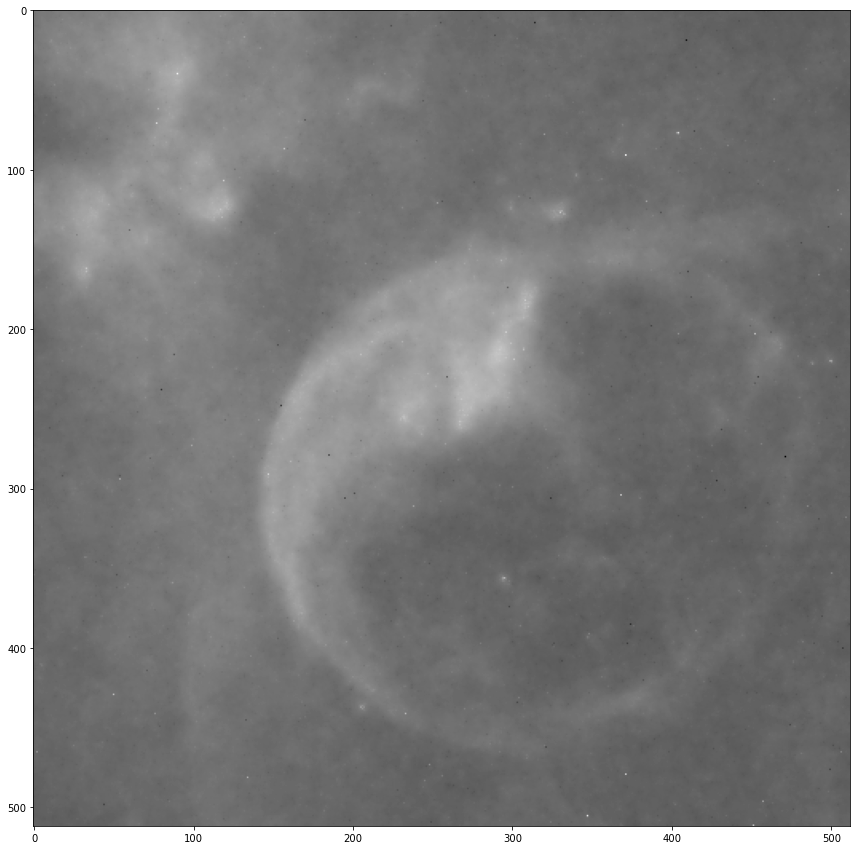

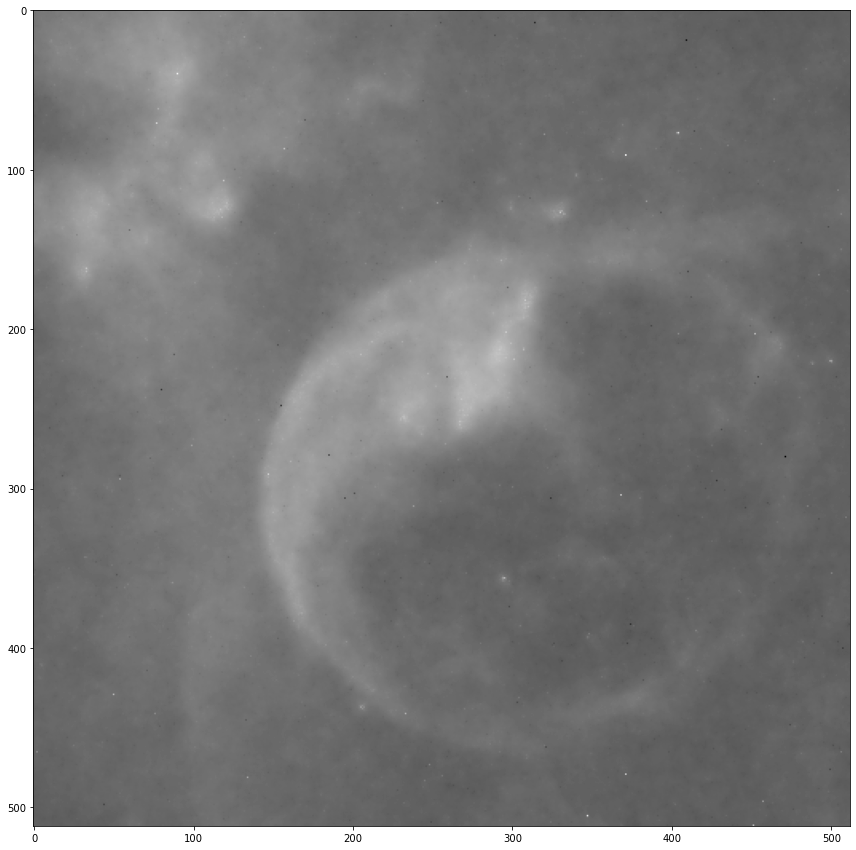

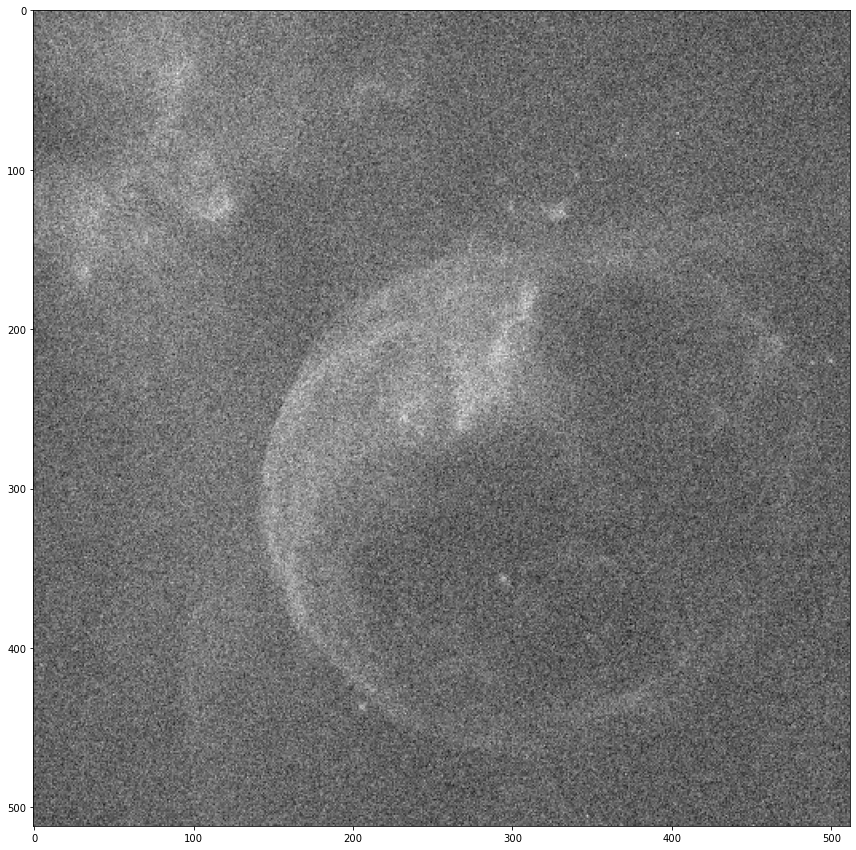

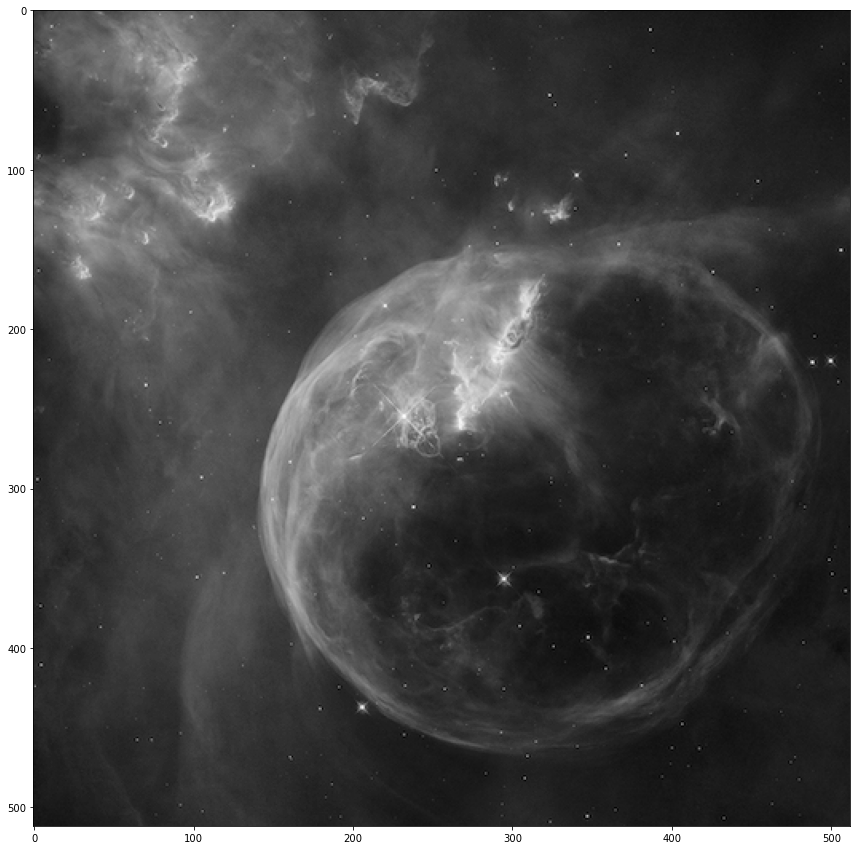

In [572]:
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [12.00, 12.50]
plt.imshow(cx,cmap="gray")
plt.figure()
plt.imshow(cr,cmap="gray")
plt.figure()
plt.imshow(z,cmap="gray")
plt.figure()
plt.imshow(cameraman_image,cmap="gray")

plt.show()